# DSAI MINI PROJECT

## This project has the aim of exploring data from Olist, a Brazilian E-commerce marketplace, to recommend to new sellers how they can potentially maximise thier profits and sales. 

#### Installing relevant packages

In [2]:
conda update --all

Solving environment: done

## Package Plan ##

  environment location: /Users/rochana/opt/anaconda3


The following packages will be SUPERSEDED by a higher-priority channel:

  geoviews-core             pyviz::geoviews-core-1.9.1-py_0 --> pkgs/main::geoviews-core-1.9.1-pyh06a4308_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.


In [3]:
conda install -yc pyviz geoviews-core

Solving environment: done

## Package Plan ##

  environment location: /Users/rochana/opt/anaconda3

  added / updated specs:
    - geoviews-core


The following packages will be SUPERSEDED by a higher-priority channel:

  geoviews-core      pkgs/main::geoviews-core-1.9.1-pyh06a~ --> pyviz::geoviews-core-1.9.1-py_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install datashader

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install holoviews

Note: you may need to restart the kernel to use updated packages.


#### Importing standard libraries

In [7]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import os
sb.set()
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample
import holoviews as hv
import geoviews as gv
import datashader as ds
from colorcet import fire, rainbow, bgy, bjy, bkr, kb, kr
from datashader.colors import colormap_select, Greys9
from holoviews.streams import RangeXY
from holoviews.operation.datashader import datashade, dynspread, rasterize
from bokeh.io import push_notebook, show, output_notebook

In [8]:
#there is no missing data (will be shown later), so skilearn data cleaning mathod is not needed

# Exploratory Data Analysis

## Geospatial Analysis

In [9]:
customers = pd.read_csv("olist_customers_dataset.csv")

order_items = pd.read_csv("olist_order_items_dataset.csv")

order_payment = pd.read_csv("olist_order_payments_dataset.csv")

review = pd.read_csv("olist_order_reviews_dataset.csv")

orders = pd.read_csv("olist_orders_dataset.csv")

products = pd.read_csv("olist_products_dataset.csv")

seller = pd.read_csv("olist_sellers_dataset.csv")

products_translation = pd.read_csv("product_category_name_translation.csv")

geo = pd.read_csv("olist_geolocation_dataset.csv", dtype={'geolocation_zip_code_prefix': str})

## Products - Monthly earning

In [6]:
#Translate portuguese categories to English
products_copy = products_translation.merge(products, on = "product_category_name")
products_copy = products_copy.drop("product_category_name", axis =1)

#merging data frames
merge = pd.merge(customers.drop(["customer_zip_code_prefix", "customer_state"], axis =1),
                    orders.drop(['order_approved_at', 'order_delivered_carrier_date'], axis = 1),
                how = 'outer', left_on = 'customer_id', right_on = 'customer_id')
customers_and_orders=merge

merge_df=pd.merge(merge, order_items[['order_id','product_id','price']], on='order_id')
merge_df=pd.merge(merge_df, products_copy[['product_id','product_category_name_english','product_photos_qty','product_weight_g','product_length_cm','product_height_cm','product_width_cm']])
merge_df=merge_df.dropna()
merge_df

customer_id                customer_unique_id  \
0       06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1       8912fc0c3bbf1e2fbf35819e21706718  9eae34bbd3a474ec5d07949ca7de67c0   
2       8912fc0c3bbf1e2fbf35819e21706718  9eae34bbd3a474ec5d07949ca7de67c0   
3       f0ac8e5a239118859b1734e1087cbb1f  3c799d181c34d51f6d44bbbc563024db   
4       6bc8d08963a135220ed6c6d098831f84  23397e992b09769faf5e66f9e171a241   
...                                  ...                               ...   
111018  f6c6d3e1e20969a5eed982163f959719  fb354969e06f2093c0083cbfbb91864e   
111019  da37711b17efd5f2539e8196ab215f04  5f2971f9805e3ccb030226e30c8e8390   
111020  184e0c2cfc746789643521df0e9ff904  c64ede6d0ae8901b1b6fb03528c1b7e6   
111021  821a7275a08f32975caceff2e08ea262  046470763123d3d6364f89095b4e47ab   
111022  1ed0c832c2dd99570a59260e71768bdf  82d46759af0369aad49084bacf85a6c3   

              customer_city                          order_id order_status  \
0                    franca  00e7ee1b050b8499577073aeb2a297a1    delivered   
1                  santarem  c1d2b34febe9cd269e378117d6681172    delivered   
2                  santarem  c1d2b34febe9cd269e378117d6681172    delivered   
3           nova santa rita  b1a5d5365d330d10485e0203d54ab9e8    delivered   
4                      mage  2e604b3614664aa66867856dba7e61b7    delivered   
...                     ...                               ...          ...   
111018            sao paulo  b2f58affcc178fea2daaf834f1acff5e    delivered   
111019            sao paulo  c8203bb57639618630affac9e8e923dd    delivered   
111020  sao miguel do guama  45b3000bcd10464ac178f32cd783fc83    delivered   
111021            sao paulo  49645a8902c1ba980836b7bff991d69f    delivered   
111022          bom repouso  51c6d2f460589fa7b65f2da51e860206    delivered   

       order_purchase_timestamp order_delivered_customer_date  \
0           2017-05-16 15:05:35           2017-05-25 10:35:35   
1           2017-11-09 00:50:13           2017-11-28 00:09:50   
2           2017-11-09 00:50:13           2017-11-28 00:09:50   
3           2017-05-07 20:11:26           2017-05-26 09:54:04   
4           2018-02-03 19:45:40           2018-02-28 21:09:00   
...                         ...                           ...   
111018      2018-07-14 14:08:11           2018-07-26 19:18:32   
111019      2017-03-27 23:04:18           2017-03-30 17:06:19   
111020      2017-12-07 23:55:46           2018-01-05 17:59:38   
111021      2018-04-04 17:50:52           2018-04-06 23:32:21   
111022      2017-11-14 12:04:09           2017-12-19 19:37:33   

       order_estimated_delivery_date                        product_id  \
0                2017-06-05 00:00:00  a9516a079e37a9c9c36b9b78b10169e8   
1                2017-12-19 00:00:00  a9516a079e37a9c9c36b9b78b10169e8   
2                2017-12-19 00:00:00  a9516a079e37a9c9c36b9b78b10169e8   
3                2017-06-12 00:00:00  a9516a079e37a9c9c36b9b78b10169e8   
4                2018-03-22 00:00:00  a9516a079e37a9c9c36b9b78b10169e8   
...                              ...                               ...   
111018           2018-07-30 00:00:00  9682ad2500ae8b2609e6a88eb0cbc5bb   
111019           2017-04-13 00:00:00  aea06073397f809424f946979354c9f0   
111020           2018-01-22 00:00:00  bbf975bffd2ae9ee52f513ae5c8a4b27   
111021           2018-04-18 00:00:00  f6e0a9ce8a6e91c3a0ca2d3005911d20   
111022           2017-12-12 00:00:00  c98bf47f7bea8f3aee82fa023786b8a1   

         price product_category_name_english  product_photos_qty  \
0       124.99              office_furniture                 1.0   
1       112.99              office_furniture                 1.0   
2       112.99              office_furniture                 1.0   
3       124.99              office_furniture                 1.0   
4       106.99              office_furniture                 1.0   
...        ...                           ...                 ...   
111018   

In [7]:
#data cleaning - to ensure that none of the data is missing or NA
merge_df.isnull()

customer_id  customer_unique_id  customer_city  order_id  \
0             False               False          False     False   
1             False               False          False     False   
2             False               False          False     False   
3             False               False          False     False   
4             False               False          False     False   
...             ...                 ...            ...       ...   
111018        False               False          False     False   
111019        False               False          False     False   
111020        False               False          False     False   
111021        False               False          False     False   
111022        False               False          False     False   

        order_status  order_purchase_timestamp  order_delivered_customer_date  \
0              False                     False                          False   
1              False                     False                          False   
2              False                     False                          False   
3              False                     False                          False   
4              False                     False                          False   
...              ...                       ...                            ...   
111018         False                     False                          False   
111019         False                     False                          False   
111020         False                     False                          False   
111021         False                     False                          False   
111022         False                     False                          False   

        order_estimated_delivery_date  product_id  price  \
0                               False       False  False   
1                               False       False  False   
2                               False       False  False   
3                               False       False  False   
4                               False       False  False   
...                               ...         ...    ...   
111018                          False       False  False   
111019                          False       False  False   
111020                          False       False  False   
111021                          False       False  False   
111022                          False       False  False   

        product_category_name_english  product_photos_qty  product_weight_g  \
0                               False               False             False   
1                               False               False             False   
2                               False               False             False   
3                               False               False             False   
4                               False               False             False   
...                               ...                 ...               ...   
111018                          False               False             False   
111019                          False               False             False   
111020                          False               False             False   
111021                          False               False             False   
111022                          False               False             False   

        product_length_cm  product_height_cm  product_width_cm  
0                   False              False             False  
1                   False              False             False  
2                   False              False             False  
3                   False              False             False  
4                   False              False             False  
...                   ...                ...               ...  
111018              False              False             False  
111019              False   

In [8]:
#easy check for any null values
merge_df.isnull().values.any()

False

Text(0.5, 1.0, 'number of orders per customer')

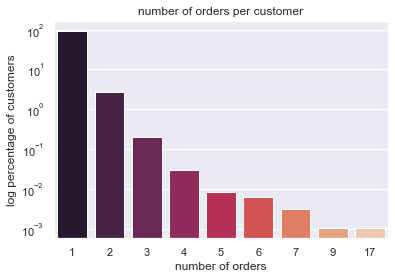

In [9]:
num_orders=customers_and_orders['customer_unique_id'].value_counts().value_counts()/customers_and_orders.shape[0]*100
num_orders=num_orders.reset_index()
num_orders.rename(columns={'index':'number of orders', 'customer_unique_id':'log percentage of customers'},inplace=True)
sb.barplot(data=num_orders,x='number of orders',y='log percentage of customers',palette='rocket')
#log the y-axis to see the percentage clearer as the gap is too huge
plt.yscale('log')
plt.title('number of orders per customer')

In [10]:
merge_df['order_delivered_customer_date']=pd.to_datetime(merge_df['order_delivered_customer_date']) #Convert argument to datetime.
merge_df['order_purchase_timestamp']=pd.to_datetime(merge_df['order_purchase_timestamp']) #Convert argument to datetime.
merge_df['purchase_month']=pd.DatetimeIndex(merge_df['order_purchase_timestamp']).month #Represented internally as int64, and which can be boxed to Timestamp objects that are subclasses of datetime and carry metadata.
merge_df

customer_id                customer_unique_id  \
0       06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1       8912fc0c3bbf1e2fbf35819e21706718  9eae34bbd3a474ec5d07949ca7de67c0   
2       8912fc0c3bbf1e2fbf35819e21706718  9eae34bbd3a474ec5d07949ca7de67c0   
3       f0ac8e5a239118859b1734e1087cbb1f  3c799d181c34d51f6d44bbbc563024db   
4       6bc8d08963a135220ed6c6d098831f84  23397e992b09769faf5e66f9e171a241   
...                                  ...                               ...   
111018  f6c6d3e1e20969a5eed982163f959719  fb354969e06f2093c0083cbfbb91864e   
111019  da37711b17efd5f2539e8196ab215f04  5f2971f9805e3ccb030226e30c8e8390   
111020  184e0c2cfc746789643521df0e9ff904  c64ede6d0ae8901b1b6fb03528c1b7e6   
111021  821a7275a08f32975caceff2e08ea262  046470763123d3d6364f89095b4e47ab   
111022  1ed0c832c2dd99570a59260e71768bdf  82d46759af0369aad49084bacf85a6c3   

              customer_city                          order_id order_status  \
0                    franca  00e7ee1b050b8499577073aeb2a297a1    delivered   
1                  santarem  c1d2b34febe9cd269e378117d6681172    delivered   
2                  santarem  c1d2b34febe9cd269e378117d6681172    delivered   
3           nova santa rita  b1a5d5365d330d10485e0203d54ab9e8    delivered   
4                      mage  2e604b3614664aa66867856dba7e61b7    delivered   
...                     ...                               ...          ...   
111018            sao paulo  b2f58affcc178fea2daaf834f1acff5e    delivered   
111019            sao paulo  c8203bb57639618630affac9e8e923dd    delivered   
111020  sao miguel do guama  45b3000bcd10464ac178f32cd783fc83    delivered   
111021            sao paulo  49645a8902c1ba980836b7bff991d69f    delivered   
111022          bom repouso  51c6d2f460589fa7b65f2da51e860206    delivered   

       order_purchase_timestamp order_delivered_customer_date  \
0           2017-05-16 15:05:35           2017-05-25 10:35:35   
1           2017-11-09 00:50:13           2017-11-28 00:09:50   
2           2017-11-09 00:50:13           2017-11-28 00:09:50   
3           2017-05-07 20:11:26           2017-05-26 09:54:04   
4           2018-02-03 19:45:40           2018-02-28 21:09:00   
...                         ...                           ...   
111018      2018-07-14 14:08:11           2018-07-26 19:18:32   
111019      2017-03-27 23:04:18           2017-03-30 17:06:19   
111020      2017-12-07 23:55:46           2018-01-05 17:59:38   
111021      2018-04-04 17:50:52           2018-04-06 23:32:21   
111022      2017-11-14 12:04:09           2017-12-19 19:37:33   

       order_estimated_delivery_date                        product_id  \
0                2017-06-05 00:00:00  a9516a079e37a9c9c36b9b78b10169e8   
1                2017-12-19 00:00:00  a9516a079e37a9c9c36b9b78b10169e8   
2                2017-12-19 00:00:00  a9516a079e37a9c9c36b9b78b10169e8   
3                2017-06-12 00:00:00  a9516a079e37a9c9c36b9b78b10169e8   
4                2018-03-22 00:00:00  a9516a079e37a9c9c36b9b78b10169e8   
...                              ...                               ...   
111018           2018-07-30 00:00:00  9682ad2500ae8b2609e6a88eb0cbc5bb   
111019           2017-04-13 00:00:00  aea06073397f809424f946979354c9f0   
111020           2018-01-22 00:00:00  bbf975bffd2ae9ee52f513ae5c8a4b27   
111021           2018-04-18 00:00:00  f6e0a9ce8a6e91c3a0ca2d3005911d20   
111022           2017-12-12 00:00:00  c98bf47f7bea8f3aee82fa023786b8a1   

         price product_category_name_english  product_photos_qty  \
0       124.99              office_furniture                 1.0   
1       112.99              office_furniture                 1.0   
2       112.99              office_furniture                 1.0   
3       124.99              office_furniture                 1.0   
4       106.99              office_furniture                 1.0   
...        ...                           ...                 ...   
111018   

In [11]:
#easy check for any null values
merge_df.isnull().values.any()

False

Text(0, 0.5, 'total earnings')

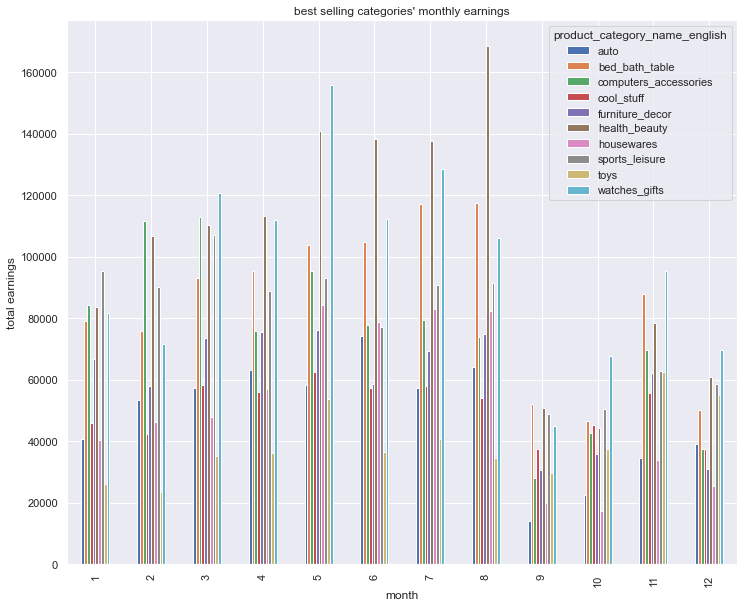

In [12]:
sales_df=merge_df.groupby(['product_category_name_english'])['price'] #group price according to product category together
sales_df=merge_df.groupby(['product_category_name_english'])['price'].sum() #calculate the total price of each category which is earnings 
best_sellers=sales_df.nlargest(10).index #top 10 products

best_df=merge_df[merge_df['product_category_name_english'].isin(best_sellers)] #dataframe with top 10 products only

best_monthly=best_df.pivot_table(index='purchase_month',columns='product_category_name_english',values='price', aggfunc='sum') #Create a spreadsheet-style pivot table as a DataFrame.
best_monthly.plot(kind='bar',figsize=(12, 10))
plt.title('best selling categories\' monthly earnings')
plt.xlabel('month')
plt.ylabel('total earnings')

In [13]:
pd.DataFrame(sales_df)

price
product_category_name_english            
agro_industry_and_commerce       70566.10
air_conditioning                 53323.56
art                              23657.30
arts_and_craftmanship             1814.01
audio                            50570.60
...                                   ...
stationery                      223788.69
tablets_printing_image            7528.41
telephony                       309860.23
toys                            471197.48
watches_gifts                  1165898.98

[71 rows x 1 columns]

In [14]:
#easy check for any null values
sales_df.isnull().values.any()

False

## Number of sales per seller in each product category

In [3]:
pd.set_option('display.max_rows', 10)
competition = products.merge(order_items, on = 'product_id')
competition = competition.merge(products_translation)
number_of_sales_cat = competition.groupby('product_category_name_english').count()
number_of_sales_cat = number_of_sales_cat[['product_id']]
number_of_sales_cat = number_of_sales_cat.rename(columns = {'product_id':'number_of_sales'})
number_of_sales_cat = number_of_sales_cat.sort_values('number_of_sales')
competition = competition.groupby(['seller_id', 'product_category_name_english']).agg({'price':'mean'})
competition = competition.groupby('product_category_name_english').count()
competition = competition.rename(columns = {'price':'number_of_seller'})
competition = competition.sort_values('number_of_seller')
competition

number_of_seller
product_category_name_english                  
cds_dvds_musicals                             1
security_and_services                         2
la_cuisine                                    2
flowers                                       3
home_comfort_2                                4
...                                         ...
furniture_decor                             370
auto                                        383
housewares                                  468
sports_leisure                              481
health_beauty                               492

[71 rows x 1 columns]

### health_beauty has highest supply, where 492 seller is selling product under this category

In [4]:
number_of_sales_cat.head(72)

number_of_sales
product_category_name_english                 
security_and_services                        2
fashion_childrens_clothes                    8
la_cuisine                                  14
cds_dvds_musicals                           14
arts_and_craftmanship                       24
...                                        ...
computers_accessories                     7827
furniture_decor                           8334
sports_leisure                            8641
health_beauty                             9670
bed_bath_table                           11115

[71 rows x 1 columns]

### bed_bath_table has the highest demand, where over 11115 sales have been made under this category

In [5]:
pd.set_option("display.max_rows",10)
sales_per_seller = competition.merge(number_of_sales_cat, on = 'product_category_name_english')
sales_per_seller['number_of_sales_per_seller'] = (sales_per_seller['number_of_sales']) / (sales_per_seller['number_of_seller'])
sales_per_seller = sales_per_seller.sort_values('number_of_sales_per_seller')
sales_per_seller


number_of_seller  number_of_sales  \
product_category_name_english                                      
security_and_services                         2                2   
arts_and_craftmanship                        13               24   
music                                        19               38   
fashion_childrens_clothes                     4                8   
fashion_sport                                10               30   
...                                         ...              ...   
computers_accessories                       287             7827   
telephony                                   149             4545   
office_furniture                             34             1691   
bed_bath_table                              196            11115   
watches_gifts                               101             5991   

                               number_of_sales_per_seller  
product_category_name_english                              
security_and_services                            1.000000  
arts_and_craftmanship                            1.846154  
music                                            2.000000  
fashion_childrens_clothes                        2.000000  
fashion_sport                                    3.000000  
...                                                   ...  
computers_accessories                           27.271777  
telephony                                       30.503356  
office_furniture                                49.735294  
bed_bath_table                                  56.709184  
watches_gifts                                   59.316832  

[71 rows x 3 columns]

In [6]:
sales_per_seller.iloc[[57,61,69,70]]

number_of_seller  number_of_sales  \
product_category_name_english                                      
sports_leisure                              481             8641   
health_beauty                               492             9670   
bed_bath_table                              196            11115   
watches_gifts                               101             5991   

                               number_of_sales_per_seller  
product_category_name_english                              
sports_leisure                                  17.964657  
health_beauty                                   19.654472  
bed_bath_table                                  56.709184  
watches_gifts                                   59.316832

### watches_gifts has highest number of sales per seller, meaning that it is the category with highest average sales for each seller
### This means this category have relatively high demand and low competition

## Average review score of each seller

<ipython-input-7-c6123d2230a6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seller_review['number_of_sales'] = seller_review['review_score']


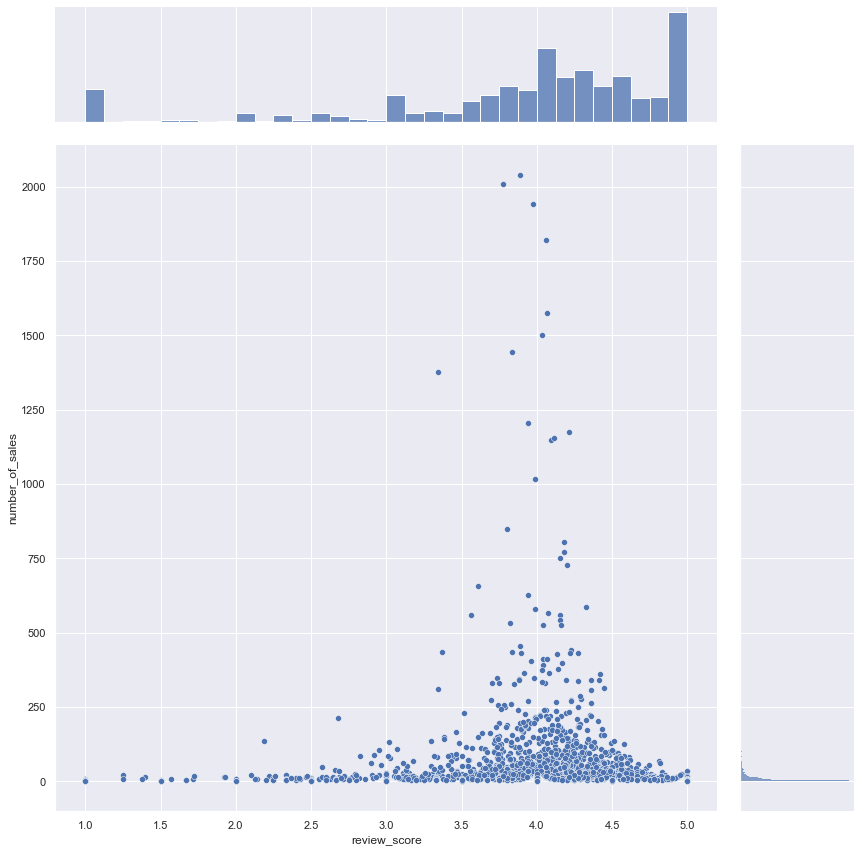

In [7]:
seller_order = seller.merge(order_items)
seller_order = seller_order.merge(products)
seller_order = seller_order.merge(review)
seller_review = seller_order[["seller_id", "review_score","freight_value","price","product_description_lenght","product_photos_qty"]]
seller_review['number_of_sales'] = seller_review['review_score']
seller_copy = seller_review
seller_review = seller_review.groupby('seller_id').agg({'review_score':'mean', 'price':'mean', 'freight_value':'mean', 'product_description_lenght':'mean','product_photos_qty':'mean'})
seller_copy = seller_copy.groupby('seller_id').count()
seller_review['number_of_sales'] = seller_copy['number_of_sales']
sb.jointplot(data = seller_review, x = "review_score", y = "number_of_sales", height = 12)


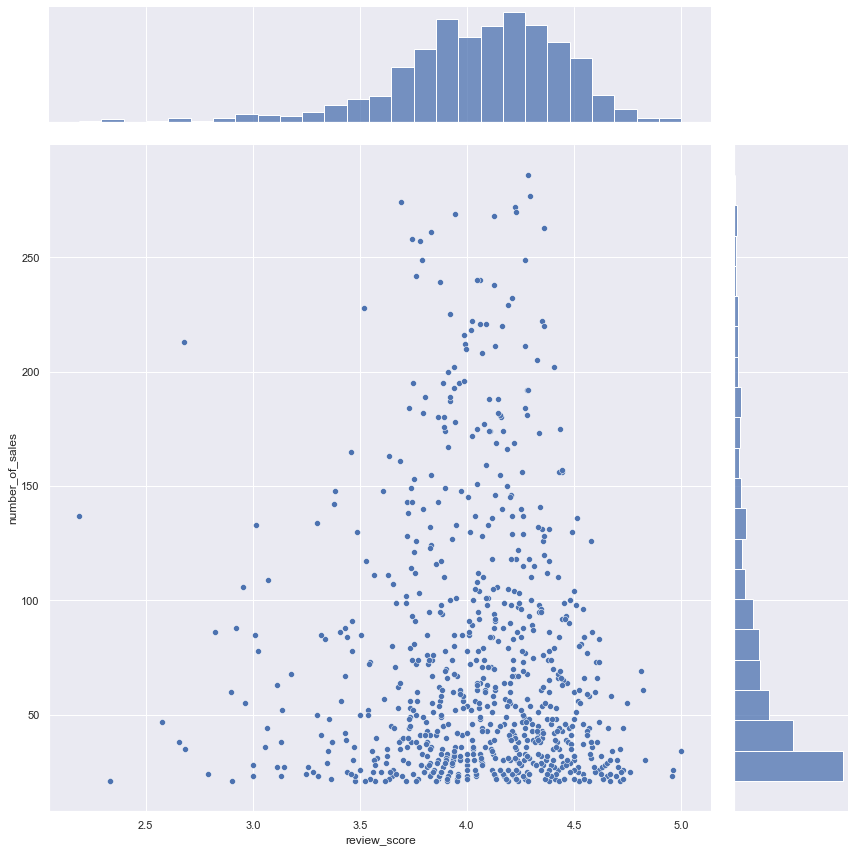

In [8]:
seller_review_unpacked = seller_review[seller_review['number_of_sales'] < 300]
seller_review_unpacked = seller_review_unpacked[seller_review_unpacked['number_of_sales'] > 20]
sb.jointplot(data = seller_review_unpacked, x = "review_score", y = "number_of_sales", height = 12)

In [9]:
#used later in the Catboost model
catanalysis = seller_review['number_of_sales']

### as part of data preparation and identification of outliers, after removing those with extreme high sales and those with only few sales, even thought the correlation is almost 0, we can see that those with higher number of sales have 3.5 average rating and above, hence it is advicable for us to have generally high rating inorder to have a higher chance of having relatively high sales.

In [10]:
type_of_product_seller_sells = products.merge(order_items, on = 'product_id')
type_of_product_seller_sells = type_of_product_seller_sells.groupby(['seller_id', 'product_category_name']).agg({'price':'mean'})
type_of_product_seller_sells = type_of_product_seller_sells.groupby('seller_id').count()
type_of_product_seller_sells = type_of_product_seller_sells.rename(columns = {'price':'number_of_type_of_product_category'})
seller_review = seller_review.merge(type_of_product_seller_sells, on = 'seller_id')
type_of_product_seller_sells = products.merge(order_items, on = 'product_id')
type_of_product_seller_sells = type_of_product_seller_sells.groupby(['seller_id', 'product_id']).agg({'price':'mean'})
type_of_product_seller_sells = type_of_product_seller_sells.groupby('seller_id').count()
type_of_product_seller_sells = type_of_product_seller_sells.rename(columns = {'price':'number_of_type_of_product'})

seller_review = seller_review.merge(type_of_product_seller_sells, on = 'seller_id')
seller_review = seller_review.rename(columns = {'price':'average_price', 'freight_value':'average_freight_value', 'product_description_length':'average_product_description_length','review_score':'average_review_score','product_photos_qty':'average_product_photos_qty'})
seller_review = seller_review.merge(seller, on = 'seller_id')

type_of_product_seller_mainly_sells = products.merge(order_items, on = 'product_id')
type_of_product_seller_mainly_sells = type_of_product_seller_mainly_sells.groupby(['seller_id', 'product_category_name', 'product_id']).agg({'price':'mean'})
type_of_product_seller_mainly_sells = type_of_product_seller_mainly_sells.groupby(['seller_id','product_category_name']).count()
type_of_product_seller_mainly_sells = type_of_product_seller_mainly_sells.groupby(['seller_id', 'product_category_name']).agg({'price':'max'})
type_of_product_seller_mainly_sells_copy = type_of_product_seller_mainly_sells.groupby(['seller_id']).agg({'price':'max'})
type_of_product_seller_mainly_sells = type_of_product_seller_mainly_sells.reset_index()
type_of_product_seller_mainly_sells = type_of_product_seller_mainly_sells.merge(type_of_product_seller_mainly_sells_copy, on = ['seller_id','price'])
type_of_product_seller_mainly_sells = type_of_product_seller_mainly_sells.drop('price', axis = 1)

seller_review = seller_review.merge(type_of_product_seller_mainly_sells, on = 'seller_id')
seller_review = seller_review.merge(products_translation)
seller_review = seller_review.drop('product_category_name', axis = 1)
seller_review = seller_review.rename(columns = {'price':'average_price', 'freight_value':'average_freight_value', 'product_description_length':'average_product_description_length','review_score':'average_review_score','product_photos_qty':'average_product_photos_qty','product_category_name_english':'main_product'})

last_data_date = pd.to_datetime(max(orders['order_purchase_timestamp']))
zero = last_data_date - last_data_date
orders_copy = orders.merge(order_items, on = 'order_id')
orders_late = orders_copy['order_item_id']
orders_est = orders_copy['order_estimated_delivery_date']
orders_deliver = orders_copy['order_delivered_customer_date']
for i in range(0,len(orders_copy)):
    if((pd.to_datetime(orders_est[i]) - pd.to_datetime(orders_deliver[i])) > zero):
        orders_late[i] = 0
    else:
        orders_late[i] = 1
orders_copy = orders_copy.groupby("seller_id").agg({"order_purchase_timestamp":"min","order_item_id":"sum"})
seller_time = orders_copy['order_purchase_timestamp']
for i in range(0,len(orders_copy)):
    seller_time[i] = (last_data_date - pd.to_datetime(seller_time[i])).days  
orders_copy = orders_copy.rename(columns = {'order_purchase_timestamp':'seller_time','order_item_id':'order_late'})
orders_copy.head()

seller_review = seller_review.merge(orders_copy, on = 'seller_id')

sales_per_seller = sales_per_seller.reset_index()
sales_per_seller = sales_per_seller.rename(columns = {'product_category_name_english':'main_product'})
sales_per_seller = sales_per_seller.drop(columns = ['number_of_seller','number_of_sales'])
seller_review = seller_review.merge(sales_per_seller, on = 'main_product')

<ipython-input-10-5103a6c5938d>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_late[i] = 0
<ipython-input-10-5103a6c5938d>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_late[i] = 1
<ipython-input-10-5103a6c5938d>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seller_time[i] = (last_data_date - pd.to_datetime(seller_time[i])).days


In [11]:
seller_review.head(10000)

seller_id  average_review_score  average_price  \
0     0015a82c2db000af6aaaf3ae2ecb0532              3.666667     895.000000   
1     042573af89b6d931f672efaf789d8358              3.666667     137.826667   
2     052577151711aec5c744fe12e66db3e1              2.250000     687.000000   
3     054694fa03fe82cec4b7551487331d74              3.363636     453.777273   
4     07d75e33f2750d97d467fb57e4dfdd8a              2.500000     361.200000   
...                                ...                   ...            ...   
3361  491a5ada3aa1678414e990262c4bbdc1              3.000000    1420.000000   
3362  75fbb52eda0cbc24f479d3b2fbfa8d3e              4.325581      26.302093   
3363  7c5b05cbdb5542049f38d90d7815b97d              4.416667      43.290000   
3364  bc2ac6b95e1accce9858528ee566c17e              4.636364      92.954545   
3365  c731d18cea9bf687ffee82a241c25b11              3.846154     140.846154   

      average_freight_value  product_description_lenght  \
0                 21.020000                  849.000000   
1                 21.696667                 1127.000000   
2                 55.605000                 1423.000000   
3                 32.756818                 1347.727273   
4                 18.595000                 1437.500000   
...                     ...                         ...   
3361              16.905000                 3992.000000   
3362              21.942326                  884.697674   
3363              12.770833                  356.541667   
3364              10.661818                  315.772727   
3365              23.486538                  408.884615   

      average_product_photos_qty  number_of_sales  \
0                       2.000000                3   
1                       1.666667                3   
2                       1.000000                4   
3                       3.500000               22   
4                       1.500000                2   
...                          ...              ...   
3361                    1.000000                2   
3362                    1.186047               43   
3363                    1.041667               24   
3364                    1.000000               22   
3365                    1.230769               26   

      number_of_type_of_product_category  number_of_type_of_product  \
0                                      1                          1   
1                                      2                          3   
2                                      1                          1   
3                                      4                         15   
4                                      2                          2   
...                                  ...                        ...   
3361                                   1                          1   
3362                                   1                         37   
3363                                   1                         10   
3364                                   1                         14   
3365                                   5                         18   

      seller_zip_code_prefix  seller_city seller_state      main_product  \
0                       9080  santo andre           SP  small_appliances   
1                      18015     sorocaba           SP  small_appliances   
2                      89136       rodeio           SC  small_appliances   
3                      15840      itajobi           SP  small_appliances   
4                       2117    sao paulo           SP  small_appliances   
...                      ...          ...          ...               ...   
3361                    4208    sao paulo           SP      dvds_blu_ray   
3362                   74560      goiania           GO      dvds_blu_ray   
3363                    5201    sao paulo           SP    books_imported   
3364                   13085     campinas           SP    books_imported   
3365                   89701    concordia    

### This is the list of variables (attributes) that we decided to use for predicting sales

## Data Preparation

In [12]:
#as part of data preparation, we can see that there is a typo in average_product_description_lenght so we need to change it
seller_review=seller_review.rename(columns = {'average_product_description_lenght':'average_product_description_length'})

#as part of data preparation, we can see that there is a typo in product_description_lenght so we need to change it
seller_review=seller_review.rename(columns = {'product_description_lenght':'product_description_length'})

#we can see the updated spelling now
seller_review

seller_id  average_review_score  average_price  \
0     0015a82c2db000af6aaaf3ae2ecb0532              3.666667     895.000000   
1     042573af89b6d931f672efaf789d8358              3.666667     137.826667   
2     052577151711aec5c744fe12e66db3e1              2.250000     687.000000   
3     054694fa03fe82cec4b7551487331d74              3.363636     453.777273   
4     07d75e33f2750d97d467fb57e4dfdd8a              2.500000     361.200000   
...                                ...                   ...            ...   
3361  491a5ada3aa1678414e990262c4bbdc1              3.000000    1420.000000   
3362  75fbb52eda0cbc24f479d3b2fbfa8d3e              4.325581      26.302093   
3363  7c5b05cbdb5542049f38d90d7815b97d              4.416667      43.290000   
3364  bc2ac6b95e1accce9858528ee566c17e              4.636364      92.954545   
3365  c731d18cea9bf687ffee82a241c25b11              3.846154     140.846154   

      average_freight_value  product_description_length  \
0                 21.020000                  849.000000   
1                 21.696667                 1127.000000   
2                 55.605000                 1423.000000   
3                 32.756818                 1347.727273   
4                 18.595000                 1437.500000   
...                     ...                         ...   
3361              16.905000                 3992.000000   
3362              21.942326                  884.697674   
3363              12.770833                  356.541667   
3364              10.661818                  315.772727   
3365              23.486538                  408.884615   

      average_product_photos_qty  number_of_sales  \
0                       2.000000                3   
1                       1.666667                3   
2                       1.000000                4   
3                       3.500000               22   
4                       1.500000                2   
...                          ...              ...   
3361                    1.000000                2   
3362                    1.186047               43   
3363                    1.041667               24   
3364                    1.000000               22   
3365                    1.230769               26   

      number_of_type_of_product_category  number_of_type_of_product  \
0                                      1                          1   
1                                      2                          3   
2                                      1                          1   
3                                      4                         15   
4                                      2                          2   
...                                  ...                        ...   
3361                                   1                          1   
3362                                   1                         37   
3363                                   1                         10   
3364                                   1                         14   
3365                                   5                         18   

      seller_zip_code_prefix  seller_city seller_state      main_product  \
0                       9080  santo andre           SP  small_appliances   
1                      18015     sorocaba           SP  small_appliances   
2                      89136       rodeio           SC  small_appliances   
3                      15840      itajobi           SP  small_appliances   
4                       2117    sao paulo           SP  small_appliances   
...                      ...          ...          ...               ...   
3361                    4208    sao paulo           SP      dvds_blu_ray   
3362                   74560      goiania           GO      dvds_blu_ray   
3363                    5201    sao paulo           SP    books_imported   
3364                   13085     campinas           SP    books_imported   
3365                   89701    concordia    

In [13]:
#to use later in Catboost Model
catdata = seller_review['number_of_sales']

In [14]:
seller_review = seller_review.astype({"seller_zip_code_prefix" : "string"})
seller_review["seller_zip_code_prefix"] = seller_review["seller_zip_code_prefix"].str[0:3]
pd.DataFrame(seller_review["number_of_sales"]).describe()

number_of_sales
count      3366.000000
mean         35.253417
std         115.903148
min           1.000000
25%           2.000000
50%           8.000000
75%          23.000000
max        2039.000000

In [15]:
seller_review.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3366 entries, 0 to 3365
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   seller_id                           3366 non-null   object 
 1   average_review_score                3366 non-null   float64
 2   average_price                       3366 non-null   float64
 3   average_freight_value               3366 non-null   float64
 4   product_description_length          3366 non-null   float64
 5   average_product_photos_qty          3366 non-null   float64
 6   number_of_sales                     3366 non-null   int64  
 7   number_of_type_of_product_category  3366 non-null   int64  
 8   number_of_type_of_product           3366 non-null   int64  
 9   seller_zip_code_prefix              3366 non-null   string 
 10  seller_city                         3366 non-null   object 
 11  seller_state                        3366 no

### Changing response from numerical to categorical

In [16]:
#Average number of sales is 35. Therefore, >35 sales is AboveAverage and < 36 sales is BelowAverage
number_of_sales = seller_review["number_of_sales"]
for i in range(0,len(seller_review)):
    if(int(number_of_sales[i]) > 35):
        number_of_sales[i] = "AboveAverage"
    else:
        number_of_sales[i] = "BelowAverage"

<ipython-input-16-40f405b6d18d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  number_of_sales[i] = "BelowAverage"
C:\Users\chery\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
<ipython-input-16-40f405b6d18d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  number_of_sales[i] = "AboveAverage"


In [17]:
seller_review["number_of_sales"] = number_of_sales

In [18]:
seller_review

seller_id  average_review_score  average_price  \
0     0015a82c2db000af6aaaf3ae2ecb0532              3.666667     895.000000   
1     042573af89b6d931f672efaf789d8358              3.666667     137.826667   
2     052577151711aec5c744fe12e66db3e1              2.250000     687.000000   
3     054694fa03fe82cec4b7551487331d74              3.363636     453.777273   
4     07d75e33f2750d97d467fb57e4dfdd8a              2.500000     361.200000   
...                                ...                   ...            ...   
3361  491a5ada3aa1678414e990262c4bbdc1              3.000000    1420.000000   
3362  75fbb52eda0cbc24f479d3b2fbfa8d3e              4.325581      26.302093   
3363  7c5b05cbdb5542049f38d90d7815b97d              4.416667      43.290000   
3364  bc2ac6b95e1accce9858528ee566c17e              4.636364      92.954545   
3365  c731d18cea9bf687ffee82a241c25b11              3.846154     140.846154   

      average_freight_value  product_description_length  \
0                 21.020000                  849.000000   
1                 21.696667                 1127.000000   
2                 55.605000                 1423.000000   
3                 32.756818                 1347.727273   
4                 18.595000                 1437.500000   
...                     ...                         ...   
3361              16.905000                 3992.000000   
3362              21.942326                  884.697674   
3363              12.770833                  356.541667   
3364              10.661818                  315.772727   
3365              23.486538                  408.884615   

      average_product_photos_qty number_of_sales  \
0                       2.000000    BelowAverage   
1                       1.666667    BelowAverage   
2                       1.000000    BelowAverage   
3                       3.500000    BelowAverage   
4                       1.500000    BelowAverage   
...                          ...             ...   
3361                    1.000000    BelowAverage   
3362                    1.186047    AboveAverage   
3363                    1.041667    BelowAverage   
3364                    1.000000    BelowAverage   
3365                    1.230769    BelowAverage   

      number_of_type_of_product_category  number_of_type_of_product  \
0                                      1                          1   
1                                      2                          3   
2                                      1                          1   
3                                      4                         15   
4                                      2                          2   
...                                  ...                        ...   
3361                                   1                          1   
3362                                   1                         37   
3363                                   1                         10   
3364                                   1                         14   
3365                                   5                         18   

     seller_zip_code_prefix  seller_city seller_state      main_product  \
0                       908  santo andre           SP  small_appliances   
1                       180     sorocaba           SP  small_appliances   
2                       891       rodeio           SC  small_appliances   
3                       158      itajobi           SP  small_appliances   
4                       211    sao paulo           SP  small_appliances   
...                     ...          ...          ...               ...   
3361                    420    sao paulo           SP      dvds_blu_ray   
3362                    745      goiania           GO      dvds_blu_ray   
3363                    520    sao paulo           SP    books_imported   
3364                    130     campinas           SP    books_imported   
3365                    897    concordia           SC        la_cuis

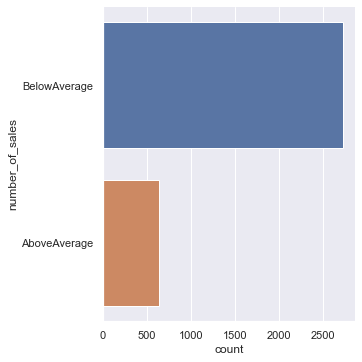

In [19]:
sb.catplot(y = 'number_of_sales', data = seller_review, kind = "count")

In [20]:
countG, countB = seller_review['number_of_sales'].value_counts()
print("Ratio of classes is BelowAverage : AboveAverage = ", countG, ":", countB)

Ratio of classes is BelowAverage : AboveAverage =  2732 : 634


In [21]:
#Numberic Predictors
seller_review[['average_review_score','average_price','average_freight_value','product_description_length','average_product_photos_qty','number_of_type_of_product_category','number_of_type_of_product','seller_time','order_late']].describe()

average_review_score  average_price  average_freight_value  \
count           3366.000000    3366.000000            3366.000000   
mean               3.958282     176.147750              23.364569   
std                0.963163     315.105550              18.652170   
min                1.000000       3.500000               1.200000   
25%                3.666667      53.071429              14.811089   
50%                4.153133      95.547292              18.235000   
75%                4.580325     173.780929              24.424125   
max                5.000000    6729.000000             308.336667   

       product_description_length  average_product_photos_qty  \
count                 3366.000000                 3366.000000   
mean                   862.427874                    2.249492   
std                    597.774348                    1.454554   
min                     52.000000                    1.000000   
25%                    443.083333                    1.000000   
50%                    711.444444                    1.891892   
75%                   1102.375000                    3.000000   
max                   3992.000000                   14.000000   

       number_of_type_of_product_category  number_of_type_of_product  \
count                         3366.000000                3366.000000   
mean                             2.230838                  10.713904   
std                              2.136615                  23.585685   
min                              1.000000                   1.000000   
25%                              1.000000                   2.000000   
50%                              1.000000                   4.000000   
75%                              3.000000                   9.000000   
max                             27.000000                 399.000000   

        order_late  
count  3366.000000  
mean      3.482769  
std      11.611319  
min       0.000000  
25%       0.000000  
50%       1.000000  
75%       3.000000  
max     252.000000

In [22]:
#Categorical Predictors
#zip_code currently is int so convert it into categorical
seller_review = seller_review.astype({"seller_zip_code_prefix" : "object","seller_time" : "int64"})
seller_review[["seller_zip_code_prefix","seller_city","seller_state"]].describe()

seller_zip_code_prefix seller_city seller_state
count                    3366        3366         3366
unique                    666         604           23
top                       140   sao paulo           SP
freq                       61         766         2003

## Mutual relationship between variables and number_of_sales

<AxesSubplot:xlabel='average_review_score', ylabel='Count'>

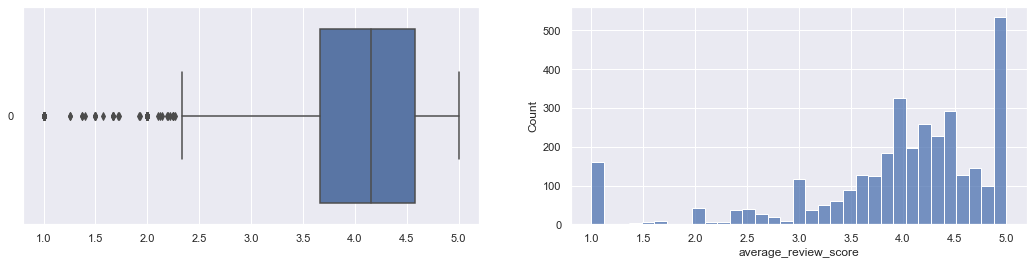

In [35]:
#Average review score
f, axes = plt.subplots(1, 2, figsize=(18, 4))
sb.boxplot(data = seller_review['average_review_score'], orient = "h", ax = axes[0])
sb.histplot(data = seller_review['average_review_score'], ax = axes[1])

<AxesSubplot:xlabel='average_review_score', ylabel='number_of_sales'>

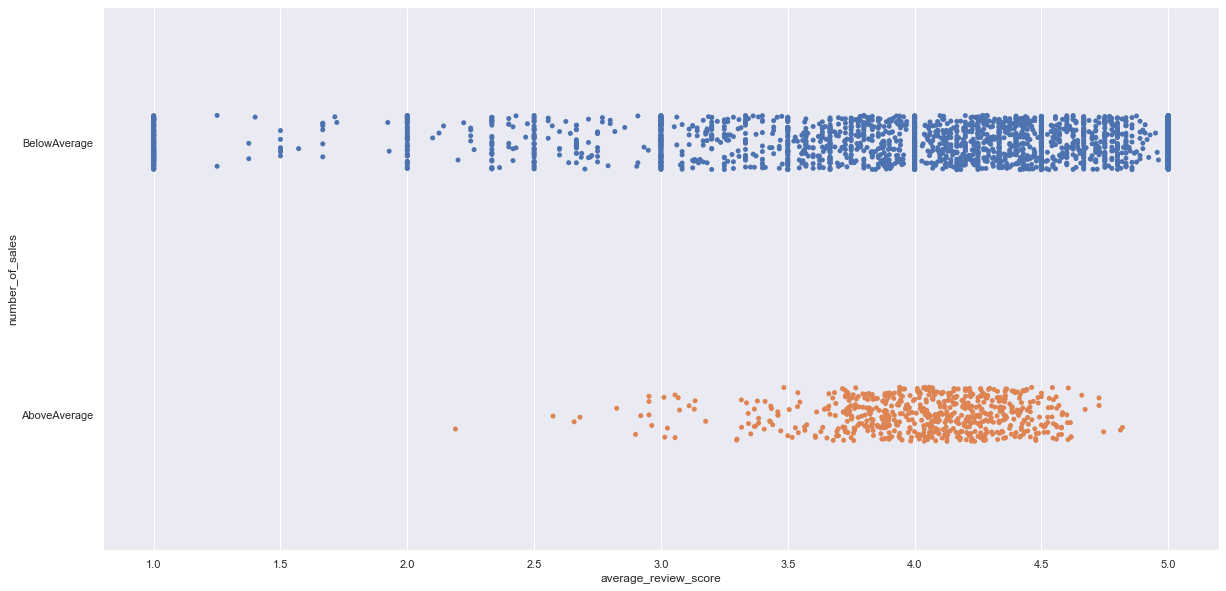

In [36]:
# Plot Response against Predictor to visualize their mutual relationship.
f = plt.figure(figsize=(20, 10))
sb.stripplot(x = 'average_review_score', y = 'number_of_sales', data = seller_review)

<AxesSubplot:xlabel='average_price', ylabel='Count'>

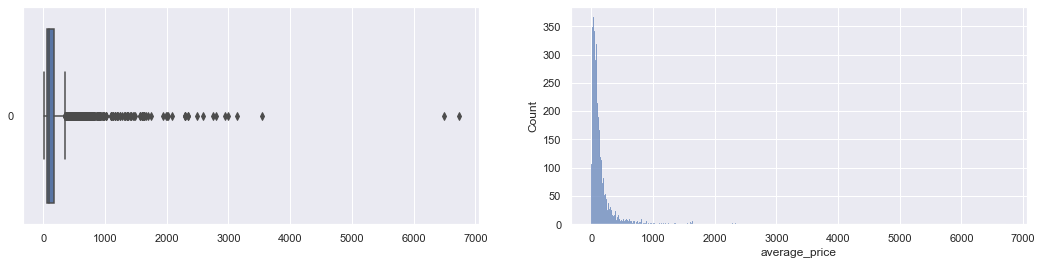

In [37]:
#Average price 
f, axes = plt.subplots(1, 2, figsize=(18, 4))
sb.boxplot(data = seller_review['average_price'], orient = "h", ax = axes[0])
sb.histplot(data = seller_review['average_price'], ax = axes[1])

<AxesSubplot:xlabel='average_price', ylabel='number_of_sales'>

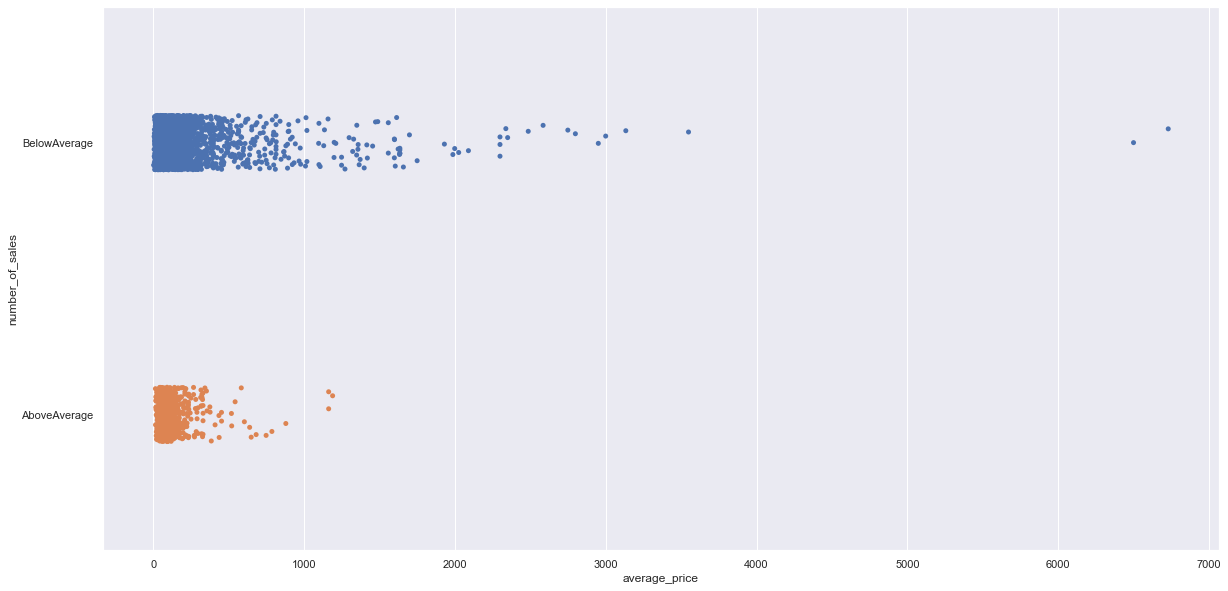

In [38]:
# Plot Response against Predictor to visualize their mutual relationship.
f = plt.figure(figsize=(20, 10))
sb.stripplot(x = 'average_price', y = 'number_of_sales', data = seller_review)

<AxesSubplot:xlabel='average_freight_value', ylabel='Count'>

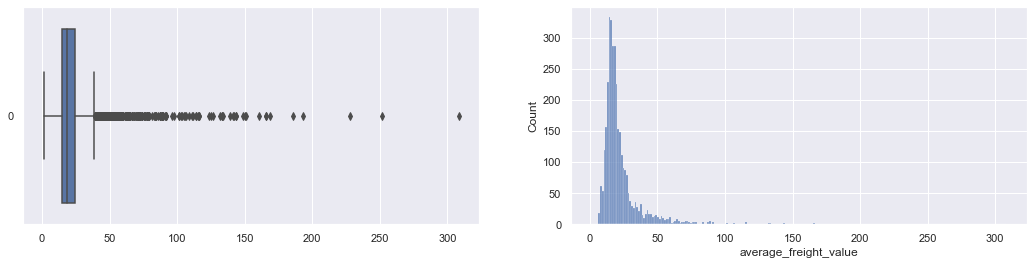

In [39]:
#Average freight value
f, axes = plt.subplots(1, 2, figsize=(18, 4))
sb.boxplot(data = seller_review['average_freight_value'], orient = "h", ax = axes[0])
sb.histplot(data = seller_review['average_freight_value'], ax = axes[1])

<AxesSubplot:xlabel='average_freight_value', ylabel='number_of_sales'>

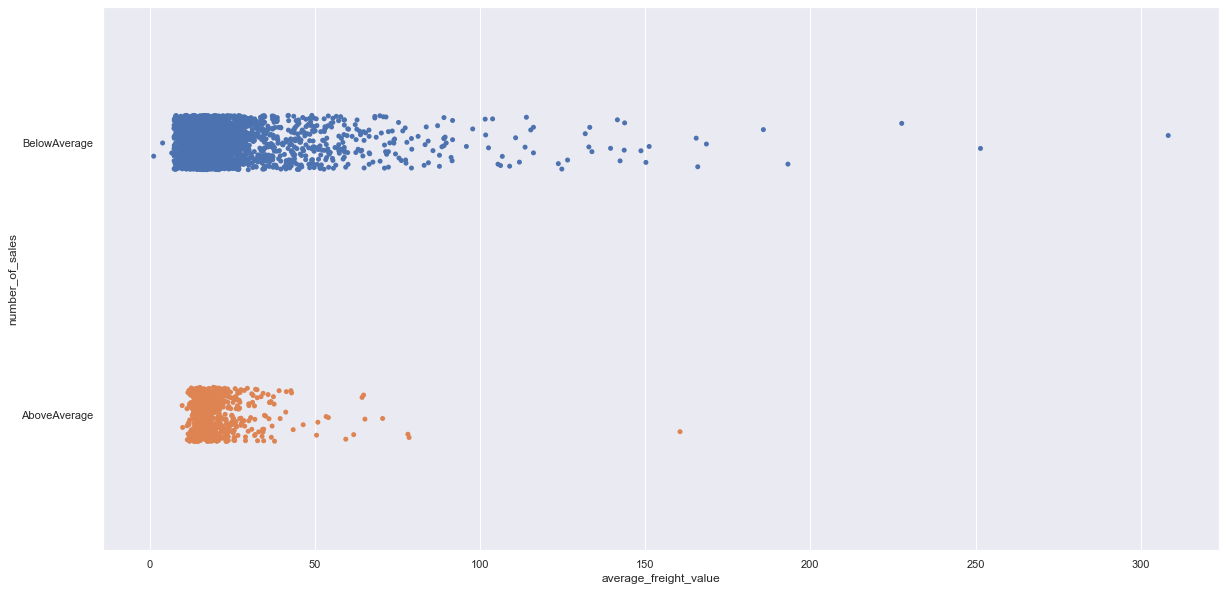

In [40]:
# Plot Response against Predictor to visualize their mutual relationship.
f = plt.figure(figsize=(20, 10))
sb.stripplot(x = 'average_freight_value', y = 'number_of_sales', data = seller_review)

<AxesSubplot:xlabel='product_description_length', ylabel='Count'>

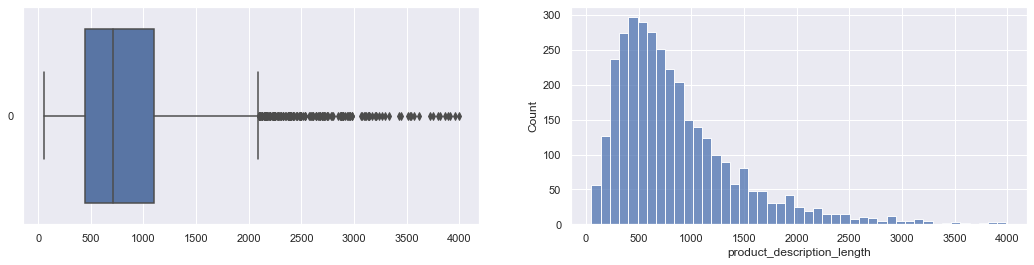

In [41]:
#average_product_description_length
f, axes = plt.subplots(1, 2, figsize=(18, 4))
sb.boxplot(data = seller_review['product_description_length'], orient = "h", ax = axes[0])
sb.histplot(data = seller_review['product_description_length'], ax = axes[1])

<AxesSubplot:xlabel='product_description_length', ylabel='number_of_sales'>

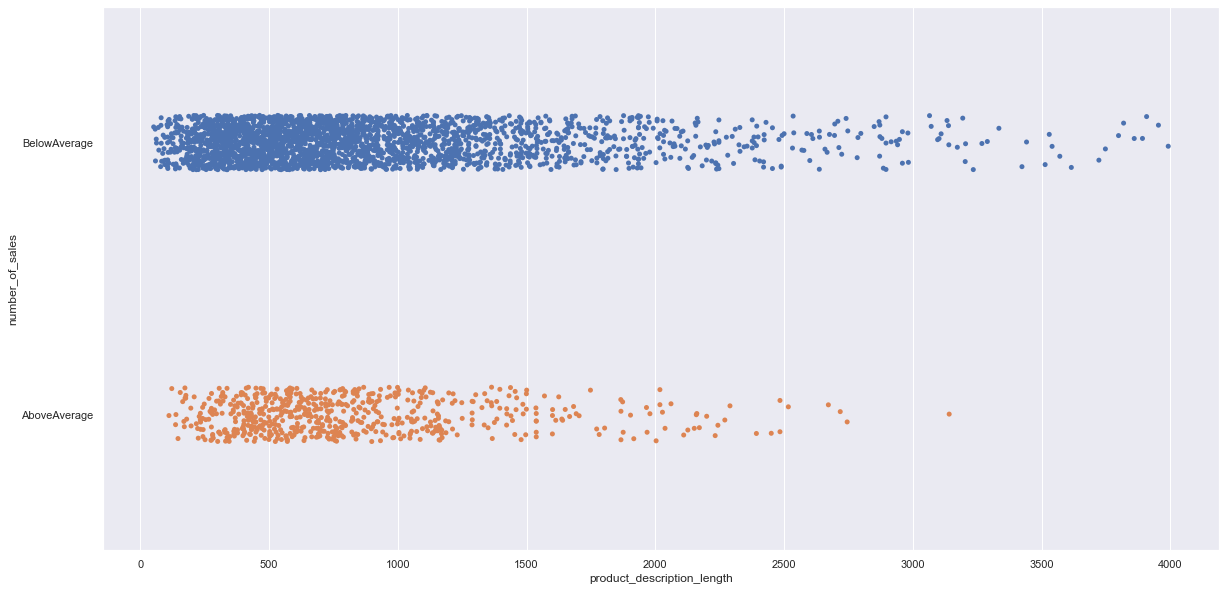

In [42]:
# Plot Response against Predictor to visualize their mutual relationship.
f = plt.figure(figsize=(20, 10))
sb.stripplot(x = 'product_description_length', y = 'number_of_sales', data = seller_review)

<AxesSubplot:xlabel='average_product_photos_qty', ylabel='Count'>

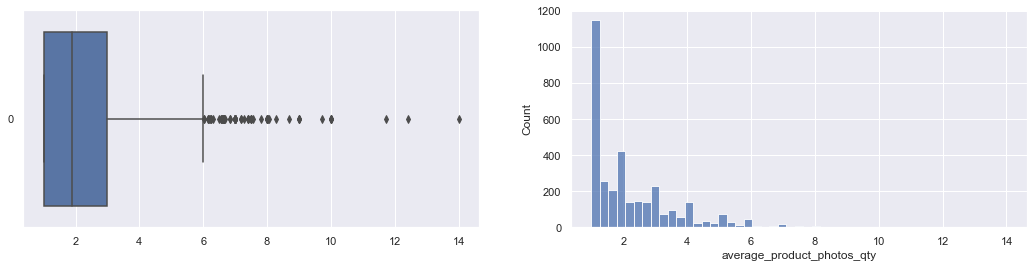

In [43]:
#average_product_photos_qty
f, axes = plt.subplots(1, 2, figsize=(18, 4))
sb.boxplot(data = seller_review['average_product_photos_qty'], orient = "h", ax = axes[0])
sb.histplot(data = seller_review['average_product_photos_qty'], ax = axes[1])

<AxesSubplot:xlabel='average_product_photos_qty', ylabel='number_of_sales'>

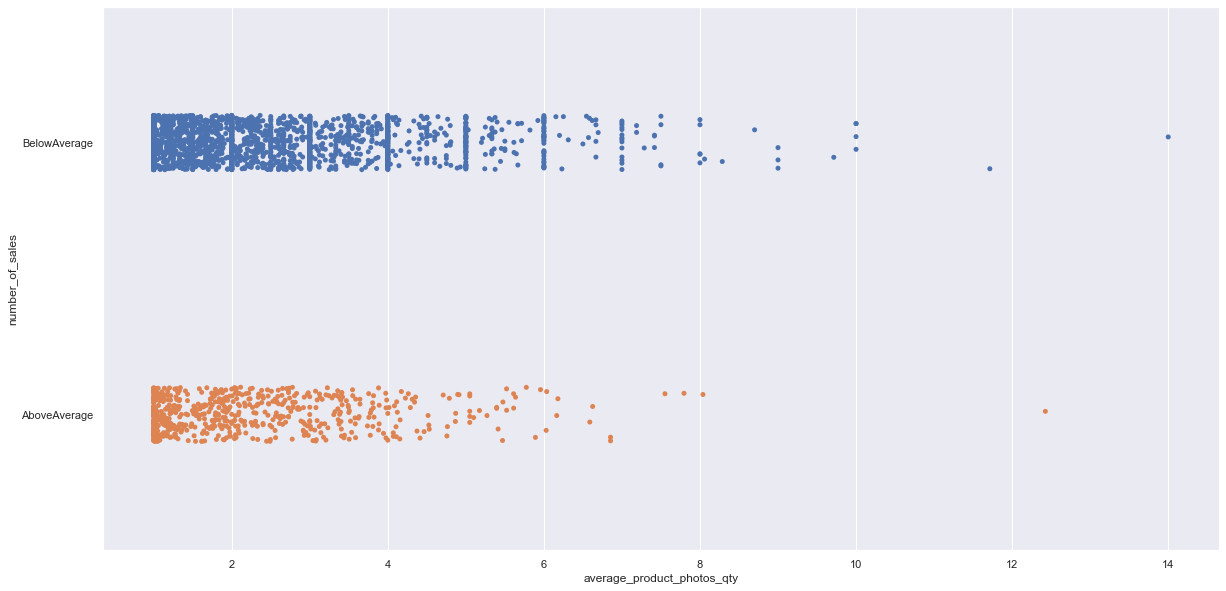

In [44]:
# Plot Response against Predictor to visualize their mutual relationship.
f = plt.figure(figsize=(20, 10))
sb.stripplot(x = 'average_product_photos_qty', y = 'number_of_sales', data = seller_review)

<AxesSubplot:xlabel='number_of_type_of_product_category', ylabel='Count'>

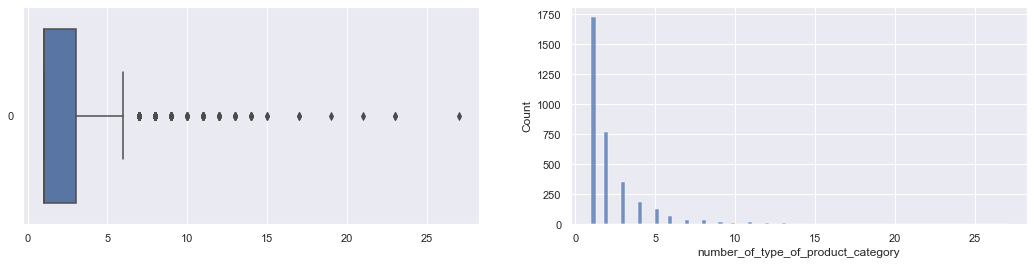

In [45]:
#number_of_type_of_product_category
f, axes = plt.subplots(1, 2, figsize=(18, 4))
sb.boxplot(data = seller_review['number_of_type_of_product_category'], orient = "h", ax = axes[0])
sb.histplot(data = seller_review['number_of_type_of_product_category'], ax = axes[1])

<AxesSubplot:xlabel='number_of_type_of_product_category', ylabel='number_of_sales'>

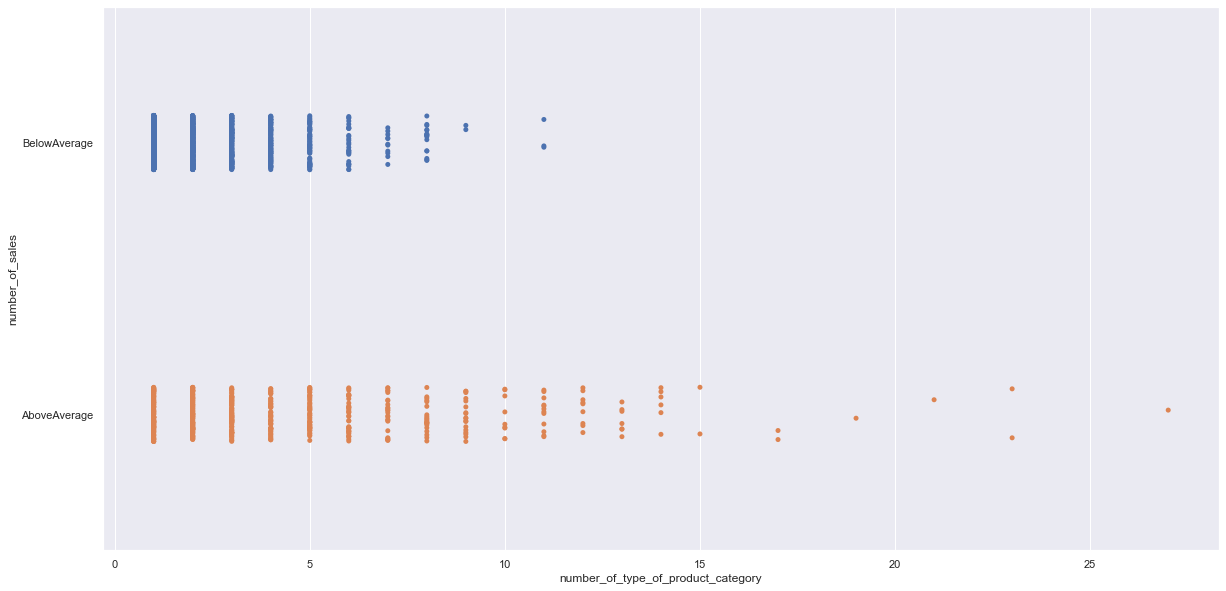

In [46]:
# Plot Response against Predictor to visualize their mutual relationship.
f = plt.figure(figsize=(20, 10))
sb.stripplot(x = 'number_of_type_of_product_category', y = 'number_of_sales', data = seller_review)

<AxesSubplot:xlabel='number_of_type_of_product', ylabel='Count'>

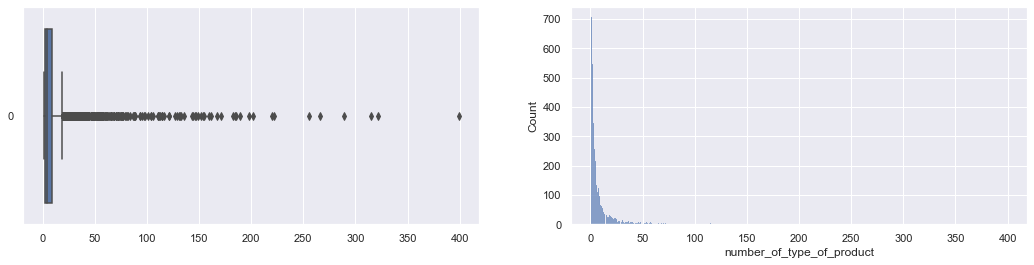

In [47]:
#number_of_type_of_product
f, axes = plt.subplots(1, 2, figsize=(18, 4))
sb.boxplot(data = seller_review['number_of_type_of_product'], orient = "h", ax = axes[0])
sb.histplot(data = seller_review['number_of_type_of_product'], ax = axes[1])

<AxesSubplot:xlabel='number_of_type_of_product', ylabel='number_of_sales'>

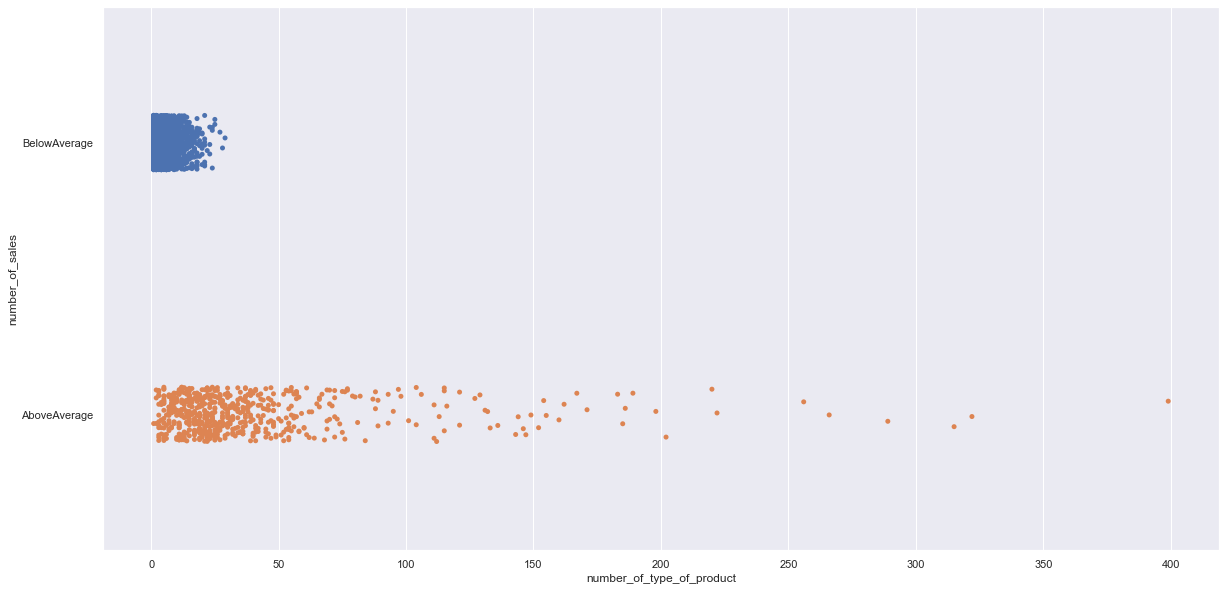

In [48]:
# Plot Response against Predictor to visualize their mutual relationship.
f = plt.figure(figsize=(20, 10))
sb.stripplot(x = 'number_of_type_of_product', y = 'number_of_sales', data = seller_review)

<AxesSubplot:xlabel='seller_time', ylabel='Count'>

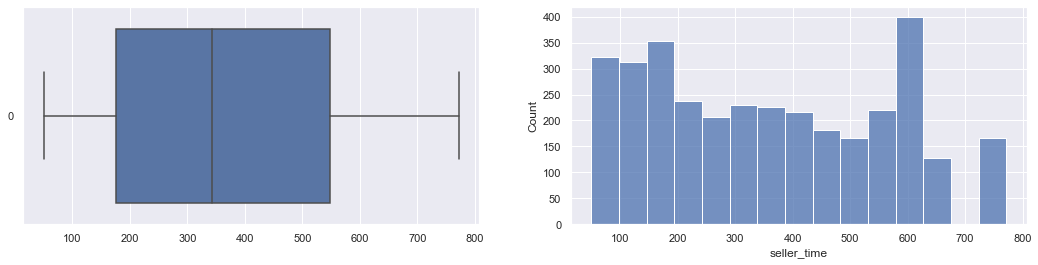

In [49]:
#seller_time
f, axes = plt.subplots(1, 2, figsize=(18, 4))
sb.boxplot(data = seller_review['seller_time'], orient = "h", ax = axes[0])
sb.histplot(data = seller_review['seller_time'], ax = axes[1])

<AxesSubplot:xlabel='seller_time', ylabel='number_of_sales'>

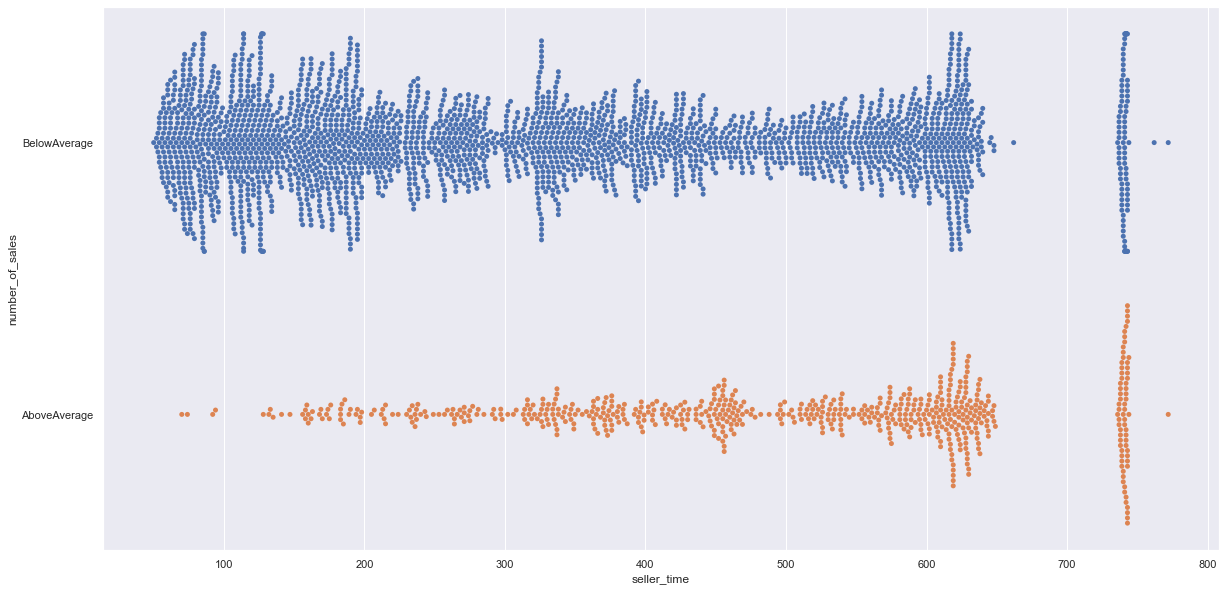

In [50]:
# Plot Response against Predictor to visualize their mutual relationship.
f = plt.figure(figsize=(20, 10))
sb.swarmplot(x = 'seller_time', y = 'number_of_sales', data = seller_review)

<AxesSubplot:xlabel='order_late', ylabel='Count'>

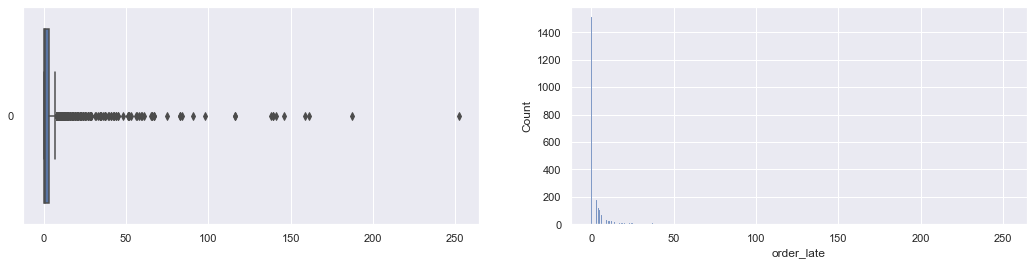

In [51]:
#order_late
f, axes = plt.subplots(1, 2, figsize=(18, 4))
sb.boxplot(data = seller_review['order_late'], orient = "h", ax = axes[0])
sb.histplot(data = seller_review['order_late'], ax = axes[1])

<AxesSubplot:xlabel='order_late', ylabel='number_of_sales'>

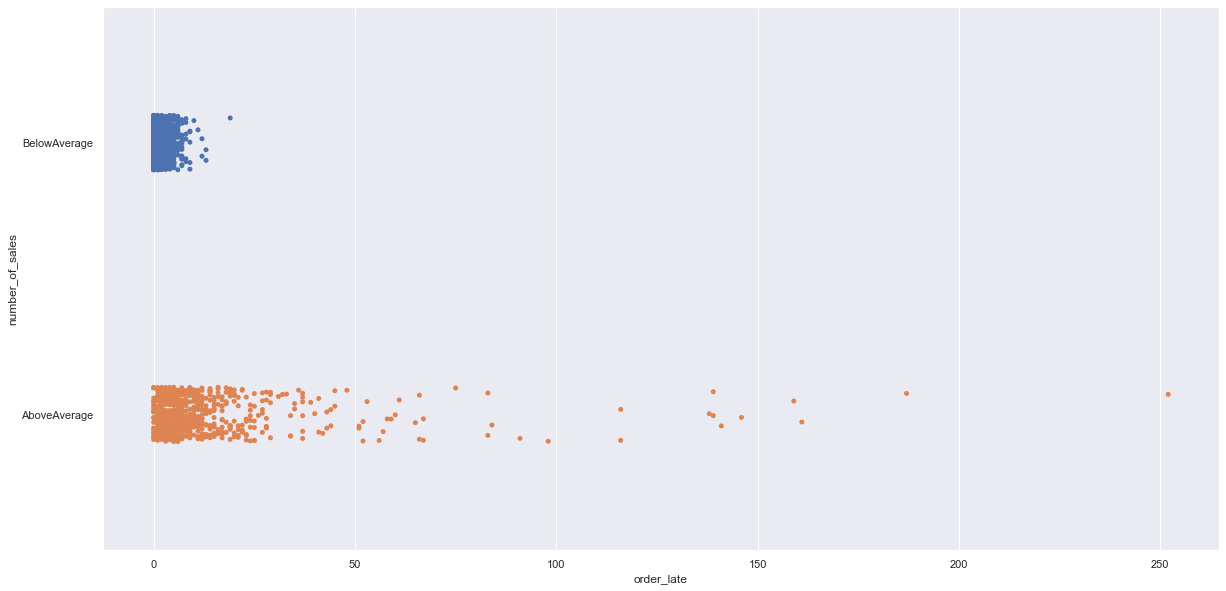

In [52]:
# Plot Response against Predictor to visualize their mutual relationship.
f = plt.figure(figsize=(20, 10))
sb.stripplot(x = 'order_late', y = 'number_of_sales', data = seller_review)

### Conclusion

As seen from the swarmplot above, we can observe that "average_price", "average_freight_value", "average_product_description_length", "average_product_photos_qty", "number_of_type_of_product_category" generally will not affect the prediction of our response much.

These datas will be dropped later on

In [23]:
seller_review.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3366 entries, 0 to 3365
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   seller_id                           3366 non-null   object 
 1   average_review_score                3366 non-null   float64
 2   average_price                       3366 non-null   float64
 3   average_freight_value               3366 non-null   float64
 4   product_description_length          3366 non-null   float64
 5   average_product_photos_qty          3366 non-null   float64
 6   number_of_sales                     3366 non-null   object 
 7   number_of_type_of_product_category  3366 non-null   int64  
 8   number_of_type_of_product           3366 non-null   int64  
 9   seller_zip_code_prefix              3366 non-null   object 
 10  seller_city                         3366 non-null   object 
 11  seller_state                        3366 no

In [24]:
ohe = OneHotEncoder()

# OneHotEncoding of categorical predictors (not the response)
seller_review_cat = seller_review[["seller_zip_code_prefix", "seller_city", "seller_state", "main_product"]]

ohe.fit(seller_review_cat)
seller_review_cat_ohe = pd.DataFrame(ohe.transform(seller_review_cat).toarray(), 
                                  columns=ohe.get_feature_names(seller_review_cat.columns))
# Check the encoded variables
seller_review_cat_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3366 entries, 0 to 3365
Columns: 1361 entries, seller_zip_code_prefix_100 to main_product_watches_gifts
dtypes: float64(1361)
memory usage: 35.0 MB


In [25]:
seller_review_cat_ohe

seller_zip_code_prefix_100  seller_zip_code_prefix_102  \
0                            0.0                         0.0   
1                            0.0                         0.0   
2                            0.0                         0.0   
3                            0.0                         0.0   
4                            0.0                         0.0   
...                          ...                         ...   
3361                         0.0                         0.0   
3362                         0.0                         0.0   
3363                         0.0                         0.0   
3364                         0.0                         0.0   
3365                         0.0                         0.0   

      seller_zip_code_prefix_103  seller_zip_code_prefix_104  \
0                            0.0                         0.0   
1                            0.0                         0.0   
2                            0.0                         0.0   
3                            0.0                         0.0   
4                            0.0                         0.0   
...                          ...                         ...   
3361                         0.0                         0.0   
3362                         0.0                         0.0   
3363                         0.0                         0.0   
3364                         0.0                         0.0   
3365                         0.0                         0.0   

      seller_zip_code_prefix_110  seller_zip_code_prefix_112  \
0                            0.0                         0.0   
1                            0.0                         0.0   
2                            0.0                         0.0   
3                            0.0                         0.0   
4                            0.0                         0.0   
...                          ...                         ...   
3361                         0.0                         0.0   
3362                         0.0                         0.0   
3363                         0.0                         0.0   
3364                         0.0                         0.0   
3365                         0.0                         0.0   

      seller_zip_code_prefix_113  seller_zip_code_prefix_114  \
0                            0.0                         0.0   
1                            0.0                         0.0   
2                            0.0                         0.0   
3                            0.0                         0.0   
4                            0.0                         0.0   
...                          ...                         ...   
3361                         0.0                         0.0   
3362                         0.0                         0.0   
3363                         0.0                         0.0   
3364                         0.0                         0.0   
3365                         0.0                         0.0   

      seller_zip_code_prefix_115  seller_zip_code_prefix_116  ...  \
0                            0.0                         0.0  ...   
1                            0.0                         0.0  ...   
2                            0.0                         0.0  ...   
3                            0.0                         0.0  ...   
4                            0.0                         0.0  ...   
...                          ...                         ...  ...   
3361                         0.0                         0.0  ...   
3362                         0.0                         0.0  ...   
3363                         0.0                         0.0  ...   
3364                         0.0                         0.0  ...   
3365                         0.0                         0.0  ...   

      main_product_pet_shop  main_product_signaling_and_security  \
0                       0.0      

In [26]:
# Combining Numeric features with the OHE Categorical features
seller_review_num = seller_review.drop(columns = ["seller_zip_code_prefix", "seller_city", "seller_state","number_of_sales","seller_id","main_product"])
seller_review_res = seller_review['number_of_sales']
seller_review_ohe = pd.concat([seller_review_num, seller_review_cat_ohe, seller_review_res], 
                           sort = False, axis = 1).reindex(index=seller_review_num.index)

# Check the final dataframe
seller_review_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3366 entries, 0 to 3365
Columns: 1372 entries, average_review_score to number_of_sales
dtypes: float64(1367), int64(4), object(1)
memory usage: 35.4+ MB


In [57]:
# Extract Response and Predictors
y = pd.DataFrame(seller_review_ohe['number_of_sales'])
X = pd.DataFrame(seller_review_ohe.drop('number_of_sales', axis = 1))

### Decision Tree without unsampling

[Text(1395.0, 978.48, 'number_of_type_of_product <= 13.5\ngini = 0.294\nsamples = 2356\nvalue = [421, 1935]\nclass = AboveAverage'),
 Text(613.8, 761.0400000000001, 'order_late <= 6.5\ngini = 0.086\nsamples = 1948\nvalue = [88, 1860]\nclass = AboveAverage'),
 Text(334.79999999999995, 543.6, 'seller_zip_code_prefix_389 <= 0.5\ngini = 0.054\nsamples = 1897\nvalue = [53, 1844]\nclass = AboveAverage'),
 Text(223.2, 326.1600000000001, 'order_late <= 4.5\ngini = 0.051\nsamples = 1894\nvalue = [50, 1844]\nclass = AboveAverage'),
 Text(111.6, 108.72000000000003, 'gini = 0.038\nsamples = 1827\nvalue = [35, 1792]\nclass = AboveAverage'),
 Text(334.79999999999995, 108.72000000000003, 'gini = 0.348\nsamples = 67\nvalue = [15, 52]\nclass = AboveAverage'),
 Text(446.4, 326.1600000000001, 'gini = 0.0\nsamples = 3\nvalue = [3, 0]\nclass = BelowAverage'),
 Text(892.8, 543.6, 'average_review_score <= 3.535\ngini = 0.431\nsamples = 51\nvalue = [35, 16]\nclass = BelowAverage'),
 Text(669.5999999999999, 32

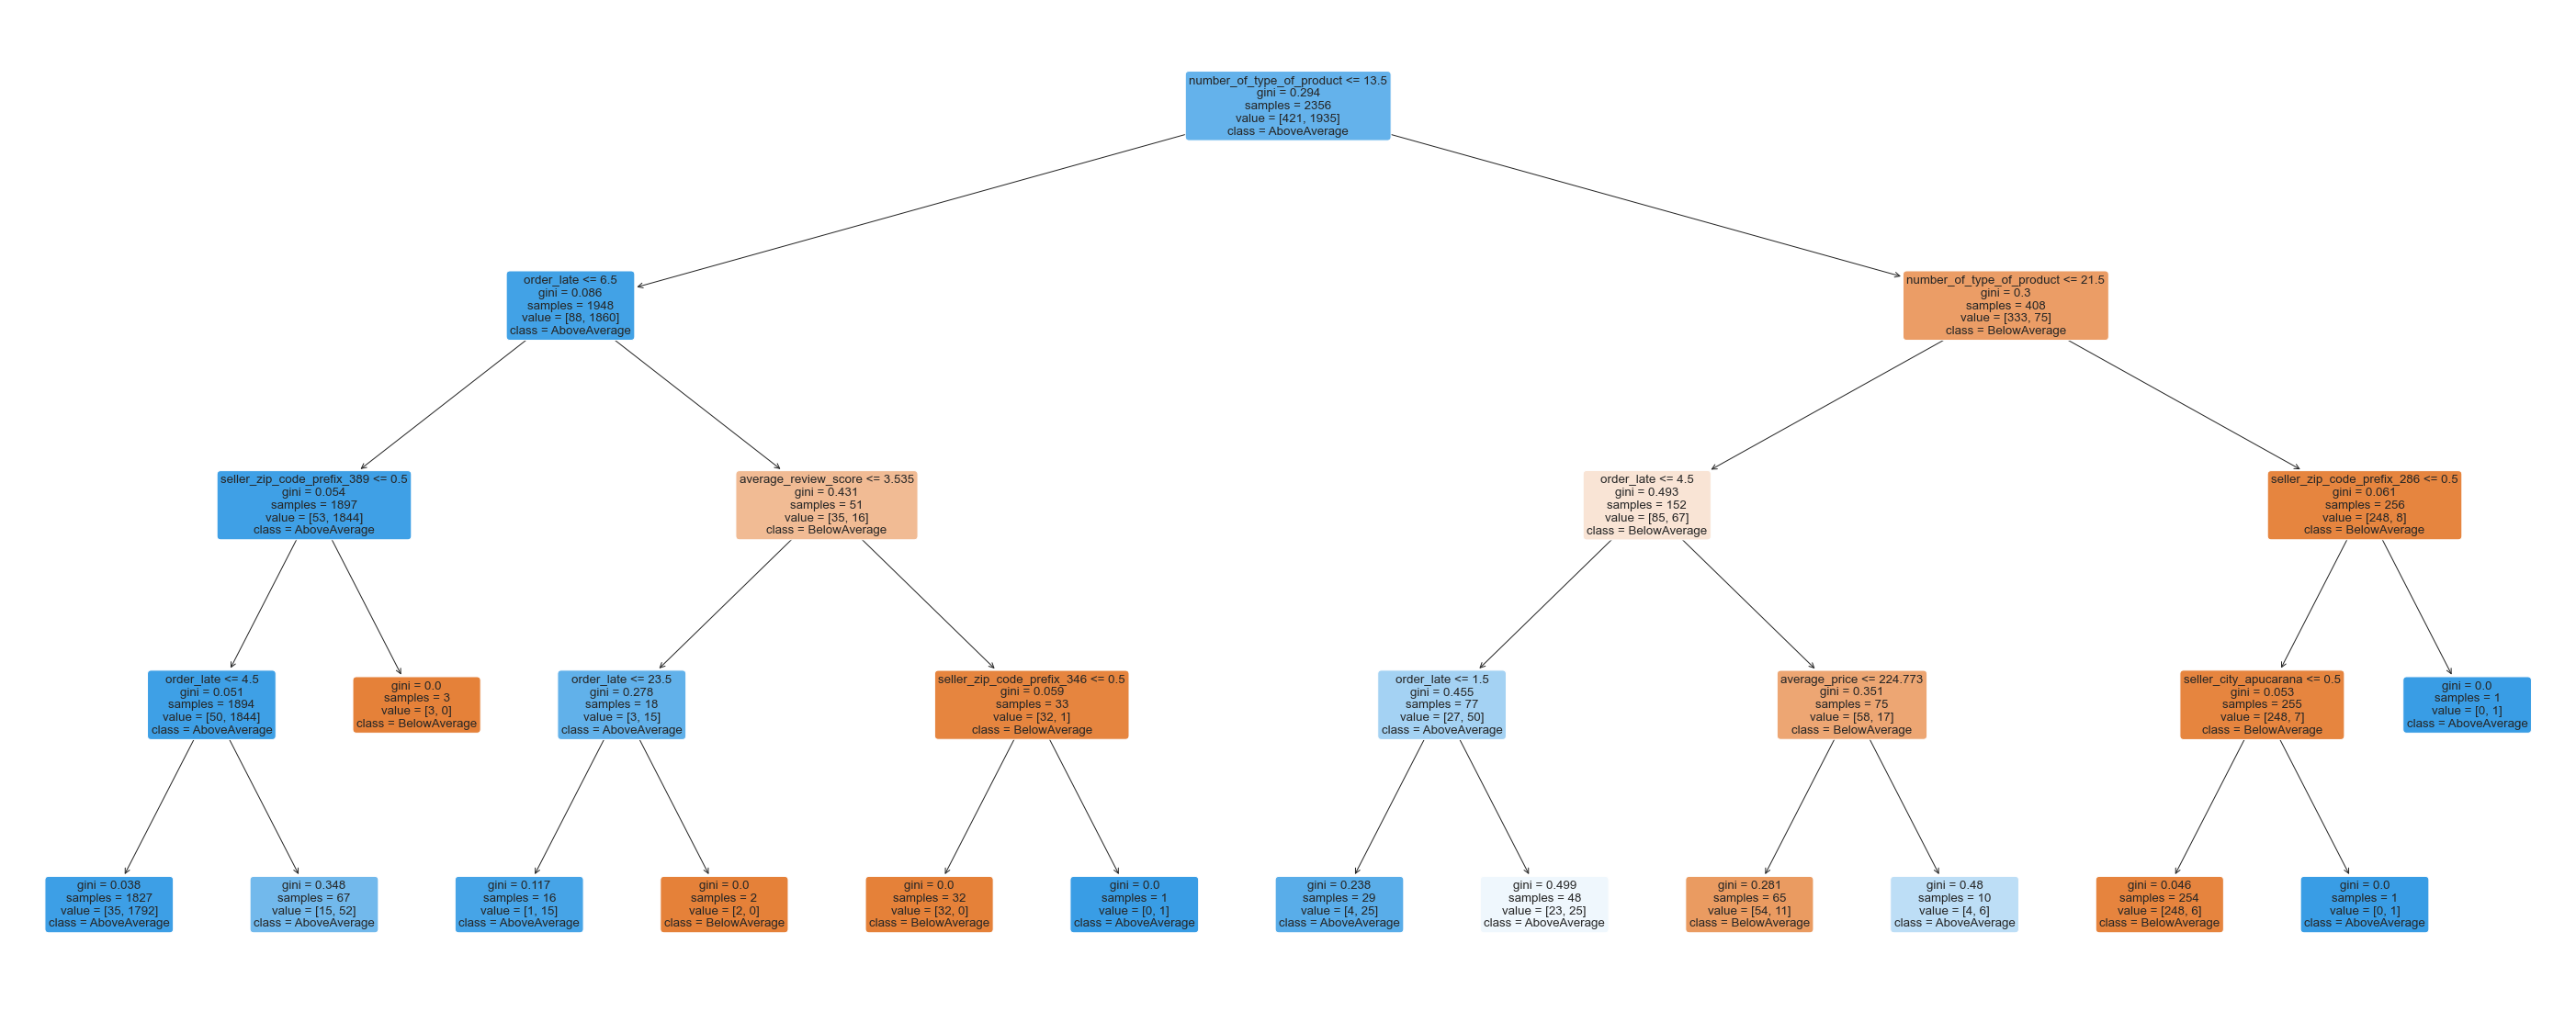

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth = 4)  # change max_depth to experiment
dectree.fit(X_train, y_train)                    # train the decision tree model

# Plot the trained Decision Tree
f = plt.figure(figsize=(50,20))
plot_tree(dectree, filled=True, rounded=True, 
          feature_names=X_train.columns, 
          class_names=["BelowAverage","AboveAverage"])

#### Prediction on Test Data and Goodness of Fit

Check how good the predictions are on the Test Set.    
Metrics : Classification Accuracy and Confusion Matrix.

Train Data
Accuracy  :	 0.9579796264855688

TPR Train :	 0.9912144702842377
TNR Train :	 0.8052256532066508

FPR Train :	 0.19477434679334918
FNR Train :	 0.008785529715762274


<AxesSubplot:>

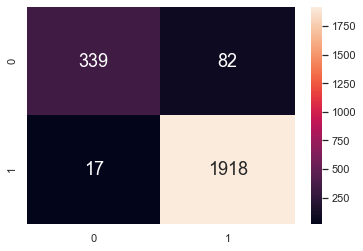

In [59]:
# Predict the Response corresponding to Predictors
y_train_pred = dectree.predict(X_train)

# Print the Classification Accuracy
print("Train Data")
print("Accuracy  :\t", dectree.score(X_train, y_train))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Test Data
Accuracy  :	 0.9415841584158415

TPR Test :	 0.9874529485570891
TNR Test :	 0.7699530516431925

FPR Test :	 0.2300469483568075
FNR Test :	 0.012547051442910916


<AxesSubplot:>

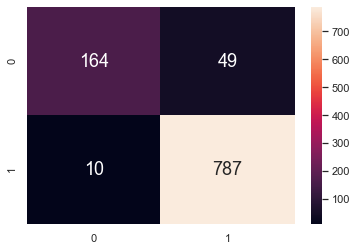

In [60]:
# Predict the Response corresponding to Predictors
y_test_pred = dectree.predict(X_test)

# Print the Classification Accuracy
print("Test Data")
print("Accuracy  :\t", dectree.score(X_test, y_test))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y_test, y_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
print()

print("FPR Test :\t", (fpTest/(fpTest + tnTest)))
print("FNR Test :\t", (fnTest/(fnTest + tpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

### Unsampling

In [61]:
# Upsample Bad to match Good
sellerBelowAverage = seller_review_ohe[seller_review_ohe.number_of_sales == 'BelowAverage']
sellerAboveAverage = seller_review_ohe[seller_review_ohe.number_of_sales == 'AboveAverage']
 
# Upsample the Bad samples
sellerAboveAverage_up = resample(sellerAboveAverage, 
                        replace=True,                     # sample with replacement
                        n_samples=sellerBelowAverage.shape[0])    # to match number of Good
 
# Combine the two classes back after upsampling
seller_review_ohe_up = pd.concat([sellerBelowAverage, sellerAboveAverage_up])
 
# Check the ratio of the classes
seller_review_ohe_up['number_of_sales'].value_counts()

BelowAverage    2732
AboveAverage    2732
Name: number_of_sales, dtype: int64

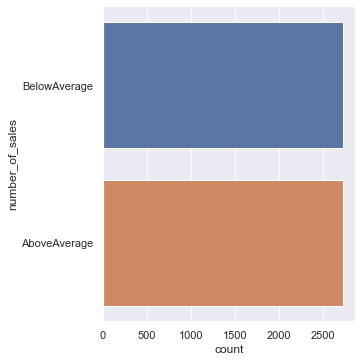

In [62]:
# Quick plot to check the balanced classes visually
sb.catplot(y = 'number_of_sales', data = seller_review_ohe_up, kind = "count")

In [63]:
# Confirm that the OHE is still in place
# and that the samples have now increased
seller_review_ohe_up.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5464 entries, 0 to 2347
Columns: 1372 entries, average_review_score to number_of_sales
dtypes: float64(1367), int64(4), object(1)
memory usage: 57.4+ MB


In [64]:
pd.DataFrame(seller_review_ohe_up)

average_review_score  average_price  average_freight_value  \
0                 3.666667     895.000000              21.020000   
1                 3.666667     137.826667              21.696667   
2                 2.250000     687.000000              55.605000   
3                 3.363636     453.777273              32.756818   
4                 2.500000     361.200000              18.595000   
...                    ...            ...                    ...   
1320              4.139535      77.323256              23.626977   
987               4.123810      65.232286              18.041333   
1357              3.777778     104.066667              16.836667   
488               4.092593      88.813148              15.439074   
2347              4.250000     123.636143              19.301714   

      product_description_length  average_product_photos_qty  \
0                     849.000000                    2.000000   
1                    1127.000000                    1.666667   
2                    1423.000000                    1.000000   
3                    1347.727273                    3.500000   
4                    1437.500000                    1.500000   
...                          ...                         ...   
1320                  442.767442                    1.511628   
987                   691.371429                    1.295238   
1357                 1109.638889                    1.861111   
488                   320.260870                    2.217391   
2347                  644.164286                    1.642857   

      number_of_type_of_product_category  number_of_type_of_product  \
0                                      1                          1   
1                                      2                          3   
2                                      1                          1   
3                                      4                         15   
4                                      2                          2   
...                                  ...                        ...   
1320                                   5                         20   
987                                    3                         62   
1357                                   2                         10   
488                                    5                         14   
2347                                   1                         30   

      seller_time  order_late  number_of_sales_per_seller  ...  \
0             385           0                    6.466667  ...   
1             268           1                    6.466667  ...   
2             355           3                    6.466667  ...   
3             648           7                    6.466667  ...   
4             225           0                    6.466667  ...   
...           ...         ...                         ...  ...   
1320          292           1                    6.235294  ...   
987           478          11                   19.654472  ...   
1357          316           1                   16.337302  ...   
488           348           4                   22.524324  ...   
2347          335           7                   56.709184  ...   

      main_product_signaling_and_security  main_product_small_appliances  \
0                                     0.0                            1.0   
1                                     0.0                            1.0   
2                                     0.0                            1.0   
3                                     0.0                            1.0   
4                                     0.0                            1.0   
...                                   ...                            ...   
1320                                  0.0                            0.0   
987                                   0.0                            0.0   
1357                                  0.0                            0.0   
488           

### Decision Tree with  unsampling

In [65]:
# Extract Response and Predictors
y = pd.DataFrame(seller_review_ohe_up['number_of_sales'])
X = pd.DataFrame(seller_review_ohe_up.drop('number_of_sales', axis = 1))

[Text(1450.8, 978.48, 'number_of_type_of_product <= 10.5\ngini = 0.5\nsamples = 3824\nvalue = [1897, 1927]\nclass = AboveAverage'),
 Text(725.4, 761.0400000000001, 'order_late <= 5.5\ngini = 0.23\nsamples = 2041\nvalue = [270, 1771]\nclass = AboveAverage'),
 Text(446.4, 543.6, 'order_late <= 1.5\ngini = 0.148\nsamples = 1895\nvalue = [153, 1742]\nclass = AboveAverage'),
 Text(223.2, 326.1600000000001, 'seller_city_itapecerica da serra <= 0.5\ngini = 0.057\nsamples = 1463\nvalue = [43, 1420]\nclass = AboveAverage'),
 Text(111.6, 108.72000000000003, 'gini = 0.048\nsamples = 1455\nvalue = [36, 1419]\nclass = AboveAverage'),
 Text(334.79999999999995, 108.72000000000003, 'gini = 0.219\nsamples = 8\nvalue = [7, 1]\nclass = BelowAverage'),
 Text(669.5999999999999, 326.1600000000001, 'seller_time <= 518.0\ngini = 0.38\nsamples = 432\nvalue = [110, 322]\nclass = AboveAverage'),
 Text(558.0, 108.72000000000003, 'gini = 0.22\nsamples = 270\nvalue = [34, 236]\nclass = AboveAverage'),
 Text(781.199

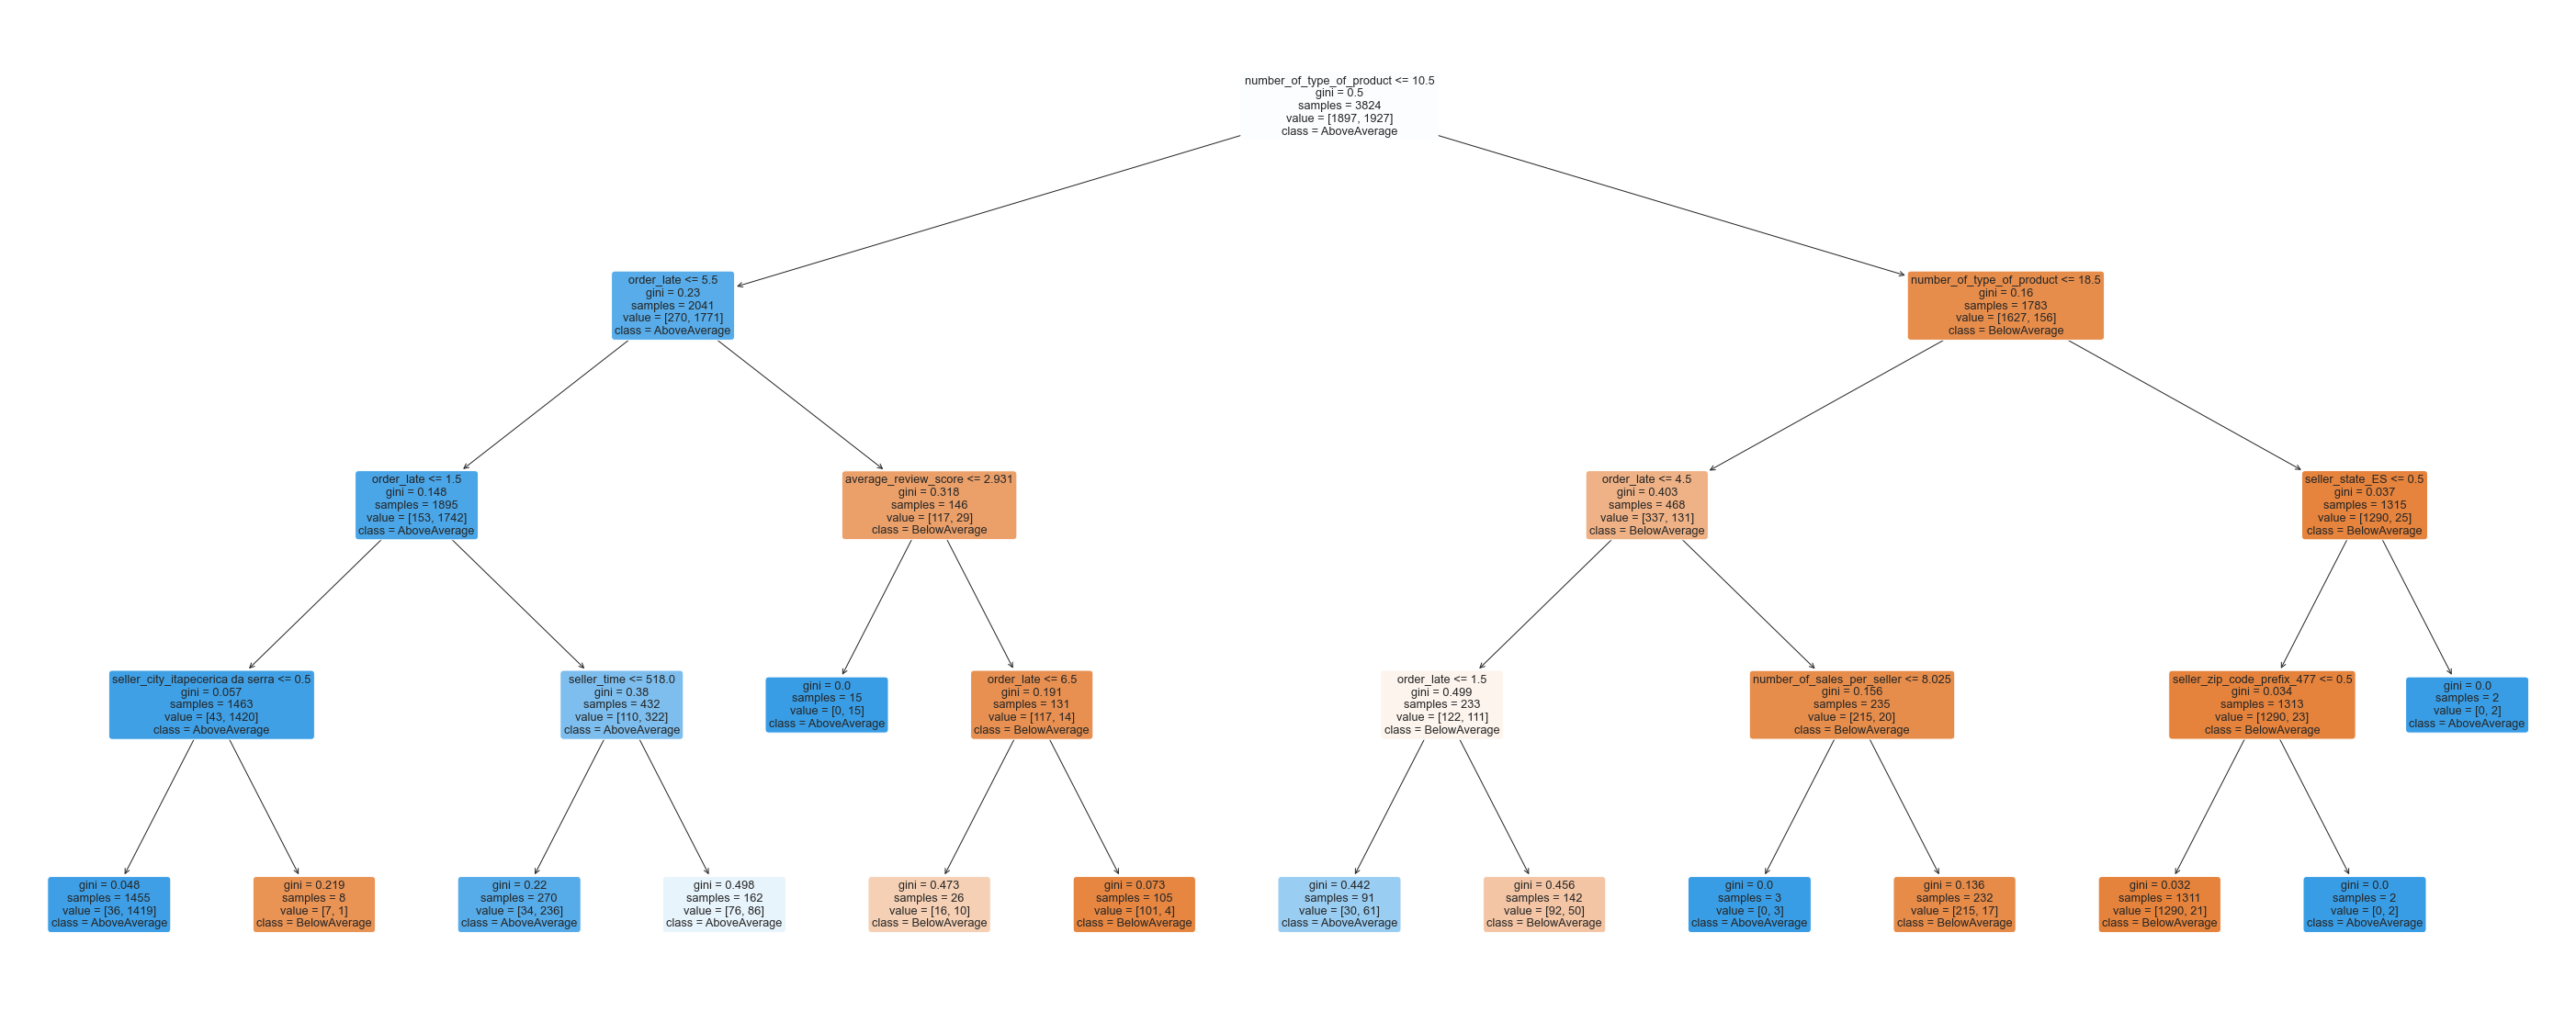

In [66]:
# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth = 4)  # change max_depth to experiment
dectree.fit(X_train, y_train)                    # train the decision tree model

# Plot the trained Decision Tree
f = plt.figure(figsize=(50,20))
plot_tree(dectree, filled=True, rounded=True, 
          feature_names=X_train.columns, 
          class_names=["BelowAverage","AboveAverage"])
#fig.savefig('dt_individualtree.png')

#### Prediction on Test Data and Goodness of Fit

Check how good the predictions are on the Test Set.    
Metrics : Classification Accuracy and Confusion Matrix.

Train Data
Accuracy  :	 0.9270397489539749

TPR Train :	 0.9465490399584847
TNR Train :	 0.9072219293621507

FPR Train :	 0.09277807063784924
FNR Train :	 0.05345096004151531


<AxesSubplot:>

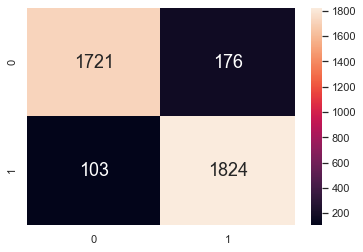

In [67]:
# Predict the Response corresponding to Predictors
y_train_pred = dectree.predict(X_train)

# Print the Classification Accuracy
print("Train Data")
print("Accuracy  :\t", dectree.score(X_train, y_train))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Test Data
Accuracy  :	 0.925

TPR Test :	 0.9490683229813665
TNR Test :	 0.9017964071856287

FPR Test :	 0.09820359281437126
FNR Test :	 0.05093167701863354


<AxesSubplot:>

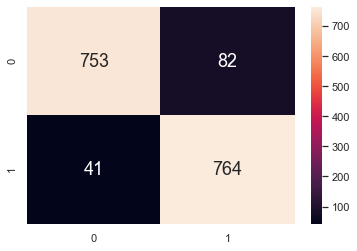

In [68]:
# Predict the Response corresponding to Predictors
y_test_pred = dectree.predict(X_test)

# Print the Classification Accuracy
print("Test Data")
print("Accuracy  :\t", dectree.score(X_test, y_test))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y_test, y_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
print()

print("FPR Test :\t", (fpTest/(fpTest + tnTest)))
print("FNR Test :\t", (fnTest/(fnTest + tpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

#### Even though the data accuracy drop by a small amount, the unsampling data is better as it results in a more balanced prediction

### Random Forest with unsampling

In [69]:
# Extract Response and Predictors
y = pd.DataFrame(seller_review_ohe_up['number_of_sales'])
X = pd.DataFrame(seller_review_ohe_up.drop('number_of_sales', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [70]:
# Create the Random Forest object
rforest = RandomForestClassifier(n_estimators = 10,  # n_estimators denote number of trees
                                 max_depth = 4)       # set the maximum depth of each tree

# Fit Random Forest on Train Data
rforest.fit(X_train, y_train.number_of_sales.ravel())

RandomForestClassifier(max_depth=4, n_estimators=10)

#### Prediction on Test Data and Goodness of Fit

Check how good the predictions are on the Test Set.    
Metrics : Classification Accuracy and Confusion Matrix.

Train Data
Accuracy  :	 0.9137029288702929

TPR Train :	 0.9007957559681697
TNR Train :	 0.926250644662197

FPR Train :	 0.073749355337803
FNR Train :	 0.09920424403183024


<AxesSubplot:>

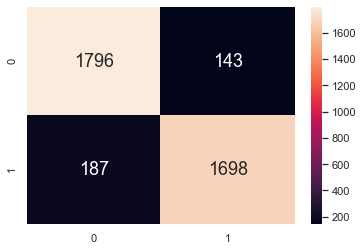

In [71]:
# Predict the Response corresponding to Predictors
y_train_pred = rforest.predict(X_train)

# Print the Classification Accuracy
print("Train Data")
print("Accuracy  :\t", rforest.score(X_train, y_train))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Test Data
Accuracy  :	 0.901219512195122

TPR Test :	 0.8890200708382526
TNR Test :	 0.914249684741488

FPR Test :	 0.08575031525851198
FNR Test :	 0.11097992916174734


<AxesSubplot:>

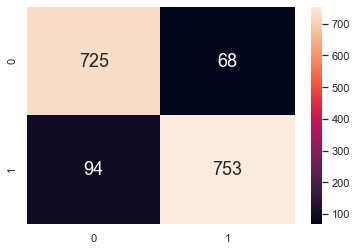

In [72]:
# Predict the Response corresponding to Predictors
y_test_pred = rforest.predict(X_test)

# Print the Classification Accuracy
print("Test Data")
print("Accuracy  :\t", rforest.score(X_test, y_test))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y_test, y_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
print()

print("FPR Test :\t", (fpTest/(fpTest + tnTest)))
print("FNR Test :\t", (fnTest/(fnTest + tpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

In [73]:
# Extract single tree
estimator = rforest.estimators_[5]

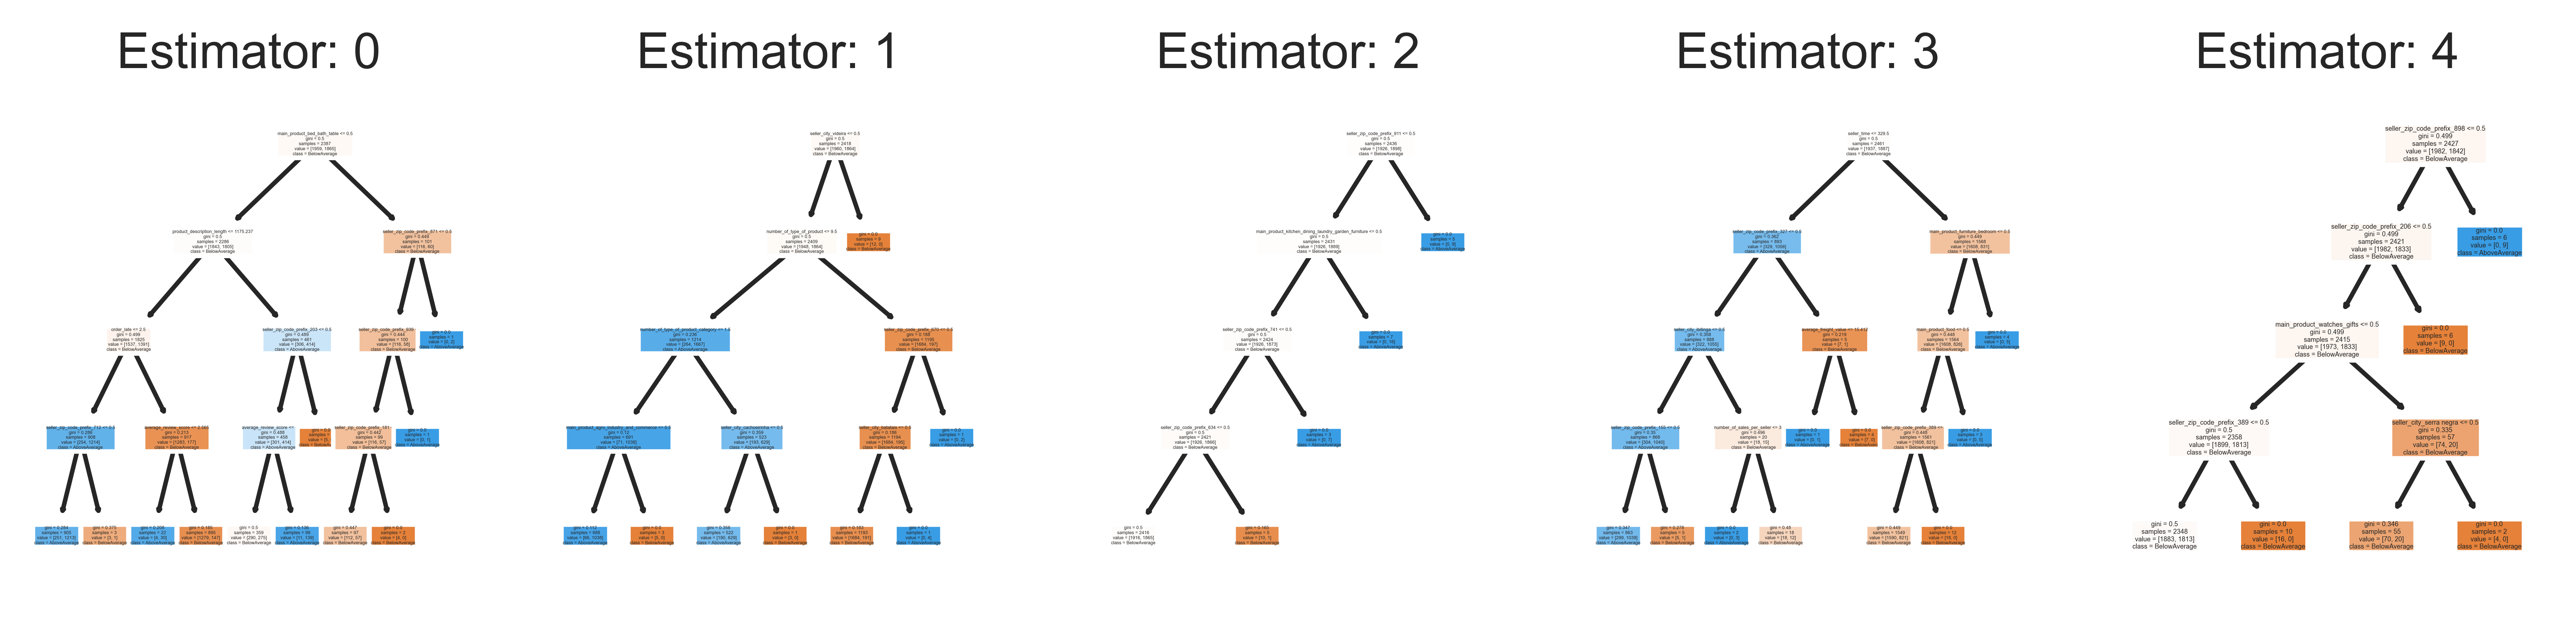

In [74]:
fig, axes = plt.subplots(nrows = 1,ncols = 5,figsize = (10,2), dpi=900)
for index in range(0, 5):
    plot_tree(rforest[index],
                   feature_names=X_train.columns, 
          class_names=["BelowAverage","AboveAverage"],
                   filled = True,
                   ax = axes[index]);

    axes[index].set_title('Estimator: ' + str(index), fontsize = 11)
fig.savefig('rf_5trees.png')

### Feature importances

In [75]:
print(rforest.feature_importances_)
list_ohe = [x for x in seller_review_ohe]
list_importance = rforest.feature_importances_
for i in range(len(list_importance)):
    if list_importance[i] != 0.0:
        print("{} : {}".format(list_ohe[i],list_importance[i]))

[0.01020994 0.07157466 0.07935039 ... 0.         0.         0.04495783]
average_review_score : 0.010209937667694787
average_price : 0.07157466235445728
average_freight_value : 0.07935039064033374
product_description_length : 0.00136686508240925
average_product_photos_qty : 0.01925842849115349
number_of_type_of_product_category : 0.002924474243488464
number_of_type_of_product : 0.11377431511185958
seller_time : 0.09020178597772115
order_late : 0.1605999979305135
number_of_sales_per_seller : 0.021840638468517387
seller_zip_code_prefix_155 : 0.001275425290736697
seller_zip_code_prefix_158 : 0.022951385037083993
seller_zip_code_prefix_176 : 2.734922534800092e-06
seller_zip_code_prefix_181 : 0.0001052803466477572
seller_zip_code_prefix_203 : 0.00039427801339120196
seller_zip_code_prefix_206 : 0.013440841517779694
seller_zip_code_prefix_211 : 0.0148468596286313
seller_zip_code_prefix_212 : 0.02617173429793323
seller_zip_code_prefix_326 : 0.031705176376584696
seller_zip_code_prefix_327 : 0.00

In [76]:
seller_review.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3366 entries, 0 to 3365
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   seller_id                           3366 non-null   object 
 1   average_review_score                3366 non-null   float64
 2   average_price                       3366 non-null   float64
 3   average_freight_value               3366 non-null   float64
 4   product_description_length          3366 non-null   float64
 5   average_product_photos_qty          3366 non-null   float64
 6   number_of_sales                     3366 non-null   object 
 7   number_of_type_of_product_category  3366 non-null   int64  
 8   number_of_type_of_product           3366 non-null   int64  
 9   seller_zip_code_prefix              3366 non-null   object 
 10  seller_city                         3366 non-null   object 
 11  seller_state                        3366 no

# Drop categorical variables and numerical variables

In [77]:
ohe = OneHotEncoder()

# OneHotEncoding of categorical predictors (not the response)
seller_review_cat = seller_review[["main_product"]]

ohe.fit(seller_review_cat)
seller_review_cat_ohe = pd.DataFrame(ohe.transform(seller_review_cat).toarray(), 
                                  columns=ohe.get_feature_names(seller_review_cat.columns))
# Check the encoded variables
seller_review_cat_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3366 entries, 0 to 3365
Data columns (total 68 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   main_product_agro_industry_and_commerce               3366 non-null   float64
 1   main_product_air_conditioning                         3366 non-null   float64
 2   main_product_art                                      3366 non-null   float64
 3   main_product_arts_and_craftmanship                    3366 non-null   float64
 4   main_product_audio                                    3366 non-null   float64
 5   main_product_auto                                     3366 non-null   float64
 6   main_product_baby                                     3366 non-null   float64
 7   main_product_bed_bath_table                           3366 non-null   float64
 8   main_product_books_general_interest                   3366

In [78]:
#as part of data preparation, we can see that there is a typo in average_product_description_lenght so we need to change it
seller_review=seller_review.rename(columns = {'average_product_description_lenght':'average_product_description_length'})

#as part of data preparation, we can see that there is a typo in product_description_lenght so we need to change it
seller_review=seller_review.rename(columns = {'product_description_lenght':'product_description_length'})

#we can see the updated spelling now
seller_review

seller_id  average_review_score  average_price  \
0     0015a82c2db000af6aaaf3ae2ecb0532              3.666667     895.000000   
1     042573af89b6d931f672efaf789d8358              3.666667     137.826667   
2     052577151711aec5c744fe12e66db3e1              2.250000     687.000000   
3     054694fa03fe82cec4b7551487331d74              3.363636     453.777273   
4     07d75e33f2750d97d467fb57e4dfdd8a              2.500000     361.200000   
...                                ...                   ...            ...   
3361  491a5ada3aa1678414e990262c4bbdc1              3.000000    1420.000000   
3362  75fbb52eda0cbc24f479d3b2fbfa8d3e              4.325581      26.302093   
3363  7c5b05cbdb5542049f38d90d7815b97d              4.416667      43.290000   
3364  bc2ac6b95e1accce9858528ee566c17e              4.636364      92.954545   
3365  c731d18cea9bf687ffee82a241c25b11              3.846154     140.846154   

      average_freight_value  product_description_length  \
0                 21.020000                  849.000000   
1                 21.696667                 1127.000000   
2                 55.605000                 1423.000000   
3                 32.756818                 1347.727273   
4                 18.595000                 1437.500000   
...                     ...                         ...   
3361              16.905000                 3992.000000   
3362              21.942326                  884.697674   
3363              12.770833                  356.541667   
3364              10.661818                  315.772727   
3365              23.486538                  408.884615   

      average_product_photos_qty number_of_sales  \
0                       2.000000    BelowAverage   
1                       1.666667    BelowAverage   
2                       1.000000    BelowAverage   
3                       3.500000    BelowAverage   
4                       1.500000    BelowAverage   
...                          ...             ...   
3361                    1.000000    BelowAverage   
3362                    1.186047    AboveAverage   
3363                    1.041667    BelowAverage   
3364                    1.000000    BelowAverage   
3365                    1.230769    BelowAverage   

      number_of_type_of_product_category  number_of_type_of_product  \
0                                      1                          1   
1                                      2                          3   
2                                      1                          1   
3                                      4                         15   
4                                      2                          2   
...                                  ...                        ...   
3361                                   1                          1   
3362                                   1                         37   
3363                                   1                         10   
3364                                   1                         14   
3365                                   5                         18   

     seller_zip_code_prefix  seller_city seller_state      main_product  \
0                       908  santo andre           SP  small_appliances   
1                       180     sorocaba           SP  small_appliances   
2                       891       rodeio           SC  small_appliances   
3                       158      itajobi           SP  small_appliances   
4                       211    sao paulo           SP  small_appliances   
...                     ...          ...          ...               ...   
3361                    420    sao paulo           SP      dvds_blu_ray   
3362                    745      goiania           GO      dvds_blu_ray   
3363                    520    sao paulo           SP    books_imported   
3364                    130     campinas           SP    books_imported   
3365                    897    concordia           SC        la_cuis

In [79]:
# Combining Numeric features with the OHE Categorical features
seller_review_num = seller_review.drop(columns = ["seller_zip_code_prefix", "seller_city", "seller_state","number_of_sales","seller_id","main_product","average_price", "average_freight_value", "product_description_length", "average_product_photos_qty", "number_of_type_of_product_category"])
seller_review_res = seller_review['number_of_sales']
seller_review_ohe = pd.concat([seller_review_num, seller_review_cat_ohe, seller_review_res], 
                           sort = False, axis = 1).reindex(index=seller_review_num.index)

# Check the final dataframe
seller_review_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3366 entries, 0 to 3365
Data columns (total 74 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   average_review_score                                  3366 non-null   float64
 1   number_of_type_of_product                             3366 non-null   int64  
 2   seller_time                                           3366 non-null   int64  
 3   order_late                                            3366 non-null   int64  
 4   number_of_sales_per_seller                            3366 non-null   float64
 5   main_product_agro_industry_and_commerce               3366 non-null   float64
 6   main_product_air_conditioning                         3366 non-null   float64
 7   main_product_art                                      3366 non-null   float64
 8   main_product_arts_and_craftmanship                    3366

In [80]:
# Upsample Bad to match Good
sellerBelowAverage = seller_review_ohe[seller_review_ohe.number_of_sales == 'BelowAverage']
sellerAboveAverage = seller_review_ohe[seller_review_ohe.number_of_sales == 'AboveAverage']
 
# Upsample the Bad samples
sellerAboveAverage_up = resample(sellerAboveAverage, 
                        replace=True,                     # sample with replacement
                        n_samples=sellerBelowAverage.shape[0])    # to match number of Good
 
# Combine the two classes back after upsampling
seller_review_ohe_up = pd.concat([sellerBelowAverage, sellerAboveAverage_up])
 
# Check the ratio of the classes
seller_review_ohe_up['number_of_sales'].value_counts()

BelowAverage    2732
AboveAverage    2732
Name: number_of_sales, dtype: int64

In [81]:
# Extract Response and Predictors
y = pd.DataFrame(seller_review_ohe_up['number_of_sales'])
X = pd.DataFrame(seller_review_ohe_up.drop('number_of_sales', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [82]:
# Create the Random Forest object
rforest = RandomForestClassifier(n_estimators = 10,  # n_estimators denote number of trees
                                 max_depth = 4)       # set the maximum depth of each tree

# Fit Random Forest on Train Data
rforest.fit(X_train, y_train.number_of_sales.ravel())

RandomForestClassifier(max_depth=4, n_estimators=10)

#### Prediction on Test Data and Goodness of Fit

Check how good the predictions are on the Test Set.    
Metrics : Classification Accuracy and Confusion Matrix.

Train Data
Accuracy  :	 0.9063807531380753

TPR Train :	 0.9101703665462054
TNR Train :	 0.9024907260201378

FPR Train :	 0.09750927397986221
FNR Train :	 0.08982963345379452


<AxesSubplot:>

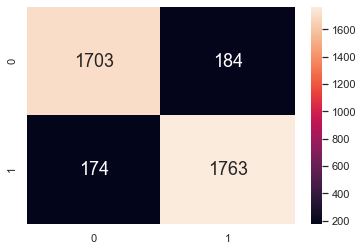

In [83]:
# Predict the Response corresponding to Predictors
y_train_pred = rforest.predict(X_train)

# Print the Classification Accuracy
print("Train Data")
print("Accuracy  :\t", rforest.score(X_train, y_train))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Test Data
Accuracy  :	 0.9036585365853659

TPR Test :	 0.9031446540880503
TNR Test :	 0.9041420118343195

FPR Test :	 0.09585798816568047
FNR Test :	 0.09685534591194969


<AxesSubplot:>

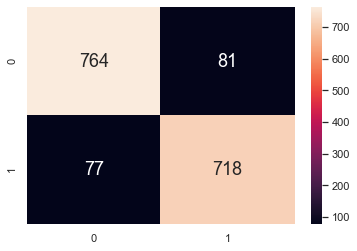

In [84]:
# Predict the Response corresponding to Predictors
y_test_pred = rforest.predict(X_test)

# Print the Classification Accuracy
print("Test Data")
print("Accuracy  :\t", rforest.score(X_test, y_test))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y_test, y_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
print()

print("FPR Test :\t", (fpTest/(fpTest + tnTest)))
print("FNR Test :\t", (fnTest/(fnTest + tpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

### Feature importances

In [85]:
print(rforest.feature_importances_)
list_ohe = [x for x in seller_review_ohe_up]
list_importance = rforest.feature_importances_
for i in range(len(list_importance)):
    if list_importance[i] != 0.0:
        print("{} : {}".format(list_ohe[i],list_importance[i]))

[1.26014220e-01 1.76933875e-01 2.55793129e-01 2.94161532e-01
 1.60791843e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.88020235e-02 3.33389032e-05
 2.14178537e-03 2.52090590e-02 0.00000000e+00 1.65731680e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.05407919e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 7.08550255e-03 0.00000000e+00 0.00000000e+00 1.24870241e-03
 0.00000000e+00 0.00000000e+00 8.40154653e-03 0.00000000e+00
 2.38255392e-04 4.56106578e-04 0.00000000e+00 0.00000000e+00
 3.40836996e-04 2.55442052e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 9.52228889e-03 9.11314285e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 8.39799655e-07
 0.00000000e+00 0.00000000e+00 5.96809734e-03 0.00000000e+00
 2.43490569e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.12807321e-04 0.00000000e+00 9.88426413e-04 0.00000000e+00
 1.51904175e-03 1.937771

## Remove Outliers

#### As original dataset was altered above, it is easier to import the CSVs again

In [86]:
customers = pd.read_csv("olist_customers_dataset.csv")

order_items = pd.read_csv("olist_order_items_dataset.csv")

order_payment = pd.read_csv("olist_order_payments_dataset.csv")

review = pd.read_csv("olist_order_reviews_dataset.csv")

orders = pd.read_csv("olist_orders_dataset.csv")

products = pd.read_csv("olist_products_dataset.csv")

seller = pd.read_csv("olist_sellers_dataset.csv")

products_translation = pd.read_csv("product_category_name_translation.csv")


In [87]:
competition = products.merge(order_items, on = 'product_id')
competition = competition.merge(products_translation)
number_of_sales_cat = competition.groupby('product_category_name_english').count()
number_of_sales_cat = number_of_sales_cat[['product_id']]
number_of_sales_cat = number_of_sales_cat.rename(columns = {'product_id':'number_of_sales'})
number_of_sales_cat = number_of_sales_cat.sort_values('number_of_sales')
competition = competition.groupby(['seller_id', 'product_category_name_english']).agg({'price':'mean'})
competition = competition.groupby('product_category_name_english').count()
competition = competition.rename(columns = {'price':'number_of_seller'})
competition = competition.sort_values('number_of_seller')
seller_order = seller.merge(order_items)
seller_order = seller_order.merge(products)

products = pd.read_csv("olist_products_dataset.csv")
seller_order = seller_order.merge(review)
seller_review = seller_order[["seller_id", "review_score","freight_value","price","product_description_lenght","product_photos_qty"]]
seller_review['number_of_sales'] = seller_review['review_score']
seller_copy = seller_review
seller_review = seller_review.groupby('seller_id').agg({'review_score':'mean', 'price':'mean', 'freight_value':'mean', 'product_description_lenght':'mean','product_photos_qty':'mean'})
seller_copy = seller_copy.groupby('seller_id').count()
seller_review['number_of_sales'] = seller_copy['number_of_sales']
type_of_product_seller_sells = products.merge(order_items, on = 'product_id')
type_of_product_seller_sells = type_of_product_seller_sells.groupby(['seller_id', 'product_category_name']).agg({'price':'mean'})
type_of_product_seller_sells = type_of_product_seller_sells.groupby('seller_id').count()
type_of_product_seller_sells = type_of_product_seller_sells.rename(columns = {'price':'number_of_type_of_product_category'})
seller_review = seller_review.merge(type_of_product_seller_sells, on = 'seller_id')
type_of_product_seller_sells = products.merge(order_items, on = 'product_id')
type_of_product_seller_sells = type_of_product_seller_sells.groupby(['seller_id', 'product_id']).agg({'price':'mean'})
type_of_product_seller_sells = type_of_product_seller_sells.groupby('seller_id').count()
type_of_product_seller_sells = type_of_product_seller_sells.rename(columns = {'price':'number_of_type_of_product'})
seller_review = seller_review.merge(type_of_product_seller_sells, on = 'seller_id')
seller_review = seller_review.rename(columns = {'price':'average_price', 'freight_value':'average_freight_value', 'product_description_lenght':'average_product_description_lenght','review_score':'average_review_score','product_photos_qty':'average_product_photos_qty'})
seller_review = seller_review.merge(seller, on = 'seller_id')
type_of_product_seller_mainly_sells = products.merge(order_items, on = 'product_id')
type_of_product_seller_mainly_sells = type_of_product_seller_mainly_sells.groupby(['seller_id', 'product_category_name', 'product_id']).agg({'price':'mean'})
type_of_product_seller_mainly_sells = type_of_product_seller_mainly_sells.groupby(['seller_id','product_category_name']).count()
type_of_product_seller_mainly_sells = type_of_product_seller_mainly_sells.groupby(['seller_id', 'product_category_name']).agg({'price':'max'})
type_of_product_seller_mainly_sells_copy = type_of_product_seller_mainly_sells.groupby(['seller_id']).agg({'price':'max'})
type_of_product_seller_mainly_sells = type_of_product_seller_mainly_sells.reset_index()
type_of_product_seller_mainly_sells = type_of_product_seller_mainly_sells.merge(type_of_product_seller_mainly_sells_copy, on = ['seller_id','price'])
type_of_product_seller_mainly_sells = type_of_product_seller_mainly_sells.drop('price', axis = 1)
seller_review = seller_review.merge(type_of_product_seller_mainly_sells, on = 'seller_id')
seller_review = seller_review.merge(products_translation)
seller_review = seller_review.drop('product_category_name', axis = 1)
seller_review = seller_review.rename(columns = {'price':'average_price', 'freight_value':'average_freight_value', 'product_description_lenght':'average_product_description_lenght','review_score':'average_review_score','product_photos_qty':'average_product_photos_qty','product_category_name_english':'main_product'})
last_data_date = pd.to_datetime(max(orders['order_purchase_timestamp']))
zero = last_data_date - last_data_date
orders_copy = orders.merge(order_items, on = 'order_id')
orders_late = orders_copy['order_item_id']
orders_est = orders_copy['order_estimated_delivery_date']
orders_deliver = orders_copy['order_delivered_customer_date']
for i in range(0,len(orders_copy)):
    if((pd.to_datetime(orders_est[i]) - pd.to_datetime(orders_deliver[i])) > zero):
        orders_late[i] = 0
    else:
        orders_late[i] = 1
orders_copy = orders_copy.groupby("seller_id").agg({"order_purchase_timestamp":"min","order_item_id":"sum"})
seller_time = orders_copy['order_purchase_timestamp']
for i in range(0,len(orders_copy)):
    seller_time[i] = (last_data_date - pd.to_datetime(seller_time[i])).days  
orders_copy = orders_copy.rename(columns = {'order_purchase_timestamp':'seller_time','order_item_id':'order_late'})
orders_copy.head()
seller_review = seller_review.merge(orders_copy, on = 'seller_id')
seller_review.head(10000)



<ipython-input-87-68ba946f77d9>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seller_review['number_of_sales'] = seller_review['review_score']
<ipython-input-87-68ba946f77d9>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_late[i] = 0
<ipython-input-87-68ba946f77d9>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_late[i] = 1
<ipython-input-87-68ba946f77d9>:6

seller_id  average_review_score  average_price  \
0     0015a82c2db000af6aaaf3ae2ecb0532              3.666667     895.000000   
1     042573af89b6d931f672efaf789d8358              3.666667     137.826667   
2     052577151711aec5c744fe12e66db3e1              2.250000     687.000000   
3     054694fa03fe82cec4b7551487331d74              3.363636     453.777273   
4     054694fa03fe82cec4b7551487331d74              3.363636     453.777273   
...                                ...                   ...            ...   
3361  e00d85ce20ea50c1224c66ca5050527d              4.000000     149.000000   
3362  7c5b05cbdb5542049f38d90d7815b97d              4.416667      43.290000   
3363  bc2ac6b95e1accce9858528ee566c17e              4.636364      92.954545   
3364  c731d18cea9bf687ffee82a241c25b11              3.846154     140.846154   
3365  d7f1cfc638473be93baedbfd02208016              5.000000      30.000000   

      average_freight_value  average_product_description_lenght  \
0                 21.020000                          849.000000   
1                 21.696667                         1127.000000   
2                 55.605000                         1423.000000   
3                 32.756818                         1347.727273   
4                 32.756818                         1347.727273   
...                     ...                                 ...   
3361               8.300000                         1138.000000   
3362              12.770833                          356.541667   
3363              10.661818                          315.772727   
3364              23.486538                          408.884615   
3365              17.140000                         1650.000000   

      average_product_photos_qty  number_of_sales  \
0                       2.000000                3   
1                       1.666667                3   
2                       1.000000                4   
3                       3.500000               22   
4                       3.500000               22   
...                          ...              ...   
3361                    3.000000                1   
3362                    1.041667               24   
3363                    1.000000               22   
3364                    1.230769               26   
3365                    3.000000                1   

      number_of_type_of_product_category  number_of_type_of_product  \
0                                      1                          1   
1                                      2                          3   
2                                      1                          1   
3                                      4                         15   
4                                      4                         15   
...                                  ...                        ...   
3361                                   1                          1   
3362                                   1                         10   
3363                                   1                         14   
3364                                   5                         18   
3365                                   1                          1   

      seller_zip_code_prefix   seller_city seller_state      main_product  \
0                       9080   santo andre           SP  small_appliances   
1                      18015      sorocaba           SP  small_appliances   
2                      89136        rodeio           SC  small_appliances   
3                      15840       itajobi           SP  small_appliances   
4                      15840       itajobi           SP        cool_stuff   
...                      ...           ...          ...               ...   
3361                    6286        osasco           SP             audio   
3362                    5201     sao paulo           SP    books_imported   
3363                   13085      campinas           SP    books_imported   
3364           

In [88]:
seller_review = seller_review.astype({"seller_zip_code_prefix" : "string", "seller_time" : "int64"})
seller_review["seller_zip_code_prefix"] = seller_review["seller_zip_code_prefix"].str[0:3]

In [89]:
#total number of sales per seller is less than 20
lessthan20 = seller_review[seller_review["number_of_sales"] < 20].index.values
seller_review_lessthan20 = seller_review.iloc[lessthan20]

#total number of sales per seller is less than 5 AND seller is in the market for more than a year
outlier = seller_review_lessthan20[seller_review_lessthan20["seller_time"] > 365].index.values
seller_review_outlier = seller_review.iloc[outlier]
seller_review_outlier


seller_id  average_review_score  average_price  \
0     0015a82c2db000af6aaaf3ae2ecb0532              3.666667     895.000000   
11    2f4b9d112bfa44a214bc6cef085d17c8              4.333333      48.998333   
12    2f4b9d112bfa44a214bc6cef085d17c8              4.333333      48.998333   
13    2f4b9d112bfa44a214bc6cef085d17c8              4.333333      48.998333   
14    2fb25ab44bdbeae6a4d816e0d0c9d500              4.800000     136.616000   
...                                ...                   ...            ...   
3351  a00824eb9093d40e589b940ec45c4eb0              4.666667    3133.323333   
3356  491a5ada3aa1678414e990262c4bbdc1              3.000000    1420.000000   
3359  89c127985a8b130cfa45c1d36764017a              3.142857     202.795714   
3360  5f0057b677eb963672bf05dfa3f16c34              4.200000      62.576000   
3361  e00d85ce20ea50c1224c66ca5050527d              4.000000     149.000000   

      average_freight_value  average_product_description_lenght  \
0                 21.020000                          849.000000   
11                19.878333                          453.833333   
12                19.878333                          453.833333   
13                19.878333                          453.833333   
14                15.642000                         1357.200000   
...                     ...                                 ...   
3351             126.496667                         2009.000000   
3356              16.905000                         3992.000000   
3359              17.232857                          882.571429   
3360              13.402000                          589.400000   
3361               8.300000                         1138.000000   

      average_product_photos_qty  number_of_sales  \
0                       2.000000                3   
11                      2.666667                6   
12                      2.666667                6   
13                      2.666667                6   
14                      2.600000                5   
...                          ...              ...   
3351                    2.000000                3   
3356                    1.000000                2   
3359                    1.285714                7   
3360                    4.800000                5   
3361                    3.000000                1   

      number_of_type_of_product_category  number_of_type_of_product  \
0                                      1                          1   
11                                     3                          3   
12                                     3                          3   
13                                     3                          3   
14                                     2                          2   
...                                  ...                        ...   
3351                                   1                          1   
3356                                   1                          1   
3359                                   5                          6   
3360                                   3                          5   
3361                                   1                          1   

     seller_zip_code_prefix     seller_city seller_state  \
0                       908     santo andre           SP   
11                      296  afonso claudio           ES   
12                      296  afonso claudio           ES   
13                      296  afonso claudio           ES   
14                      272   volta redonda           RJ   
...                     ...             ...          ...   
3351                    185          bofete           SP   
3356                    420       sao paulo           SP   
3359                    601          osasco           SP   
3360                    130       sao paulo           SP   
3361                    628          osasco           SP   

                               main_product  seller_time  order_

In [90]:
seller_review_outlier[["number_of_sales","seller_time"]]

number_of_sales  seller_time
0                   3          385
11                  6          740
12                  6          740
13                  6          740
14                  5          425
...               ...          ...
3351                3          376
3356                2          589
3359                7          474
3360                5          739
3361                1          461

[912 rows x 2 columns]

In [91]:
#drop the outlier
seller_review = seller_review.drop(outlier,inplace = False)

In [92]:
#adjust the index
seller_review.index  = range(len(seller_review))
seller_review

seller_id  average_review_score  average_price  \
0     042573af89b6d931f672efaf789d8358              3.666667     137.826667   
1     052577151711aec5c744fe12e66db3e1              2.250000     687.000000   
2     054694fa03fe82cec4b7551487331d74              3.363636     453.777273   
3     054694fa03fe82cec4b7551487331d74              3.363636     453.777273   
4     07d75e33f2750d97d467fb57e4dfdd8a              2.500000     361.200000   
...                                ...                   ...            ...   
2449  88cf19ec1fc2c58f161aee259d57142c              4.466667     100.530667   
2450  7c5b05cbdb5542049f38d90d7815b97d              4.416667      43.290000   
2451  bc2ac6b95e1accce9858528ee566c17e              4.636364      92.954545   
2452  c731d18cea9bf687ffee82a241c25b11              3.846154     140.846154   
2453  d7f1cfc638473be93baedbfd02208016              5.000000      30.000000   

      average_freight_value  average_product_description_lenght  \
0                 21.696667                         1127.000000   
1                 55.605000                         1423.000000   
2                 32.756818                         1347.727273   
3                 32.756818                         1347.727273   
4                 18.595000                         1437.500000   
...                     ...                                 ...   
2449              16.554667                          901.933333   
2450              12.770833                          356.541667   
2451              10.661818                          315.772727   
2452              23.486538                          408.884615   
2453              17.140000                         1650.000000   

      average_product_photos_qty  number_of_sales  \
0                       1.666667                3   
1                       1.000000                4   
2                       3.500000               22   
3                       3.500000               22   
4                       1.500000                2   
...                          ...              ...   
2449                    1.400000               15   
2450                    1.041667               24   
2451                    1.000000               22   
2452                    1.230769               26   
2453                    3.000000                1   

      number_of_type_of_product_category  number_of_type_of_product  \
0                                      2                          3   
1                                      1                          1   
2                                      4                         15   
3                                      4                         15   
4                                      2                          2   
...                                  ...                        ...   
2449                                   3                         11   
2450                                   1                         10   
2451                                   1                         14   
2452                                   5                         18   
2453                                   1                          1   

     seller_zip_code_prefix   seller_city seller_state  \
0                       180      sorocaba           SP   
1                       891        rodeio           SC   
2                       158       itajobi           SP   
3                       158       itajobi           SP   
4                       211     sao paulo           SP   
...                     ...           ...          ...   
2449                    135    sao carlos           SP   
2450                    520     sao paulo           SP   
2451                    130      campinas           SP   
2452                    897     concordia           SC   
2453                    261  belford roxo           RJ   

                               main_product  seller_time  order_late  
0                

In [93]:
seller_review.describe()

average_review_score  average_price  average_freight_value  \
count           2454.000000    2454.000000            2454.000000   
mean               4.048784     160.085624              22.940374   
std                0.864470     268.063451              17.640248   
min                1.000000       6.000000               6.660000   
25%                3.800000      55.000000              14.908558   
50%                4.192308      94.884234              18.355978   
75%                4.600000     164.015625              24.115597   
max                5.000000    6729.000000             308.336667   

       average_product_description_lenght  average_product_photos_qty  \
count                         2454.000000                 2454.000000   
mean                           861.124031                    2.230306   
std                            571.408928                    1.437949   
min                             58.000000                    1.000000   
25%                            463.348214                    1.014506   
50%                            719.875610                    1.833333   
75%                           1088.968750                    3.000000   
max                           3860.000000                   14.000000   

       number_of_sales  number_of_type_of_product_category  \
count      2454.000000                         2454.000000   
mean         45.928688                            2.446210   
std         134.152639                            2.384417   
min           1.000000                            1.000000   
25%           3.000000                            1.000000   
50%          10.000000                            2.000000   
75%          38.000000                            3.000000   
max        2039.000000                           27.000000   

       number_of_type_of_product  seller_time   order_late  
count                2454.000000  2454.000000  2454.000000  
mean                   13.335371   293.998370     4.389976  
std                    27.101243   188.409021    13.454787  
min                     1.000000    50.000000     0.000000  
25%                     2.000000   140.000000     0.000000  
50%                     5.000000   243.000000     1.000000  
75%                    13.000000   399.000000     4.000000  
max                   399.000000   772.000000   252.000000

In [94]:
#Average number of sales is 45 now. Therefore, >44 sales is AboveAverage and < 45 sales is BelowAverage
number_of_sales = seller_review["number_of_sales"]
for i in range(0,len(seller_review)):
    if(int(number_of_sales[i]) > 44):
        number_of_sales[i] = "AboveAverage"
    else:
        number_of_sales[i] = "BelowAverage"

<ipython-input-94-b846e5671bf8>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  number_of_sales[i] = "BelowAverage"
/Users/rochana/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
<ipython-input-94-b846e5671bf8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  number_of_sales[i] = "AboveAverage"


In [95]:
seller_review["number_of_sales"] = number_of_sales

In [96]:
seller_review

seller_id  average_review_score  average_price  \
0     042573af89b6d931f672efaf789d8358              3.666667     137.826667   
1     052577151711aec5c744fe12e66db3e1              2.250000     687.000000   
2     054694fa03fe82cec4b7551487331d74              3.363636     453.777273   
3     054694fa03fe82cec4b7551487331d74              3.363636     453.777273   
4     07d75e33f2750d97d467fb57e4dfdd8a              2.500000     361.200000   
...                                ...                   ...            ...   
2449  88cf19ec1fc2c58f161aee259d57142c              4.466667     100.530667   
2450  7c5b05cbdb5542049f38d90d7815b97d              4.416667      43.290000   
2451  bc2ac6b95e1accce9858528ee566c17e              4.636364      92.954545   
2452  c731d18cea9bf687ffee82a241c25b11              3.846154     140.846154   
2453  d7f1cfc638473be93baedbfd02208016              5.000000      30.000000   

      average_freight_value  average_product_description_lenght  \
0                 21.696667                         1127.000000   
1                 55.605000                         1423.000000   
2                 32.756818                         1347.727273   
3                 32.756818                         1347.727273   
4                 18.595000                         1437.500000   
...                     ...                                 ...   
2449              16.554667                          901.933333   
2450              12.770833                          356.541667   
2451              10.661818                          315.772727   
2452              23.486538                          408.884615   
2453              17.140000                         1650.000000   

      average_product_photos_qty number_of_sales  \
0                       1.666667    BelowAverage   
1                       1.000000    BelowAverage   
2                       3.500000    BelowAverage   
3                       3.500000    BelowAverage   
4                       1.500000    BelowAverage   
...                          ...             ...   
2449                    1.400000    BelowAverage   
2450                    1.041667    BelowAverage   
2451                    1.000000    BelowAverage   
2452                    1.230769    BelowAverage   
2453                    3.000000    BelowAverage   

      number_of_type_of_product_category  number_of_type_of_product  \
0                                      2                          3   
1                                      1                          1   
2                                      4                         15   
3                                      4                         15   
4                                      2                          2   
...                                  ...                        ...   
2449                                   3                         11   
2450                                   1                         10   
2451                                   1                         14   
2452                                   5                         18   
2453                                   1                          1   

     seller_zip_code_prefix   seller_city seller_state  \
0                       180      sorocaba           SP   
1                       891        rodeio           SC   
2                       158       itajobi           SP   
3                       158       itajobi           SP   
4                       211     sao paulo           SP   
...                     ...           ...          ...   
2449                    135    sao carlos           SP   
2450                    520     sao paulo           SP   
2451                    130      campinas           SP   
2452                    897     concordia           SC   
2453                    261  belford roxo           RJ   

                               main_product  seller_time  order_late  
0                          sm

In [97]:
# Import the encoder from sklearn
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()

# OneHotEncoding of categorical predictors (not the response)
seller_review_cat = seller_review[["main_product"]]

ohe.fit(seller_review_cat)
seller_review_cat_ohe = pd.DataFrame(ohe.transform(seller_review_cat).toarray(), 
                                  columns=ohe.get_feature_names(seller_review_cat.columns))
# Check the encoded variables
seller_review_cat_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2454 entries, 0 to 2453
Data columns (total 65 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   main_product_agro_industry_and_commerce               2454 non-null   float64
 1   main_product_air_conditioning                         2454 non-null   float64
 2   main_product_art                                      2454 non-null   float64
 3   main_product_arts_and_craftmanship                    2454 non-null   float64
 4   main_product_auto                                     2454 non-null   float64
 5   main_product_baby                                     2454 non-null   float64
 6   main_product_bed_bath_table                           2454 non-null   float64
 7   main_product_books_general_interest                   2454 non-null   float64
 8   main_product_books_imported                           2454

In [98]:
#as part of data preparation, we can see that there is a typo in average_product_description_lenght so we need to change it
seller_review=seller_review.rename(columns = {'average_product_description_lenght':'average_product_description_length'})

#as part of data preparation, we can see that there is a typo in product_description_lenght so we need to change it
seller_review=seller_review.rename(columns = {'product_description_lenght':'product_description_length'})

#we can see the updated spelling now
seller_review

seller_id  average_review_score  average_price  \
0     042573af89b6d931f672efaf789d8358              3.666667     137.826667   
1     052577151711aec5c744fe12e66db3e1              2.250000     687.000000   
2     054694fa03fe82cec4b7551487331d74              3.363636     453.777273   
3     054694fa03fe82cec4b7551487331d74              3.363636     453.777273   
4     07d75e33f2750d97d467fb57e4dfdd8a              2.500000     361.200000   
...                                ...                   ...            ...   
2449  88cf19ec1fc2c58f161aee259d57142c              4.466667     100.530667   
2450  7c5b05cbdb5542049f38d90d7815b97d              4.416667      43.290000   
2451  bc2ac6b95e1accce9858528ee566c17e              4.636364      92.954545   
2452  c731d18cea9bf687ffee82a241c25b11              3.846154     140.846154   
2453  d7f1cfc638473be93baedbfd02208016              5.000000      30.000000   

      average_freight_value  average_product_description_length  \
0                 21.696667                         1127.000000   
1                 55.605000                         1423.000000   
2                 32.756818                         1347.727273   
3                 32.756818                         1347.727273   
4                 18.595000                         1437.500000   
...                     ...                                 ...   
2449              16.554667                          901.933333   
2450              12.770833                          356.541667   
2451              10.661818                          315.772727   
2452              23.486538                          408.884615   
2453              17.140000                         1650.000000   

      average_product_photos_qty number_of_sales  \
0                       1.666667    BelowAverage   
1                       1.000000    BelowAverage   
2                       3.500000    BelowAverage   
3                       3.500000    BelowAverage   
4                       1.500000    BelowAverage   
...                          ...             ...   
2449                    1.400000    BelowAverage   
2450                    1.041667    BelowAverage   
2451                    1.000000    BelowAverage   
2452                    1.230769    BelowAverage   
2453                    3.000000    BelowAverage   

      number_of_type_of_product_category  number_of_type_of_product  \
0                                      2                          3   
1                                      1                          1   
2                                      4                         15   
3                                      4                         15   
4                                      2                          2   
...                                  ...                        ...   
2449                                   3                         11   
2450                                   1                         10   
2451                                   1                         14   
2452                                   5                         18   
2453                                   1                          1   

     seller_zip_code_prefix   seller_city seller_state  \
0                       180      sorocaba           SP   
1                       891        rodeio           SC   
2                       158       itajobi           SP   
3                       158       itajobi           SP   
4                       211     sao paulo           SP   
...                     ...           ...          ...   
2449                    135    sao carlos           SP   
2450                    520     sao paulo           SP   
2451                    130      campinas           SP   
2452                    897     concordia           SC   
2453                    261  belford roxo           RJ   

                               main_product  seller_time  order_late  
0                          sm

In [99]:
# Combining Numeric features with the OHE Categorical features
seller_review_num = seller_review.drop(columns = ["seller_zip_code_prefix", "seller_city", "seller_state","number_of_sales","seller_id","main_product","average_price", "average_freight_value", "average_product_description_length", "average_product_photos_qty", "number_of_type_of_product_category"])
seller_review_res = seller_review['number_of_sales']
seller_review_ohe = pd.concat([seller_review_num, seller_review_cat_ohe, seller_review_res], 
                           sort = False, axis = 1).reindex(index=seller_review_num.index)

# Check the final dataframe
seller_review_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2454 entries, 0 to 2453
Data columns (total 70 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   average_review_score                                  2454 non-null   float64
 1   number_of_type_of_product                             2454 non-null   int64  
 2   seller_time                                           2454 non-null   int64  
 3   order_late                                            2454 non-null   int64  
 4   main_product_agro_industry_and_commerce               2454 non-null   float64
 5   main_product_air_conditioning                         2454 non-null   float64
 6   main_product_art                                      2454 non-null   float64
 7   main_product_arts_and_craftmanship                    2454 non-null   float64
 8   main_product_auto                                     2454

In [100]:
# Upsample Bad to match Good
from sklearn.utils import resample

sellerBelowAverage = seller_review_ohe[seller_review_ohe.number_of_sales == 'BelowAverage']
sellerAboveAverage = seller_review_ohe[seller_review_ohe.number_of_sales == 'AboveAverage']
 
# Upsample the Bad samples
sellerAboveAverage_up = resample(sellerAboveAverage, 
                        replace=True,                     # sample with replacement
                        n_samples=sellerBelowAverage.shape[0])    # to match number of Good
 
# Combine the two classes back after upsampling
seller_review_ohe_up = pd.concat([sellerBelowAverage, sellerAboveAverage_up])
 
# Check the ratio of the classes
seller_review_ohe_up['number_of_sales'].value_counts()

BelowAverage    1930
AboveAverage    1930
Name: number_of_sales, dtype: int64

In [116]:
# Extract Response and Predictors
y = pd.DataFrame(seller_review_ohe_up['number_of_sales'])
X = pd.DataFrame(seller_review_ohe_up.drop('number_of_sales', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [117]:
# Create the Random Forest object
rforest = RandomForestClassifier(n_estimators = 10,  # n_estimators denote number of trees
                                 max_depth = 4)       # set the maximum depth of each tree
# Fit Random Forest on Train Data
rforest.fit(X_train, y_train.number_of_sales.ravel())

RandomForestClassifier(max_depth=4, n_estimators=10)

#### Prediction on Test Data and Goodness of Fit

Check how good the predictions are on the Test Set.    
Metrics : Classification Accuracy and Confusion Matrix.

Train Data
Accuracy  :	 0.9259807549962991

TPR Train :	 0.8925680647534953
TNR Train :	 0.9597915115413254

FPR Train :	 0.040208488458674606
FNR Train :	 0.10743193524650478


<AxesSubplot:>

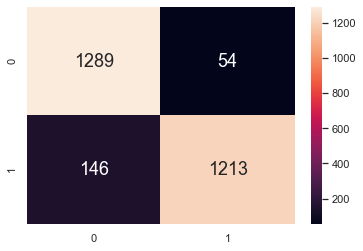

In [118]:
# Predict the Response corresponding to Predictors
y_train_pred = rforest.predict(X_train)

# Print the Classification Accuracy
print("Train Data")
print("Accuracy  :\t", rforest.score(X_train, y_train))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Test Data
Accuracy  :	 0.9136442141623489

TPR Test :	 0.8756567425569177
TNR Test :	 0.9505962521294719

FPR Test :	 0.049403747870528106
FNR Test :	 0.1243432574430823


<AxesSubplot:>

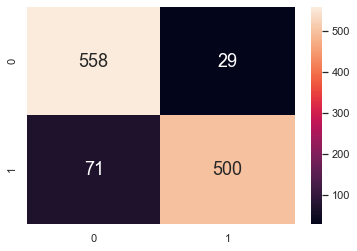

In [119]:
# Predict the Response corresponding to Predictors
y_test_pred = rforest.predict(X_test)

# Print the Classification Accuracy
print("Test Data")
print("Accuracy  :\t", rforest.score(X_test, y_test))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y_test, y_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
print()

print("FPR Test :\t", (fpTest/(fpTest + tnTest)))
print("FNR Test :\t", (fnTest/(fnTest + tpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

In [120]:
print(rforest.feature_importances_)
list_ohe = [x for x in seller_review_ohe_up]
list_importance = rforest.feature_importances_
for i in range(len(list_importance)):
    if list_importance[i] != 0.0:
        print("{} : {}".format(list_ohe[i],list_importance[i]))

[2.88346311e-02 2.36276375e-01 2.25024615e-01 4.19842597e-01
 6.00840049e-04 0.00000000e+00 3.30709543e-04 0.00000000e+00
 1.46753836e-02 0.00000000e+00 2.93351488e-02 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.23055571e-03 0.00000000e+00 0.00000000e+00 3.11232714e-03
 6.51997264e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.67885048e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.18694091e-03 0.00000000e+00
 1.77336292e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.55723806e-03
 0.00000000e+00 0.00000000e+00 7.19762477e-04 1.17050803e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 6.04835941e-04
 4.99092434e-04 0.00000000e+00 1.05582771e-03 1.00468473e-02
 0.00000000e+00 0.00000000e+00 6.93171715e-04 0.00000000e+00
 0.00000000e+00 3.84870578e-04 0.00000000e+00 0.00000000e+00
 5.15854262e-03 0.00000000e+00 9.53490898e-04 0.00000000e+00
 0.00000000e+00 0.000000

## Catboost Model - Machine Learning

In [27]:
conda install -c conda-forge catboost

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\chery\anaconda3

  added / updated specs:
    - catboost


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.12.5  |       h5b45459_0         173 KB  conda-forge
    catboost-0.25.1            |   py38haa244fe_0        54.5 MB  conda-forge
    certifi-2020.12.5          |   py38haa244fe_1         144 KB  conda-forge
    conda-4.10.1               |   py38haa244fe_0         3.1 MB  conda-forge
    openssl-1.1.1k             |       h8ffe710_0         5.7 MB  conda-forge

Note: you may need to restart the kernel to use updated packages.
    python_abi-3.8             |           1_cp38           4 KB  conda-forge
    ------------------------------------------------------------
                                           Total:        63.6 MB

The following NEW packages will be IN

In [28]:
import catboost as cb
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance


catboost-0.25.1      | 54.5 MB   | ###1       |  32% 
catboost-0.25.1      | 54.5 MB   | ###7       |  37% 
catboost-0.25.1      | 54.5 MB   | ####5      |  45% 
catboost-0.25.1      | 54.5 MB   | #####1     |  52% 
catboost-0.25.1      | 54.5 MB   | #####9     |  60% 
catboost-0.25.1      | 54.5 MB   | ######6    |  66% 
catboost-0.25.1      | 54.5 MB   | #######3   |  73% 
catboost-0.25.1      | 54.5 MB   | #######9   |  80% 
catboost-0.25.1      | 54.5 MB   | ########7  |  88% 
catboost-0.25.1      | 54.5 MB   | #########4 |  94% 
catboost-0.25.1      | 54.5 MB   | ########## | 100% 

certifi-2020.12.5    | 144 KB    |            |   0% 
certifi-2020.12.5    | 144 KB    | ##2        |  22% 
certifi-2020.12.5    | 144 KB    | #####5     |  56% 
certifi-2020.12.5    | 144 KB    | ########## | 100% 
certifi-2020.12.5    | 144 KB    | ########## | 100% 

conda-4.10.1         | 3.1 MB    |            |   0% 
conda-4.10.1         | 3.1 MB    | #####      |  50% 
conda-4.10.1         | 3.

In [29]:
dataset = seller_review_ohe

### dataset to be used with variables (features) to predict

In [30]:
dataset

average_review_score  average_price  average_freight_value  \
0                 3.666667     895.000000              21.020000   
1                 3.666667     137.826667              21.696667   
2                 2.250000     687.000000              55.605000   
3                 3.363636     453.777273              32.756818   
4                 2.500000     361.200000              18.595000   
...                    ...            ...                    ...   
3361              3.000000    1420.000000              16.905000   
3362              4.325581      26.302093              21.942326   
3363              4.416667      43.290000              12.770833   
3364              4.636364      92.954545              10.661818   
3365              3.846154     140.846154              23.486538   

      product_description_length  average_product_photos_qty  \
0                     849.000000                    2.000000   
1                    1127.000000                    1.666667   
2                    1423.000000                    1.000000   
3                    1347.727273                    3.500000   
4                    1437.500000                    1.500000   
...                          ...                         ...   
3361                 3992.000000                    1.000000   
3362                  884.697674                    1.186047   
3363                  356.541667                    1.041667   
3364                  315.772727                    1.000000   
3365                  408.884615                    1.230769   

      number_of_type_of_product_category  number_of_type_of_product  \
0                                      1                          1   
1                                      2                          3   
2                                      1                          1   
3                                      4                         15   
4                                      2                          2   
...                                  ...                        ...   
3361                                   1                          1   
3362                                   1                         37   
3363                                   1                         10   
3364                                   1                         14   
3365                                   5                         18   

      seller_time  order_late  number_of_sales_per_seller  ...  \
0             385           0                    6.466667  ...   
1             268           1                    6.466667  ...   
2             355           3                    6.466667  ...   
3             648           7                    6.466667  ...   
4             225           0                    6.466667  ...   
...           ...         ...                         ...  ...   
3361          589           1                    6.400000  ...   
3362          624           4                    6.400000  ...   
3363          172           2                    8.571429  ...   
3364          421           0                    8.571429  ...   
3365          601           0                    7.000000  ...   

      main_product_signaling_and_security  main_product_small_appliances  \
0                                     0.0                            1.0   
1                                     0.0                            1.0   
2                                     0.0                            1.0   
3                                     0.0                            1.0   
4                                     0.0                            1.0   
...                                   ...                            ...   
3361                                  0.0                            0.0   
3362                                  0.0                            0.0   
3363                                  0.0                            0.0   
3364          

### data preparation/cleaning: checking to ensure that no missing values

In [31]:
dataset.isnull().sum()

average_review_score                   0
average_price                          0
average_freight_value                  0
product_description_length             0
average_product_photos_qty             0
                                      ..
main_product_tablets_printing_image    0
main_product_telephony                 0
main_product_toys                      0
main_product_watches_gifts             0
number_of_sales                        0
Length: 1372, dtype: int64

In [32]:
#checking to see if NA values in dataset, so as to not confuse the model
dataset1 = dataset.dropna(how='all', axis=1)

In [33]:
#we can see that none of the columns had NA values, so dataset is good to continue to be used
dataset1

average_review_score  average_price  average_freight_value  \
0                 3.666667     895.000000              21.020000   
1                 3.666667     137.826667              21.696667   
2                 2.250000     687.000000              55.605000   
3                 3.363636     453.777273              32.756818   
4                 2.500000     361.200000              18.595000   
...                    ...            ...                    ...   
3361              3.000000    1420.000000              16.905000   
3362              4.325581      26.302093              21.942326   
3363              4.416667      43.290000              12.770833   
3364              4.636364      92.954545              10.661818   
3365              3.846154     140.846154              23.486538   

      product_description_length  average_product_photos_qty  \
0                     849.000000                    2.000000   
1                    1127.000000                    1.666667   
2                    1423.000000                    1.000000   
3                    1347.727273                    3.500000   
4                    1437.500000                    1.500000   
...                          ...                         ...   
3361                 3992.000000                    1.000000   
3362                  884.697674                    1.186047   
3363                  356.541667                    1.041667   
3364                  315.772727                    1.000000   
3365                  408.884615                    1.230769   

      number_of_type_of_product_category  number_of_type_of_product  \
0                                      1                          1   
1                                      2                          3   
2                                      1                          1   
3                                      4                         15   
4                                      2                          2   
...                                  ...                        ...   
3361                                   1                          1   
3362                                   1                         37   
3363                                   1                         10   
3364                                   1                         14   
3365                                   5                         18   

      seller_time  order_late  number_of_sales_per_seller  ...  \
0             385           0                    6.466667  ...   
1             268           1                    6.466667  ...   
2             355           3                    6.466667  ...   
3             648           7                    6.466667  ...   
4             225           0                    6.466667  ...   
...           ...         ...                         ...  ...   
3361          589           1                    6.400000  ...   
3362          624           4                    6.400000  ...   
3363          172           2                    8.571429  ...   
3364          421           0                    8.571429  ...   
3365          601           0                    7.000000  ...   

      main_product_signaling_and_security  main_product_small_appliances  \
0                                     0.0                            1.0   
1                                     0.0                            1.0   
2                                     0.0                            1.0   
3                                     0.0                            1.0   
4                                     0.0                            1.0   
...                                   ...                            ...   
3361                                  0.0                            0.0   
3362                                  0.0                            0.0   
3363                                  0.0                            0.0   
3364          

In [34]:
#dropping the categorical number_of_sales ('belowaverage and aboveaverage') and adding the numeric column
dataset2 = dataset1.drop(['number_of_sales'], axis=1)

In [35]:
dataset2['number_of_sales'] = catdata

In [36]:
#data is now prepared for use with CatBoost Model
dataset2

average_review_score  average_price  average_freight_value  \
0                 3.666667     895.000000              21.020000   
1                 3.666667     137.826667              21.696667   
2                 2.250000     687.000000              55.605000   
3                 3.363636     453.777273              32.756818   
4                 2.500000     361.200000              18.595000   
...                    ...            ...                    ...   
3361              3.000000    1420.000000              16.905000   
3362              4.325581      26.302093              21.942326   
3363              4.416667      43.290000              12.770833   
3364              4.636364      92.954545              10.661818   
3365              3.846154     140.846154              23.486538   

      product_description_length  average_product_photos_qty  \
0                     849.000000                    2.000000   
1                    1127.000000                    1.666667   
2                    1423.000000                    1.000000   
3                    1347.727273                    3.500000   
4                    1437.500000                    1.500000   
...                          ...                         ...   
3361                 3992.000000                    1.000000   
3362                  884.697674                    1.186047   
3363                  356.541667                    1.041667   
3364                  315.772727                    1.000000   
3365                  408.884615                    1.230769   

      number_of_type_of_product_category  number_of_type_of_product  \
0                                      1                          1   
1                                      2                          3   
2                                      1                          1   
3                                      4                         15   
4                                      2                          2   
...                                  ...                        ...   
3361                                   1                          1   
3362                                   1                         37   
3363                                   1                         10   
3364                                   1                         14   
3365                                   5                         18   

      seller_time  order_late  number_of_sales_per_seller  ...  \
0             385           0                    6.466667  ...   
1             268           1                    6.466667  ...   
2             355           3                    6.466667  ...   
3             648           7                    6.466667  ...   
4             225           0                    6.466667  ...   
...           ...         ...                         ...  ...   
3361          589           1                    6.400000  ...   
3362          624           4                    6.400000  ...   
3363          172           2                    8.571429  ...   
3364          421           0                    8.571429  ...   
3365          601           0                    7.000000  ...   

      main_product_signaling_and_security  main_product_small_appliances  \
0                                     0.0                            1.0   
1                                     0.0                            1.0   
2                                     0.0                            1.0   
3                                     0.0                            1.0   
4                                     0.0                            1.0   
...                                   ...                            ...   
3361                                  0.0                            0.0   
3362                                  0.0                            0.0   
3363                                  0.0                            0.0   
3364          

In [37]:
# Extract Response and Predictors
y = pd.DataFrame(dataset2['number_of_sales'])
X = pd.DataFrame(dataset2.drop('number_of_sales', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [38]:
train_dataset = cb.Pool(X_train, y_train) 
test_dataset = cb.Pool(X_test, y_test)

### CatBoost Regressor Model

In [39]:
model = cb.CatBoostRegressor(loss_function='RMSE')

In [40]:
grid = {'iterations': [100, 150, 300],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
model.grid_search(grid, train_dataset)

0:	learn: 127.1559787	test: 68.4176915	best: 68.4176915 (0)	total: 141ms	remaining: 13.9s
1:	learn: 124.6516931	test: 67.9886631	best: 67.9886631 (1)	total: 148ms	remaining: 7.24s
2:	learn: 122.1250275	test: 67.1987118	best: 67.1987118 (2)	total: 155ms	remaining: 5s
3:	learn: 119.4630499	test: 66.3818188	best: 66.3818188 (3)	total: 161ms	remaining: 3.87s
4:	learn: 116.9345142	test: 65.6929581	best: 65.6929581 (4)	total: 169ms	remaining: 3.2s
5:	learn: 114.5766486	test: 64.8683509	best: 64.8683509 (5)	total: 178ms	remaining: 2.79s
6:	learn: 112.1679106	test: 64.6201391	best: 64.6201391 (6)	total: 186ms	remaining: 2.47s
7:	learn: 109.8580901	test: 63.5948147	best: 63.5948147 (7)	total: 194ms	remaining: 2.23s
8:	learn: 107.6373657	test: 62.5506098	best: 62.5506098 (8)	total: 201ms	remaining: 2.03s
9:	learn: 105.4176885	test: 61.5722453	best: 61.5722453 (9)	total: 208ms	remaining: 1.87s
10:	learn: 103.1952607	test: 60.9063612	best: 60.9063612 (10)	total: 215ms	remaining: 1.74s
11:	learn: 1

98:	learn: 33.4336164	test: 29.0240476	best: 29.0240476 (98)	total: 912ms	remaining: 9.21ms
99:	learn: 33.2336993	test: 29.0213997	best: 29.0213997 (99)	total: 920ms	remaining: 0us

bestTest = 29.02139973
bestIteration = 99

0:	loss: 29.0213997	best: 29.0213997 (0)	total: 1.15s	remaining: 1m 49s
0:	learn: 120.3357335	test: 67.6800589	best: 67.6800589 (0)	total: 6.54ms	remaining: 647ms
1:	learn: 112.7651051	test: 66.4181989	best: 66.4181989 (1)	total: 13.6ms	remaining: 664ms
2:	learn: 104.8819309	test: 63.9706900	best: 63.9706900 (2)	total: 22.9ms	remaining: 741ms
3:	learn: 97.9502107	test: 62.0095006	best: 62.0095006 (3)	total: 31.8ms	remaining: 762ms
4:	learn: 91.2028415	test: 58.2913684	best: 58.2913684 (4)	total: 41ms	remaining: 779ms
5:	learn: 85.5647278	test: 54.7340574	best: 54.7340574 (5)	total: 52ms	remaining: 814ms
6:	learn: 80.6784118	test: 52.5816825	best: 52.5816825 (6)	total: 61.3ms	remaining: 815ms
7:	learn: 75.3218232	test: 50.1816872	best: 50.1816872 (7)	total: 72.3ms	r

88:	learn: 23.2336181	test: 25.3118213	best: 25.2774860 (87)	total: 497ms	remaining: 61.4ms
89:	learn: 23.1877100	test: 25.3134114	best: 25.2774860 (87)	total: 502ms	remaining: 55.8ms
90:	learn: 23.1378464	test: 25.3030831	best: 25.2774860 (87)	total: 506ms	remaining: 50.1ms
91:	learn: 23.0787519	test: 25.2819677	best: 25.2774860 (87)	total: 511ms	remaining: 44.4ms
92:	learn: 23.0397725	test: 25.2819648	best: 25.2774860 (87)	total: 515ms	remaining: 38.8ms
93:	learn: 22.9625734	test: 25.1840087	best: 25.1840087 (93)	total: 520ms	remaining: 33.2ms
94:	learn: 22.9115332	test: 25.1840469	best: 25.1840087 (93)	total: 525ms	remaining: 27.6ms
95:	learn: 22.8729588	test: 25.1864987	best: 25.1840087 (93)	total: 531ms	remaining: 22.1ms
96:	learn: 22.8283399	test: 25.1078062	best: 25.1078062 (96)	total: 536ms	remaining: 16.6ms
97:	learn: 22.7918697	test: 25.1078494	best: 25.1078062 (96)	total: 541ms	remaining: 11ms
98:	learn: 22.7197064	test: 25.1090885	best: 25.1078062 (96)	total: 546ms	remainin

99:	learn: 33.9122885	test: 29.3058859	best: 29.3058859 (99)	total: 476ms	remaining: 0us

bestTest = 29.30588589
bestIteration = 99

2:	loss: 29.3058859	best: 25.0922489 (1)	total: 2.25s	remaining: 1m 9s
0:	learn: 120.6559778	test: 67.6802236	best: 67.6802236 (0)	total: 3.96ms	remaining: 392ms
1:	learn: 113.1869793	test: 66.4186666	best: 66.4186666 (1)	total: 8.29ms	remaining: 406ms
2:	learn: 105.5830015	test: 63.9815687	best: 63.9815687 (2)	total: 13ms	remaining: 421ms
3:	learn: 98.8250480	test: 62.0266769	best: 62.0266769 (3)	total: 17.2ms	remaining: 413ms
4:	learn: 92.3726135	test: 58.3184012	best: 58.3184012 (4)	total: 21.2ms	remaining: 402ms
5:	learn: 86.7272768	test: 54.7585398	best: 54.7585398 (5)	total: 25.5ms	remaining: 400ms
6:	learn: 81.8467584	test: 52.6068566	best: 52.6068566 (6)	total: 30ms	remaining: 399ms
7:	learn: 76.5264685	test: 50.2057746	best: 50.2057746 (7)	total: 34.6ms	remaining: 398ms
8:	learn: 71.3348591	test: 47.5865264	best: 47.5865264 (8)	total: 38.9ms	rema

15:	learn: 95.3407081	test: 56.7360436	best: 56.7360436 (15)	total: 74.1ms	remaining: 389ms
16:	learn: 93.3628074	test: 55.7608064	best: 55.7608064 (16)	total: 78.7ms	remaining: 384ms
17:	learn: 91.6621329	test: 55.0761365	best: 55.0761365 (17)	total: 84.3ms	remaining: 384ms
18:	learn: 89.9483092	test: 54.7154081	best: 54.7154081 (18)	total: 89.1ms	remaining: 380ms
19:	learn: 88.3227722	test: 54.2389775	best: 54.2389775 (19)	total: 94.5ms	remaining: 378ms
20:	learn: 86.8232630	test: 53.3650312	best: 53.3650312 (20)	total: 102ms	remaining: 384ms
21:	learn: 85.2316770	test: 52.5795209	best: 52.5795209 (21)	total: 107ms	remaining: 379ms
22:	learn: 83.5786422	test: 51.8948317	best: 51.8948317 (22)	total: 112ms	remaining: 374ms
23:	learn: 82.0712915	test: 51.1609275	best: 51.1609275 (23)	total: 117ms	remaining: 371ms
24:	learn: 80.7209292	test: 50.8493502	best: 50.8493502 (24)	total: 122ms	remaining: 365ms
25:	learn: 79.2610184	test: 50.4963104	best: 50.4963104 (25)	total: 127ms	remaining: 

27:	learn: 35.2686624	test: 29.5534825	best: 29.5534825 (27)	total: 138ms	remaining: 355ms
28:	learn: 34.7062768	test: 29.5095562	best: 29.5095562 (28)	total: 142ms	remaining: 348ms
29:	learn: 34.0368270	test: 29.1677790	best: 29.1677790 (29)	total: 147ms	remaining: 343ms
30:	learn: 33.4068493	test: 28.8124839	best: 28.8124839 (30)	total: 151ms	remaining: 336ms
31:	learn: 32.9141099	test: 28.3646117	best: 28.3646117 (31)	total: 156ms	remaining: 331ms
32:	learn: 32.4975340	test: 28.0606397	best: 28.0606397 (32)	total: 160ms	remaining: 325ms
33:	learn: 32.0610120	test: 28.0555255	best: 28.0555255 (33)	total: 165ms	remaining: 320ms
34:	learn: 31.3850949	test: 27.8687916	best: 27.8687916 (34)	total: 169ms	remaining: 314ms
35:	learn: 30.9578494	test: 27.6578213	best: 27.6578213 (35)	total: 173ms	remaining: 307ms
36:	learn: 30.5630624	test: 27.4331323	best: 27.4331323 (36)	total: 177ms	remaining: 302ms
37:	learn: 30.2511838	test: 27.1497570	best: 27.1497570 (37)	total: 182ms	remaining: 296ms

36:	learn: 70.8433118	test: 45.5936286	best: 45.5936286 (36)	total: 206ms	remaining: 351ms
37:	learn: 69.9482200	test: 44.9733540	best: 44.9733540 (37)	total: 211ms	remaining: 344ms
38:	learn: 69.0757436	test: 44.4330381	best: 44.4330381 (38)	total: 216ms	remaining: 338ms
39:	learn: 68.1162664	test: 44.0266179	best: 44.0266179 (39)	total: 221ms	remaining: 332ms
40:	learn: 67.2361784	test: 43.9121866	best: 43.9121866 (40)	total: 227ms	remaining: 326ms
41:	learn: 66.2705729	test: 43.5669088	best: 43.5669088 (41)	total: 232ms	remaining: 320ms
42:	learn: 65.4375014	test: 43.3440624	best: 43.3440624 (42)	total: 236ms	remaining: 313ms
43:	learn: 64.6535389	test: 42.7999367	best: 42.7999367 (43)	total: 241ms	remaining: 307ms
44:	learn: 63.7186811	test: 42.3176208	best: 42.3176208 (44)	total: 246ms	remaining: 301ms
45:	learn: 62.9248402	test: 41.7908798	best: 41.7908798 (45)	total: 252ms	remaining: 295ms
46:	learn: 62.0592777	test: 41.3725358	best: 41.3725358 (46)	total: 258ms	remaining: 291ms

42:	learn: 32.7359270	test: 27.9863389	best: 27.9863389 (42)	total: 195ms	remaining: 259ms
43:	learn: 32.3424533	test: 27.7608566	best: 27.7608566 (43)	total: 200ms	remaining: 255ms
44:	learn: 31.9864652	test: 27.5403529	best: 27.5403529 (44)	total: 205ms	remaining: 250ms
45:	learn: 31.7288090	test: 27.3666452	best: 27.3666452 (45)	total: 209ms	remaining: 245ms
46:	learn: 31.5239392	test: 27.3666738	best: 27.3666452 (45)	total: 214ms	remaining: 242ms
47:	learn: 31.3631200	test: 27.3572769	best: 27.3572769 (47)	total: 219ms	remaining: 238ms
48:	learn: 31.0922516	test: 27.1970956	best: 27.1970956 (48)	total: 225ms	remaining: 234ms
49:	learn: 30.9065423	test: 27.1986637	best: 27.1970956 (48)	total: 230ms	remaining: 230ms
50:	learn: 30.7340234	test: 27.0755276	best: 27.0755276 (50)	total: 235ms	remaining: 226ms
51:	learn: 30.5347020	test: 26.9398663	best: 26.9398663 (51)	total: 240ms	remaining: 221ms
52:	learn: 30.3225474	test: 26.9411956	best: 26.9398663 (51)	total: 245ms	remaining: 217ms

41:	learn: 58.4383115	test: 43.2284471	best: 43.2284471 (41)	total: 263ms	remaining: 677ms
42:	learn: 57.6141336	test: 42.6519355	best: 42.6519355 (42)	total: 268ms	remaining: 668ms
43:	learn: 56.7625548	test: 42.2207422	best: 42.2207422 (43)	total: 273ms	remaining: 658ms
44:	learn: 55.8515413	test: 41.7367913	best: 41.7367913 (44)	total: 277ms	remaining: 646ms
45:	learn: 55.0961821	test: 41.2605613	best: 41.2605613 (45)	total: 281ms	remaining: 635ms
46:	learn: 54.3125643	test: 40.7561977	best: 40.7561977 (46)	total: 285ms	remaining: 625ms
47:	learn: 53.5287272	test: 40.4216537	best: 40.4216537 (47)	total: 291ms	remaining: 619ms
48:	learn: 52.7623337	test: 40.0243603	best: 40.0243603 (48)	total: 295ms	remaining: 609ms
49:	learn: 51.9929739	test: 39.6011365	best: 39.6011365 (49)	total: 300ms	remaining: 600ms
50:	learn: 51.3118281	test: 39.1945725	best: 39.1945725 (50)	total: 305ms	remaining: 591ms
51:	learn: 50.6371909	test: 38.7925318	best: 38.7925318 (51)	total: 309ms	remaining: 582ms

146:	learn: 28.1603461	test: 26.2809910	best: 26.2809910 (146)	total: 799ms	remaining: 16.3ms
147:	learn: 28.1029123	test: 26.2766642	best: 26.2766642 (147)	total: 804ms	remaining: 10.9ms
148:	learn: 28.0615974	test: 26.2734063	best: 26.2734063 (148)	total: 808ms	remaining: 5.42ms
149:	learn: 27.9988542	test: 26.2437465	best: 26.2437465 (149)	total: 811ms	remaining: 0us

bestTest = 26.2437465
bestIteration = 149

8:	loss: 26.2437465	best: 24.8605821 (3)	total: 5.65s	remaining: 54.6s
0:	learn: 120.3357335	test: 67.6800589	best: 67.6800589 (0)	total: 3.86ms	remaining: 576ms
1:	learn: 112.7651051	test: 66.4181989	best: 66.4181989 (1)	total: 7.96ms	remaining: 589ms
2:	learn: 104.8819309	test: 63.9706900	best: 63.9706900 (2)	total: 11.5ms	remaining: 562ms
3:	learn: 97.9502107	test: 62.0095006	best: 62.0095006 (3)	total: 15.3ms	remaining: 560ms
4:	learn: 91.2028415	test: 58.2913684	best: 58.2913684 (4)	total: 19.5ms	remaining: 565ms
5:	learn: 85.5647278	test: 54.7340574	best: 54.7340574 (5)	

116:	learn: 21.8073718	test: 24.9396405	best: 24.9377078 (115)	total: 520ms	remaining: 147ms
117:	learn: 21.7854720	test: 24.9412206	best: 24.9377078 (115)	total: 524ms	remaining: 142ms
118:	learn: 21.7585330	test: 24.9494226	best: 24.9377078 (115)	total: 530ms	remaining: 138ms
119:	learn: 21.6097898	test: 24.8809257	best: 24.8809257 (119)	total: 535ms	remaining: 134ms
120:	learn: 21.5573133	test: 24.8702445	best: 24.8702445 (120)	total: 541ms	remaining: 130ms
121:	learn: 21.5257024	test: 24.8700580	best: 24.8700580 (121)	total: 546ms	remaining: 125ms
122:	learn: 21.5001499	test: 24.8700573	best: 24.8700573 (122)	total: 551ms	remaining: 121ms
123:	learn: 21.4740685	test: 24.8979308	best: 24.8700573 (122)	total: 556ms	remaining: 117ms
124:	learn: 21.4398293	test: 24.8726069	best: 24.8700573 (122)	total: 561ms	remaining: 112ms
125:	learn: 21.4152696	test: 24.8726145	best: 24.8700573 (122)	total: 566ms	remaining: 108ms
126:	learn: 21.3783507	test: 24.8431961	best: 24.8431961 (126)	total: 

78:	learn: 38.9517738	test: 32.1877539	best: 32.1877539 (78)	total: 377ms	remaining: 338ms
79:	learn: 38.6615198	test: 32.0967063	best: 32.0967063 (79)	total: 382ms	remaining: 334ms
80:	learn: 38.3543904	test: 31.9170132	best: 31.9170132 (80)	total: 386ms	remaining: 329ms
81:	learn: 38.0407036	test: 31.7522228	best: 31.7522228 (81)	total: 390ms	remaining: 324ms
82:	learn: 37.8002045	test: 31.7478835	best: 31.7478835 (82)	total: 394ms	remaining: 318ms
83:	learn: 37.5275172	test: 31.5559121	best: 31.5559121 (83)	total: 399ms	remaining: 313ms
84:	learn: 37.2489919	test: 31.4135550	best: 31.4135550 (84)	total: 403ms	remaining: 308ms
85:	learn: 36.9602106	test: 31.2469258	best: 31.2469258 (85)	total: 407ms	remaining: 303ms
86:	learn: 36.6842684	test: 31.0917311	best: 31.0917311 (86)	total: 412ms	remaining: 298ms
87:	learn: 36.3920029	test: 30.9286791	best: 30.9286791 (87)	total: 416ms	remaining: 293ms
88:	learn: 36.1339363	test: 30.7696046	best: 30.7696046 (88)	total: 420ms	remaining: 288ms

40:	learn: 29.0091386	test: 26.7493809	best: 26.7493809 (40)	total: 207ms	remaining: 551ms
41:	learn: 28.7791332	test: 26.5977106	best: 26.5977106 (41)	total: 212ms	remaining: 545ms
42:	learn: 28.6181409	test: 26.5485885	best: 26.5485885 (42)	total: 216ms	remaining: 537ms
43:	learn: 28.4464807	test: 26.4317172	best: 26.4317172 (43)	total: 220ms	remaining: 529ms
44:	learn: 28.3314124	test: 26.3991326	best: 26.3991326 (44)	total: 224ms	remaining: 522ms
45:	learn: 28.1742043	test: 26.3957979	best: 26.3957979 (45)	total: 229ms	remaining: 517ms
46:	learn: 27.9325973	test: 26.4003059	best: 26.3957979 (45)	total: 233ms	remaining: 511ms
47:	learn: 27.8572318	test: 26.3898444	best: 26.3898444 (47)	total: 237ms	remaining: 504ms
48:	learn: 27.7085995	test: 26.3961910	best: 26.3898444 (47)	total: 241ms	remaining: 497ms
49:	learn: 27.6060257	test: 26.3618353	best: 26.3618353 (49)	total: 246ms	remaining: 491ms
50:	learn: 27.2799082	test: 26.0572749	best: 26.0572749 (50)	total: 250ms	remaining: 485ms

5:	learn: 115.4950635	test: 64.9220803	best: 64.9220803 (5)	total: 27.1ms	remaining: 650ms
6:	learn: 113.2650106	test: 64.6739128	best: 64.6739128 (6)	total: 31.3ms	remaining: 639ms
7:	learn: 111.1765713	test: 63.6571671	best: 63.6571671 (7)	total: 36.2ms	remaining: 642ms
8:	learn: 108.9958818	test: 62.6196364	best: 62.6196364 (8)	total: 40.9ms	remaining: 641ms
9:	learn: 106.9919137	test: 61.6461355	best: 61.6461355 (9)	total: 45.5ms	remaining: 636ms
10:	learn: 104.9030740	test: 60.9864845	best: 60.9864845 (10)	total: 50.4ms	remaining: 636ms
11:	learn: 102.8825060	test: 60.4022602	best: 60.4022602 (11)	total: 55.6ms	remaining: 639ms
12:	learn: 100.9759511	test: 59.4841223	best: 59.4841223 (12)	total: 61.7ms	remaining: 651ms
13:	learn: 99.0371933	test: 58.5308375	best: 58.5308375 (13)	total: 67.9ms	remaining: 660ms
14:	learn: 97.2320206	test: 57.6004025	best: 57.6004025 (14)	total: 73.4ms	remaining: 661ms
15:	learn: 95.3407081	test: 56.7360436	best: 56.7360436 (15)	total: 78.7ms	remaini

101:	learn: 34.3220127	test: 29.1331104	best: 29.1331104 (101)	total: 572ms	remaining: 269ms
102:	learn: 34.1303263	test: 29.0297865	best: 29.0297865 (102)	total: 579ms	remaining: 264ms
103:	learn: 33.9689374	test: 28.8770959	best: 28.8770959 (103)	total: 584ms	remaining: 258ms
104:	learn: 33.7716702	test: 28.6939270	best: 28.6939270 (104)	total: 594ms	remaining: 255ms
105:	learn: 33.6084280	test: 28.6162719	best: 28.6162719 (105)	total: 604ms	remaining: 251ms
106:	learn: 33.4473291	test: 28.5371273	best: 28.5371273 (106)	total: 613ms	remaining: 246ms
107:	learn: 33.3006336	test: 28.3922566	best: 28.3922566 (107)	total: 618ms	remaining: 240ms
108:	learn: 33.1346033	test: 28.2924889	best: 28.2924889 (108)	total: 622ms	remaining: 234ms
109:	learn: 32.9800290	test: 28.2041280	best: 28.2041280 (109)	total: 627ms	remaining: 228ms
110:	learn: 32.8369126	test: 28.2030701	best: 28.2030701 (110)	total: 633ms	remaining: 222ms
111:	learn: 32.6546350	test: 28.0461371	best: 28.0461371 (111)	total: 

39:	learn: 29.5037435	test: 26.7596455	best: 26.7596455 (39)	total: 236ms	remaining: 648ms
40:	learn: 29.2035408	test: 26.5651923	best: 26.5651923 (40)	total: 243ms	remaining: 645ms
41:	learn: 29.0063405	test: 26.5649845	best: 26.5649845 (41)	total: 247ms	remaining: 636ms
42:	learn: 28.8250386	test: 26.5596083	best: 26.5596083 (42)	total: 253ms	remaining: 630ms
43:	learn: 28.5735745	test: 26.4080782	best: 26.4080782 (43)	total: 258ms	remaining: 622ms
44:	learn: 28.4038448	test: 26.4079337	best: 26.4079337 (44)	total: 265ms	remaining: 619ms
45:	learn: 27.9676673	test: 26.0197799	best: 26.0197799 (45)	total: 272ms	remaining: 616ms
46:	learn: 27.7417416	test: 26.0238524	best: 26.0197799 (45)	total: 277ms	remaining: 607ms
47:	learn: 27.6764080	test: 26.0126459	best: 26.0126459 (47)	total: 282ms	remaining: 599ms
48:	learn: 27.3422158	test: 25.7396096	best: 25.7396096 (48)	total: 287ms	remaining: 591ms
49:	learn: 27.2572374	test: 25.7487038	best: 25.7396096 (48)	total: 291ms	remaining: 582ms

139:	learn: 21.6072737	test: 24.7506057	best: 24.6711553 (135)	total: 776ms	remaining: 55.5ms
140:	learn: 21.5701854	test: 24.7840224	best: 24.6711553 (135)	total: 785ms	remaining: 50.1ms
141:	learn: 21.5367770	test: 24.8034036	best: 24.6711553 (135)	total: 788ms	remaining: 44.4ms
142:	learn: 21.5218774	test: 24.8071638	best: 24.6711553 (135)	total: 793ms	remaining: 38.8ms
143:	learn: 21.4977014	test: 24.7945669	best: 24.6711553 (135)	total: 796ms	remaining: 33.2ms
144:	learn: 21.4794936	test: 24.7945666	best: 24.6711553 (135)	total: 801ms	remaining: 27.6ms
145:	learn: 21.4525743	test: 24.7726166	best: 24.6711553 (135)	total: 805ms	remaining: 22.1ms
146:	learn: 21.4338815	test: 24.7754416	best: 24.6711553 (135)	total: 811ms	remaining: 16.6ms
147:	learn: 21.4167487	test: 24.7868119	best: 24.6711553 (135)	total: 815ms	remaining: 11ms
148:	learn: 21.3990644	test: 24.8301413	best: 24.6711553 (135)	total: 820ms	remaining: 5.51ms
149:	learn: 21.3819566	test: 24.8301453	best: 24.6711553 (135)

94:	learn: 39.9795617	test: 31.3857527	best: 31.3857527 (94)	total: 479ms	remaining: 277ms
95:	learn: 39.7369302	test: 31.3261621	best: 31.3261621 (95)	total: 485ms	remaining: 273ms
96:	learn: 39.5083611	test: 31.1242876	best: 31.1242876 (96)	total: 490ms	remaining: 267ms
97:	learn: 39.2563707	test: 30.9871727	best: 30.9871727 (97)	total: 495ms	remaining: 262ms
98:	learn: 39.0874840	test: 30.9854124	best: 30.9854124 (98)	total: 499ms	remaining: 257ms
99:	learn: 38.8829818	test: 30.8336186	best: 30.8336186 (99)	total: 505ms	remaining: 252ms
100:	learn: 38.6495210	test: 30.7395358	best: 30.7395358 (100)	total: 510ms	remaining: 248ms
101:	learn: 38.4918939	test: 30.7296891	best: 30.7296891 (101)	total: 515ms	remaining: 242ms
102:	learn: 38.2778070	test: 30.6625106	best: 30.6625106 (102)	total: 519ms	remaining: 237ms
103:	learn: 38.0746208	test: 30.6189866	best: 30.6189866 (103)	total: 525ms	remaining: 232ms
104:	learn: 37.9191131	test: 30.6104835	best: 30.6104835 (104)	total: 530ms	remain

45:	learn: 31.7288090	test: 27.3666452	best: 27.3666452 (45)	total: 239ms	remaining: 541ms
46:	learn: 31.5239392	test: 27.3666738	best: 27.3666452 (45)	total: 244ms	remaining: 534ms
47:	learn: 31.3631200	test: 27.3572769	best: 27.3572769 (47)	total: 248ms	remaining: 527ms
48:	learn: 31.0922516	test: 27.1970956	best: 27.1970956 (48)	total: 253ms	remaining: 521ms
49:	learn: 30.9065423	test: 27.1986637	best: 27.1970956 (48)	total: 258ms	remaining: 515ms
50:	learn: 30.7340234	test: 27.0755276	best: 27.0755276 (50)	total: 263ms	remaining: 511ms
51:	learn: 30.5347020	test: 26.9398663	best: 26.9398663 (51)	total: 270ms	remaining: 510ms
52:	learn: 30.3225474	test: 26.9411956	best: 26.9398663 (51)	total: 276ms	remaining: 505ms
53:	learn: 30.1823752	test: 26.9478043	best: 26.9398663 (51)	total: 281ms	remaining: 499ms
54:	learn: 30.0531547	test: 26.9591009	best: 26.9398663 (51)	total: 286ms	remaining: 493ms
55:	learn: 29.9572142	test: 26.9591086	best: 26.9398663 (51)	total: 291ms	remaining: 489ms


bestTest = 25.8014013
bestIteration = 108

15:	loss: 25.8014013	best: 24.5803048 (11)	total: 11.3s	remaining: 56.3s
0:	learn: 127.1559787	test: 68.4176915	best: 68.4176915 (0)	total: 5.24ms	remaining: 1.57s
1:	learn: 124.6516931	test: 67.9886631	best: 67.9886631 (1)	total: 11.2ms	remaining: 1.66s
2:	learn: 122.1250275	test: 67.1987118	best: 67.1987118 (2)	total: 15.2ms	remaining: 1.5s
3:	learn: 119.4630499	test: 66.3818188	best: 66.3818188 (3)	total: 19.2ms	remaining: 1.42s
4:	learn: 116.9345142	test: 65.6929581	best: 65.6929581 (4)	total: 24.8ms	remaining: 1.46s
5:	learn: 114.5766486	test: 64.8683509	best: 64.8683509 (5)	total: 28.7ms	remaining: 1.41s
6:	learn: 112.1679106	test: 64.6201391	best: 64.6201391 (6)	total: 32.8ms	remaining: 1.37s
7:	learn: 109.8580901	test: 63.5948147	best: 63.5948147 (7)	total: 38.3ms	remaining: 1.4s
8:	learn: 107.6373657	test: 62.5506098	best: 62.5506098 (8)	total: 43.3ms	remaining: 1.4s
9:	learn: 105.4176885	test: 61.5722453	best: 61.5722453 (9)	total: 

110:	learn: 31.6412491	test: 28.0465385	best: 28.0465385 (110)	total: 534ms	remaining: 910ms
111:	learn: 31.4755726	test: 27.8820989	best: 27.8820989 (111)	total: 539ms	remaining: 905ms
112:	learn: 31.3612780	test: 27.7787332	best: 27.7787332 (112)	total: 543ms	remaining: 899ms
113:	learn: 31.2325871	test: 27.7578516	best: 27.7578516 (113)	total: 546ms	remaining: 891ms
114:	learn: 31.1241470	test: 27.7427444	best: 27.7427444 (114)	total: 550ms	remaining: 885ms
115:	learn: 30.9911064	test: 27.6742682	best: 27.6742682 (115)	total: 554ms	remaining: 878ms
116:	learn: 30.9028238	test: 27.6644956	best: 27.6644956 (116)	total: 557ms	remaining: 871ms
117:	learn: 30.7715315	test: 27.5861635	best: 27.5861635 (117)	total: 561ms	remaining: 865ms
118:	learn: 30.6369290	test: 27.5866106	best: 27.5861635 (117)	total: 614ms	remaining: 934ms
119:	learn: 30.5184630	test: 27.5165605	best: 27.5165605 (119)	total: 645ms	remaining: 968ms
120:	learn: 30.3685675	test: 27.3675150	best: 27.3675150 (120)	total: 

228:	learn: 24.5931070	test: 25.1618471	best: 25.1616623 (221)	total: 1.26s	remaining: 390ms
229:	learn: 24.5719136	test: 25.1619879	best: 25.1616623 (221)	total: 1.26s	remaining: 384ms
230:	learn: 24.5490394	test: 25.1421241	best: 25.1421241 (230)	total: 1.27s	remaining: 379ms
231:	learn: 24.5280804	test: 25.1075328	best: 25.1075328 (231)	total: 1.27s	remaining: 373ms
232:	learn: 24.5089079	test: 25.1287765	best: 25.1075328 (231)	total: 1.28s	remaining: 367ms
233:	learn: 24.4878253	test: 25.1287551	best: 25.1075328 (231)	total: 1.28s	remaining: 361ms
234:	learn: 24.4677737	test: 25.1284576	best: 25.1075328 (231)	total: 1.28s	remaining: 355ms
235:	learn: 24.4551513	test: 25.1253885	best: 25.1075328 (231)	total: 1.29s	remaining: 350ms
236:	learn: 24.4356541	test: 25.1460337	best: 25.1075328 (231)	total: 1.29s	remaining: 344ms
237:	learn: 24.4178566	test: 25.1375504	best: 25.1075328 (231)	total: 1.3s	remaining: 338ms
238:	learn: 24.3854515	test: 25.1261362	best: 25.1075328 (231)	total: 1

31:	learn: 31.4260663	test: 28.4805743	best: 28.4805743 (31)	total: 148ms	remaining: 1.24s
32:	learn: 30.8563071	test: 27.9157109	best: 27.9157109 (32)	total: 153ms	remaining: 1.24s
33:	learn: 30.3953091	test: 27.9107068	best: 27.9107068 (33)	total: 158ms	remaining: 1.24s
34:	learn: 29.8578416	test: 27.7377279	best: 27.7377279 (34)	total: 162ms	remaining: 1.23s
35:	learn: 29.5553827	test: 27.5378277	best: 27.5378277 (35)	total: 166ms	remaining: 1.22s
36:	learn: 29.1983265	test: 27.3219641	best: 27.3219641 (36)	total: 171ms	remaining: 1.22s
37:	learn: 28.9337448	test: 27.0786741	best: 27.0786741 (37)	total: 176ms	remaining: 1.21s
38:	learn: 28.5725977	test: 26.7907050	best: 26.7907050 (38)	total: 179ms	remaining: 1.2s
39:	learn: 28.2186164	test: 26.5590670	best: 26.5590670 (39)	total: 184ms	remaining: 1.2s
40:	learn: 28.0680963	test: 26.5588828	best: 26.5588828 (40)	total: 187ms	remaining: 1.18s
41:	learn: 27.8472818	test: 26.4215260	best: 26.4215260 (41)	total: 194ms	remaining: 1.19s
4

141:	learn: 20.7729325	test: 25.0856543	best: 24.8431961 (126)	total: 689ms	remaining: 766ms
142:	learn: 20.7444079	test: 25.0896975	best: 24.8431961 (126)	total: 693ms	remaining: 761ms
143:	learn: 20.7206025	test: 25.0919323	best: 24.8431961 (126)	total: 696ms	remaining: 754ms
144:	learn: 20.6995710	test: 25.0919130	best: 24.8431961 (126)	total: 700ms	remaining: 748ms
145:	learn: 20.6685052	test: 25.0725754	best: 24.8431961 (126)	total: 705ms	remaining: 744ms
146:	learn: 20.6450422	test: 25.0725645	best: 24.8431961 (126)	total: 712ms	remaining: 741ms
147:	learn: 20.6293354	test: 25.0725680	best: 24.8431961 (126)	total: 717ms	remaining: 736ms
148:	learn: 20.6046137	test: 25.0725512	best: 24.8431961 (126)	total: 722ms	remaining: 731ms
149:	learn: 20.5684005	test: 25.0923806	best: 24.8431961 (126)	total: 726ms	remaining: 726ms
150:	learn: 20.5463474	test: 25.1172259	best: 24.8431961 (126)	total: 732ms	remaining: 722ms
151:	learn: 20.4987168	test: 25.1077530	best: 24.8431961 (126)	total: 

249:	learn: 17.9953811	test: 25.6346115	best: 24.8431961 (126)	total: 1.23s	remaining: 246ms
250:	learn: 17.9773829	test: 25.6363768	best: 24.8431961 (126)	total: 1.23s	remaining: 241ms
251:	learn: 17.9540714	test: 25.6411632	best: 24.8431961 (126)	total: 1.24s	remaining: 236ms
252:	learn: 17.9250789	test: 25.6450961	best: 24.8431961 (126)	total: 1.24s	remaining: 231ms
253:	learn: 17.9130519	test: 25.6450645	best: 24.8431961 (126)	total: 1.25s	remaining: 226ms
254:	learn: 17.8563819	test: 25.6557948	best: 24.8431961 (126)	total: 1.25s	remaining: 221ms
255:	learn: 17.8390763	test: 25.6139121	best: 24.8431961 (126)	total: 1.25s	remaining: 216ms
256:	learn: 17.8307787	test: 25.6139677	best: 24.8431961 (126)	total: 1.26s	remaining: 211ms
257:	learn: 17.8223970	test: 25.6142175	best: 24.8431961 (126)	total: 1.26s	remaining: 206ms
258:	learn: 17.8163734	test: 25.6131907	best: 24.8431961 (126)	total: 1.27s	remaining: 201ms
259:	learn: 17.8101169	test: 25.6133378	best: 24.8431961 (126)	total: 

66:	learn: 43.4419424	test: 34.7921378	best: 34.7921378 (66)	total: 306ms	remaining: 1.06s
67:	learn: 42.9730736	test: 34.5668403	best: 34.5668403 (67)	total: 311ms	remaining: 1.06s
68:	learn: 42.5050907	test: 34.3212584	best: 34.3212584 (68)	total: 315ms	remaining: 1.05s
69:	learn: 42.1174977	test: 34.0602172	best: 34.0602172 (69)	total: 319ms	remaining: 1.05s
70:	learn: 41.7049576	test: 33.8204261	best: 33.8204261 (70)	total: 323ms	remaining: 1.04s
71:	learn: 41.3171009	test: 33.6528256	best: 33.6528256 (71)	total: 327ms	remaining: 1.03s
72:	learn: 40.9492960	test: 33.3960288	best: 33.3960288 (72)	total: 331ms	remaining: 1.03s
73:	learn: 40.5549583	test: 33.1606717	best: 33.1606717 (73)	total: 336ms	remaining: 1.02s
74:	learn: 40.2382178	test: 32.9434827	best: 32.9434827 (74)	total: 342ms	remaining: 1.02s
75:	learn: 39.8668773	test: 32.7464526	best: 32.7464526 (75)	total: 346ms	remaining: 1.02s
76:	learn: 39.5561291	test: 32.5710087	best: 32.5710087 (76)	total: 350ms	remaining: 1.01s

188:	learn: 26.6094483	test: 25.6609968	best: 25.6452683 (184)	total: 847ms	remaining: 497ms
189:	learn: 26.5760044	test: 25.6223919	best: 25.6223919 (189)	total: 851ms	remaining: 493ms
190:	learn: 26.5432233	test: 25.6194285	best: 25.6194285 (190)	total: 856ms	remaining: 488ms
191:	learn: 26.5079955	test: 25.6194035	best: 25.6194035 (191)	total: 860ms	remaining: 483ms
192:	learn: 26.4825352	test: 25.6188632	best: 25.6188632 (192)	total: 864ms	remaining: 479ms
193:	learn: 26.4461858	test: 25.5748031	best: 25.5748031 (193)	total: 868ms	remaining: 474ms
194:	learn: 26.4045557	test: 25.5516717	best: 25.5516717 (194)	total: 872ms	remaining: 469ms
195:	learn: 26.3758594	test: 25.5516982	best: 25.5516717 (194)	total: 876ms	remaining: 465ms
196:	learn: 26.3431830	test: 25.5495989	best: 25.5495989 (196)	total: 880ms	remaining: 460ms
197:	learn: 26.3135853	test: 25.5648589	best: 25.5495989 (196)	total: 885ms	remaining: 456ms
198:	learn: 26.2795893	test: 25.5648233	best: 25.5495989 (196)	total: 

8:	learn: 71.3348591	test: 47.5865264	best: 47.5865264 (8)	total: 37.4ms	remaining: 1.21s
9:	learn: 67.3033351	test: 45.6898013	best: 45.6898013 (9)	total: 41.8ms	remaining: 1.21s
10:	learn: 64.2574541	test: 44.3214174	best: 44.3214174 (10)	total: 46.2ms	remaining: 1.21s
11:	learn: 60.6435502	test: 42.4273407	best: 42.4273407 (11)	total: 50.3ms	remaining: 1.21s
12:	learn: 57.1974081	test: 40.9295643	best: 40.9295643 (12)	total: 54.1ms	remaining: 1.19s
13:	learn: 54.4011456	test: 39.5415200	best: 39.5415200 (13)	total: 58.4ms	remaining: 1.19s
14:	learn: 51.9317308	test: 38.2001973	best: 38.2001973 (14)	total: 63.2ms	remaining: 1.2s
15:	learn: 49.5260467	test: 37.2594053	best: 37.2594053 (15)	total: 68.5ms	remaining: 1.22s
16:	learn: 47.3053823	test: 36.1979389	best: 36.1979389 (16)	total: 72.7ms	remaining: 1.21s
17:	learn: 45.7208714	test: 36.1435657	best: 36.1435657 (17)	total: 76.9ms	remaining: 1.2s
18:	learn: 43.9743958	test: 35.2614547	best: 35.2614547 (18)	total: 81ms	remaining: 1.

127:	learn: 21.9933350	test: 24.7169105	best: 24.7169105 (127)	total: 578ms	remaining: 777ms
128:	learn: 21.9545550	test: 24.7191677	best: 24.7169105 (127)	total: 582ms	remaining: 772ms
129:	learn: 21.8708242	test: 24.7130580	best: 24.7130580 (129)	total: 586ms	remaining: 767ms
130:	learn: 21.8456121	test: 24.7291617	best: 24.7130580 (129)	total: 590ms	remaining: 762ms
131:	learn: 21.7980347	test: 24.7400633	best: 24.7130580 (129)	total: 595ms	remaining: 757ms
132:	learn: 21.7587858	test: 24.7262819	best: 24.7130580 (129)	total: 599ms	remaining: 752ms
133:	learn: 21.5697428	test: 24.6023548	best: 24.6023548 (133)	total: 603ms	remaining: 747ms
134:	learn: 21.5165424	test: 24.5893333	best: 24.5893333 (134)	total: 607ms	remaining: 742ms
135:	learn: 21.4989412	test: 24.5906093	best: 24.5893333 (134)	total: 612ms	remaining: 738ms
136:	learn: 21.4552964	test: 24.5803048	best: 24.5803048 (136)	total: 616ms	remaining: 733ms
137:	learn: 21.4340966	test: 24.5803137	best: 24.5803048 (136)	total: 

250:	learn: 18.5845977	test: 25.1929068	best: 24.5803048 (136)	total: 1.12s	remaining: 218ms
251:	learn: 18.5737902	test: 25.2249315	best: 24.5803048 (136)	total: 1.12s	remaining: 214ms
252:	learn: 18.5682250	test: 25.2227187	best: 24.5803048 (136)	total: 1.13s	remaining: 209ms
253:	learn: 18.5496835	test: 25.2143867	best: 24.5803048 (136)	total: 1.13s	remaining: 205ms
254:	learn: 18.5390860	test: 25.2143960	best: 24.5803048 (136)	total: 1.13s	remaining: 200ms
255:	learn: 18.5310006	test: 25.2158429	best: 24.5803048 (136)	total: 1.14s	remaining: 196ms
256:	learn: 18.5230477	test: 25.2270240	best: 24.5803048 (136)	total: 1.14s	remaining: 191ms
257:	learn: 18.5041491	test: 25.2296010	best: 24.5803048 (136)	total: 1.15s	remaining: 187ms
258:	learn: 18.4833959	test: 25.2227351	best: 24.5803048 (136)	total: 1.15s	remaining: 182ms
259:	learn: 18.4551356	test: 25.2207172	best: 24.5803048 (136)	total: 1.16s	remaining: 178ms
260:	learn: 18.4448931	test: 25.2206390	best: 24.5803048 (136)	total: 

68:	learn: 43.9206323	test: 34.0839033	best: 34.0839033 (68)	total: 302ms	remaining: 1.01s
69:	learn: 43.4714480	test: 33.9445954	best: 33.9445954 (69)	total: 306ms	remaining: 1.01s
70:	learn: 43.0498899	test: 33.6974047	best: 33.6974047 (70)	total: 310ms	remaining: 1s
71:	learn: 42.6434510	test: 33.6543350	best: 33.6543350 (71)	total: 314ms	remaining: 996ms
72:	learn: 42.2120615	test: 33.4036908	best: 33.4036908 (72)	total: 318ms	remaining: 990ms
73:	learn: 41.8082316	test: 33.1697284	best: 33.1697284 (73)	total: 323ms	remaining: 987ms
74:	learn: 41.4524762	test: 32.9829639	best: 32.9829639 (74)	total: 327ms	remaining: 982ms
75:	learn: 41.0496123	test: 32.7855013	best: 32.7855013 (75)	total: 332ms	remaining: 979ms
76:	learn: 40.7298533	test: 32.5971957	best: 32.5971957 (76)	total: 337ms	remaining: 975ms
77:	learn: 40.3667940	test: 32.4019529	best: 32.4019529 (77)	total: 341ms	remaining: 970ms
78:	learn: 40.0017592	test: 32.2192730	best: 32.2192730 (78)	total: 345ms	remaining: 965ms
79

185:	learn: 27.1239658	test: 25.3979231	best: 25.3904215 (184)	total: 840ms	remaining: 515ms
186:	learn: 27.0870580	test: 25.3979065	best: 25.3904215 (184)	total: 844ms	remaining: 510ms
187:	learn: 27.0515039	test: 25.3978907	best: 25.3904215 (184)	total: 848ms	remaining: 505ms
188:	learn: 27.0214911	test: 25.3978872	best: 25.3904215 (184)	total: 852ms	remaining: 501ms
189:	learn: 26.9840071	test: 25.3946372	best: 25.3904215 (184)	total: 856ms	remaining: 496ms
190:	learn: 26.9548137	test: 25.3946333	best: 25.3904215 (184)	total: 862ms	remaining: 492ms
191:	learn: 26.9224326	test: 25.3946183	best: 25.3904215 (184)	total: 867ms	remaining: 488ms
192:	learn: 26.8944235	test: 25.4027945	best: 25.3904215 (184)	total: 872ms	remaining: 483ms
193:	learn: 26.8133424	test: 25.3376299	best: 25.3376299 (193)	total: 888ms	remaining: 485ms
194:	learn: 26.7692056	test: 25.3086101	best: 25.3086101 (194)	total: 893ms	remaining: 481ms
195:	learn: 26.7440722	test: 25.3086408	best: 25.3086101 (194)	total: 

295:	learn: 24.2109130	test: 24.8221747	best: 24.8206127 (294)	total: 1.38s	remaining: 18.7ms
296:	learn: 24.1972417	test: 24.8221438	best: 24.8206127 (294)	total: 1.39s	remaining: 14ms
297:	learn: 24.1829793	test: 24.8221470	best: 24.8206127 (294)	total: 1.39s	remaining: 9.35ms
298:	learn: 24.1590279	test: 24.8156153	best: 24.8156153 (298)	total: 1.4s	remaining: 4.67ms
299:	learn: 24.1057747	test: 24.7716568	best: 24.7716568 (299)	total: 1.4s	remaining: 0us

bestTest = 24.77165678
bestIteration = 299

20:	loss: 24.7716568	best: 24.5803048 (11)	total: 18.8s	remaining: 1m 7s
0:	learn: 121.1406852	test: 67.6804980	best: 67.6804980 (0)	total: 5.01ms	remaining: 1.5s
1:	learn: 113.8340514	test: 66.4194519	best: 66.4194519 (1)	total: 10.6ms	remaining: 1.58s
2:	learn: 106.6317416	test: 64.0002406	best: 64.0002406 (2)	total: 15.3ms	remaining: 1.51s
3:	learn: 100.1408053	test: 62.0562465	best: 62.0562465 (3)	total: 19.7ms	remaining: 1.46s
4:	learn: 93.1135515	test: 58.6147241	best: 58.6147241 (

109:	learn: 22.6407791	test: 24.9669635	best: 24.9429399 (86)	total: 515ms	remaining: 890ms
110:	learn: 22.6044350	test: 24.9669676	best: 24.9429399 (86)	total: 520ms	remaining: 886ms
111:	learn: 22.5540649	test: 24.9619144	best: 24.9429399 (86)	total: 526ms	remaining: 883ms
112:	learn: 22.5281770	test: 24.9618985	best: 24.9429399 (86)	total: 530ms	remaining: 877ms
113:	learn: 22.4775951	test: 24.8850075	best: 24.8850075 (113)	total: 534ms	remaining: 871ms
114:	learn: 22.4390813	test: 24.8434088	best: 24.8434088 (114)	total: 538ms	remaining: 866ms
115:	learn: 22.3919788	test: 24.7749739	best: 24.7749739 (115)	total: 543ms	remaining: 861ms
116:	learn: 22.3725959	test: 24.7736645	best: 24.7736645 (116)	total: 549ms	remaining: 859ms
117:	learn: 22.3257925	test: 24.7709478	best: 24.7709478 (117)	total: 554ms	remaining: 854ms
118:	learn: 22.3076540	test: 24.7704149	best: 24.7704149 (118)	total: 559ms	remaining: 851ms
119:	learn: 22.2830335	test: 24.7704759	best: 24.7704149 (118)	total: 564m

230:	learn: 19.3823778	test: 25.3812026	best: 24.6711553 (135)	total: 1.05s	remaining: 314ms
231:	learn: 19.3390651	test: 25.4068894	best: 24.6711553 (135)	total: 1.05s	remaining: 309ms
232:	learn: 19.3283743	test: 25.4068374	best: 24.6711553 (135)	total: 1.06s	remaining: 304ms
233:	learn: 19.3083665	test: 25.4070157	best: 24.6711553 (135)	total: 1.06s	remaining: 300ms
234:	learn: 19.2867105	test: 25.4105015	best: 24.6711553 (135)	total: 1.07s	remaining: 295ms
235:	learn: 19.2693089	test: 25.4040211	best: 24.6711553 (135)	total: 1.07s	remaining: 291ms
236:	learn: 19.2501596	test: 25.4000387	best: 24.6711553 (135)	total: 1.08s	remaining: 287ms
237:	learn: 19.2320927	test: 25.4001633	best: 24.6711553 (135)	total: 1.08s	remaining: 282ms
238:	learn: 19.2214737	test: 25.4391010	best: 24.6711553 (135)	total: 1.09s	remaining: 278ms
239:	learn: 19.1862326	test: 25.4554814	best: 24.6711553 (135)	total: 1.09s	remaining: 273ms
240:	learn: 19.1758521	test: 25.4636471	best: 24.6711553 (135)	total: 

48:	learn: 60.4095087	test: 40.5370566	best: 40.5370566 (48)	total: 221ms	remaining: 1.13s
49:	learn: 59.7955497	test: 40.1221795	best: 40.1221795 (49)	total: 225ms	remaining: 1.13s
50:	learn: 59.2342281	test: 39.6739267	best: 39.6739267 (50)	total: 230ms	remaining: 1.12s
51:	learn: 58.5061022	test: 39.2934147	best: 39.2934147 (51)	total: 234ms	remaining: 1.12s
52:	learn: 57.7631520	test: 38.9938908	best: 38.9938908 (52)	total: 239ms	remaining: 1.11s
53:	learn: 57.1200022	test: 38.6221297	best: 38.6221297 (53)	total: 243ms	remaining: 1.11s
54:	learn: 56.4276774	test: 38.2853214	best: 38.2853214 (54)	total: 248ms	remaining: 1.1s
55:	learn: 55.7459230	test: 38.0156776	best: 38.0156776 (55)	total: 253ms	remaining: 1.1s
56:	learn: 55.1442335	test: 37.8601887	best: 37.8601887 (56)	total: 257ms	remaining: 1.1s
57:	learn: 54.5280635	test: 37.6272288	best: 37.6272288 (57)	total: 261ms	remaining: 1.09s
58:	learn: 53.9860605	test: 37.2847272	best: 37.2847272 (58)	total: 266ms	remaining: 1.08s
59

165:	learn: 30.7459427	test: 27.4924491	best: 27.4924491 (165)	total: 772ms	remaining: 623ms
166:	learn: 30.6745375	test: 27.4922842	best: 27.4922842 (166)	total: 776ms	remaining: 618ms
167:	learn: 30.5931152	test: 27.3650079	best: 27.3650079 (167)	total: 781ms	remaining: 613ms
168:	learn: 30.5065835	test: 27.3041811	best: 27.3041811 (168)	total: 787ms	remaining: 610ms
169:	learn: 30.4429992	test: 27.2445750	best: 27.2445750 (169)	total: 792ms	remaining: 605ms
170:	learn: 30.3622701	test: 27.1879816	best: 27.1879816 (170)	total: 796ms	remaining: 600ms
171:	learn: 30.3246470	test: 27.1874505	best: 27.1874505 (171)	total: 800ms	remaining: 595ms
172:	learn: 30.2607793	test: 27.1715453	best: 27.1715453 (172)	total: 805ms	remaining: 591ms
173:	learn: 30.2326891	test: 27.1715023	best: 27.1715023 (173)	total: 809ms	remaining: 586ms
174:	learn: 30.1870641	test: 27.1719277	best: 27.1715023 (173)	total: 813ms	remaining: 581ms
175:	learn: 30.1172415	test: 27.1424185	best: 27.1424185 (175)	total: 

283:	learn: 26.5569205	test: 25.8941127	best: 25.8696766 (275)	total: 1.31s	remaining: 74.1ms
284:	learn: 26.5241222	test: 25.8748237	best: 25.8696766 (275)	total: 1.32s	remaining: 69.4ms
285:	learn: 26.5120897	test: 25.8748056	best: 25.8696766 (275)	total: 1.32s	remaining: 64.8ms
286:	learn: 26.5002320	test: 25.8747883	best: 25.8696766 (275)	total: 1.33s	remaining: 60.1ms
287:	learn: 26.4823653	test: 25.8747445	best: 25.8696766 (275)	total: 1.33s	remaining: 55.5ms
288:	learn: 26.4706714	test: 25.8747283	best: 25.8696766 (275)	total: 1.33s	remaining: 50.8ms
289:	learn: 26.4546720	test: 25.8747447	best: 25.8696766 (275)	total: 1.34s	remaining: 46.2ms
290:	learn: 26.4432793	test: 25.8842152	best: 25.8696766 (275)	total: 1.34s	remaining: 41.5ms
291:	learn: 26.3627384	test: 25.8158706	best: 25.8158706 (291)	total: 1.35s	remaining: 36.9ms
292:	learn: 26.3531167	test: 25.8156437	best: 25.8156437 (292)	total: 1.35s	remaining: 32.3ms
293:	learn: 26.3417914	test: 25.8156258	best: 25.8156258 (29

73:	learn: 27.9808410	test: 26.3108847	best: 26.2449480 (71)	total: 483ms	remaining: 1.47s
74:	learn: 27.9351169	test: 26.3108545	best: 26.2449480 (71)	total: 487ms	remaining: 1.46s
75:	learn: 27.8685543	test: 26.3107272	best: 26.2449480 (71)	total: 491ms	remaining: 1.45s
76:	learn: 27.8253801	test: 26.3463890	best: 26.2449480 (71)	total: 496ms	remaining: 1.44s
77:	learn: 27.7787975	test: 26.3835946	best: 26.2449480 (71)	total: 500ms	remaining: 1.42s
78:	learn: 27.7344430	test: 26.4221829	best: 26.2449480 (71)	total: 505ms	remaining: 1.41s
79:	learn: 27.4615900	test: 26.1786824	best: 26.1786824 (79)	total: 509ms	remaining: 1.4s
80:	learn: 27.4198855	test: 26.2182800	best: 26.1786824 (79)	total: 514ms	remaining: 1.39s
81:	learn: 27.3860833	test: 26.2174607	best: 26.1786824 (79)	total: 518ms	remaining: 1.38s
82:	learn: 27.3486451	test: 26.2582417	best: 26.1786824 (79)	total: 523ms	remaining: 1.37s
83:	learn: 27.2317707	test: 25.9285102	best: 25.9285102 (83)	total: 529ms	remaining: 1.36s


188:	learn: 23.4694398	test: 25.8958207	best: 25.8014013 (108)	total: 1.02s	remaining: 601ms
189:	learn: 23.4559435	test: 25.8996133	best: 25.8014013 (108)	total: 1.03s	remaining: 595ms
190:	learn: 23.4448209	test: 25.9006201	best: 25.8014013 (108)	total: 1.03s	remaining: 589ms
191:	learn: 23.4077506	test: 25.8598681	best: 25.8014013 (108)	total: 1.03s	remaining: 582ms
192:	learn: 23.3887158	test: 25.8581508	best: 25.8014013 (108)	total: 1.04s	remaining: 576ms
193:	learn: 23.3706101	test: 25.8565599	best: 25.8014013 (108)	total: 1.04s	remaining: 570ms
194:	learn: 23.3442265	test: 25.8564596	best: 25.8014013 (108)	total: 1.05s	remaining: 565ms
195:	learn: 23.3332196	test: 25.8562899	best: 25.8014013 (108)	total: 1.05s	remaining: 558ms
196:	learn: 23.3159705	test: 25.8548316	best: 25.8014013 (108)	total: 1.06s	remaining: 553ms
197:	learn: 23.2995638	test: 25.8534829	best: 25.8014013 (108)	total: 1.06s	remaining: 547ms
198:	learn: 23.2866429	test: 25.8585871	best: 25.8014013 (108)	total: 

5:	learn: 112.1513570	test: 61.4464414	best: 61.4464414 (5)	total: 47.8ms	remaining: 750ms
6:	learn: 109.6521984	test: 60.3734741	best: 60.3734741 (6)	total: 55.9ms	remaining: 743ms
7:	learn: 107.2135401	test: 59.4482056	best: 59.4482056 (7)	total: 64.4ms	remaining: 740ms
8:	learn: 104.7286740	test: 58.1286236	best: 58.1286236 (8)	total: 72.4ms	remaining: 732ms
9:	learn: 102.3603974	test: 57.0372719	best: 57.0372719 (9)	total: 81.8ms	remaining: 736ms
10:	learn: 99.9706605	test: 55.8744156	best: 55.8744156 (10)	total: 91.8ms	remaining: 742ms
11:	learn: 97.7537179	test: 55.1356878	best: 55.1356878 (11)	total: 100ms	remaining: 736ms
12:	learn: 95.4888239	test: 53.8799280	best: 53.8799280 (12)	total: 108ms	remaining: 723ms
13:	learn: 93.3020458	test: 52.9518652	best: 52.9518652 (13)	total: 117ms	remaining: 720ms
14:	learn: 91.1854813	test: 52.1453382	best: 52.1453382 (14)	total: 125ms	remaining: 709ms
15:	learn: 89.2734810	test: 51.4817551	best: 51.4817551 (15)	total: 135ms	remaining: 709m

6:	learn: 74.1521540	test: 46.0958207	best: 46.0958207 (6)	total: 60.4ms	remaining: 802ms
7:	learn: 68.5604503	test: 43.8507741	best: 43.8507741 (7)	total: 68.3ms	remaining: 785ms
8:	learn: 63.8667233	test: 41.3464443	best: 41.3464443 (8)	total: 76.4ms	remaining: 773ms
9:	learn: 59.4407414	test: 39.6376546	best: 39.6376546 (9)	total: 84.2ms	remaining: 757ms
10:	learn: 55.5267153	test: 37.7828195	best: 37.7828195 (10)	total: 92.8ms	remaining: 751ms
11:	learn: 52.0464778	test: 36.4743616	best: 36.4743616 (11)	total: 101ms	remaining: 742ms
12:	learn: 48.9086132	test: 34.8933622	best: 34.8933622 (12)	total: 110ms	remaining: 736ms
13:	learn: 46.0273201	test: 33.8111991	best: 33.8111991 (13)	total: 119ms	remaining: 729ms
14:	learn: 43.6311501	test: 32.9366319	best: 32.9366319 (14)	total: 127ms	remaining: 720ms
15:	learn: 41.3237175	test: 31.8640886	best: 31.8640886 (15)	total: 135ms	remaining: 711ms
16:	learn: 39.1304067	test: 30.9908175	best: 30.9908175 (16)	total: 143ms	remaining: 700ms
17

96:	learn: 16.6755062	test: 22.5623178	best: 22.5623178 (96)	total: 852ms	remaining: 26.4ms
97:	learn: 16.5460114	test: 22.5035382	best: 22.5035382 (97)	total: 862ms	remaining: 17.6ms
98:	learn: 16.5008665	test: 22.4883264	best: 22.4883264 (98)	total: 871ms	remaining: 8.8ms
99:	learn: 16.3369037	test: 22.4433502	best: 22.4433502 (99)	total: 880ms	remaining: 0us

bestTest = 22.44335023
bestIteration = 99

25:	loss: 22.4433502	best: 22.4433502 (25)	total: 25.1s	remaining: 1m 7s
0:	learn: 127.1261066	test: 67.7025304	best: 67.7025304 (0)	total: 9.65ms	remaining: 955ms
1:	learn: 124.2264283	test: 66.6426406	best: 66.6426406 (1)	total: 17.7ms	remaining: 867ms
2:	learn: 121.2779279	test: 65.2604989	best: 65.2604989 (2)	total: 26.9ms	remaining: 871ms
3:	learn: 118.3457716	test: 64.0590510	best: 64.0590510 (3)	total: 36.9ms	remaining: 886ms
4:	learn: 115.7237941	test: 62.7975285	best: 62.7975285 (4)	total: 47.5ms	remaining: 903ms
5:	learn: 113.0588497	test: 61.5117186	best: 61.5117186 (5)	tota


bestTest = 25.83066806
bestIteration = 99

26:	loss: 25.8306681	best: 22.4433502 (25)	total: 26s	remaining: 1m 6s
0:	learn: 120.2081065	test: 65.3287876	best: 65.3287876 (0)	total: 9.63ms	remaining: 953ms
1:	learn: 111.2740133	test: 62.1025236	best: 62.1025236 (1)	total: 20.9ms	remaining: 1.02s
2:	learn: 102.7402492	test: 57.4534890	best: 57.4534890 (2)	total: 31.4ms	remaining: 1.01s
3:	learn: 94.7842523	test: 54.2167856	best: 54.2167856 (3)	total: 42.2ms	remaining: 1.01s
4:	learn: 88.1367413	test: 51.0515923	best: 51.0515923 (4)	total: 53ms	remaining: 1.01s
5:	learn: 81.7773291	test: 48.2843085	best: 48.2843085 (5)	total: 63.2ms	remaining: 990ms
6:	learn: 76.0825367	test: 45.7409714	best: 45.7409714 (6)	total: 73.9ms	remaining: 982ms
7:	learn: 71.1299135	test: 43.8510423	best: 43.8510423 (7)	total: 84.3ms	remaining: 969ms
8:	learn: 66.3574617	test: 41.4216822	best: 41.4216822 (8)	total: 95.1ms	remaining: 962ms
9:	learn: 61.9590124	test: 39.6093981	best: 39.6093981 (9)	total: 105ms	re

4:	learn: 116.2932598	test: 62.9163292	best: 62.9163292 (4)	total: 66.9ms	remaining: 1.27s
5:	learn: 113.7551596	test: 62.1082827	best: 62.1082827 (5)	total: 78.5ms	remaining: 1.23s
6:	learn: 111.4698345	test: 61.0669026	best: 61.0669026 (6)	total: 89.2ms	remaining: 1.18s
7:	learn: 109.5377112	test: 60.1564117	best: 60.1564117 (7)	total: 100ms	remaining: 1.15s
8:	learn: 107.2076270	test: 58.9787299	best: 58.9787299 (8)	total: 113ms	remaining: 1.14s
9:	learn: 104.9496406	test: 57.9159024	best: 57.9159024 (9)	total: 123ms	remaining: 1.11s
10:	learn: 102.5697659	test: 56.8506043	best: 56.8506043 (10)	total: 133ms	remaining: 1.08s
11:	learn: 100.5587904	test: 56.0254087	best: 56.0254087 (11)	total: 147ms	remaining: 1.08s
12:	learn: 98.5486562	test: 54.7547067	best: 54.7547067 (12)	total: 170ms	remaining: 1.14s
13:	learn: 96.5764671	test: 53.9915891	best: 53.9915891 (13)	total: 181ms	remaining: 1.11s
14:	learn: 94.6125185	test: 53.1884166	best: 53.1884166 (14)	total: 192ms	remaining: 1.09s


8:	learn: 68.9720303	test: 41.8002198	best: 41.8002198 (8)	total: 107ms	remaining: 1.08s
9:	learn: 64.4147996	test: 39.9132906	best: 39.9132906 (9)	total: 118ms	remaining: 1.06s
10:	learn: 60.4721518	test: 38.1611816	best: 38.1611816 (10)	total: 129ms	remaining: 1.04s
11:	learn: 57.6014501	test: 37.8224791	best: 37.8224791 (11)	total: 139ms	remaining: 1.02s
12:	learn: 54.5583461	test: 36.0726228	best: 36.0726228 (12)	total: 150ms	remaining: 1s
13:	learn: 51.6247641	test: 34.8624100	best: 34.8624100 (13)	total: 162ms	remaining: 994ms
14:	learn: 49.0165981	test: 33.9865579	best: 33.9865579 (14)	total: 176ms	remaining: 1000ms
15:	learn: 46.9072611	test: 33.1877116	best: 33.1877116 (15)	total: 188ms	remaining: 988ms
16:	learn: 44.6153575	test: 31.9232568	best: 31.9232568 (16)	total: 200ms	remaining: 976ms
17:	learn: 42.4156561	test: 31.0669774	best: 31.0669774 (17)	total: 212ms	remaining: 964ms
18:	learn: 40.6293126	test: 30.4752123	best: 30.4752123 (18)	total: 222ms	remaining: 947ms
19:	l

13:	learn: 100.8495029	test: 54.8726027	best: 54.8726027 (13)	total: 158ms	remaining: 972ms
14:	learn: 99.1852447	test: 54.0774227	best: 54.0774227 (14)	total: 168ms	remaining: 954ms
15:	learn: 97.6805526	test: 53.3708089	best: 53.3708089 (15)	total: 180ms	remaining: 947ms
16:	learn: 95.9014678	test: 52.5073637	best: 52.5073637 (16)	total: 192ms	remaining: 939ms
17:	learn: 94.1902227	test: 51.9424079	best: 51.9424079 (17)	total: 203ms	remaining: 924ms
18:	learn: 92.7008422	test: 51.2336282	best: 51.2336282 (18)	total: 213ms	remaining: 909ms
19:	learn: 91.0330324	test: 50.4360703	best: 50.4360703 (19)	total: 224ms	remaining: 894ms
20:	learn: 89.3432075	test: 49.6219893	best: 49.6219893 (20)	total: 234ms	remaining: 880ms
21:	learn: 87.7925932	test: 49.1073336	best: 49.1073336 (21)	total: 244ms	remaining: 865ms
22:	learn: 86.2121569	test: 48.4787238	best: 48.4787238 (22)	total: 255ms	remaining: 852ms
23:	learn: 84.8479826	test: 47.8439563	best: 47.8439563 (23)	total: 266ms	remaining: 841m

19:	learn: 46.4632457	test: 31.3996419	best: 31.3996419 (19)	total: 212ms	remaining: 848ms
20:	learn: 44.8884517	test: 30.9773119	best: 30.9773119 (20)	total: 224ms	remaining: 842ms
21:	learn: 43.1201150	test: 30.3899579	best: 30.3899579 (21)	total: 234ms	remaining: 830ms
22:	learn: 41.5033355	test: 29.7980254	best: 29.7980254 (22)	total: 245ms	remaining: 819ms
23:	learn: 40.7934051	test: 29.7706088	best: 29.7706088 (23)	total: 257ms	remaining: 812ms
24:	learn: 40.2207235	test: 29.7473405	best: 29.7473405 (24)	total: 267ms	remaining: 801ms
25:	learn: 39.3015566	test: 29.2759824	best: 29.2759824 (25)	total: 278ms	remaining: 792ms
26:	learn: 38.1762510	test: 29.0236269	best: 29.0236269 (26)	total: 288ms	remaining: 780ms
27:	learn: 37.0631710	test: 28.9330764	best: 28.9330764 (27)	total: 298ms	remaining: 767ms
28:	learn: 36.2618486	test: 28.9225834	best: 28.9225834 (28)	total: 309ms	remaining: 756ms
29:	learn: 35.3807463	test: 28.5065806	best: 28.5065806 (29)	total: 319ms	remaining: 744ms

8:	learn: 104.7286740	test: 58.1286236	best: 58.1286236 (8)	total: 102ms	remaining: 1.59s
9:	learn: 102.3603974	test: 57.0372719	best: 57.0372719 (9)	total: 111ms	remaining: 1.56s
10:	learn: 99.9706605	test: 55.8744156	best: 55.8744156 (10)	total: 123ms	remaining: 1.55s
11:	learn: 97.7537179	test: 55.1356878	best: 55.1356878 (11)	total: 133ms	remaining: 1.53s
12:	learn: 95.4888239	test: 53.8799280	best: 53.8799280 (12)	total: 143ms	remaining: 1.51s
13:	learn: 93.3020458	test: 52.9518652	best: 52.9518652 (13)	total: 153ms	remaining: 1.49s
14:	learn: 91.1854813	test: 52.1453382	best: 52.1453382 (14)	total: 163ms	remaining: 1.47s
15:	learn: 89.2734810	test: 51.4817551	best: 51.4817551 (15)	total: 174ms	remaining: 1.46s
16:	learn: 87.2233218	test: 50.3867667	best: 50.3867667 (16)	total: 185ms	remaining: 1.45s
17:	learn: 85.1580342	test: 49.5786120	best: 49.5786120 (17)	total: 195ms	remaining: 1.43s
18:	learn: 83.2254219	test: 48.5887260	best: 48.5887260 (18)	total: 206ms	remaining: 1.42s
1

113:	learn: 23.4510804	test: 24.0999554	best: 24.0999554 (113)	total: 1.23s	remaining: 388ms
114:	learn: 23.3534466	test: 24.0453492	best: 24.0453492 (114)	total: 1.24s	remaining: 377ms
115:	learn: 23.2572250	test: 23.9980220	best: 23.9980220 (115)	total: 1.25s	remaining: 366ms
116:	learn: 23.1652029	test: 23.9695654	best: 23.9695654 (116)	total: 1.26s	remaining: 355ms
117:	learn: 23.0634643	test: 23.9257875	best: 23.9257875 (117)	total: 1.27s	remaining: 345ms
118:	learn: 22.9460012	test: 23.8080841	best: 23.8080841 (118)	total: 1.28s	remaining: 334ms
119:	learn: 22.8634218	test: 23.7821063	best: 23.7821063 (119)	total: 1.29s	remaining: 323ms
120:	learn: 22.7678659	test: 23.7463977	best: 23.7463977 (120)	total: 1.3s	remaining: 313ms
121:	learn: 22.6706100	test: 23.6829469	best: 23.6829469 (121)	total: 1.31s	remaining: 302ms
122:	learn: 22.5830143	test: 23.6461810	best: 23.6461810 (122)	total: 1.32s	remaining: 291ms
123:	learn: 22.5156960	test: 23.6458470	best: 23.6458470 (123)	total: 1

57:	learn: 19.5677794	test: 22.7653323	best: 22.7653323 (57)	total: 553ms	remaining: 877ms
58:	learn: 19.4488213	test: 22.6800272	best: 22.6800272 (58)	total: 562ms	remaining: 866ms
59:	learn: 19.3775442	test: 22.6405538	best: 22.6405538 (59)	total: 570ms	remaining: 854ms
60:	learn: 19.2625597	test: 22.5745625	best: 22.5745625 (60)	total: 577ms	remaining: 842ms
61:	learn: 19.2067361	test: 22.5861993	best: 22.5745625 (60)	total: 586ms	remaining: 831ms
62:	learn: 19.1196614	test: 22.5835735	best: 22.5745625 (60)	total: 593ms	remaining: 819ms
63:	learn: 19.0341002	test: 22.5813998	best: 22.5745625 (60)	total: 601ms	remaining: 808ms
64:	learn: 18.9661404	test: 22.5783578	best: 22.5745625 (60)	total: 610ms	remaining: 797ms
65:	learn: 18.8957809	test: 22.5739834	best: 22.5739834 (65)	total: 619ms	remaining: 788ms
66:	learn: 18.8413929	test: 22.5719701	best: 22.5719701 (66)	total: 627ms	remaining: 777ms
67:	learn: 18.7716494	test: 22.5820749	best: 22.5719701 (66)	total: 635ms	remaining: 766ms

10:	learn: 101.3529674	test: 56.0268204	best: 56.0268204 (10)	total: 123ms	remaining: 1.55s
11:	learn: 99.2251217	test: 55.3121909	best: 55.3121909 (11)	total: 137ms	remaining: 1.58s
12:	learn: 97.0658129	test: 54.0618282	best: 54.0618282 (12)	total: 154ms	remaining: 1.62s
13:	learn: 94.9874428	test: 53.3188213	best: 53.3188213 (13)	total: 169ms	remaining: 1.64s
14:	learn: 92.9180186	test: 52.5071739	best: 52.5071739 (14)	total: 184ms	remaining: 1.66s
15:	learn: 91.1827507	test: 51.8350497	best: 51.8350497 (15)	total: 198ms	remaining: 1.66s
16:	learn: 89.1884396	test: 50.7564467	best: 50.7564467 (16)	total: 212ms	remaining: 1.66s
17:	learn: 87.2441350	test: 49.7098804	best: 49.7098804 (17)	total: 226ms	remaining: 1.66s
18:	learn: 85.3608017	test: 48.7357636	best: 48.7357636 (18)	total: 240ms	remaining: 1.65s
19:	learn: 83.4021517	test: 47.8428069	best: 47.8428069 (19)	total: 255ms	remaining: 1.66s
20:	learn: 81.7902226	test: 47.2918652	best: 47.2918652 (20)	total: 269ms	remaining: 1.66

114:	learn: 24.5465770	test: 24.9034770	best: 24.9034770 (114)	total: 1.29s	remaining: 391ms
115:	learn: 24.4134483	test: 24.8594211	best: 24.8594211 (115)	total: 1.29s	remaining: 379ms
116:	learn: 24.2904211	test: 24.7891789	best: 24.7891789 (116)	total: 1.3s	remaining: 367ms
117:	learn: 24.1862043	test: 24.7397179	best: 24.7397179 (117)	total: 1.31s	remaining: 355ms
118:	learn: 24.0560864	test: 24.6171415	best: 24.6171415 (118)	total: 1.32s	remaining: 343ms
119:	learn: 23.9395260	test: 24.6080730	best: 24.6080730 (119)	total: 1.33s	remaining: 332ms
120:	learn: 23.8061787	test: 24.5492015	best: 24.5492015 (120)	total: 1.33s	remaining: 320ms
121:	learn: 23.6935050	test: 24.4908334	best: 24.4908334 (121)	total: 1.34s	remaining: 308ms
122:	learn: 23.5907491	test: 24.4636917	best: 24.4636917 (122)	total: 1.35s	remaining: 297ms
123:	learn: 23.5131119	test: 24.4176862	best: 24.4176862 (123)	total: 1.36s	remaining: 285ms
124:	learn: 23.4276858	test: 24.4170829	best: 24.4170829 (124)	total: 1

70:	learn: 19.2292068	test: 23.7495346	best: 23.6189752 (66)	total: 640ms	remaining: 712ms
71:	learn: 19.1802952	test: 23.7499678	best: 23.6189752 (66)	total: 648ms	remaining: 702ms
72:	learn: 19.1013128	test: 23.7237180	best: 23.6189752 (66)	total: 656ms	remaining: 692ms
73:	learn: 19.0411579	test: 23.7294585	best: 23.6189752 (66)	total: 665ms	remaining: 682ms
74:	learn: 18.9459712	test: 23.6868951	best: 23.6189752 (66)	total: 673ms	remaining: 673ms
75:	learn: 18.8943144	test: 23.7085678	best: 23.6189752 (66)	total: 681ms	remaining: 663ms
76:	learn: 18.7961040	test: 23.7126610	best: 23.6189752 (66)	total: 690ms	remaining: 654ms
77:	learn: 18.7406547	test: 23.6839158	best: 23.6189752 (66)	total: 699ms	remaining: 645ms
78:	learn: 18.6519110	test: 23.6782465	best: 23.6189752 (66)	total: 707ms	remaining: 636ms
79:	learn: 18.6062579	test: 23.6788008	best: 23.6189752 (66)	total: 715ms	remaining: 626ms
80:	learn: 18.5657111	test: 23.6805395	best: 23.6189752 (66)	total: 724ms	remaining: 617ms

27:	learn: 73.6442397	test: 43.8756352	best: 43.8756352 (27)	total: 261ms	remaining: 1.14s
28:	learn: 72.4701713	test: 43.7179258	best: 43.7179258 (28)	total: 269ms	remaining: 1.12s
29:	learn: 71.2872298	test: 43.2111705	best: 43.2111705 (29)	total: 279ms	remaining: 1.12s
30:	learn: 69.8249264	test: 42.5944838	best: 42.5944838 (30)	total: 287ms	remaining: 1.1s
31:	learn: 68.4933130	test: 41.9781114	best: 41.9781114 (31)	total: 295ms	remaining: 1.09s
32:	learn: 67.2381573	test: 41.5598015	best: 41.5598015 (32)	total: 304ms	remaining: 1.08s
33:	learn: 66.0243537	test: 40.9898364	best: 40.9898364 (33)	total: 313ms	remaining: 1.07s
34:	learn: 64.7159526	test: 40.4845016	best: 40.4845016 (34)	total: 322ms	remaining: 1.06s
35:	learn: 63.6431619	test: 39.9071637	best: 39.9071637 (35)	total: 330ms	remaining: 1.04s
36:	learn: 62.4648437	test: 39.4210704	best: 39.4210704 (36)	total: 339ms	remaining: 1.03s
37:	learn: 61.3697449	test: 39.0316575	best: 39.0316575 (37)	total: 347ms	remaining: 1.02s


133:	learn: 24.1461341	test: 24.8141415	best: 24.7746642 (132)	total: 1.17s	remaining: 140ms
134:	learn: 24.0692824	test: 24.8076327	best: 24.7746642 (132)	total: 1.18s	remaining: 131ms
135:	learn: 23.9939242	test: 24.7911557	best: 24.7746642 (132)	total: 1.19s	remaining: 123ms
136:	learn: 23.9287751	test: 24.7878783	best: 24.7746642 (132)	total: 1.2s	remaining: 114ms
137:	learn: 23.8605206	test: 24.7682996	best: 24.7682996 (137)	total: 1.21s	remaining: 105ms
138:	learn: 23.7956586	test: 24.7400185	best: 24.7400185 (138)	total: 1.22s	remaining: 96.6ms
139:	learn: 23.7399382	test: 24.7399540	best: 24.7399540 (139)	total: 1.23s	remaining: 87.9ms
140:	learn: 23.6860205	test: 24.7396187	best: 24.7396187 (140)	total: 1.24s	remaining: 79.2ms
141:	learn: 23.6092672	test: 24.6696416	best: 24.6696416 (141)	total: 1.25s	remaining: 70.5ms
142:	learn: 23.5583626	test: 24.6684409	best: 24.6684409 (142)	total: 1.26s	remaining: 61.8ms
143:	learn: 23.4923421	test: 24.6699830	best: 24.6684409 (142)	tot

80:	learn: 19.5932513	test: 24.2785218	best: 24.2782094 (79)	total: 1.21s	remaining: 1.03s
81:	learn: 19.5518534	test: 24.2668574	best: 24.2668574 (81)	total: 1.22s	remaining: 1.01s
82:	learn: 19.5032066	test: 24.2632396	best: 24.2632396 (82)	total: 1.24s	remaining: 999ms
83:	learn: 19.4595547	test: 24.2651058	best: 24.2632396 (82)	total: 1.25s	remaining: 983ms
84:	learn: 19.4254963	test: 24.2650937	best: 24.2632396 (82)	total: 1.27s	remaining: 968ms
85:	learn: 19.3922632	test: 24.2650803	best: 24.2632396 (82)	total: 1.28s	remaining: 954ms
86:	learn: 19.3569404	test: 24.2532461	best: 24.2532461 (86)	total: 1.3s	remaining: 940ms
87:	learn: 19.3248356	test: 24.2488815	best: 24.2488815 (87)	total: 1.31s	remaining: 925ms
88:	learn: 19.2905240	test: 24.2487689	best: 24.2487689 (88)	total: 1.33s	remaining: 909ms
89:	learn: 19.1558042	test: 24.1537766	best: 24.1537766 (89)	total: 1.34s	remaining: 894ms
90:	learn: 19.1202230	test: 24.1536238	best: 24.1536238 (90)	total: 1.35s	remaining: 879ms


21:	learn: 87.7925932	test: 49.1073336	best: 49.1073336 (21)	total: 341ms	remaining: 1.98s
22:	learn: 86.2121569	test: 48.4787238	best: 48.4787238 (22)	total: 355ms	remaining: 1.96s
23:	learn: 84.8479826	test: 47.8439563	best: 47.8439563 (23)	total: 372ms	remaining: 1.95s
24:	learn: 83.6909025	test: 47.2875524	best: 47.2875524 (24)	total: 386ms	remaining: 1.93s
25:	learn: 82.1865478	test: 46.6289841	best: 46.6289841 (25)	total: 400ms	remaining: 1.91s
26:	learn: 80.7152900	test: 46.0415124	best: 46.0415124 (26)	total: 415ms	remaining: 1.89s
27:	learn: 79.2993111	test: 45.4496365	best: 45.4496365 (27)	total: 429ms	remaining: 1.87s
28:	learn: 78.3713949	test: 45.2989724	best: 45.2989724 (28)	total: 444ms	remaining: 1.85s
29:	learn: 77.2717053	test: 44.7175842	best: 44.7175842 (29)	total: 461ms	remaining: 1.84s
30:	learn: 75.9548644	test: 44.1891282	best: 44.1891282 (30)	total: 474ms	remaining: 1.82s
31:	learn: 74.8165746	test: 43.6098647	best: 43.6098647 (31)	total: 489ms	remaining: 1.8s


113:	learn: 31.6311256	test: 27.4783986	best: 27.4783986 (113)	total: 1.73s	remaining: 547ms
114:	learn: 31.4449880	test: 27.4544320	best: 27.4544320 (114)	total: 1.75s	remaining: 532ms
115:	learn: 31.3036514	test: 27.3311629	best: 27.3311629 (115)	total: 1.76s	remaining: 516ms
116:	learn: 31.1177711	test: 27.2803087	best: 27.2803087 (116)	total: 1.77s	remaining: 500ms
117:	learn: 30.9584853	test: 27.2627187	best: 27.2627187 (117)	total: 1.79s	remaining: 485ms
118:	learn: 30.8143353	test: 27.2587458	best: 27.2587458 (118)	total: 1.8s	remaining: 470ms
119:	learn: 30.6703980	test: 27.1981836	best: 27.1981836 (119)	total: 1.81s	remaining: 454ms
120:	learn: 30.5559046	test: 27.1911115	best: 27.1911115 (120)	total: 1.83s	remaining: 439ms
121:	learn: 30.4749595	test: 27.1905838	best: 27.1905838 (121)	total: 1.85s	remaining: 424ms
122:	learn: 30.3743147	test: 27.1441865	best: 27.1441865 (122)	total: 1.86s	remaining: 409ms
123:	learn: 30.1393693	test: 27.0272020	best: 27.0272020 (123)	total: 1

57:	learn: 23.4957036	test: 24.4759277	best: 24.4759277 (57)	total: 826ms	remaining: 1.31s
58:	learn: 23.3324005	test: 24.4402902	best: 24.4402902 (58)	total: 842ms	remaining: 1.3s
59:	learn: 23.2432904	test: 24.4402940	best: 24.4402902 (58)	total: 857ms	remaining: 1.28s
60:	learn: 23.1634915	test: 24.4305005	best: 24.4305005 (60)	total: 870ms	remaining: 1.27s
61:	learn: 23.0642470	test: 24.4304868	best: 24.4304868 (61)	total: 883ms	remaining: 1.25s
62:	learn: 23.0124886	test: 24.4314403	best: 24.4304868 (61)	total: 898ms	remaining: 1.24s
63:	learn: 22.9060395	test: 24.3593330	best: 24.3593330 (63)	total: 912ms	remaining: 1.22s
64:	learn: 22.8404749	test: 24.3533835	best: 24.3533835 (64)	total: 925ms	remaining: 1.21s
65:	learn: 22.7478870	test: 24.3474012	best: 24.3474012 (65)	total: 954ms	remaining: 1.21s
66:	learn: 22.6765065	test: 24.3480774	best: 24.3474012 (65)	total: 968ms	remaining: 1.2s
67:	learn: 22.6142775	test: 24.3465878	best: 24.3465878 (67)	total: 981ms	remaining: 1.18s
6

9:	learn: 102.3603974	test: 57.0372719	best: 57.0372719 (9)	total: 146ms	remaining: 4.24s
10:	learn: 99.9706605	test: 55.8744156	best: 55.8744156 (10)	total: 158ms	remaining: 4.16s
11:	learn: 97.7537179	test: 55.1356878	best: 55.1356878 (11)	total: 175ms	remaining: 4.19s
12:	learn: 95.4888239	test: 53.8799280	best: 53.8799280 (12)	total: 187ms	remaining: 4.13s
13:	learn: 93.3020458	test: 52.9518652	best: 52.9518652 (13)	total: 202ms	remaining: 4.13s
14:	learn: 91.1854813	test: 52.1453382	best: 52.1453382 (14)	total: 217ms	remaining: 4.11s
15:	learn: 89.2734810	test: 51.4817551	best: 51.4817551 (15)	total: 229ms	remaining: 4.06s
16:	learn: 87.2233218	test: 50.3867667	best: 50.3867667 (16)	total: 244ms	remaining: 4.07s
17:	learn: 85.1580342	test: 49.5786120	best: 49.5786120 (17)	total: 258ms	remaining: 4.04s
18:	learn: 83.2254219	test: 48.5887260	best: 48.5887260 (18)	total: 271ms	remaining: 4.01s
19:	learn: 81.2664343	test: 47.6989114	best: 47.6989114 (19)	total: 283ms	remaining: 3.96s


113:	learn: 23.4510804	test: 24.0999554	best: 24.0999554 (113)	total: 1.31s	remaining: 2.14s
114:	learn: 23.3534466	test: 24.0453492	best: 24.0453492 (114)	total: 1.32s	remaining: 2.13s
115:	learn: 23.2572250	test: 23.9980220	best: 23.9980220 (115)	total: 1.33s	remaining: 2.11s
116:	learn: 23.1652029	test: 23.9695654	best: 23.9695654 (116)	total: 1.34s	remaining: 2.09s
117:	learn: 23.0634643	test: 23.9257875	best: 23.9257875 (117)	total: 1.35s	remaining: 2.08s
118:	learn: 22.9460012	test: 23.8080841	best: 23.8080841 (118)	total: 1.36s	remaining: 2.06s
119:	learn: 22.8634218	test: 23.7821063	best: 23.7821063 (119)	total: 1.37s	remaining: 2.05s
120:	learn: 22.7678659	test: 23.7463977	best: 23.7463977 (120)	total: 1.38s	remaining: 2.03s
121:	learn: 22.6706100	test: 23.6829469	best: 23.6829469 (121)	total: 1.38s	remaining: 2.02s
122:	learn: 22.5830143	test: 23.6461810	best: 23.6461810 (122)	total: 1.39s	remaining: 2s
123:	learn: 22.5156960	test: 23.6458470	best: 23.6458470 (123)	total: 1.4

216:	learn: 18.5159326	test: 22.6099848	best: 22.6099848 (216)	total: 2.27s	remaining: 869ms
217:	learn: 18.4782971	test: 22.5891091	best: 22.5891091 (217)	total: 2.28s	remaining: 858ms
218:	learn: 18.4354050	test: 22.5902921	best: 22.5891091 (217)	total: 2.29s	remaining: 847ms
219:	learn: 18.4083033	test: 22.5309723	best: 22.5309723 (219)	total: 2.3s	remaining: 836ms
220:	learn: 18.3857409	test: 22.5302219	best: 22.5302219 (220)	total: 2.31s	remaining: 825ms
221:	learn: 18.3648159	test: 22.5284851	best: 22.5284851 (221)	total: 2.32s	remaining: 814ms
222:	learn: 18.3507835	test: 22.5265378	best: 22.5265378 (222)	total: 2.33s	remaining: 803ms
223:	learn: 18.3355115	test: 22.5279028	best: 22.5265378 (222)	total: 2.33s	remaining: 792ms
224:	learn: 18.2931683	test: 22.5188416	best: 22.5188416 (224)	total: 2.34s	remaining: 781ms
225:	learn: 18.2737873	test: 22.5187758	best: 22.5187758 (225)	total: 2.35s	remaining: 771ms
226:	learn: 18.2546660	test: 22.5189305	best: 22.5187758 (225)	total: 2

15:	learn: 41.3237175	test: 31.8640886	best: 31.8640886 (15)	total: 152ms	remaining: 2.7s
16:	learn: 39.1304067	test: 30.9908175	best: 30.9908175 (16)	total: 161ms	remaining: 2.67s
17:	learn: 37.2692160	test: 30.3788410	best: 30.3788410 (17)	total: 171ms	remaining: 2.67s
18:	learn: 35.8083114	test: 29.8133654	best: 29.8133654 (18)	total: 179ms	remaining: 2.65s
19:	learn: 34.1696967	test: 29.2239625	best: 29.2239625 (19)	total: 188ms	remaining: 2.63s
20:	learn: 32.8636439	test: 28.4580241	best: 28.4580241 (20)	total: 197ms	remaining: 2.62s
21:	learn: 31.9093651	test: 28.1794865	best: 28.1794865 (21)	total: 206ms	remaining: 2.6s
22:	learn: 30.7994301	test: 27.6189041	best: 27.6189041 (22)	total: 214ms	remaining: 2.58s
23:	learn: 29.9530570	test: 27.4548265	best: 27.4548265 (23)	total: 223ms	remaining: 2.57s
24:	learn: 29.2432696	test: 27.1891513	best: 27.1891513 (24)	total: 233ms	remaining: 2.56s
25:	learn: 28.5431067	test: 26.9236078	best: 26.9236078 (25)	total: 242ms	remaining: 2.55s
2

119:	learn: 15.2209669	test: 22.4838270	best: 22.4407731 (100)	total: 1.1s	remaining: 1.65s
120:	learn: 15.1787703	test: 22.4752577	best: 22.4407731 (100)	total: 1.11s	remaining: 1.64s
121:	learn: 15.1487903	test: 22.4780630	best: 22.4407731 (100)	total: 1.12s	remaining: 1.63s
122:	learn: 15.1158935	test: 22.4944028	best: 22.4407731 (100)	total: 1.13s	remaining: 1.62s
123:	learn: 14.9867715	test: 22.5183625	best: 22.4407731 (100)	total: 1.14s	remaining: 1.61s
124:	learn: 14.9096799	test: 22.5102664	best: 22.4407731 (100)	total: 1.15s	remaining: 1.6s
125:	learn: 14.8581772	test: 22.4919907	best: 22.4407731 (100)	total: 1.16s	remaining: 1.59s
126:	learn: 14.8087258	test: 22.4955559	best: 22.4407731 (100)	total: 1.16s	remaining: 1.58s
127:	learn: 14.7882126	test: 22.4969071	best: 22.4407731 (100)	total: 1.17s	remaining: 1.58s
128:	learn: 14.7538970	test: 22.4923633	best: 22.4407731 (100)	total: 1.18s	remaining: 1.57s
129:	learn: 14.7110855	test: 22.5060110	best: 22.4407731 (100)	total: 1.

222:	learn: 11.2569970	test: 22.3497786	best: 22.3469953 (163)	total: 2.05s	remaining: 709ms
223:	learn: 11.2476038	test: 22.3361781	best: 22.3361781 (223)	total: 2.06s	remaining: 699ms
224:	learn: 11.2342879	test: 22.3343061	best: 22.3343061 (224)	total: 2.07s	remaining: 691ms
225:	learn: 11.2145738	test: 22.3426718	best: 22.3343061 (224)	total: 2.08s	remaining: 682ms
226:	learn: 11.1863913	test: 22.3456931	best: 22.3343061 (224)	total: 2.09s	remaining: 673ms
227:	learn: 11.1749636	test: 22.3445096	best: 22.3343061 (224)	total: 2.1s	remaining: 664ms
228:	learn: 11.1349635	test: 22.2969825	best: 22.2969825 (228)	total: 2.11s	remaining: 655ms
229:	learn: 11.1110506	test: 22.2950660	best: 22.2950660 (229)	total: 2.12s	remaining: 645ms
230:	learn: 11.1000051	test: 22.3032293	best: 22.2950660 (229)	total: 2.13s	remaining: 636ms
231:	learn: 11.0681345	test: 22.3012888	best: 22.2950660 (229)	total: 2.14s	remaining: 627ms
232:	learn: 11.0299381	test: 22.3056935	best: 22.2950660 (229)	total: 2

20:	learn: 81.7902226	test: 47.2918652	best: 47.2918652 (20)	total: 235ms	remaining: 3.12s
21:	learn: 80.0188946	test: 46.4432734	best: 46.4432734 (21)	total: 245ms	remaining: 3.1s
22:	learn: 78.2325715	test: 45.8006466	best: 45.8006466 (22)	total: 255ms	remaining: 3.07s
23:	learn: 76.8293517	test: 45.2675290	best: 45.2675290 (23)	total: 265ms	remaining: 3.05s
24:	learn: 75.2153964	test: 44.5691764	best: 44.5691764 (24)	total: 274ms	remaining: 3.01s
25:	learn: 73.8600413	test: 44.0569259	best: 44.0569259 (25)	total: 283ms	remaining: 2.98s
26:	learn: 72.4268454	test: 43.5078695	best: 43.5078695 (26)	total: 292ms	remaining: 2.95s
27:	learn: 70.9226767	test: 42.8381537	best: 42.8381537 (27)	total: 301ms	remaining: 2.92s
28:	learn: 69.6735144	test: 42.6826263	best: 42.6826263 (28)	total: 309ms	remaining: 2.89s
29:	learn: 68.4556138	test: 42.1610134	best: 42.1610134 (29)	total: 318ms	remaining: 2.86s
30:	learn: 67.0284275	test: 41.6343697	best: 41.6343697 (30)	total: 327ms	remaining: 2.83s


127:	learn: 23.1605215	test: 24.3189128	best: 24.3189128 (127)	total: 1.2s	remaining: 1.62s
128:	learn: 23.0894372	test: 24.2776253	best: 24.2776253 (128)	total: 1.21s	remaining: 1.6s
129:	learn: 22.9391537	test: 24.1750586	best: 24.1750586 (129)	total: 1.22s	remaining: 1.6s
130:	learn: 22.8644283	test: 24.1340505	best: 24.1340505 (130)	total: 1.23s	remaining: 1.59s
131:	learn: 22.7823775	test: 24.1172381	best: 24.1172381 (131)	total: 1.24s	remaining: 1.58s
132:	learn: 22.6790999	test: 24.0664421	best: 24.0664421 (132)	total: 1.25s	remaining: 1.57s
133:	learn: 22.5970409	test: 24.1078313	best: 24.0664421 (132)	total: 1.26s	remaining: 1.56s
134:	learn: 22.5301314	test: 24.1085055	best: 24.0664421 (132)	total: 1.27s	remaining: 1.55s
135:	learn: 22.4784447	test: 24.1122797	best: 24.0664421 (132)	total: 1.27s	remaining: 1.54s
136:	learn: 22.4045250	test: 24.1028495	best: 24.0664421 (132)	total: 1.29s	remaining: 1.53s
137:	learn: 22.3503627	test: 24.0998241	best: 24.0664421 (132)	total: 1.3

226:	learn: 19.0638753	test: 23.2696952	best: 23.2696952 (226)	total: 2.13s	remaining: 687ms
227:	learn: 19.0500029	test: 23.2704991	best: 23.2696952 (226)	total: 2.14s	remaining: 677ms
228:	learn: 19.0293117	test: 23.2797281	best: 23.2696952 (226)	total: 2.15s	remaining: 667ms
229:	learn: 19.0041670	test: 23.2768282	best: 23.2696952 (226)	total: 2.16s	remaining: 657ms
230:	learn: 18.9578041	test: 23.2583258	best: 23.2583258 (230)	total: 2.17s	remaining: 648ms
231:	learn: 18.9387702	test: 23.2537270	best: 23.2537270 (231)	total: 2.18s	remaining: 638ms
232:	learn: 18.8995082	test: 23.2230713	best: 23.2230713 (232)	total: 2.19s	remaining: 629ms
233:	learn: 18.8654630	test: 23.2069421	best: 23.2069421 (233)	total: 2.19s	remaining: 619ms
234:	learn: 18.8196637	test: 23.1916297	best: 23.1916297 (234)	total: 2.2s	remaining: 610ms
235:	learn: 18.8031204	test: 23.1890775	best: 23.1890775 (235)	total: 2.21s	remaining: 600ms
236:	learn: 18.7797605	test: 23.1784293	best: 23.1784293 (236)	total: 2

27:	learn: 27.7294689	test: 25.6592020	best: 25.6592020 (27)	total: 262ms	remaining: 2.54s
28:	learn: 27.2374605	test: 25.4620395	best: 25.4620395 (28)	total: 270ms	remaining: 2.52s
29:	learn: 26.6887213	test: 25.3196074	best: 25.3196074 (29)	total: 278ms	remaining: 2.5s
30:	learn: 26.0452197	test: 24.9743587	best: 24.9743587 (30)	total: 286ms	remaining: 2.48s
31:	learn: 25.5678199	test: 24.8713962	best: 24.8713962 (31)	total: 295ms	remaining: 2.47s
32:	learn: 25.0532943	test: 24.6055329	best: 24.6055329 (32)	total: 303ms	remaining: 2.45s
33:	learn: 24.6603387	test: 24.4879896	best: 24.4879896 (33)	total: 311ms	remaining: 2.44s
34:	learn: 24.2839524	test: 24.3179198	best: 24.3179198 (34)	total: 320ms	remaining: 2.42s
35:	learn: 24.0269101	test: 24.2691293	best: 24.2691293 (35)	total: 330ms	remaining: 2.42s
36:	learn: 23.7694450	test: 24.2623905	best: 24.2623905 (36)	total: 338ms	remaining: 2.4s
37:	learn: 23.5225431	test: 24.2643485	best: 24.2623905 (36)	total: 347ms	remaining: 2.39s
3

127:	learn: 15.6565047	test: 23.2925803	best: 23.2925803 (127)	total: 1.18s	remaining: 1.59s
128:	learn: 15.6031876	test: 23.2925876	best: 23.2925803 (127)	total: 1.19s	remaining: 1.58s
129:	learn: 15.5211551	test: 23.2465797	best: 23.2465797 (129)	total: 1.2s	remaining: 1.57s
130:	learn: 15.5020633	test: 23.2466539	best: 23.2465797 (129)	total: 1.21s	remaining: 1.56s
131:	learn: 15.4571308	test: 23.2440512	best: 23.2440512 (131)	total: 1.22s	remaining: 1.55s
132:	learn: 15.4301072	test: 23.2393646	best: 23.2393646 (132)	total: 1.23s	remaining: 1.54s
133:	learn: 15.3689655	test: 23.2409851	best: 23.2393646 (132)	total: 1.24s	remaining: 1.53s
134:	learn: 15.3488448	test: 23.2501119	best: 23.2393646 (132)	total: 1.25s	remaining: 1.52s
135:	learn: 15.2989579	test: 23.2599905	best: 23.2393646 (132)	total: 1.26s	remaining: 1.51s
136:	learn: 15.2832847	test: 23.2635496	best: 23.2393646 (132)	total: 1.27s	remaining: 1.51s
137:	learn: 15.2480342	test: 23.2669051	best: 23.2393646 (132)	total: 1

232:	learn: 11.7929095	test: 22.8687182	best: 22.8659573 (230)	total: 2.13s	remaining: 614ms
233:	learn: 11.7633472	test: 22.8670050	best: 22.8659573 (230)	total: 2.15s	remaining: 605ms
234:	learn: 11.7295467	test: 22.8680720	best: 22.8659573 (230)	total: 2.16s	remaining: 597ms
235:	learn: 11.6836752	test: 22.8608622	best: 22.8608622 (235)	total: 2.17s	remaining: 588ms
236:	learn: 11.6740093	test: 22.8559610	best: 22.8559610 (236)	total: 2.18s	remaining: 579ms
237:	learn: 11.6315104	test: 22.8120079	best: 22.8120079 (237)	total: 2.19s	remaining: 570ms
238:	learn: 11.5695754	test: 22.8357347	best: 22.8120079 (237)	total: 2.19s	remaining: 560ms
239:	learn: 11.5553475	test: 22.8338249	best: 22.8120079 (237)	total: 2.2s	remaining: 551ms
240:	learn: 11.5303743	test: 22.8312492	best: 22.8120079 (237)	total: 2.21s	remaining: 542ms
241:	learn: 11.5200423	test: 22.8421737	best: 22.8120079 (237)	total: 2.22s	remaining: 532ms
242:	learn: 11.4923200	test: 22.8425407	best: 22.8120079 (237)	total: 2

41:	learn: 57.3555237	test: 37.6227176	best: 37.6227176 (41)	total: 362ms	remaining: 2.22s
42:	learn: 56.2858092	test: 37.0648031	best: 37.0648031 (42)	total: 370ms	remaining: 2.21s
43:	learn: 55.4676709	test: 36.7168828	best: 36.7168828 (43)	total: 377ms	remaining: 2.2s
44:	learn: 54.6079922	test: 36.3969672	best: 36.3969672 (44)	total: 386ms	remaining: 2.19s
45:	learn: 53.7019742	test: 35.9648838	best: 35.9648838 (45)	total: 397ms	remaining: 2.19s
46:	learn: 52.8096336	test: 35.5632012	best: 35.5632012 (46)	total: 423ms	remaining: 2.28s
47:	learn: 52.0134428	test: 35.4485533	best: 35.4485533 (47)	total: 432ms	remaining: 2.27s
48:	learn: 51.1365213	test: 35.1159341	best: 35.1159341 (48)	total: 442ms	remaining: 2.26s
49:	learn: 50.3871825	test: 34.6082314	best: 34.6082314 (49)	total: 451ms	remaining: 2.25s
50:	learn: 49.5585830	test: 34.2977429	best: 34.2977429 (50)	total: 460ms	remaining: 2.24s
51:	learn: 48.7506416	test: 33.9855183	best: 33.9855183 (51)	total: 470ms	remaining: 2.24s


144:	learn: 23.4069099	test: 24.6659873	best: 24.6659873 (144)	total: 1.3s	remaining: 1.39s
145:	learn: 23.3461349	test: 24.6480462	best: 24.6480462 (145)	total: 1.31s	remaining: 1.38s
146:	learn: 23.2942166	test: 24.6391450	best: 24.6391450 (146)	total: 1.31s	remaining: 1.37s
147:	learn: 23.2462846	test: 24.6392842	best: 24.6391450 (146)	total: 1.32s	remaining: 1.36s
148:	learn: 23.1889984	test: 24.6202448	best: 24.6202448 (148)	total: 1.33s	remaining: 1.35s
149:	learn: 23.1220085	test: 24.5745962	best: 24.5745962 (149)	total: 1.34s	remaining: 1.34s
150:	learn: 23.0561229	test: 24.5220703	best: 24.5220703 (150)	total: 1.35s	remaining: 1.33s
151:	learn: 22.9794834	test: 24.4906642	best: 24.4906642 (151)	total: 1.36s	remaining: 1.32s
152:	learn: 22.9239608	test: 24.4912372	best: 24.4906642 (151)	total: 1.37s	remaining: 1.31s
153:	learn: 22.8480172	test: 24.4606365	best: 24.4606365 (153)	total: 1.38s	remaining: 1.3s
154:	learn: 22.8113670	test: 24.4577662	best: 24.4577662 (154)	total: 1.

253:	learn: 19.3679510	test: 23.5267430	best: 23.5254389 (252)	total: 2.22s	remaining: 402ms
254:	learn: 19.3455569	test: 23.5202277	best: 23.5202277 (254)	total: 2.23s	remaining: 393ms
255:	learn: 19.3110794	test: 23.5066905	best: 23.5066905 (255)	total: 2.24s	remaining: 384ms
256:	learn: 19.2922111	test: 23.4955114	best: 23.4955114 (256)	total: 2.24s	remaining: 375ms
257:	learn: 19.2738139	test: 23.5053420	best: 23.4955114 (256)	total: 2.25s	remaining: 367ms
258:	learn: 19.2468757	test: 23.5047291	best: 23.4955114 (256)	total: 2.26s	remaining: 358ms
259:	learn: 19.2300152	test: 23.5055068	best: 23.4955114 (256)	total: 2.27s	remaining: 349ms
260:	learn: 19.2169151	test: 23.5108897	best: 23.4955114 (256)	total: 2.28s	remaining: 341ms
261:	learn: 19.2041995	test: 23.5075739	best: 23.4955114 (256)	total: 2.29s	remaining: 332ms
262:	learn: 19.1894550	test: 23.5026342	best: 23.4955114 (256)	total: 2.3s	remaining: 323ms
263:	learn: 19.1706228	test: 23.5037162	best: 23.4955114 (256)	total: 2

58:	learn: 21.1289563	test: 24.3463880	best: 24.3463880 (58)	total: 511ms	remaining: 2.09s
59:	learn: 21.0254132	test: 24.3292501	best: 24.3292501 (59)	total: 519ms	remaining: 2.08s
60:	learn: 20.9311859	test: 24.3269721	best: 24.3269721 (60)	total: 533ms	remaining: 2.09s
61:	learn: 20.8075585	test: 24.3281317	best: 24.3269721 (60)	total: 542ms	remaining: 2.08s
62:	learn: 20.7566583	test: 24.3278587	best: 24.3269721 (60)	total: 551ms	remaining: 2.07s
63:	learn: 20.7113019	test: 24.3278192	best: 24.3269721 (60)	total: 559ms	remaining: 2.06s
64:	learn: 20.6024608	test: 24.3554904	best: 24.3269721 (60)	total: 568ms	remaining: 2.05s
65:	learn: 20.5423455	test: 24.3439779	best: 24.3269721 (60)	total: 577ms	remaining: 2.04s
66:	learn: 20.4705940	test: 24.3357310	best: 24.3269721 (60)	total: 585ms	remaining: 2.04s
67:	learn: 20.4122712	test: 24.3660068	best: 24.3269721 (60)	total: 593ms	remaining: 2.02s
68:	learn: 20.3082287	test: 24.3519119	best: 24.3269721 (60)	total: 602ms	remaining: 2.01s

149:	learn: 15.5501893	test: 23.2180153	best: 23.2040081 (147)	total: 1.28s	remaining: 1.28s
150:	learn: 15.4906864	test: 23.1837640	best: 23.1837640 (150)	total: 1.29s	remaining: 1.27s
151:	learn: 15.4518658	test: 23.1961473	best: 23.1837640 (150)	total: 1.29s	remaining: 1.26s
152:	learn: 15.4207030	test: 23.1767481	best: 23.1767481 (152)	total: 1.3s	remaining: 1.25s
153:	learn: 15.4064995	test: 23.1830895	best: 23.1767481 (152)	total: 1.31s	remaining: 1.24s
154:	learn: 15.3914941	test: 23.1809066	best: 23.1767481 (152)	total: 1.32s	remaining: 1.24s
155:	learn: 15.3537077	test: 23.1757594	best: 23.1757594 (155)	total: 1.33s	remaining: 1.23s
156:	learn: 15.3020159	test: 23.1755367	best: 23.1755367 (156)	total: 1.34s	remaining: 1.22s
157:	learn: 15.2512646	test: 23.1455971	best: 23.1455971 (157)	total: 1.34s	remaining: 1.21s
158:	learn: 15.2226996	test: 23.1556368	best: 23.1455971 (157)	total: 1.35s	remaining: 1.2s
159:	learn: 15.1940552	test: 23.1563066	best: 23.1455971 (157)	total: 1.

259:	learn: 12.1057614	test: 22.7188337	best: 22.7029019 (252)	total: 2.22s	remaining: 342ms
260:	learn: 12.0905370	test: 22.7224491	best: 22.7029019 (252)	total: 2.23s	remaining: 333ms
261:	learn: 12.0649142	test: 22.7281431	best: 22.7029019 (252)	total: 2.24s	remaining: 324ms
262:	learn: 12.0238522	test: 22.7039797	best: 22.7029019 (252)	total: 2.25s	remaining: 316ms
263:	learn: 11.9810274	test: 22.6412774	best: 22.6412774 (263)	total: 2.25s	remaining: 307ms
264:	learn: 11.9239606	test: 22.5474616	best: 22.5474616 (264)	total: 2.26s	remaining: 299ms
265:	learn: 11.9099279	test: 22.5208180	best: 22.5208180 (265)	total: 2.27s	remaining: 290ms
266:	learn: 11.8641430	test: 22.4973901	best: 22.4973901 (266)	total: 2.28s	remaining: 282ms
267:	learn: 11.8376891	test: 22.4966431	best: 22.4966431 (267)	total: 2.29s	remaining: 273ms
268:	learn: 11.8295446	test: 22.4973847	best: 22.4966431 (267)	total: 2.3s	remaining: 265ms
269:	learn: 11.8200709	test: 22.4973952	best: 22.4966431 (267)	total: 2

67:	learn: 46.0201351	test: 32.2813255	best: 32.2813255 (67)	total: 606ms	remaining: 2.07s
68:	learn: 45.6688619	test: 32.0485278	best: 32.0485278 (68)	total: 614ms	remaining: 2.06s
69:	learn: 45.2677434	test: 31.8129958	best: 31.8129958 (69)	total: 622ms	remaining: 2.04s
70:	learn: 44.7733685	test: 31.7285313	best: 31.7285313 (70)	total: 629ms	remaining: 2.03s
71:	learn: 44.3114973	test: 31.5121786	best: 31.5121786 (71)	total: 638ms	remaining: 2.02s
72:	learn: 44.0469284	test: 31.4715277	best: 31.4715277 (72)	total: 646ms	remaining: 2.01s
73:	learn: 43.4941372	test: 31.2611397	best: 31.2611397 (73)	total: 653ms	remaining: 2s
74:	learn: 42.9803983	test: 31.0671016	best: 31.0671016 (74)	total: 661ms	remaining: 1.98s
75:	learn: 42.5194200	test: 31.0160166	best: 31.0160166 (75)	total: 670ms	remaining: 1.97s
76:	learn: 42.0606920	test: 30.8272560	best: 30.8272560 (76)	total: 678ms	remaining: 1.96s
77:	learn: 41.6158129	test: 30.6281018	best: 30.6281018 (77)	total: 687ms	remaining: 1.95s
78

175:	learn: 25.1734799	test: 25.7949204	best: 25.7949204 (175)	total: 1.53s	remaining: 1.08s
176:	learn: 25.0846881	test: 25.6918829	best: 25.6918829 (176)	total: 1.54s	remaining: 1.07s
177:	learn: 25.0036959	test: 25.6164020	best: 25.6164020 (177)	total: 1.55s	remaining: 1.06s
178:	learn: 24.9335286	test: 25.5946929	best: 25.5946929 (178)	total: 1.56s	remaining: 1.05s
179:	learn: 24.9032484	test: 25.5952385	best: 25.5946929 (178)	total: 1.57s	remaining: 1.04s
180:	learn: 24.8628915	test: 25.5959713	best: 25.5946929 (178)	total: 1.57s	remaining: 1.03s
181:	learn: 24.7577309	test: 25.5215217	best: 25.5215217 (181)	total: 1.58s	remaining: 1.02s
182:	learn: 24.7276718	test: 25.5210298	best: 25.5210298 (182)	total: 1.59s	remaining: 1.02s
183:	learn: 24.6843152	test: 25.5210295	best: 25.5210295 (183)	total: 1.6s	remaining: 1.01s
184:	learn: 24.6298429	test: 25.5022179	best: 25.5022179 (184)	total: 1.61s	remaining: 999ms
185:	learn: 24.5265699	test: 25.4268136	best: 25.4268136 (185)	total: 1

283:	learn: 21.4135735	test: 24.6291497	best: 24.6256409 (281)	total: 2.44s	remaining: 137ms
284:	learn: 21.4008667	test: 24.6311518	best: 24.6256409 (281)	total: 2.45s	remaining: 129ms
285:	learn: 21.3872143	test: 24.6350761	best: 24.6256409 (281)	total: 2.46s	remaining: 120ms
286:	learn: 21.3772974	test: 24.6350879	best: 24.6256409 (281)	total: 2.46s	remaining: 112ms
287:	learn: 21.3482639	test: 24.6281083	best: 24.6256409 (281)	total: 2.48s	remaining: 103ms
288:	learn: 21.3348058	test: 24.6300198	best: 24.6256409 (281)	total: 2.48s	remaining: 94.6ms
289:	learn: 21.2711547	test: 24.5543868	best: 24.5543868 (289)	total: 2.49s	remaining: 86ms
290:	learn: 21.2113475	test: 24.4941598	best: 24.4941598 (290)	total: 2.5s	remaining: 77.4ms
291:	learn: 21.1983176	test: 24.4982418	best: 24.4941598 (290)	total: 2.51s	remaining: 68.8ms
292:	learn: 21.1854899	test: 24.5002425	best: 24.4941598 (290)	total: 2.52s	remaining: 60.2ms
293:	learn: 21.1565168	test: 24.4937738	best: 24.4937738 (293)	total

91:	learn: 20.8958583	test: 23.8098886	best: 23.8037127 (90)	total: 790ms	remaining: 1.79s
92:	learn: 20.8611446	test: 23.8267791	best: 23.8037127 (90)	total: 799ms	remaining: 1.78s
93:	learn: 20.8278194	test: 23.8256542	best: 23.8037127 (90)	total: 806ms	remaining: 1.77s
94:	learn: 20.7644198	test: 23.8285979	best: 23.8037127 (90)	total: 815ms	remaining: 1.76s
95:	learn: 20.6767969	test: 23.7768213	best: 23.7768213 (95)	total: 824ms	remaining: 1.75s
96:	learn: 20.6009925	test: 23.7533142	best: 23.7533142 (96)	total: 833ms	remaining: 1.74s
97:	learn: 20.5169820	test: 23.5512094	best: 23.5512094 (97)	total: 843ms	remaining: 1.74s
98:	learn: 20.4894164	test: 23.5530040	best: 23.5512094 (97)	total: 850ms	remaining: 1.73s
99:	learn: 20.4451183	test: 23.5523333	best: 23.5512094 (97)	total: 860ms	remaining: 1.72s
100:	learn: 20.4192070	test: 23.5571164	best: 23.5512094 (97)	total: 871ms	remaining: 1.72s
101:	learn: 20.3938921	test: 23.5593912	best: 23.5512094 (97)	total: 881ms	remaining: 1.7

202:	learn: 16.4397180	test: 22.8188443	best: 22.8188443 (202)	total: 1.75s	remaining: 837ms
203:	learn: 16.3537577	test: 22.8140372	best: 22.8140372 (203)	total: 1.76s	remaining: 829ms
204:	learn: 16.3439110	test: 22.8140022	best: 22.8140022 (204)	total: 1.77s	remaining: 820ms
205:	learn: 16.3295781	test: 22.8116574	best: 22.8116574 (205)	total: 1.78s	remaining: 811ms
206:	learn: 16.3199215	test: 22.8177814	best: 22.8116574 (205)	total: 1.79s	remaining: 803ms
207:	learn: 16.2808833	test: 22.7952697	best: 22.7952697 (207)	total: 1.8s	remaining: 795ms
208:	learn: 16.2619853	test: 22.7951642	best: 22.7951642 (208)	total: 1.8s	remaining: 786ms
209:	learn: 16.2515458	test: 22.7933634	best: 22.7933634 (209)	total: 1.81s	remaining: 777ms
210:	learn: 16.1788001	test: 22.7812107	best: 22.7812107 (210)	total: 1.82s	remaining: 768ms
211:	learn: 16.1402484	test: 22.7754713	best: 22.7754713 (211)	total: 1.83s	remaining: 760ms
212:	learn: 16.1308290	test: 22.7815874	best: 22.7754713 (211)	total: 1.

6:	learn: 109.5531408	test: 59.4167205	best: 59.4167205 (6)	total: 125ms	remaining: 1.66s
7:	learn: 106.9780467	test: 58.5592795	best: 58.5592795 (7)	total: 141ms	remaining: 1.62s
8:	learn: 104.5203397	test: 57.0483383	best: 57.0483383 (8)	total: 156ms	remaining: 1.58s
9:	learn: 101.9676411	test: 56.0351018	best: 56.0351018 (9)	total: 172ms	remaining: 1.55s
10:	learn: 99.8186856	test: 55.1747901	best: 55.1747901 (10)	total: 187ms	remaining: 1.51s
11:	learn: 97.3216261	test: 54.0660848	best: 54.0660848 (11)	total: 202ms	remaining: 1.48s
12:	learn: 94.8764980	test: 52.8282430	best: 52.8282430 (12)	total: 217ms	remaining: 1.45s
13:	learn: 92.6228790	test: 52.0937404	best: 52.0937404 (13)	total: 233ms	remaining: 1.43s
14:	learn: 90.3684267	test: 50.8967225	best: 50.8967225 (14)	total: 250ms	remaining: 1.42s
15:	learn: 88.3505090	test: 50.3510475	best: 50.3510475 (15)	total: 258ms	remaining: 1.35s
16:	learn: 86.3672247	test: 49.5036751	best: 49.5036751 (16)	total: 275ms	remaining: 1.34s
17:

9:	learn: 58.3840365	test: 38.6743850	best: 38.6743850 (9)	total: 149ms	remaining: 1.34s
10:	learn: 54.3562164	test: 36.7464306	best: 36.7464306 (10)	total: 163ms	remaining: 1.32s
11:	learn: 50.5713121	test: 35.2482252	best: 35.2482252 (11)	total: 179ms	remaining: 1.31s
12:	learn: 47.0897645	test: 33.7336776	best: 33.7336776 (12)	total: 195ms	remaining: 1.3s
13:	learn: 44.2700788	test: 32.9158403	best: 32.9158403 (13)	total: 211ms	remaining: 1.29s
14:	learn: 41.5475783	test: 31.5646849	best: 31.5646849 (14)	total: 227ms	remaining: 1.29s
15:	learn: 38.9717158	test: 30.6346965	best: 30.6346965 (15)	total: 244ms	remaining: 1.28s
16:	learn: 36.8124282	test: 29.3830674	best: 29.3830674 (16)	total: 260ms	remaining: 1.27s
17:	learn: 34.8363801	test: 28.5568814	best: 28.5568814 (17)	total: 286ms	remaining: 1.3s
18:	learn: 33.1175713	test: 27.7655368	best: 27.7655368 (18)	total: 301ms	remaining: 1.28s
19:	learn: 31.5061862	test: 27.2560749	best: 27.2560749 (19)	total: 318ms	remaining: 1.27s
20:

11:	learn: 99.5045519	test: 54.1244252	best: 54.1244252 (11)	total: 183ms	remaining: 1.34s
12:	learn: 97.0925458	test: 52.9277945	best: 52.9277945 (12)	total: 197ms	remaining: 1.31s
13:	learn: 94.9003327	test: 52.0894432	best: 52.0894432 (13)	total: 212ms	remaining: 1.3s
14:	learn: 92.8102228	test: 51.3695030	best: 51.3695030 (14)	total: 229ms	remaining: 1.29s
15:	learn: 90.7929306	test: 50.8280475	best: 50.8280475 (15)	total: 235ms	remaining: 1.23s
16:	learn: 88.8834132	test: 49.9842137	best: 49.9842137 (16)	total: 250ms	remaining: 1.22s
17:	learn: 87.0767098	test: 49.2813353	best: 49.2813353 (17)	total: 268ms	remaining: 1.22s
18:	learn: 85.2892606	test: 48.4437270	best: 48.4437270 (18)	total: 285ms	remaining: 1.22s
19:	learn: 83.5437375	test: 47.7850474	best: 47.7850474 (19)	total: 302ms	remaining: 1.21s
20:	learn: 81.8453026	test: 46.9978218	best: 46.9978218 (20)	total: 318ms	remaining: 1.2s
21:	learn: 80.0442600	test: 46.1840283	best: 46.1840283 (21)	total: 333ms	remaining: 1.18s
2

1:	learn: 111.9795431	test: 60.7374858	best: 60.7374858 (1)	total: 29.2ms	remaining: 1.43s
2:	learn: 103.8409420	test: 56.1128671	best: 56.1128671 (2)	total: 43.8ms	remaining: 1.41s
3:	learn: 95.9325915	test: 52.8137955	best: 52.8137955 (3)	total: 58.5ms	remaining: 1.4s
4:	learn: 88.9328475	test: 49.2819424	best: 49.2819424 (4)	total: 75.1ms	remaining: 1.43s
5:	learn: 83.1716168	test: 47.2970372	best: 47.2970372 (5)	total: 89.7ms	remaining: 1.41s
6:	learn: 77.0409802	test: 44.7607451	best: 44.7607451 (6)	total: 106ms	remaining: 1.4s
7:	learn: 71.5880897	test: 43.1530225	best: 43.1530225 (7)	total: 120ms	remaining: 1.38s
8:	learn: 67.1991784	test: 41.3106508	best: 41.3106508 (8)	total: 137ms	remaining: 1.39s
9:	learn: 62.3573592	test: 39.0914344	best: 39.0914344 (9)	total: 159ms	remaining: 1.43s
10:	learn: 58.4030439	test: 37.7232446	best: 37.7232446 (10)	total: 173ms	remaining: 1.4s
11:	learn: 54.5170253	test: 36.2228695	best: 36.2228695 (11)	total: 186ms	remaining: 1.37s
12:	learn: 50

99:	learn: 13.4683894	test: 23.7869342	best: 23.7869342 (99)	total: 1.64s	remaining: 0us

bestTest = 23.78693421
bestIteration = 99

51:	loss: 23.7869342	best: 21.5377699 (49)	total: 1m 14s	remaining: 1m 3s
0:	learn: 127.3137767	test: 67.8172849	best: 67.8172849 (0)	total: 15.2ms	remaining: 1.5s
1:	learn: 124.9010414	test: 66.5901154	best: 66.5901154 (1)	total: 30.4ms	remaining: 1.49s
2:	learn: 122.1421176	test: 64.9788765	best: 64.9788765 (2)	total: 45.8ms	remaining: 1.48s
3:	learn: 119.3087349	test: 63.7129425	best: 63.7129425 (3)	total: 61.7ms	remaining: 1.48s
4:	learn: 116.7891908	test: 62.6149542	best: 62.6149542 (4)	total: 76.7ms	remaining: 1.46s
5:	learn: 114.5463356	test: 61.7608944	best: 61.7608944 (5)	total: 92.8ms	remaining: 1.45s
6:	learn: 112.0542418	test: 60.5880920	best: 60.5880920 (6)	total: 116ms	remaining: 1.54s
7:	learn: 109.8405996	test: 59.7984153	best: 59.7984153 (7)	total: 131ms	remaining: 1.51s
8:	learn: 107.7964054	test: 58.4667354	best: 58.4667354 (8)	total: 1

88:	learn: 29.4949487	test: 26.4908009	best: 26.4908009 (88)	total: 1.39s	remaining: 171ms
89:	learn: 29.2109108	test: 26.4039332	best: 26.4039332 (89)	total: 1.41s	remaining: 156ms
90:	learn: 28.8936449	test: 26.2408600	best: 26.2408600 (90)	total: 1.42s	remaining: 141ms
91:	learn: 28.5948240	test: 26.1463515	best: 26.1463515 (91)	total: 1.44s	remaining: 125ms
92:	learn: 28.3371566	test: 26.0754908	best: 26.0754908 (92)	total: 1.45s	remaining: 109ms
93:	learn: 28.0843784	test: 25.9643084	best: 25.9643084 (93)	total: 1.46s	remaining: 93.3ms
94:	learn: 27.8200969	test: 25.8514915	best: 25.8514915 (94)	total: 1.48s	remaining: 77.8ms
95:	learn: 27.5490307	test: 25.7083399	best: 25.7083399 (95)	total: 1.49s	remaining: 62.3ms
96:	learn: 27.3191512	test: 25.6599869	best: 25.6599869 (96)	total: 1.51s	remaining: 46.8ms
97:	learn: 27.0558448	test: 25.6004950	best: 25.6004950 (97)	total: 1.53s	remaining: 31.2ms
98:	learn: 26.7850716	test: 25.5421928	best: 25.5421928 (98)	total: 1.54s	remaining: 

77:	learn: 15.7261790	test: 22.9014311	best: 22.9014311 (77)	total: 1.23s	remaining: 346ms
78:	learn: 15.6649117	test: 22.9342049	best: 22.9014311 (77)	total: 1.26s	remaining: 334ms
79:	learn: 15.6032535	test: 22.9325416	best: 22.9014311 (77)	total: 1.27s	remaining: 318ms
80:	learn: 15.5586751	test: 22.9456574	best: 22.9014311 (77)	total: 1.29s	remaining: 302ms
81:	learn: 15.5213351	test: 22.9646707	best: 22.9014311 (77)	total: 1.3s	remaining: 286ms
82:	learn: 15.4933012	test: 22.9646163	best: 22.9014311 (77)	total: 1.32s	remaining: 270ms
83:	learn: 15.4470630	test: 22.9663440	best: 22.9014311 (77)	total: 1.33s	remaining: 254ms
84:	learn: 15.4027286	test: 22.9550696	best: 22.9014311 (77)	total: 1.35s	remaining: 238ms
85:	learn: 15.3652764	test: 22.9438538	best: 22.9014311 (77)	total: 1.36s	remaining: 222ms
86:	learn: 15.2755790	test: 22.9497023	best: 22.9014311 (77)	total: 1.38s	remaining: 206ms
87:	learn: 15.2445064	test: 22.9485345	best: 22.9014311 (77)	total: 1.39s	remaining: 190ms


67:	learn: 46.7319484	test: 31.9065320	best: 31.9065320 (67)	total: 1.74s	remaining: 821ms
68:	learn: 46.2605193	test: 31.8131127	best: 31.8131127 (68)	total: 1.76s	remaining: 791ms
69:	learn: 45.7228509	test: 31.6443361	best: 31.6443361 (69)	total: 1.78s	remaining: 762ms
70:	learn: 45.3074536	test: 31.5766119	best: 31.5766119 (70)	total: 1.79s	remaining: 732ms
71:	learn: 44.9334200	test: 31.5478766	best: 31.5478766 (71)	total: 1.81s	remaining: 704ms
72:	learn: 44.5721660	test: 31.5212000	best: 31.5212000 (72)	total: 1.82s	remaining: 675ms
73:	learn: 44.0429909	test: 31.3537671	best: 31.3537671 (73)	total: 1.84s	remaining: 647ms
74:	learn: 43.4950954	test: 31.2219190	best: 31.2219190 (74)	total: 1.85s	remaining: 619ms
75:	learn: 42.9212730	test: 31.0382383	best: 31.0382383 (75)	total: 1.87s	remaining: 591ms
76:	learn: 42.4767179	test: 30.9017797	best: 30.9017797 (76)	total: 1.89s	remaining: 564ms
77:	learn: 42.0395213	test: 30.7307752	best: 30.7307752 (77)	total: 1.91s	remaining: 537ms

58:	learn: 21.4147851	test: 24.1781526	best: 24.1755482 (56)	total: 926ms	remaining: 643ms
59:	learn: 21.0457013	test: 24.0728089	best: 24.0728089 (59)	total: 940ms	remaining: 627ms
60:	learn: 20.8544441	test: 23.9922141	best: 23.9922141 (60)	total: 955ms	remaining: 611ms
61:	learn: 20.6554861	test: 24.0855512	best: 23.9922141 (60)	total: 972ms	remaining: 596ms
62:	learn: 20.3998270	test: 23.9816337	best: 23.9816337 (62)	total: 988ms	remaining: 580ms
63:	learn: 20.2549312	test: 23.9538322	best: 23.9538322 (63)	total: 1s	remaining: 564ms
64:	learn: 20.1039074	test: 23.9389990	best: 23.9389990 (64)	total: 1.02s	remaining: 548ms
65:	learn: 19.8429296	test: 23.8000742	best: 23.8000742 (65)	total: 1.03s	remaining: 532ms
66:	learn: 19.7919238	test: 23.7890307	best: 23.7890307 (66)	total: 1.06s	remaining: 525ms
67:	learn: 19.7388020	test: 23.7884759	best: 23.7884759 (67)	total: 1.08s	remaining: 508ms
68:	learn: 19.6793488	test: 23.7839426	best: 23.7839426 (68)	total: 1.09s	remaining: 492ms
69

58:	learn: 36.2097563	test: 28.8250368	best: 28.8250368 (58)	total: 928ms	remaining: 1.43s
59:	learn: 35.6603117	test: 28.6458008	best: 28.6458008 (59)	total: 945ms	remaining: 1.42s
60:	learn: 35.1041604	test: 28.4784112	best: 28.4784112 (60)	total: 959ms	remaining: 1.4s
61:	learn: 34.5341609	test: 28.1403673	best: 28.1403673 (61)	total: 974ms	remaining: 1.38s
62:	learn: 34.0871037	test: 28.0047102	best: 28.0047102 (62)	total: 991ms	remaining: 1.37s
63:	learn: 33.5800481	test: 27.8269608	best: 27.8269608 (63)	total: 1.01s	remaining: 1.35s
64:	learn: 33.0593810	test: 27.6357705	best: 27.6357705 (64)	total: 1.02s	remaining: 1.34s
65:	learn: 32.5973126	test: 27.5260529	best: 27.5260529 (65)	total: 1.04s	remaining: 1.32s
66:	learn: 32.0828696	test: 27.3713164	best: 27.3713164 (66)	total: 1.06s	remaining: 1.31s
67:	learn: 31.6303163	test: 27.1767419	best: 27.1767419 (67)	total: 1.07s	remaining: 1.29s
68:	learn: 31.2102295	test: 27.0509712	best: 27.0509712 (68)	total: 1.1s	remaining: 1.29s
6

8:	learn: 63.1398957	test: 40.8022141	best: 40.8022141 (8)	total: 139ms	remaining: 2.17s
9:	learn: 58.3840365	test: 38.6743850	best: 38.6743850 (9)	total: 156ms	remaining: 2.19s
10:	learn: 54.3562164	test: 36.7464306	best: 36.7464306 (10)	total: 171ms	remaining: 2.16s
11:	learn: 50.5713121	test: 35.2482252	best: 35.2482252 (11)	total: 186ms	remaining: 2.14s
12:	learn: 47.0897645	test: 33.7336776	best: 33.7336776 (12)	total: 202ms	remaining: 2.13s
13:	learn: 44.2700788	test: 32.9158403	best: 32.9158403 (13)	total: 218ms	remaining: 2.11s
14:	learn: 41.5475783	test: 31.5646849	best: 31.5646849 (14)	total: 234ms	remaining: 2.1s
15:	learn: 38.9717158	test: 30.6346965	best: 30.6346965 (15)	total: 250ms	remaining: 2.1s
16:	learn: 36.8124282	test: 29.3830674	best: 29.3830674 (16)	total: 267ms	remaining: 2.09s
17:	learn: 34.8363801	test: 28.5568814	best: 28.5568814 (17)	total: 284ms	remaining: 2.08s
18:	learn: 33.1175713	test: 27.7655368	best: 27.7655368 (18)	total: 299ms	remaining: 2.06s
19:	l

109:	learn: 12.0365844	test: 21.6252840	best: 21.4887085 (102)	total: 1.78s	remaining: 648ms
110:	learn: 12.0110679	test: 21.6238649	best: 21.4887085 (102)	total: 1.8s	remaining: 631ms
111:	learn: 11.9333400	test: 21.6152238	best: 21.4887085 (102)	total: 1.81s	remaining: 615ms
112:	learn: 11.8774631	test: 21.6106901	best: 21.4887085 (102)	total: 1.83s	remaining: 599ms
113:	learn: 11.8542905	test: 21.6106213	best: 21.4887085 (102)	total: 1.85s	remaining: 586ms
114:	learn: 11.7800622	test: 21.5262714	best: 21.4887085 (102)	total: 1.87s	remaining: 569ms
115:	learn: 11.7098545	test: 21.5025117	best: 21.4887085 (102)	total: 1.89s	remaining: 553ms
116:	learn: 11.6552784	test: 21.4991873	best: 21.4887085 (102)	total: 1.9s	remaining: 536ms
117:	learn: 11.6297592	test: 21.5242444	best: 21.4887085 (102)	total: 1.92s	remaining: 520ms
118:	learn: 11.5753103	test: 21.5052221	best: 21.4887085 (102)	total: 1.93s	remaining: 504ms
119:	learn: 11.5539316	test: 21.5034746	best: 21.4887085 (102)	total: 1.

47:	learn: 47.5609266	test: 33.6593153	best: 33.6593153 (47)	total: 722ms	remaining: 1.53s
48:	learn: 46.7084890	test: 33.3745821	best: 33.3745821 (48)	total: 739ms	remaining: 1.52s
49:	learn: 45.8706396	test: 33.0606933	best: 33.0606933 (49)	total: 756ms	remaining: 1.51s
50:	learn: 45.0706045	test: 32.5917380	best: 32.5917380 (50)	total: 772ms	remaining: 1.5s
51:	learn: 44.2926528	test: 32.3199938	best: 32.3199938 (51)	total: 788ms	remaining: 1.48s
52:	learn: 43.5263665	test: 31.8861040	best: 31.8861040 (52)	total: 803ms	remaining: 1.47s
53:	learn: 42.8253240	test: 31.6406951	best: 31.6406951 (53)	total: 818ms	remaining: 1.45s
54:	learn: 42.0514560	test: 31.3150210	best: 31.3150210 (54)	total: 837ms	remaining: 1.45s
55:	learn: 41.2988398	test: 30.9714652	best: 30.9714652 (55)	total: 850ms	remaining: 1.43s
56:	learn: 40.5731813	test: 30.6610962	best: 30.6610962 (56)	total: 867ms	remaining: 1.41s
57:	learn: 39.9562915	test: 30.4681605	best: 30.4681605 (57)	total: 882ms	remaining: 1.4s
5

147:	learn: 18.5346608	test: 23.3868798	best: 23.3868798 (147)	total: 2.31s	remaining: 31.2ms
148:	learn: 18.4957366	test: 23.3738554	best: 23.3738554 (148)	total: 2.32s	remaining: 15.6ms
149:	learn: 18.4351844	test: 23.3457264	best: 23.3457264 (149)	total: 2.34s	remaining: 0us

bestTest = 23.34572641
bestIteration = 149

58:	loss: 23.3457264	best: 21.3983860 (57)	total: 1m 29s	remaining: 55.9s
0:	learn: 120.7468299	test: 64.4068005	best: 64.4068005 (0)	total: 16.5ms	remaining: 2.45s
1:	learn: 111.9795431	test: 60.7374858	best: 60.7374858 (1)	total: 32.3ms	remaining: 2.39s
2:	learn: 103.8409420	test: 56.1128671	best: 56.1128671 (2)	total: 48.9ms	remaining: 2.4s
3:	learn: 95.9325915	test: 52.8137955	best: 52.8137955 (3)	total: 63.7ms	remaining: 2.33s
4:	learn: 88.9328475	test: 49.2819424	best: 49.2819424 (4)	total: 80.4ms	remaining: 2.33s
5:	learn: 83.1716168	test: 47.2970372	best: 47.2970372 (5)	total: 112ms	remaining: 2.69s
6:	learn: 77.0409802	test: 44.7607451	best: 44.7607451 (6)	to

96:	learn: 13.6208820	test: 23.8328036	best: 23.8328036 (96)	total: 1.84s	remaining: 1.01s
97:	learn: 13.5909650	test: 23.8314409	best: 23.8314409 (97)	total: 1.86s	remaining: 986ms
98:	learn: 13.5668267	test: 23.8365588	best: 23.8314409 (97)	total: 1.87s	remaining: 964ms
99:	learn: 13.4683894	test: 23.7869342	best: 23.7869342 (99)	total: 1.89s	remaining: 945ms
100:	learn: 13.4454689	test: 23.7544997	best: 23.7544997 (100)	total: 1.91s	remaining: 925ms
101:	learn: 13.4233995	test: 23.7581645	best: 23.7544997 (100)	total: 1.92s	remaining: 905ms
102:	learn: 13.3606470	test: 23.7558681	best: 23.7544997 (100)	total: 1.94s	remaining: 884ms
103:	learn: 13.3081607	test: 23.7514697	best: 23.7514697 (103)	total: 1.96s	remaining: 867ms
104:	learn: 13.1600137	test: 23.7104099	best: 23.7104099 (104)	total: 2s	remaining: 859ms
105:	learn: 13.1027771	test: 23.6964656	best: 23.6964656 (105)	total: 2.02s	remaining: 837ms
106:	learn: 13.0771651	test: 23.6940236	best: 23.6940236 (106)	total: 2.03s	remai

36:	learn: 62.6479979	test: 38.7055600	best: 38.7055600 (36)	total: 689ms	remaining: 2.1s
37:	learn: 61.3926288	test: 38.0689154	best: 38.0689154 (37)	total: 705ms	remaining: 2.08s
38:	learn: 60.4032532	test: 37.6587019	best: 37.6587019 (38)	total: 721ms	remaining: 2.05s
39:	learn: 59.3806632	test: 37.2183555	best: 37.2183555 (39)	total: 738ms	remaining: 2.03s
40:	learn: 58.2994478	test: 36.9791599	best: 36.9791599 (40)	total: 748ms	remaining: 1.99s
41:	learn: 57.2905532	test: 36.7237133	best: 36.7237133 (41)	total: 763ms	remaining: 1.96s
42:	learn: 56.3992033	test: 36.2777160	best: 36.2777160 (42)	total: 781ms	remaining: 1.94s
43:	learn: 55.4448652	test: 35.9231663	best: 35.9231663 (43)	total: 796ms	remaining: 1.92s
44:	learn: 54.5804908	test: 35.5592201	best: 35.5592201 (44)	total: 814ms	remaining: 1.9s
45:	learn: 53.5575895	test: 35.1783139	best: 35.1783139 (45)	total: 832ms	remaining: 1.88s
46:	learn: 52.5310007	test: 34.7366226	best: 34.7366226 (46)	total: 850ms	remaining: 1.86s
4

129:	learn: 21.5875111	test: 24.1037189	best: 24.1037189 (129)	total: 2.33s	remaining: 359ms
130:	learn: 21.4925214	test: 24.0469108	best: 24.0469108 (130)	total: 2.35s	remaining: 341ms
131:	learn: 21.3708568	test: 24.0021139	best: 24.0021139 (131)	total: 2.37s	remaining: 323ms
132:	learn: 21.2300060	test: 23.9533253	best: 23.9533253 (132)	total: 2.38s	remaining: 305ms
133:	learn: 21.1339054	test: 23.9227606	best: 23.9227606 (133)	total: 2.4s	remaining: 287ms
134:	learn: 21.0324054	test: 23.8707417	best: 23.8707417 (134)	total: 2.42s	remaining: 268ms
135:	learn: 20.9381158	test: 23.8472161	best: 23.8472161 (135)	total: 2.43s	remaining: 250ms
136:	learn: 20.8552120	test: 23.8200480	best: 23.8200480 (136)	total: 2.45s	remaining: 232ms
137:	learn: 20.7780486	test: 23.7806380	best: 23.7806380 (137)	total: 2.46s	remaining: 214ms
138:	learn: 20.6797817	test: 23.7254128	best: 23.7254128 (138)	total: 2.48s	remaining: 196ms
139:	learn: 20.5733137	test: 23.7011470	best: 23.7011470 (139)	total: 2

70:	learn: 16.1789939	test: 22.9875764	best: 22.9875764 (70)	total: 1.12s	remaining: 1.25s
71:	learn: 16.1305381	test: 22.9939156	best: 22.9875764 (70)	total: 1.14s	remaining: 1.23s
72:	learn: 16.0566749	test: 22.9354611	best: 22.9354611 (72)	total: 1.15s	remaining: 1.22s
73:	learn: 15.9511990	test: 22.9087741	best: 22.9087741 (73)	total: 1.17s	remaining: 1.2s
74:	learn: 15.8870849	test: 22.9082442	best: 22.9082442 (74)	total: 1.19s	remaining: 1.19s
75:	learn: 15.8492609	test: 22.9049401	best: 22.9049401 (75)	total: 1.21s	remaining: 1.18s
76:	learn: 15.7965770	test: 22.9050596	best: 22.9049401 (75)	total: 1.23s	remaining: 1.16s
77:	learn: 15.7261790	test: 22.9014311	best: 22.9014311 (77)	total: 1.24s	remaining: 1.15s
78:	learn: 15.6649117	test: 22.9342049	best: 22.9014311 (77)	total: 1.26s	remaining: 1.13s
79:	learn: 15.6032535	test: 22.9325416	best: 22.9014311 (77)	total: 1.27s	remaining: 1.11s
80:	learn: 15.5586751	test: 22.9456574	best: 22.9014311 (77)	total: 1.29s	remaining: 1.1s
8

11:	learn: 106.0789460	test: 57.0394820	best: 57.0394820 (11)	total: 196ms	remaining: 2.25s
12:	learn: 104.0626703	test: 56.0190931	best: 56.0190931 (12)	total: 212ms	remaining: 2.23s
13:	learn: 102.2006779	test: 55.3007820	best: 55.3007820 (13)	total: 228ms	remaining: 2.21s
14:	learn: 100.5807148	test: 54.4764390	best: 54.4764390 (14)	total: 243ms	remaining: 2.18s
15:	learn: 98.7921522	test: 53.9188753	best: 53.9188753 (15)	total: 249ms	remaining: 2.09s
16:	learn: 97.0048460	test: 52.9585462	best: 52.9585462 (16)	total: 265ms	remaining: 2.07s
17:	learn: 95.8622485	test: 52.5476562	best: 52.5476562 (17)	total: 279ms	remaining: 2.05s
18:	learn: 94.3726634	test: 51.8355203	best: 51.8355203 (18)	total: 303ms	remaining: 2.09s
19:	learn: 92.6311611	test: 51.0756549	best: 51.0756549 (19)	total: 320ms	remaining: 2.08s
20:	learn: 91.5204405	test: 50.5134349	best: 50.5134349 (20)	total: 334ms	remaining: 2.05s
21:	learn: 90.0582263	test: 49.7146132	best: 49.7146132 (21)	total: 363ms	remaining: 2

113:	learn: 30.5958001	test: 27.3585547	best: 27.3585547 (113)	total: 1.83s	remaining: 579ms
114:	learn: 30.4327959	test: 27.3129626	best: 27.3129626 (114)	total: 1.85s	remaining: 562ms
115:	learn: 30.2550563	test: 27.2973758	best: 27.2973758 (115)	total: 1.86s	remaining: 546ms
116:	learn: 30.1147148	test: 27.2199174	best: 27.2199174 (116)	total: 1.88s	remaining: 530ms
117:	learn: 29.8609161	test: 27.0713788	best: 27.0713788 (117)	total: 1.9s	remaining: 514ms
118:	learn: 29.6374526	test: 27.0179101	best: 27.0179101 (118)	total: 1.91s	remaining: 498ms
119:	learn: 29.4204269	test: 26.9364810	best: 26.9364810 (119)	total: 1.93s	remaining: 482ms
120:	learn: 29.2952730	test: 26.9329283	best: 26.9329283 (120)	total: 1.94s	remaining: 465ms
121:	learn: 29.1042598	test: 26.8815233	best: 26.8815233 (121)	total: 1.96s	remaining: 450ms
122:	learn: 28.9110553	test: 26.8298968	best: 26.8298968 (122)	total: 1.97s	remaining: 433ms
123:	learn: 28.6506285	test: 26.7757296	best: 26.7757296 (123)	total: 1

63:	learn: 20.2549312	test: 23.9538322	best: 23.9538322 (63)	total: 998ms	remaining: 1.34s
64:	learn: 20.1039074	test: 23.9389990	best: 23.9389990 (64)	total: 1.01s	remaining: 1.33s
65:	learn: 19.8429296	test: 23.8000742	best: 23.8000742 (65)	total: 1.03s	remaining: 1.31s
66:	learn: 19.7919238	test: 23.7890307	best: 23.7890307 (66)	total: 1.05s	remaining: 1.3s
67:	learn: 19.7388020	test: 23.7884759	best: 23.7884759 (67)	total: 1.06s	remaining: 1.28s
68:	learn: 19.6793488	test: 23.7839426	best: 23.7839426 (68)	total: 1.08s	remaining: 1.26s
69:	learn: 19.5687221	test: 23.7500422	best: 23.7500422 (69)	total: 1.09s	remaining: 1.25s
70:	learn: 19.4851907	test: 23.7133574	best: 23.7133574 (70)	total: 1.11s	remaining: 1.23s
71:	learn: 19.4169503	test: 23.7134496	best: 23.7133574 (70)	total: 1.12s	remaining: 1.22s
72:	learn: 19.3443524	test: 23.7133907	best: 23.7133574 (70)	total: 1.17s	remaining: 1.23s
73:	learn: 19.2792936	test: 23.7135993	best: 23.7133574 (70)	total: 1.18s	remaining: 1.21s


1:	learn: 123.9621765	test: 66.1098489	best: 66.1098489 (1)	total: 33.2ms	remaining: 4.95s
2:	learn: 120.9689852	test: 64.4725515	best: 64.4725515 (2)	total: 50.7ms	remaining: 5.01s
3:	learn: 117.9136034	test: 62.9597877	best: 62.9597877 (3)	total: 80.8ms	remaining: 5.98s
4:	learn: 114.9863274	test: 61.5246672	best: 61.5246672 (4)	total: 97.6ms	remaining: 5.76s
5:	learn: 112.3311435	test: 60.6040518	best: 60.6040518 (5)	total: 114ms	remaining: 5.59s
6:	learn: 109.5531408	test: 59.4167205	best: 59.4167205 (6)	total: 131ms	remaining: 5.48s
7:	learn: 106.9780467	test: 58.5592795	best: 58.5592795 (7)	total: 146ms	remaining: 5.34s
8:	learn: 104.5203397	test: 57.0483383	best: 57.0483383 (8)	total: 162ms	remaining: 5.24s
9:	learn: 101.9676411	test: 56.0351018	best: 56.0351018 (9)	total: 179ms	remaining: 5.18s
10:	learn: 99.8186856	test: 55.1747901	best: 55.1747901 (10)	total: 195ms	remaining: 5.12s
11:	learn: 97.3216261	test: 54.0660848	best: 54.0660848 (11)	total: 209ms	remaining: 5.02s
12:	

94:	learn: 23.2250299	test: 23.9722688	best: 23.9722688 (94)	total: 1.69s	remaining: 3.64s
95:	learn: 23.0276807	test: 23.9532472	best: 23.9532472 (95)	total: 1.71s	remaining: 3.64s
96:	learn: 22.8198730	test: 23.9049425	best: 23.9049425 (96)	total: 1.74s	remaining: 3.64s
97:	learn: 22.5801639	test: 23.8273306	best: 23.8273306 (97)	total: 1.77s	remaining: 3.64s
98:	learn: 22.4025262	test: 23.7685740	best: 23.7685740 (98)	total: 1.79s	remaining: 3.64s
99:	learn: 22.2390487	test: 23.7339567	best: 23.7339567 (99)	total: 1.82s	remaining: 3.64s
100:	learn: 22.0630781	test: 23.6795366	best: 23.6795366 (100)	total: 1.85s	remaining: 3.64s
101:	learn: 21.8718111	test: 23.5769211	best: 23.5769211 (101)	total: 1.88s	remaining: 3.64s
102:	learn: 21.7273775	test: 23.5498322	best: 23.5498322 (102)	total: 1.91s	remaining: 3.65s
103:	learn: 21.5357010	test: 23.4942457	best: 23.4942457 (103)	total: 1.94s	remaining: 3.65s
104:	learn: 21.3898666	test: 23.4400606	best: 23.4400606 (104)	total: 1.96s	remain

185:	learn: 15.9423702	test: 22.0612601	best: 22.0528157 (181)	total: 3.34s	remaining: 2.05s
186:	learn: 15.9226401	test: 22.0522412	best: 22.0522412 (186)	total: 3.36s	remaining: 2.03s
187:	learn: 15.8909736	test: 22.0613489	best: 22.0522412 (186)	total: 3.37s	remaining: 2.01s
188:	learn: 15.8543161	test: 22.0510750	best: 22.0510750 (188)	total: 3.39s	remaining: 1.99s
189:	learn: 15.8222232	test: 22.0420009	best: 22.0420009 (189)	total: 3.4s	remaining: 1.97s
190:	learn: 15.7876278	test: 22.0383849	best: 22.0383849 (190)	total: 3.42s	remaining: 1.95s
191:	learn: 15.7571084	test: 22.0440830	best: 22.0383849 (190)	total: 3.43s	remaining: 1.93s
192:	learn: 15.7329027	test: 22.0441917	best: 22.0383849 (190)	total: 3.45s	remaining: 1.91s
193:	learn: 15.6992104	test: 22.0436964	best: 22.0383849 (190)	total: 3.46s	remaining: 1.89s
194:	learn: 15.6558895	test: 22.0446545	best: 22.0383849 (190)	total: 3.48s	remaining: 1.87s
195:	learn: 15.6431464	test: 22.0459574	best: 22.0383849 (190)	total: 3

277:	learn: 13.7737514	test: 21.9215067	best: 21.8831412 (265)	total: 4.76s	remaining: 377ms
278:	learn: 13.7385724	test: 21.9123591	best: 21.8831412 (265)	total: 4.78s	remaining: 359ms
279:	learn: 13.7279512	test: 21.9106611	best: 21.8831412 (265)	total: 4.79s	remaining: 342ms
280:	learn: 13.7084490	test: 21.8980738	best: 21.8831412 (265)	total: 4.81s	remaining: 325ms
281:	learn: 13.6913012	test: 21.8988686	best: 21.8831412 (265)	total: 4.82s	remaining: 308ms
282:	learn: 13.6777652	test: 21.8973444	best: 21.8831412 (265)	total: 4.83s	remaining: 290ms
283:	learn: 13.6521851	test: 21.9043994	best: 21.8831412 (265)	total: 4.85s	remaining: 273ms
284:	learn: 13.6314607	test: 21.9005755	best: 21.8831412 (265)	total: 4.87s	remaining: 256ms
285:	learn: 13.6147518	test: 21.8958406	best: 21.8831412 (265)	total: 4.88s	remaining: 239ms
286:	learn: 13.5766377	test: 21.8844088	best: 21.8831412 (265)	total: 4.89s	remaining: 222ms
287:	learn: 13.5660685	test: 21.8841885	best: 21.8831412 (265)	total: 

73:	learn: 14.6473203	test: 21.9159260	best: 21.9159260 (73)	total: 1.35s	remaining: 4.12s
74:	learn: 14.5848407	test: 21.9105808	best: 21.9105808 (74)	total: 1.36s	remaining: 4.09s
75:	learn: 14.5272761	test: 21.9061081	best: 21.9061081 (75)	total: 1.38s	remaining: 4.06s
76:	learn: 14.3908437	test: 21.8121532	best: 21.8121532 (76)	total: 1.39s	remaining: 4.04s
77:	learn: 14.3387311	test: 21.7760859	best: 21.7760859 (77)	total: 1.41s	remaining: 4.01s
78:	learn: 14.2651126	test: 21.7775267	best: 21.7760859 (77)	total: 1.43s	remaining: 4s
79:	learn: 14.1289919	test: 21.7599468	best: 21.7599468 (79)	total: 1.45s	remaining: 3.98s
80:	learn: 14.0899449	test: 21.7494585	best: 21.7494585 (80)	total: 1.46s	remaining: 3.95s
81:	learn: 14.0240334	test: 21.7631434	best: 21.7494585 (80)	total: 1.48s	remaining: 3.93s
82:	learn: 13.9419133	test: 21.7599291	best: 21.7494585 (80)	total: 1.49s	remaining: 3.9s
83:	learn: 13.8735716	test: 21.7572946	best: 21.7494585 (80)	total: 1.51s	remaining: 3.88s
84:

162:	learn: 9.6934021	test: 21.3490631	best: 21.3490631 (162)	total: 2.78s	remaining: 2.33s
163:	learn: 9.6803845	test: 21.3521573	best: 21.3490631 (162)	total: 2.79s	remaining: 2.32s
164:	learn: 9.6501539	test: 21.3378882	best: 21.3378882 (164)	total: 2.81s	remaining: 2.3s
165:	learn: 9.6166640	test: 21.3271731	best: 21.3271731 (165)	total: 2.83s	remaining: 2.29s
166:	learn: 9.5382744	test: 21.3139140	best: 21.3139140 (166)	total: 2.85s	remaining: 2.27s
167:	learn: 9.4693405	test: 21.2789592	best: 21.2789592 (167)	total: 2.87s	remaining: 2.25s
168:	learn: 9.3990184	test: 21.2657473	best: 21.2657473 (168)	total: 2.88s	remaining: 2.23s
169:	learn: 9.3679229	test: 21.2836580	best: 21.2657473 (168)	total: 2.9s	remaining: 2.21s
170:	learn: 9.3536199	test: 21.2791601	best: 21.2657473 (168)	total: 2.91s	remaining: 2.2s
171:	learn: 9.3129022	test: 21.2753795	best: 21.2657473 (168)	total: 2.93s	remaining: 2.18s
172:	learn: 9.2811213	test: 21.2703126	best: 21.2657473 (168)	total: 2.94s	remainin

258:	learn: 7.2140160	test: 21.4233967	best: 21.2654571 (176)	total: 4.43s	remaining: 701ms
259:	learn: 7.1995088	test: 21.4311022	best: 21.2654571 (176)	total: 4.45s	remaining: 685ms
260:	learn: 7.1803931	test: 21.4306743	best: 21.2654571 (176)	total: 4.48s	remaining: 670ms
261:	learn: 7.1555056	test: 21.4333098	best: 21.2654571 (176)	total: 4.51s	remaining: 654ms
262:	learn: 7.1440755	test: 21.4488593	best: 21.2654571 (176)	total: 4.53s	remaining: 638ms
263:	learn: 7.1058577	test: 21.4063158	best: 21.2654571 (176)	total: 4.56s	remaining: 622ms
264:	learn: 7.0748210	test: 21.4228055	best: 21.2654571 (176)	total: 4.58s	remaining: 606ms
265:	learn: 7.0452079	test: 21.4214139	best: 21.2654571 (176)	total: 4.61s	remaining: 589ms
266:	learn: 7.0376092	test: 21.4222972	best: 21.2654571 (176)	total: 4.64s	remaining: 573ms
267:	learn: 7.0099745	test: 21.4237253	best: 21.2654571 (176)	total: 4.66s	remaining: 557ms
268:	learn: 6.9873453	test: 21.4415474	best: 21.2654571 (176)	total: 4.69s	remai

49:	learn: 45.8706396	test: 33.0606933	best: 33.0606933 (49)	total: 795ms	remaining: 3.97s
50:	learn: 45.0706045	test: 32.5917380	best: 32.5917380 (50)	total: 809ms	remaining: 3.95s
51:	learn: 44.2926528	test: 32.3199938	best: 32.3199938 (51)	total: 824ms	remaining: 3.93s
52:	learn: 43.5263665	test: 31.8861040	best: 31.8861040 (52)	total: 839ms	remaining: 3.91s
53:	learn: 42.8253240	test: 31.6406951	best: 31.6406951 (53)	total: 854ms	remaining: 3.89s
54:	learn: 42.0514560	test: 31.3150210	best: 31.3150210 (54)	total: 870ms	remaining: 3.87s
55:	learn: 41.2988398	test: 30.9714652	best: 30.9714652 (55)	total: 881ms	remaining: 3.84s
56:	learn: 40.5731813	test: 30.6610962	best: 30.6610962 (56)	total: 898ms	remaining: 3.83s
57:	learn: 39.9562915	test: 30.4681605	best: 30.4681605 (57)	total: 915ms	remaining: 3.82s
58:	learn: 39.3061546	test: 30.1667219	best: 30.1667219 (58)	total: 929ms	remaining: 3.79s
59:	learn: 38.6285179	test: 29.7936767	best: 29.7936767 (59)	total: 944ms	remaining: 3.77s

142:	learn: 18.8345586	test: 23.5047497	best: 23.5047497 (142)	total: 2.23s	remaining: 2.45s
143:	learn: 18.7913685	test: 23.4779257	best: 23.4779257 (143)	total: 2.25s	remaining: 2.43s
144:	learn: 18.7215005	test: 23.4539118	best: 23.4539118 (144)	total: 2.26s	remaining: 2.42s
145:	learn: 18.6605539	test: 23.4503941	best: 23.4503941 (145)	total: 2.28s	remaining: 2.4s
146:	learn: 18.5831205	test: 23.3949566	best: 23.3949566 (146)	total: 2.29s	remaining: 2.38s
147:	learn: 18.5346608	test: 23.3868798	best: 23.3868798 (147)	total: 2.31s	remaining: 2.37s
148:	learn: 18.4957366	test: 23.3738554	best: 23.3738554 (148)	total: 2.32s	remaining: 2.36s
149:	learn: 18.4351844	test: 23.3457264	best: 23.3457264 (149)	total: 2.34s	remaining: 2.34s
150:	learn: 18.3933730	test: 23.3274161	best: 23.3274161 (150)	total: 2.37s	remaining: 2.34s
151:	learn: 18.3319963	test: 23.3088028	best: 23.3088028 (151)	total: 2.38s	remaining: 2.32s
152:	learn: 18.2587250	test: 23.3161710	best: 23.3088028 (151)	total: 2

243:	learn: 14.9913487	test: 22.5693403	best: 22.5690009 (242)	total: 3.85s	remaining: 884ms
244:	learn: 14.9669581	test: 22.5721134	best: 22.5690009 (242)	total: 3.87s	remaining: 868ms
245:	learn: 14.9440715	test: 22.5726202	best: 22.5690009 (242)	total: 3.88s	remaining: 853ms
246:	learn: 14.9267508	test: 22.5764027	best: 22.5690009 (242)	total: 3.9s	remaining: 837ms
247:	learn: 14.9006918	test: 22.5691291	best: 22.5690009 (242)	total: 3.92s	remaining: 821ms
248:	learn: 14.8772744	test: 22.5694477	best: 22.5690009 (242)	total: 3.93s	remaining: 805ms
249:	learn: 14.8650304	test: 22.5680201	best: 22.5680201 (249)	total: 3.94s	remaining: 789ms
250:	learn: 14.8486934	test: 22.5684809	best: 22.5680201 (249)	total: 3.96s	remaining: 773ms
251:	learn: 14.8007502	test: 22.5648082	best: 22.5648082 (251)	total: 3.98s	remaining: 757ms
252:	learn: 14.7715932	test: 22.5604746	best: 22.5604746 (252)	total: 3.99s	remaining: 742ms
253:	learn: 14.7545304	test: 22.5587647	best: 22.5587647 (253)	total: 4

33:	learn: 21.6119897	test: 25.7967921	best: 25.7967921 (33)	total: 525ms	remaining: 4.1s
34:	learn: 21.2140020	test: 25.6522774	best: 25.6522774 (34)	total: 539ms	remaining: 4.08s
35:	learn: 20.7027238	test: 25.4314536	best: 25.4314536 (35)	total: 554ms	remaining: 4.06s
36:	learn: 20.5304581	test: 25.4110774	best: 25.4110774 (36)	total: 572ms	remaining: 4.07s
37:	learn: 20.1533627	test: 25.2756292	best: 25.2756292 (37)	total: 588ms	remaining: 4.05s
38:	learn: 19.8941512	test: 25.1643332	best: 25.1643332 (38)	total: 605ms	remaining: 4.05s
39:	learn: 19.4943355	test: 25.0917422	best: 25.0917422 (39)	total: 622ms	remaining: 4.04s
40:	learn: 19.1156446	test: 25.0933419	best: 25.0917422 (39)	total: 639ms	remaining: 4.04s
41:	learn: 18.9192174	test: 25.0649301	best: 25.0649301 (41)	total: 654ms	remaining: 4.02s
42:	learn: 18.6350771	test: 24.8756613	best: 24.8756613 (42)	total: 669ms	remaining: 4s
43:	learn: 18.4072092	test: 24.7527412	best: 24.7527412 (43)	total: 685ms	remaining: 3.98s
44:

125:	learn: 11.9972145	test: 23.6084393	best: 23.5979779 (122)	total: 1.94s	remaining: 2.68s
126:	learn: 11.9533324	test: 23.6059558	best: 23.5979779 (122)	total: 1.96s	remaining: 2.67s
127:	learn: 11.9209501	test: 23.6053494	best: 23.5979779 (122)	total: 1.97s	remaining: 2.65s
128:	learn: 11.8681767	test: 23.6317707	best: 23.5979779 (122)	total: 1.99s	remaining: 2.63s
129:	learn: 11.7792801	test: 23.6285572	best: 23.5979779 (122)	total: 2s	remaining: 2.62s
130:	learn: 11.7273483	test: 23.6525717	best: 23.5979779 (122)	total: 2.02s	remaining: 2.6s
131:	learn: 11.7120548	test: 23.6582085	best: 23.5979779 (122)	total: 2.05s	remaining: 2.6s
132:	learn: 11.6318239	test: 23.6176189	best: 23.5979779 (122)	total: 2.06s	remaining: 2.59s
133:	learn: 11.6104995	test: 23.6297734	best: 23.5979779 (122)	total: 2.08s	remaining: 2.57s
134:	learn: 11.5400605	test: 23.5675061	best: 23.5675061 (134)	total: 2.09s	remaining: 2.56s
135:	learn: 11.5220650	test: 23.5628220	best: 23.5628220 (135)	total: 2.11s

225:	learn: 8.5159931	test: 23.2225530	best: 23.1348341 (201)	total: 3.56s	remaining: 1.17s
226:	learn: 8.5020012	test: 23.2169517	best: 23.1348341 (201)	total: 3.57s	remaining: 1.15s
227:	learn: 8.4933495	test: 23.2117577	best: 23.1348341 (201)	total: 3.59s	remaining: 1.13s
228:	learn: 8.4726395	test: 23.1993454	best: 23.1348341 (201)	total: 3.61s	remaining: 1.12s
229:	learn: 8.4641404	test: 23.2041232	best: 23.1348341 (201)	total: 3.62s	remaining: 1.1s
230:	learn: 8.4558928	test: 23.2062928	best: 23.1348341 (201)	total: 3.64s	remaining: 1.09s
231:	learn: 8.4289011	test: 23.2169130	best: 23.1348341 (201)	total: 3.66s	remaining: 1.07s
232:	learn: 8.3903413	test: 23.2338604	best: 23.1348341 (201)	total: 3.67s	remaining: 1.06s
233:	learn: 8.3731654	test: 23.2311007	best: 23.1348341 (201)	total: 3.69s	remaining: 1.04s
234:	learn: 8.3646307	test: 23.2321007	best: 23.1348341 (201)	total: 3.71s	remaining: 1.02s
235:	learn: 8.3392415	test: 23.2298580	best: 23.1348341 (201)	total: 3.73s	remain

14:	learn: 95.0869732	test: 52.3152761	best: 52.3152761 (14)	total: 239ms	remaining: 4.54s
15:	learn: 93.1108508	test: 51.7725910	best: 51.7725910 (15)	total: 246ms	remaining: 4.37s
16:	learn: 91.1212372	test: 50.7851914	best: 50.7851914 (16)	total: 264ms	remaining: 4.39s
17:	learn: 89.4799147	test: 50.1305041	best: 50.1305041 (17)	total: 281ms	remaining: 4.41s
18:	learn: 87.7234077	test: 49.3987363	best: 49.3987363 (18)	total: 300ms	remaining: 4.43s
19:	learn: 86.0080237	test: 48.6732810	best: 48.6732810 (19)	total: 319ms	remaining: 4.46s
20:	learn: 84.3829731	test: 47.8802443	best: 47.8802443 (20)	total: 335ms	remaining: 4.45s
21:	learn: 82.6740972	test: 47.0778826	best: 47.0778826 (21)	total: 351ms	remaining: 4.43s
22:	learn: 81.3523809	test: 46.7928579	best: 46.7928579 (22)	total: 366ms	remaining: 4.41s
23:	learn: 79.7948233	test: 46.1237015	best: 46.1237015 (23)	total: 381ms	remaining: 4.38s
24:	learn: 78.2989060	test: 45.3692840	best: 45.3692840 (24)	total: 396ms	remaining: 4.36s

112:	learn: 24.0762497	test: 24.8733162	best: 24.8733162 (112)	total: 1.86s	remaining: 3.08s
113:	learn: 23.9272266	test: 24.8269799	best: 24.8269799 (113)	total: 1.88s	remaining: 3.06s
114:	learn: 23.7694060	test: 24.7799800	best: 24.7799800 (114)	total: 1.89s	remaining: 3.05s
115:	learn: 23.6186791	test: 24.7325932	best: 24.7325932 (115)	total: 1.91s	remaining: 3.03s
116:	learn: 23.4814246	test: 24.6873067	best: 24.6873067 (116)	total: 1.93s	remaining: 3.02s
117:	learn: 23.3163317	test: 24.6428932	best: 24.6428932 (117)	total: 1.95s	remaining: 3s
118:	learn: 23.1446931	test: 24.5695988	best: 24.5695988 (118)	total: 1.97s	remaining: 2.99s
119:	learn: 22.9390625	test: 24.4704600	best: 24.4704600 (119)	total: 1.98s	remaining: 2.98s
120:	learn: 22.8049359	test: 24.4397266	best: 24.4397266 (120)	total: 2s	remaining: 2.96s
121:	learn: 22.6406432	test: 24.4010025	best: 24.4010025 (121)	total: 2.02s	remaining: 2.94s
122:	learn: 22.5199678	test: 24.3627164	best: 24.3627164 (122)	total: 2.03s	

212:	learn: 16.8564045	test: 22.9296950	best: 22.9296950 (212)	total: 3.48s	remaining: 1.42s
213:	learn: 16.8190970	test: 22.9233595	best: 22.9233595 (213)	total: 3.5s	remaining: 1.41s
214:	learn: 16.7900724	test: 22.9251103	best: 22.9233595 (213)	total: 3.51s	remaining: 1.39s
215:	learn: 16.7688523	test: 22.9216474	best: 22.9216474 (215)	total: 3.53s	remaining: 1.37s
216:	learn: 16.7188483	test: 22.9041310	best: 22.9041310 (216)	total: 3.54s	remaining: 1.36s
217:	learn: 16.6915275	test: 22.8974121	best: 22.8974121 (217)	total: 3.56s	remaining: 1.34s
218:	learn: 16.6586642	test: 22.8891726	best: 22.8891726 (218)	total: 3.58s	remaining: 1.32s
219:	learn: 16.6417763	test: 22.8905279	best: 22.8891726 (218)	total: 3.59s	remaining: 1.31s
220:	learn: 16.5947134	test: 22.8803075	best: 22.8803075 (220)	total: 3.61s	remaining: 1.29s
221:	learn: 16.5796700	test: 22.8773104	best: 22.8773104 (221)	total: 3.63s	remaining: 1.27s
222:	learn: 16.5495732	test: 22.8818268	best: 22.8773104 (221)	total: 3

0:	learn: 120.8141541	test: 65.6838470	best: 65.6838470 (0)	total: 20.9ms	remaining: 6.25s
1:	learn: 113.2682436	test: 61.8909613	best: 61.8909613 (1)	total: 35.7ms	remaining: 5.32s
2:	learn: 105.1021597	test: 57.2503565	best: 57.2503565 (2)	total: 53.4ms	remaining: 5.29s
3:	learn: 97.2165040	test: 53.8780869	best: 53.8780869 (3)	total: 68.1ms	remaining: 5.04s
4:	learn: 90.8127254	test: 51.2737663	best: 51.2737663 (4)	total: 83.2ms	remaining: 4.91s
5:	learn: 84.6937523	test: 48.5678830	best: 48.5678830 (5)	total: 98ms	remaining: 4.8s
6:	learn: 78.8696297	test: 46.0280427	best: 46.0280427 (6)	total: 114ms	remaining: 4.75s
7:	learn: 73.8681450	test: 44.5444126	best: 44.5444126 (7)	total: 128ms	remaining: 4.68s
8:	learn: 69.6570027	test: 42.4743474	best: 42.4743474 (8)	total: 156ms	remaining: 5.05s
9:	learn: 64.8916967	test: 40.2143080	best: 40.2143080 (9)	total: 172ms	remaining: 5s
10:	learn: 61.6003589	test: 38.2665147	best: 38.2665147 (10)	total: 190ms	remaining: 4.99s
11:	learn: 57.80

100:	learn: 14.4990473	test: 22.9618400	best: 22.9014311 (77)	total: 1.92s	remaining: 3.79s
101:	learn: 14.4755702	test: 22.9633341	best: 22.9014311 (77)	total: 1.95s	remaining: 3.79s
102:	learn: 14.4501596	test: 22.9600318	best: 22.9014311 (77)	total: 1.98s	remaining: 3.78s
103:	learn: 14.3973936	test: 22.9604000	best: 22.9014311 (77)	total: 1.99s	remaining: 3.75s
104:	learn: 14.3758255	test: 22.9466538	best: 22.9014311 (77)	total: 2s	remaining: 3.72s
105:	learn: 14.3442185	test: 22.9194254	best: 22.9014311 (77)	total: 2.02s	remaining: 3.69s
106:	learn: 14.2062799	test: 22.8476488	best: 22.8476488 (106)	total: 2.03s	remaining: 3.66s
107:	learn: 14.1846996	test: 22.8460567	best: 22.8460567 (107)	total: 2.04s	remaining: 3.63s
108:	learn: 14.1435642	test: 22.8433929	best: 22.8433929 (108)	total: 2.05s	remaining: 3.6s
109:	learn: 14.0139171	test: 22.7497348	best: 22.7497348 (109)	total: 2.07s	remaining: 3.57s
110:	learn: 13.9696995	test: 22.7532248	best: 22.7497348 (109)	total: 2.08s	rema

200:	learn: 10.2782394	test: 22.2376612	best: 22.2376612 (200)	total: 3.53s	remaining: 1.74s
201:	learn: 10.2674296	test: 22.2346042	best: 22.2346042 (201)	total: 3.54s	remaining: 1.72s
202:	learn: 10.1938447	test: 22.1839290	best: 22.1839290 (202)	total: 3.56s	remaining: 1.7s
203:	learn: 10.1848314	test: 22.1825433	best: 22.1825433 (203)	total: 3.58s	remaining: 1.68s
204:	learn: 10.1676294	test: 22.1838798	best: 22.1825433 (203)	total: 3.59s	remaining: 1.66s
205:	learn: 10.1584479	test: 22.1838817	best: 22.1825433 (203)	total: 3.61s	remaining: 1.65s
206:	learn: 10.0955329	test: 22.1821546	best: 22.1821546 (206)	total: 3.62s	remaining: 1.63s
207:	learn: 10.0878324	test: 22.1853732	best: 22.1821546 (206)	total: 3.64s	remaining: 1.61s
208:	learn: 10.0189925	test: 22.2381634	best: 22.1821546 (206)	total: 3.65s	remaining: 1.59s
209:	learn: 9.9978825	test: 22.2267420	best: 22.1821546 (206)	total: 3.67s	remaining: 1.57s
210:	learn: 9.9623927	test: 22.2270449	best: 22.1821546 (206)	total: 3.6


bestTest = 22.01953566
bestIteration = 299

69:	loss: 22.0195357	best: 21.2654571 (65)	total: 2m 12s	remaining: 49.3s
0:	learn: 127.6850165	test: 67.8590388	best: 67.8590388 (0)	total: 16.6ms	remaining: 4.95s
1:	learn: 125.5638523	test: 66.9124463	best: 66.9124463 (1)	total: 34.3ms	remaining: 5.1s
2:	learn: 123.0922357	test: 65.5423515	best: 65.5423515 (2)	total: 48.9ms	remaining: 4.84s
3:	learn: 120.7003071	test: 64.3270186	best: 64.3270186 (3)	total: 63.9ms	remaining: 4.73s
4:	learn: 118.9497683	test: 63.5374787	best: 63.5374787 (4)	total: 78.2ms	remaining: 4.61s
5:	learn: 117.3512899	test: 62.7602614	best: 62.7602614 (5)	total: 94.3ms	remaining: 4.62s
6:	learn: 115.3736678	test: 61.7679663	best: 61.7679663 (6)	total: 111ms	remaining: 4.66s
7:	learn: 113.5345878	test: 61.1435131	best: 61.1435131 (7)	total: 128ms	remaining: 4.65s
8:	learn: 111.5501476	test: 60.0742294	best: 60.0742294 (8)	total: 144ms	remaining: 4.64s
9:	learn: 109.5160498	test: 59.0635859	best: 59.0635859 (9)	total:

97:	learn: 34.7574284	test: 28.5844189	best: 28.5844189 (97)	total: 1.87s	remaining: 3.85s
98:	learn: 34.4433386	test: 28.4618076	best: 28.4618076 (98)	total: 1.89s	remaining: 3.83s
99:	learn: 34.2495649	test: 28.4627955	best: 28.4618076 (98)	total: 1.91s	remaining: 3.81s
100:	learn: 33.9437386	test: 28.3631513	best: 28.3631513 (100)	total: 1.91s	remaining: 3.77s
101:	learn: 33.5909082	test: 28.2562062	best: 28.2562062 (101)	total: 1.93s	remaining: 3.75s
102:	learn: 33.2521629	test: 28.0719648	best: 28.0719648 (102)	total: 1.95s	remaining: 3.73s
103:	learn: 32.9880990	test: 27.9898285	best: 27.9898285 (103)	total: 1.97s	remaining: 3.71s
104:	learn: 32.6614036	test: 27.8779872	best: 27.8779872 (104)	total: 1.99s	remaining: 3.7s
105:	learn: 32.3693321	test: 27.8165907	best: 27.8165907 (105)	total: 2.01s	remaining: 3.69s
106:	learn: 32.2039193	test: 27.8142959	best: 27.8142959 (106)	total: 2.03s	remaining: 3.67s
107:	learn: 31.9368943	test: 27.7721178	best: 27.7721178 (107)	total: 2.05s	r

193:	learn: 21.5659036	test: 24.9577738	best: 24.9577738 (193)	total: 3.52s	remaining: 1.92s
194:	learn: 21.5179734	test: 24.9209334	best: 24.9209334 (194)	total: 3.53s	remaining: 1.9s
195:	learn: 21.4882131	test: 24.9207994	best: 24.9207994 (195)	total: 3.54s	remaining: 1.88s
196:	learn: 21.4506076	test: 24.9070389	best: 24.9070389 (196)	total: 3.55s	remaining: 1.86s
197:	learn: 21.4008743	test: 24.8943256	best: 24.8943256 (197)	total: 3.57s	remaining: 1.84s
198:	learn: 21.3392127	test: 24.8656372	best: 24.8656372 (198)	total: 3.59s	remaining: 1.82s
199:	learn: 21.2618074	test: 24.8574817	best: 24.8574817 (199)	total: 3.6s	remaining: 1.8s
200:	learn: 21.2109690	test: 24.8520863	best: 24.8520863 (200)	total: 3.62s	remaining: 1.78s
201:	learn: 21.1790040	test: 24.8503553	best: 24.8503553 (201)	total: 3.63s	remaining: 1.76s
202:	learn: 21.1028106	test: 24.8262541	best: 24.8262541 (202)	total: 3.65s	remaining: 1.74s
203:	learn: 21.0487952	test: 24.8267886	best: 24.8262541 (202)	total: 3.6

285:	learn: 18.1219207	test: 23.9858320	best: 23.9858320 (285)	total: 4.94s	remaining: 242ms
286:	learn: 18.0968700	test: 23.9809250	best: 23.9809250 (286)	total: 4.95s	remaining: 224ms
287:	learn: 18.0847945	test: 23.9796836	best: 23.9796836 (287)	total: 4.97s	remaining: 207ms
288:	learn: 18.0589037	test: 23.9745326	best: 23.9745326 (288)	total: 4.98s	remaining: 190ms
289:	learn: 18.0461803	test: 23.9740841	best: 23.9740841 (289)	total: 5s	remaining: 172ms
290:	learn: 18.0353305	test: 23.9740650	best: 23.9740650 (290)	total: 5.01s	remaining: 155ms
291:	learn: 18.0236770	test: 23.9731354	best: 23.9731354 (291)	total: 5.03s	remaining: 138ms
292:	learn: 18.0105554	test: 23.9726694	best: 23.9726694 (292)	total: 5.04s	remaining: 121ms
293:	learn: 17.9995054	test: 23.9715535	best: 23.9715535 (293)	total: 5.06s	remaining: 103ms
294:	learn: 17.9859003	test: 23.9707398	best: 23.9707398 (294)	total: 5.08s	remaining: 86.1ms
295:	learn: 17.9725395	test: 23.9700572	best: 23.9700572 (295)	total: 5.

83:	learn: 18.1892716	test: 23.2613977	best: 23.2613977 (83)	total: 1.37s	remaining: 3.53s
84:	learn: 18.0311840	test: 23.2558486	best: 23.2558486 (84)	total: 1.38s	remaining: 3.5s
85:	learn: 17.9900999	test: 23.2545204	best: 23.2545204 (85)	total: 1.4s	remaining: 3.49s
86:	learn: 17.9509596	test: 23.2542455	best: 23.2542455 (86)	total: 1.42s	remaining: 3.47s
87:	learn: 17.9103969	test: 23.2568729	best: 23.2542455 (86)	total: 1.44s	remaining: 3.46s
88:	learn: 17.8208160	test: 23.2800542	best: 23.2542455 (86)	total: 1.45s	remaining: 3.44s
89:	learn: 17.7821652	test: 23.2816961	best: 23.2542455 (86)	total: 1.47s	remaining: 3.42s
90:	learn: 17.7465696	test: 23.2737673	best: 23.2542455 (86)	total: 1.48s	remaining: 3.41s
91:	learn: 17.6732938	test: 23.2540937	best: 23.2540937 (91)	total: 1.5s	remaining: 3.39s
92:	learn: 17.6399036	test: 23.2569260	best: 23.2540937 (91)	total: 1.51s	remaining: 3.37s
93:	learn: 17.6098071	test: 23.2569619	best: 23.2540937 (91)	total: 1.53s	remaining: 3.35s
94

183:	learn: 13.8880229	test: 22.6562868	best: 22.6511694 (182)	total: 3s	remaining: 1.89s
184:	learn: 13.8773956	test: 22.6563468	best: 22.6511694 (182)	total: 3.02s	remaining: 1.88s
185:	learn: 13.7908530	test: 22.6524443	best: 22.6511694 (182)	total: 3.04s	remaining: 1.86s
186:	learn: 13.6766958	test: 22.5938875	best: 22.5938875 (186)	total: 3.05s	remaining: 1.84s
187:	learn: 13.6015508	test: 22.6220730	best: 22.5938875 (186)	total: 3.07s	remaining: 1.83s
188:	learn: 13.5912740	test: 22.6220887	best: 22.5938875 (186)	total: 3.09s	remaining: 1.81s
189:	learn: 13.5724463	test: 22.6210838	best: 22.5938875 (186)	total: 3.11s	remaining: 1.8s
190:	learn: 13.5621406	test: 22.6260200	best: 22.5938875 (186)	total: 3.12s	remaining: 1.78s
191:	learn: 13.5401841	test: 22.6274778	best: 22.5938875 (186)	total: 3.14s	remaining: 1.77s
192:	learn: 13.5206210	test: 22.6274802	best: 22.5938875 (186)	total: 3.16s	remaining: 1.75s
193:	learn: 13.4998695	test: 22.6298698	best: 22.5938875 (186)	total: 3.18

281:	learn: 11.4129186	test: 22.7536059	best: 22.5938875 (186)	total: 4.61s	remaining: 294ms
282:	learn: 11.4066854	test: 22.7536859	best: 22.5938875 (186)	total: 4.63s	remaining: 278ms
283:	learn: 11.4008744	test: 22.7536950	best: 22.5938875 (186)	total: 4.64s	remaining: 261ms
284:	learn: 11.3474948	test: 22.7224606	best: 22.5938875 (186)	total: 4.66s	remaining: 245ms
285:	learn: 11.3313001	test: 22.7095012	best: 22.5938875 (186)	total: 4.67s	remaining: 229ms
286:	learn: 11.2738577	test: 22.7008330	best: 22.5938875 (186)	total: 4.68s	remaining: 212ms
287:	learn: 11.2686407	test: 22.7008400	best: 22.5938875 (186)	total: 4.7s	remaining: 196ms
288:	learn: 11.2560852	test: 22.7026470	best: 22.5938875 (186)	total: 4.72s	remaining: 180ms
289:	learn: 11.2503509	test: 22.7027293	best: 22.5938875 (186)	total: 4.73s	remaining: 163ms
290:	learn: 11.2398559	test: 22.7076831	best: 22.5938875 (186)	total: 4.75s	remaining: 147ms
291:	learn: 11.2191700	test: 22.7028185	best: 22.5938875 (186)	total: 4

75:	learn: 26.5260777	test: 27.6288056	best: 27.6288056 (75)	total: 2.6s	remaining: 821ms
76:	learn: 26.1609135	test: 27.5023623	best: 27.5023623 (76)	total: 2.64s	remaining: 788ms
77:	learn: 25.8371782	test: 27.3864203	best: 27.3864203 (77)	total: 2.67s	remaining: 753ms
78:	learn: 25.5017164	test: 27.1835963	best: 27.1835963 (78)	total: 2.7s	remaining: 718ms
79:	learn: 25.1711999	test: 27.0429772	best: 27.0429772 (79)	total: 2.73s	remaining: 683ms
80:	learn: 24.8271560	test: 26.9134121	best: 26.9134121 (80)	total: 2.76s	remaining: 648ms
81:	learn: 24.4550761	test: 26.8433014	best: 26.8433014 (81)	total: 2.8s	remaining: 614ms
82:	learn: 24.1388082	test: 26.7334321	best: 26.7334321 (82)	total: 2.83s	remaining: 581ms
83:	learn: 23.7738295	test: 26.6352658	best: 26.6352658 (83)	total: 2.87s	remaining: 547ms
84:	learn: 23.4361622	test: 26.4962155	best: 26.4962155 (84)	total: 2.9s	remaining: 513ms
85:	learn: 23.1745573	test: 26.3934688	best: 26.3934688 (85)	total: 2.94s	remaining: 479ms
86:

68:	learn: 11.9896482	test: 22.9175849	best: 22.9175849 (68)	total: 2.21s	remaining: 994ms
69:	learn: 11.8995518	test: 22.9264024	best: 22.9175849 (68)	total: 2.24s	remaining: 962ms
70:	learn: 11.7498645	test: 22.9086776	best: 22.9086776 (70)	total: 2.28s	remaining: 930ms
71:	learn: 11.6511261	test: 22.9222900	best: 22.9086776 (70)	total: 2.31s	remaining: 898ms
72:	learn: 11.5523902	test: 22.9366236	best: 22.9086776 (70)	total: 2.34s	remaining: 866ms
73:	learn: 11.4750822	test: 22.9368195	best: 22.9086776 (70)	total: 2.37s	remaining: 833ms
74:	learn: 11.3990562	test: 22.9692214	best: 22.9086776 (70)	total: 2.4s	remaining: 800ms
75:	learn: 11.2839582	test: 22.9600190	best: 22.9086776 (70)	total: 2.44s	remaining: 770ms
76:	learn: 11.2390798	test: 22.9630461	best: 22.9086776 (70)	total: 2.47s	remaining: 738ms
77:	learn: 11.1903568	test: 22.9829329	best: 22.9086776 (70)	total: 2.5s	remaining: 706ms
78:	learn: 11.1483886	test: 22.9926550	best: 22.9086776 (70)	total: 2.54s	remaining: 674ms
7

59:	learn: 37.6650665	test: 30.3188107	best: 30.3188107 (59)	total: 2.11s	remaining: 1.41s
60:	learn: 37.0418347	test: 30.1014259	best: 30.1014259 (60)	total: 2.15s	remaining: 1.37s
61:	learn: 36.4584929	test: 29.9069066	best: 29.9069066 (61)	total: 2.18s	remaining: 1.34s
62:	learn: 35.8632747	test: 29.6955473	best: 29.6955473 (62)	total: 2.2s	remaining: 1.29s
63:	learn: 35.2936976	test: 29.5215417	best: 29.5215417 (63)	total: 2.23s	remaining: 1.25s
64:	learn: 34.7421403	test: 29.3630296	best: 29.3630296 (64)	total: 2.26s	remaining: 1.22s
65:	learn: 34.3133871	test: 29.2016431	best: 29.2016431 (65)	total: 2.29s	remaining: 1.18s
66:	learn: 33.8041646	test: 29.0511884	best: 29.0511884 (66)	total: 2.33s	remaining: 1.15s
67:	learn: 33.2134205	test: 28.8732617	best: 28.8732617 (67)	total: 2.37s	remaining: 1.11s
68:	learn: 32.7114186	test: 28.6396476	best: 28.6396476 (68)	total: 2.4s	remaining: 1.08s
69:	learn: 32.1816003	test: 28.4827183	best: 28.4827183 (69)	total: 2.43s	remaining: 1.04s
7

50:	learn: 14.4560841	test: 22.7207299	best: 22.7207299 (50)	total: 1.89s	remaining: 1.82s
51:	learn: 14.3429145	test: 22.6590479	best: 22.6590479 (51)	total: 1.93s	remaining: 1.78s
52:	learn: 14.2329249	test: 22.6499063	best: 22.6499063 (52)	total: 1.97s	remaining: 1.74s
53:	learn: 14.0519119	test: 22.5638380	best: 22.5638380 (53)	total: 2s	remaining: 1.71s
54:	learn: 13.9483786	test: 22.5571629	best: 22.5571629 (54)	total: 2.04s	remaining: 1.67s
55:	learn: 13.7666555	test: 22.4964419	best: 22.4964419 (55)	total: 2.08s	remaining: 1.63s
56:	learn: 13.6823891	test: 22.4886692	best: 22.4886692 (56)	total: 2.11s	remaining: 1.59s
57:	learn: 13.6006201	test: 22.4955199	best: 22.4886692 (56)	total: 2.15s	remaining: 1.56s
58:	learn: 13.4616467	test: 22.4106986	best: 22.4106986 (58)	total: 2.18s	remaining: 1.52s
59:	learn: 13.4092570	test: 22.4139816	best: 22.4106986 (58)	total: 2.22s	remaining: 1.48s
60:	learn: 13.2321123	test: 22.4134515	best: 22.4106986 (58)	total: 2.25s	remaining: 1.44s
61

40:	learn: 57.6511037	test: 37.2406916	best: 37.2406916 (40)	total: 1.42s	remaining: 2.04s
41:	learn: 56.7819236	test: 37.0848043	best: 37.0848043 (41)	total: 1.48s	remaining: 2.04s
42:	learn: 55.6887922	test: 36.6480049	best: 36.6480049 (42)	total: 1.51s	remaining: 2.01s
43:	learn: 54.6753336	test: 36.1381559	best: 36.1381559 (43)	total: 1.55s	remaining: 1.97s
44:	learn: 53.7664905	test: 35.8439891	best: 35.8439891 (44)	total: 1.58s	remaining: 1.94s
45:	learn: 52.8666316	test: 35.4420552	best: 35.4420552 (45)	total: 1.61s	remaining: 1.89s
46:	learn: 51.9274051	test: 35.0654252	best: 35.0654252 (46)	total: 1.64s	remaining: 1.85s
47:	learn: 51.1577306	test: 34.5812034	best: 34.5812034 (47)	total: 1.68s	remaining: 1.82s
48:	learn: 50.3589078	test: 34.3957445	best: 34.3957445 (48)	total: 1.72s	remaining: 1.79s
49:	learn: 49.4011300	test: 34.0658554	best: 34.0658554 (49)	total: 1.77s	remaining: 1.77s
50:	learn: 48.5786887	test: 33.7779695	best: 33.7779695 (50)	total: 1.8s	remaining: 1.73s


36:	learn: 20.5400522	test: 25.7677784	best: 25.7677784 (36)	total: 1.28s	remaining: 2.18s
37:	learn: 20.0375003	test: 25.6239656	best: 25.6239656 (37)	total: 1.32s	remaining: 2.15s
38:	learn: 19.5638259	test: 25.5582990	best: 25.5582990 (38)	total: 1.36s	remaining: 2.12s
39:	learn: 19.2101194	test: 25.3910886	best: 25.3910886 (39)	total: 1.39s	remaining: 2.09s
40:	learn: 18.9445065	test: 25.3471433	best: 25.3471433 (40)	total: 1.42s	remaining: 2.05s
41:	learn: 18.4869656	test: 25.2767831	best: 25.2767831 (41)	total: 1.46s	remaining: 2.01s
42:	learn: 18.1678925	test: 25.2854279	best: 25.2767831 (41)	total: 1.5s	remaining: 1.98s
43:	learn: 17.8481340	test: 25.2082011	best: 25.2082011 (43)	total: 1.53s	remaining: 1.95s
44:	learn: 17.5087639	test: 25.1520023	best: 25.1520023 (44)	total: 1.57s	remaining: 1.92s
45:	learn: 17.2210742	test: 25.1736190	best: 25.1520023 (44)	total: 1.6s	remaining: 1.88s
46:	learn: 16.9382040	test: 25.0879516	best: 25.0879516 (46)	total: 1.64s	remaining: 1.85s
4

26:	learn: 81.1375514	test: 45.7698967	best: 45.7698967 (26)	total: 879ms	remaining: 2.38s
27:	learn: 79.7181067	test: 45.1184014	best: 45.1184014 (27)	total: 913ms	remaining: 2.35s
28:	learn: 78.5683407	test: 44.7321187	best: 44.7321187 (28)	total: 945ms	remaining: 2.31s
29:	learn: 77.5737195	test: 44.1379840	best: 44.1379840 (29)	total: 980ms	remaining: 2.29s
30:	learn: 76.4286513	test: 43.5625328	best: 43.5625328 (30)	total: 1.01s	remaining: 2.26s
31:	learn: 75.0893273	test: 42.9803722	best: 42.9803722 (31)	total: 1.05s	remaining: 2.23s
32:	learn: 73.7736468	test: 42.3904328	best: 42.3904328 (32)	total: 1.09s	remaining: 2.21s
33:	learn: 72.9883004	test: 42.0599096	best: 42.0599096 (33)	total: 1.12s	remaining: 2.18s
34:	learn: 71.7630520	test: 41.5362924	best: 41.5362924 (34)	total: 1.16s	remaining: 2.16s
35:	learn: 70.6559538	test: 41.0539409	best: 41.0539409 (35)	total: 1.19s	remaining: 2.12s
36:	learn: 69.7134666	test: 40.6466592	best: 40.6466592 (36)	total: 1.23s	remaining: 2.09s

16:	learn: 54.0869266	test: 35.1444512	best: 35.1444512 (16)	total: 512ms	remaining: 2.5s
17:	learn: 52.2491791	test: 34.7641888	best: 34.7641888 (17)	total: 544ms	remaining: 2.48s
18:	learn: 49.8144983	test: 33.6474928	best: 33.6474928 (18)	total: 580ms	remaining: 2.47s
19:	learn: 48.2115099	test: 33.1931984	best: 33.1931984 (19)	total: 615ms	remaining: 2.46s
20:	learn: 46.2195351	test: 32.8518517	best: 32.8518517 (20)	total: 652ms	remaining: 2.45s
21:	learn: 44.2096976	test: 31.9234215	best: 31.9234215 (21)	total: 710ms	remaining: 2.52s
22:	learn: 42.6341975	test: 31.5279306	best: 31.5279306 (22)	total: 757ms	remaining: 2.53s
23:	learn: 40.7783323	test: 30.5697093	best: 30.5697093 (23)	total: 793ms	remaining: 2.51s
24:	learn: 39.1995199	test: 30.1418335	best: 30.1418335 (24)	total: 823ms	remaining: 2.47s
25:	learn: 37.7341864	test: 29.4787202	best: 29.4787202 (25)	total: 859ms	remaining: 2.45s
26:	learn: 37.0156654	test: 29.2923686	best: 29.2923686 (26)	total: 897ms	remaining: 2.43s


13:	learn: 91.7308018	test: 52.0672027	best: 52.0672027 (13)	total: 414ms	remaining: 4.02s
14:	learn: 89.5802499	test: 51.0827645	best: 51.0827645 (14)	total: 448ms	remaining: 4.03s
15:	learn: 87.5113868	test: 50.1615904	best: 50.1615904 (15)	total: 483ms	remaining: 4.05s
16:	learn: 85.4531466	test: 49.5003928	best: 49.5003928 (16)	total: 521ms	remaining: 4.08s
17:	learn: 83.4483483	test: 48.5752862	best: 48.5752862 (17)	total: 560ms	remaining: 4.1s
18:	learn: 81.4178949	test: 47.7129667	best: 47.7129667 (18)	total: 596ms	remaining: 4.11s
19:	learn: 79.5070582	test: 47.0149870	best: 47.0149870 (19)	total: 632ms	remaining: 4.11s
20:	learn: 77.6435133	test: 46.1315625	best: 46.1315625 (20)	total: 669ms	remaining: 4.11s
21:	learn: 75.8320213	test: 45.4740511	best: 45.4740511 (21)	total: 705ms	remaining: 4.1s
22:	learn: 74.1097307	test: 44.9890617	best: 44.9890617 (22)	total: 741ms	remaining: 4.09s
23:	learn: 72.3712274	test: 44.2889493	best: 44.2889493 (23)	total: 778ms	remaining: 4.08s
2

107:	learn: 18.4073278	test: 25.1902626	best: 25.1902626 (107)	total: 3.79s	remaining: 1.47s
108:	learn: 18.2258074	test: 25.1371172	best: 25.1371172 (108)	total: 3.82s	remaining: 1.44s
109:	learn: 18.0829607	test: 25.0977543	best: 25.0977543 (109)	total: 3.86s	remaining: 1.4s
110:	learn: 17.9398886	test: 25.1017433	best: 25.0977543 (109)	total: 3.9s	remaining: 1.37s
111:	learn: 17.8238193	test: 25.0929870	best: 25.0929870 (111)	total: 3.93s	remaining: 1.33s
112:	learn: 17.6982350	test: 25.0441078	best: 25.0441078 (112)	total: 3.97s	remaining: 1.3s
113:	learn: 17.5600824	test: 25.0701467	best: 25.0441078 (112)	total: 4s	remaining: 1.26s
114:	learn: 17.4172709	test: 24.9922745	best: 24.9922745 (114)	total: 4.04s	remaining: 1.23s
115:	learn: 17.2656307	test: 24.9613959	best: 24.9613959 (115)	total: 4.08s	remaining: 1.19s
116:	learn: 17.1646490	test: 24.9207815	best: 24.9207815 (116)	total: 4.12s	remaining: 1.16s
117:	learn: 17.0166793	test: 24.8649525	best: 24.8649525 (117)	total: 4.16s	

52:	learn: 13.3498533	test: 23.0216415	best: 23.0216415 (52)	total: 1.88s	remaining: 3.44s
53:	learn: 13.2689778	test: 22.9800465	best: 22.9800465 (53)	total: 1.92s	remaining: 3.41s
54:	learn: 13.1843807	test: 22.9617463	best: 22.9617463 (54)	total: 1.95s	remaining: 3.37s
55:	learn: 13.0984006	test: 22.9700000	best: 22.9617463 (54)	total: 1.99s	remaining: 3.35s
56:	learn: 13.0723620	test: 22.9699720	best: 22.9617463 (54)	total: 2s	remaining: 3.27s
57:	learn: 12.9541762	test: 22.9864944	best: 22.9617463 (54)	total: 2.04s	remaining: 3.23s
58:	learn: 12.9032073	test: 22.9861077	best: 22.9617463 (54)	total: 2.06s	remaining: 3.17s
59:	learn: 12.8248603	test: 22.9887497	best: 22.9617463 (54)	total: 2.1s	remaining: 3.14s
60:	learn: 12.7178317	test: 23.0012689	best: 22.9617463 (54)	total: 2.15s	remaining: 3.14s
61:	learn: 12.6671935	test: 22.9940114	best: 22.9617463 (54)	total: 2.18s	remaining: 3.1s
62:	learn: 12.6050089	test: 22.9806512	best: 22.9617463 (54)	total: 2.22s	remaining: 3.06s
63:	

145:	learn: 7.5947565	test: 22.7135982	best: 22.7024766 (144)	total: 5.27s	remaining: 144ms
146:	learn: 7.5685932	test: 22.7117668	best: 22.7024766 (144)	total: 5.3s	remaining: 108ms
147:	learn: 7.5044645	test: 22.7213431	best: 22.7024766 (144)	total: 5.33s	remaining: 72.1ms
148:	learn: 7.4925340	test: 22.7212903	best: 22.7024766 (144)	total: 5.38s	remaining: 36.1ms
149:	learn: 7.4514035	test: 22.7322582	best: 22.7024766 (144)	total: 5.41s	remaining: 0us

bestTest = 22.70247663
bestIteration = 144

81:	loss: 22.7024766	best: 21.2654571 (65)	total: 3m 2s	remaining: 31.1s
0:	learn: 127.1784225	test: 67.2653954	best: 67.2653954 (0)	total: 29.9ms	remaining: 4.45s
1:	learn: 124.2836168	test: 65.8235473	best: 65.8235473 (1)	total: 66.8ms	remaining: 4.94s
2:	learn: 121.3902457	test: 64.6449691	best: 64.6449691 (2)	total: 91.5ms	remaining: 4.48s
3:	learn: 118.5770704	test: 63.3345811	best: 63.3345811 (3)	total: 129ms	remaining: 4.69s
4:	learn: 116.0367759	test: 62.2080368	best: 62.2080368 (4)	

87:	learn: 25.2458832	test: 26.4342148	best: 26.4342148 (87)	total: 3.17s	remaining: 2.23s
88:	learn: 24.9117304	test: 26.3191199	best: 26.3191199 (88)	total: 3.2s	remaining: 2.2s
89:	learn: 24.6549137	test: 26.2159884	best: 26.2159884 (89)	total: 3.24s	remaining: 2.16s
90:	learn: 24.3573738	test: 26.1352045	best: 26.1352045 (90)	total: 3.28s	remaining: 2.13s
91:	learn: 24.1376184	test: 26.0625325	best: 26.0625325 (91)	total: 3.31s	remaining: 2.08s
92:	learn: 23.8614485	test: 25.9999836	best: 25.9999836 (92)	total: 3.34s	remaining: 2.05s
93:	learn: 23.5622043	test: 25.9337504	best: 25.9337504 (93)	total: 3.38s	remaining: 2.01s
94:	learn: 23.2693709	test: 25.8356456	best: 25.8356456 (94)	total: 3.41s	remaining: 1.98s
95:	learn: 23.0065913	test: 25.7722325	best: 25.7722325 (95)	total: 3.45s	remaining: 1.94s
96:	learn: 22.7819688	test: 25.7260420	best: 25.7260420 (96)	total: 3.48s	remaining: 1.9s
97:	learn: 22.5317608	test: 25.6488404	best: 25.6488404 (97)	total: 3.51s	remaining: 1.86s
98

30:	learn: 21.0898110	test: 24.8715083	best: 24.8715083 (30)	total: 1s	remaining: 3.85s
31:	learn: 20.4373489	test: 24.6492000	best: 24.6492000 (31)	total: 1.04s	remaining: 3.84s
32:	learn: 19.8165458	test: 24.5602366	best: 24.5602366 (32)	total: 1.07s	remaining: 3.81s
33:	learn: 19.2653286	test: 24.4118867	best: 24.4118867 (33)	total: 1.13s	remaining: 3.86s
34:	learn: 18.7874523	test: 24.1980096	best: 24.1980096 (34)	total: 1.16s	remaining: 3.83s
35:	learn: 18.3904741	test: 24.0390550	best: 24.0390550 (35)	total: 1.2s	remaining: 3.81s
36:	learn: 18.0431182	test: 23.9907485	best: 23.9907485 (36)	total: 1.24s	remaining: 3.79s
37:	learn: 17.6638164	test: 23.7357877	best: 23.7357877 (37)	total: 1.28s	remaining: 3.77s
38:	learn: 17.4079007	test: 23.7272940	best: 23.7272940 (38)	total: 1.31s	remaining: 3.73s
39:	learn: 17.0534634	test: 23.5366372	best: 23.5366372 (39)	total: 1.34s	remaining: 3.7s
40:	learn: 16.7300565	test: 23.4077794	best: 23.4077794 (40)	total: 1.38s	remaining: 3.68s
41:	

122:	learn: 9.4060308	test: 21.8441426	best: 21.8347162 (121)	total: 4.2s	remaining: 923ms
123:	learn: 9.3893397	test: 21.8441616	best: 21.8347162 (121)	total: 4.24s	remaining: 889ms
124:	learn: 9.3623422	test: 21.8430201	best: 21.8347162 (121)	total: 4.27s	remaining: 855ms
125:	learn: 9.3058165	test: 21.8340745	best: 21.8340745 (125)	total: 4.32s	remaining: 822ms
126:	learn: 9.2203727	test: 21.8238158	best: 21.8238158 (126)	total: 4.35s	remaining: 788ms
127:	learn: 9.1638159	test: 21.8277647	best: 21.8238158 (126)	total: 4.39s	remaining: 755ms
128:	learn: 9.1487488	test: 21.8308608	best: 21.8238158 (126)	total: 4.43s	remaining: 722ms
129:	learn: 9.0877293	test: 21.8387704	best: 21.8238158 (126)	total: 4.47s	remaining: 687ms
130:	learn: 9.0740787	test: 21.8387719	best: 21.8238158 (126)	total: 4.51s	remaining: 654ms
131:	learn: 8.9708537	test: 21.8113962	best: 21.8113962 (131)	total: 4.54s	remaining: 620ms
132:	learn: 8.9562759	test: 21.8101126	best: 21.8101126 (132)	total: 4.58s	remain

64:	learn: 39.1684504	test: 30.2615455	best: 30.2615455 (64)	total: 2.29s	remaining: 2.99s
65:	learn: 38.5803218	test: 30.1072800	best: 30.1072800 (65)	total: 2.33s	remaining: 2.96s
66:	learn: 37.9616034	test: 29.8670320	best: 29.8670320 (66)	total: 2.36s	remaining: 2.93s
67:	learn: 37.4178063	test: 29.6963053	best: 29.6963053 (67)	total: 2.4s	remaining: 2.89s
68:	learn: 36.7991437	test: 29.4971353	best: 29.4971353 (68)	total: 2.42s	remaining: 2.83s
69:	learn: 36.2411741	test: 29.3046182	best: 29.3046182 (69)	total: 2.45s	remaining: 2.8s
70:	learn: 35.7160517	test: 29.0966174	best: 29.0966174 (70)	total: 2.48s	remaining: 2.77s
71:	learn: 35.1805227	test: 28.9365931	best: 28.9365931 (71)	total: 2.52s	remaining: 2.73s
72:	learn: 34.6522320	test: 28.7576956	best: 28.7576956 (72)	total: 2.56s	remaining: 2.7s
73:	learn: 34.1451709	test: 28.5976357	best: 28.5976357 (73)	total: 2.59s	remaining: 2.66s
74:	learn: 33.7083257	test: 28.4047160	best: 28.4047160 (74)	total: 2.63s	remaining: 2.63s
75

5:	learn: 84.2157949	test: 49.1757441	best: 49.1757441 (5)	total: 199ms	remaining: 4.77s
6:	learn: 78.4134313	test: 46.9531070	best: 46.9531070 (6)	total: 245ms	remaining: 5s
7:	learn: 72.9490360	test: 44.5347274	best: 44.5347274 (7)	total: 290ms	remaining: 5.15s
8:	learn: 68.9545528	test: 42.6938740	best: 42.6938740 (8)	total: 326ms	remaining: 5.1s
9:	learn: 64.3593576	test: 41.0048728	best: 41.0048728 (9)	total: 346ms	remaining: 4.84s
10:	learn: 60.7313156	test: 39.7566137	best: 39.7566137 (10)	total: 377ms	remaining: 4.76s
11:	learn: 56.7599701	test: 38.2342009	best: 38.2342009 (11)	total: 391ms	remaining: 4.5s
12:	learn: 53.5347152	test: 36.5172033	best: 36.5172033 (12)	total: 423ms	remaining: 4.46s
13:	learn: 50.2388493	test: 35.1955454	best: 35.1955454 (13)	total: 459ms	remaining: 4.46s
14:	learn: 47.2649976	test: 34.1264081	best: 34.1264081 (14)	total: 496ms	remaining: 4.47s
15:	learn: 44.8489795	test: 33.0729783	best: 33.0729783 (15)	total: 532ms	remaining: 4.45s
16:	learn: 42.

98:	learn: 11.8108121	test: 24.0872855	best: 24.0872855 (98)	total: 3.54s	remaining: 1.82s
99:	learn: 11.6791102	test: 24.0474345	best: 24.0474345 (99)	total: 3.58s	remaining: 1.79s
100:	learn: 11.6551666	test: 24.0483145	best: 24.0474345 (99)	total: 3.62s	remaining: 1.75s
101:	learn: 11.5433031	test: 24.0161634	best: 24.0161634 (101)	total: 3.65s	remaining: 1.72s
102:	learn: 11.5070477	test: 24.0366214	best: 24.0161634 (101)	total: 3.69s	remaining: 1.68s
103:	learn: 11.4609803	test: 24.0311099	best: 24.0161634 (101)	total: 3.73s	remaining: 1.65s
104:	learn: 11.4413973	test: 24.0318534	best: 24.0161634 (101)	total: 3.77s	remaining: 1.61s
105:	learn: 11.3957168	test: 24.0348080	best: 24.0161634 (101)	total: 3.81s	remaining: 1.58s
106:	learn: 11.2409097	test: 24.0759434	best: 24.0161634 (101)	total: 3.84s	remaining: 1.54s
107:	learn: 11.2188027	test: 24.0731124	best: 24.0161634 (101)	total: 3.88s	remaining: 1.51s
108:	learn: 11.1185863	test: 24.0748382	best: 24.0161634 (101)	total: 3.91s

42:	learn: 64.0482720	test: 38.3431143	best: 38.3431143 (42)	total: 1.48s	remaining: 3.69s
43:	learn: 63.1525030	test: 38.0583589	best: 38.0583589 (43)	total: 1.52s	remaining: 3.66s
44:	learn: 62.1568230	test: 37.5686249	best: 37.5686249 (44)	total: 1.55s	remaining: 3.61s
45:	learn: 61.3705780	test: 37.2310971	best: 37.2310971 (45)	total: 1.58s	remaining: 3.58s
46:	learn: 60.4614046	test: 36.9235224	best: 36.9235224 (46)	total: 1.62s	remaining: 3.55s
47:	learn: 59.5978372	test: 36.6555827	best: 36.6555827 (47)	total: 1.65s	remaining: 3.51s
48:	learn: 58.6664914	test: 36.3243155	best: 36.3243155 (48)	total: 1.69s	remaining: 3.49s
49:	learn: 57.8697591	test: 35.9791841	best: 35.9791841 (49)	total: 1.73s	remaining: 3.46s
50:	learn: 56.9592684	test: 35.6644935	best: 35.6644935 (50)	total: 1.77s	remaining: 3.44s
51:	learn: 56.1692519	test: 35.3947994	best: 35.3947994 (51)	total: 1.81s	remaining: 3.41s
52:	learn: 55.3488237	test: 35.1235014	best: 35.1235014 (52)	total: 1.84s	remaining: 3.37s

138:	learn: 25.2237252	test: 25.9331019	best: 25.9331019 (138)	total: 4.87s	remaining: 386ms
139:	learn: 25.0491539	test: 25.8799013	best: 25.8799013 (139)	total: 4.91s	remaining: 350ms
140:	learn: 24.8887902	test: 25.8340468	best: 25.8340468 (140)	total: 4.94s	remaining: 316ms
141:	learn: 24.7409169	test: 25.7895623	best: 25.7895623 (141)	total: 4.98s	remaining: 281ms
142:	learn: 24.5977455	test: 25.7402017	best: 25.7402017 (142)	total: 5.02s	remaining: 246ms
143:	learn: 24.4867460	test: 25.6972210	best: 25.6972210 (143)	total: 5.06s	remaining: 211ms
144:	learn: 24.3756537	test: 25.6863376	best: 25.6863376 (144)	total: 5.09s	remaining: 176ms
145:	learn: 24.2359950	test: 25.6852259	best: 25.6852259 (145)	total: 5.13s	remaining: 141ms
146:	learn: 24.1611732	test: 25.6661799	best: 25.6661799 (146)	total: 5.17s	remaining: 106ms
147:	learn: 24.0574251	test: 25.6305599	best: 25.6305599 (147)	total: 5.21s	remaining: 70.3ms
148:	learn: 23.9540719	test: 25.6298508	best: 25.6298508 (148)	total:

83:	learn: 16.0645265	test: 23.0753196	best: 23.0753196 (83)	total: 2.82s	remaining: 2.22s
84:	learn: 15.9552479	test: 23.0744500	best: 23.0744500 (84)	total: 2.85s	remaining: 2.18s
85:	learn: 15.7330791	test: 23.0545877	best: 23.0545877 (85)	total: 2.89s	remaining: 2.15s
86:	learn: 15.6810325	test: 23.0542253	best: 23.0542253 (86)	total: 2.93s	remaining: 2.12s
87:	learn: 15.6228740	test: 23.0503568	best: 23.0503568 (87)	total: 2.97s	remaining: 2.09s
88:	learn: 15.5243482	test: 23.0769086	best: 23.0503568 (87)	total: 3.01s	remaining: 2.06s
89:	learn: 15.4791997	test: 23.0776389	best: 23.0503568 (87)	total: 3.04s	remaining: 2.03s
90:	learn: 15.4386135	test: 23.0777278	best: 23.0503568 (87)	total: 3.08s	remaining: 2s
91:	learn: 15.2548558	test: 23.0404247	best: 23.0404247 (91)	total: 3.12s	remaining: 1.97s
92:	learn: 15.2059566	test: 23.0345270	best: 23.0345270 (92)	total: 3.16s	remaining: 1.93s
93:	learn: 15.0618364	test: 23.0616019	best: 23.0345270 (92)	total: 3.19s	remaining: 1.9s
94:

26:	learn: 67.4671922	test: 42.4217888	best: 42.4217888 (26)	total: 926ms	remaining: 9.36s
27:	learn: 65.9550095	test: 42.0774013	best: 42.0774013 (27)	total: 974ms	remaining: 9.46s
28:	learn: 64.4873170	test: 41.3877357	best: 41.3877357 (28)	total: 1.01s	remaining: 9.44s
29:	learn: 63.0746242	test: 41.0225413	best: 41.0225413 (29)	total: 1.04s	remaining: 9.4s
30:	learn: 61.6325579	test: 40.4981662	best: 40.4981662 (30)	total: 1.06s	remaining: 9.24s
31:	learn: 60.3418183	test: 40.1127840	best: 40.1127840 (31)	total: 1.13s	remaining: 9.44s
32:	learn: 58.9613009	test: 39.5788976	best: 39.5788976 (32)	total: 1.16s	remaining: 9.42s
33:	learn: 57.6354881	test: 38.9327352	best: 38.9327352 (33)	total: 1.2s	remaining: 9.4s
34:	learn: 56.3744987	test: 38.4759709	best: 38.4759709 (34)	total: 1.24s	remaining: 9.36s
35:	learn: 55.1974024	test: 38.0853044	best: 38.0853044 (35)	total: 1.27s	remaining: 9.34s
36:	learn: 53.9633754	test: 37.6502373	best: 37.6502373 (36)	total: 1.31s	remaining: 9.3s
37:

117:	learn: 17.0166793	test: 24.8649525	best: 24.8649525 (117)	total: 4.25s	remaining: 6.56s
118:	learn: 16.9304832	test: 24.8417225	best: 24.8417225 (118)	total: 4.28s	remaining: 6.51s
119:	learn: 16.8134714	test: 24.8255001	best: 24.8255001 (119)	total: 4.31s	remaining: 6.47s
120:	learn: 16.7552250	test: 24.8166655	best: 24.8166655 (120)	total: 4.35s	remaining: 6.43s
121:	learn: 16.6270201	test: 24.7754352	best: 24.7754352 (121)	total: 4.4s	remaining: 6.42s
122:	learn: 16.5167577	test: 24.7162968	best: 24.7162968 (122)	total: 4.43s	remaining: 6.37s
123:	learn: 16.4804434	test: 24.6950713	best: 24.6950713 (123)	total: 4.44s	remaining: 6.3s
124:	learn: 16.4051446	test: 24.6743259	best: 24.6743259 (124)	total: 4.47s	remaining: 6.26s
125:	learn: 16.2738498	test: 24.6032719	best: 24.6032719 (125)	total: 4.5s	remaining: 6.22s
126:	learn: 16.1563692	test: 24.6170115	best: 24.6032719 (125)	total: 4.55s	remaining: 6.2s
127:	learn: 16.0601674	test: 24.5802425	best: 24.5802425 (127)	total: 4.58

208:	learn: 12.1036832	test: 23.5790250	best: 23.5790250 (208)	total: 7.59s	remaining: 3.3s
209:	learn: 12.1018011	test: 23.5789968	best: 23.5789968 (209)	total: 7.6s	remaining: 3.25s
210:	learn: 12.0770135	test: 23.5720373	best: 23.5720373 (210)	total: 7.63s	remaining: 3.22s
211:	learn: 12.0587730	test: 23.5727495	best: 23.5720373 (210)	total: 7.67s	remaining: 3.18s
212:	learn: 12.0340480	test: 23.5787388	best: 23.5720373 (210)	total: 7.71s	remaining: 3.15s
213:	learn: 12.0157400	test: 23.5788165	best: 23.5720373 (210)	total: 7.74s	remaining: 3.11s
214:	learn: 11.9885654	test: 23.5856784	best: 23.5720373 (210)	total: 7.78s	remaining: 3.08s
215:	learn: 11.9775542	test: 23.5828034	best: 23.5720373 (210)	total: 7.82s	remaining: 3.04s
216:	learn: 11.9601657	test: 23.5894251	best: 23.5720373 (210)	total: 7.86s	remaining: 3s
217:	learn: 11.9012890	test: 23.5449278	best: 23.5449278 (217)	total: 7.89s	remaining: 2.97s
218:	learn: 11.8300925	test: 23.5341411	best: 23.5341411 (218)	total: 7.93s

0:	learn: 119.1363931	test: 63.7036941	best: 63.7036941 (0)	total: 51.9ms	remaining: 15.5s
1:	learn: 109.4688533	test: 59.3134573	best: 59.3134573 (1)	total: 88ms	remaining: 13.1s
2:	learn: 100.4812363	test: 55.9289357	best: 55.9289357 (2)	total: 117ms	remaining: 11.6s
3:	learn: 92.0934002	test: 52.5248408	best: 52.5248408 (3)	total: 151ms	remaining: 11.2s
4:	learn: 84.9794959	test: 49.7241188	best: 49.7241188 (4)	total: 171ms	remaining: 10.1s
5:	learn: 77.9497026	test: 46.6891316	best: 46.6891316 (5)	total: 207ms	remaining: 10.1s
6:	learn: 72.0819205	test: 44.6433915	best: 44.6433915 (6)	total: 240ms	remaining: 10s
7:	learn: 66.4505781	test: 42.2624346	best: 42.2624346 (7)	total: 278ms	remaining: 10.1s
8:	learn: 61.6726430	test: 39.8810745	best: 39.8810745 (8)	total: 314ms	remaining: 10.1s
9:	learn: 56.9112793	test: 38.0008068	best: 38.0008068 (9)	total: 350ms	remaining: 10.2s
10:	learn: 52.6878542	test: 36.3293970	best: 36.3293970 (10)	total: 371ms	remaining: 9.74s
11:	learn: 49.0793

92:	learn: 10.3330359	test: 23.0286976	best: 22.9086776 (70)	total: 3.2s	remaining: 7.13s
93:	learn: 10.2940554	test: 23.0643750	best: 22.9086776 (70)	total: 3.23s	remaining: 7.08s
94:	learn: 10.2686034	test: 23.0650325	best: 22.9086776 (70)	total: 3.26s	remaining: 7.04s
95:	learn: 10.2158414	test: 23.0599152	best: 22.9086776 (70)	total: 3.3s	remaining: 7.01s
96:	learn: 10.1544383	test: 23.0605921	best: 22.9086776 (70)	total: 3.34s	remaining: 6.98s
97:	learn: 10.0788174	test: 23.0809835	best: 22.9086776 (70)	total: 3.37s	remaining: 6.95s
98:	learn: 10.0051431	test: 23.0637232	best: 22.9086776 (70)	total: 3.4s	remaining: 6.91s
99:	learn: 9.9231972	test: 23.0905963	best: 22.9086776 (70)	total: 3.44s	remaining: 6.87s
100:	learn: 9.8972634	test: 23.0539731	best: 22.9086776 (70)	total: 3.47s	remaining: 6.84s
101:	learn: 9.8668369	test: 23.0470481	best: 22.9086776 (70)	total: 3.51s	remaining: 6.82s
102:	learn: 9.7577304	test: 22.9983802	best: 22.9086776 (70)	total: 3.55s	remaining: 6.79s
103

185:	learn: 6.2389459	test: 22.5717428	best: 22.5717428 (185)	total: 6.59s	remaining: 4.04s
186:	learn: 6.1616897	test: 22.5521644	best: 22.5521644 (186)	total: 6.63s	remaining: 4.01s
187:	learn: 6.1024773	test: 22.5275991	best: 22.5275991 (187)	total: 6.67s	remaining: 3.97s
188:	learn: 6.0869402	test: 22.5303317	best: 22.5275991 (187)	total: 6.71s	remaining: 3.94s
189:	learn: 6.0771012	test: 22.5270282	best: 22.5270282 (189)	total: 6.74s	remaining: 3.9s
190:	learn: 6.0690997	test: 22.5236759	best: 22.5236759 (190)	total: 6.78s	remaining: 3.87s
191:	learn: 6.0510424	test: 22.5250679	best: 22.5236759 (190)	total: 6.82s	remaining: 3.83s
192:	learn: 6.0237926	test: 22.5249970	best: 22.5236759 (190)	total: 6.86s	remaining: 3.8s
193:	learn: 5.9934060	test: 22.5270909	best: 22.5236759 (190)	total: 6.89s	remaining: 3.76s
194:	learn: 5.9854516	test: 22.5271468	best: 22.5236759 (190)	total: 6.93s	remaining: 3.73s
195:	learn: 5.9587926	test: 22.5267883	best: 22.5236759 (190)	total: 6.97s	remaini

276:	learn: 4.4080476	test: 22.4745170	best: 22.4557579 (255)	total: 9.97s	remaining: 828ms
277:	learn: 4.4023590	test: 22.4795065	best: 22.4557579 (255)	total: 10s	remaining: 793ms
278:	learn: 4.3910000	test: 22.4948425	best: 22.4557579 (255)	total: 10s	remaining: 756ms
279:	learn: 4.3602031	test: 22.4960183	best: 22.4557579 (255)	total: 10.1s	remaining: 720ms
280:	learn: 4.3535317	test: 22.4995847	best: 22.4557579 (255)	total: 10.1s	remaining: 684ms
281:	learn: 4.3419895	test: 22.4955758	best: 22.4557579 (255)	total: 10.2s	remaining: 648ms
282:	learn: 4.3325193	test: 22.4950658	best: 22.4557579 (255)	total: 10.2s	remaining: 612ms
283:	learn: 4.3103860	test: 22.5108271	best: 22.4557579 (255)	total: 10.2s	remaining: 576ms
284:	learn: 4.3068744	test: 22.5124968	best: 22.4557579 (255)	total: 10.3s	remaining: 540ms
285:	learn: 4.2928297	test: 22.5184441	best: 22.4557579 (255)	total: 10.3s	remaining: 504ms
286:	learn: 4.2873064	test: 22.5176359	best: 22.4557579 (255)	total: 10.3s	remaining

65:	learn: 34.3133871	test: 29.2016431	best: 29.2016431 (65)	total: 2.19s	remaining: 7.79s
66:	learn: 33.8041646	test: 29.0511884	best: 29.0511884 (66)	total: 2.23s	remaining: 7.75s
67:	learn: 33.2134205	test: 28.8732617	best: 28.8732617 (67)	total: 2.27s	remaining: 7.73s
68:	learn: 32.7114186	test: 28.6396476	best: 28.6396476 (68)	total: 2.3s	remaining: 7.7s
69:	learn: 32.1816003	test: 28.4827183	best: 28.4827183 (69)	total: 2.34s	remaining: 7.68s
70:	learn: 31.7100199	test: 28.3041284	best: 28.3041284 (70)	total: 2.37s	remaining: 7.65s
71:	learn: 31.2015737	test: 28.1925062	best: 28.1925062 (71)	total: 2.41s	remaining: 7.64s
72:	learn: 30.7566841	test: 28.1072777	best: 28.1072777 (72)	total: 2.45s	remaining: 7.62s
73:	learn: 30.2961213	test: 27.9842625	best: 27.9842625 (73)	total: 2.49s	remaining: 7.59s
74:	learn: 29.8944748	test: 27.8391909	best: 27.8391909 (74)	total: 2.52s	remaining: 7.56s
75:	learn: 29.4743252	test: 27.6918873	best: 27.6918873 (75)	total: 2.56s	remaining: 7.53s
7

157:	learn: 15.0962379	test: 23.5816834	best: 23.5816834 (157)	total: 5.51s	remaining: 4.95s
158:	learn: 15.0063095	test: 23.5569143	best: 23.5569143 (158)	total: 5.56s	remaining: 4.93s
159:	learn: 14.9668940	test: 23.5350911	best: 23.5350911 (159)	total: 5.59s	remaining: 4.89s
160:	learn: 14.9224319	test: 23.5262262	best: 23.5262262 (160)	total: 5.63s	remaining: 4.86s
161:	learn: 14.8725810	test: 23.5208521	best: 23.5208521 (161)	total: 5.66s	remaining: 4.82s
162:	learn: 14.7767161	test: 23.4864351	best: 23.4864351 (162)	total: 5.69s	remaining: 4.79s
163:	learn: 14.7320838	test: 23.4765601	best: 23.4765601 (163)	total: 5.73s	remaining: 4.75s
164:	learn: 14.6545178	test: 23.4574455	best: 23.4574455 (164)	total: 5.76s	remaining: 4.72s
165:	learn: 14.6248498	test: 23.4494792	best: 23.4494792 (165)	total: 5.8s	remaining: 4.68s
166:	learn: 14.5998299	test: 23.4390116	best: 23.4390116 (166)	total: 5.84s	remaining: 4.65s
167:	learn: 14.5449870	test: 23.4125970	best: 23.4125970 (167)	total: 5

249:	learn: 11.8840574	test: 22.9093790	best: 22.9093790 (249)	total: 8.85s	remaining: 1.77s
250:	learn: 11.8508804	test: 22.9240781	best: 22.9093790 (249)	total: 8.88s	remaining: 1.73s
251:	learn: 11.8353375	test: 22.9244285	best: 22.9093790 (249)	total: 8.92s	remaining: 1.7s
252:	learn: 11.7974898	test: 22.9341565	best: 22.9093790 (249)	total: 8.95s	remaining: 1.66s
253:	learn: 11.7769331	test: 22.9324303	best: 22.9093790 (249)	total: 8.99s	remaining: 1.63s
254:	learn: 11.7637554	test: 22.9293735	best: 22.9093790 (249)	total: 9.02s	remaining: 1.59s
255:	learn: 11.7474728	test: 22.9341123	best: 22.9093790 (249)	total: 9.06s	remaining: 1.56s
256:	learn: 11.7372755	test: 22.9346321	best: 22.9093790 (249)	total: 9.1s	remaining: 1.52s
257:	learn: 11.6904577	test: 22.8968616	best: 22.8968616 (257)	total: 9.14s	remaining: 1.49s
258:	learn: 11.6662742	test: 22.8941868	best: 22.8941868 (258)	total: 9.18s	remaining: 1.45s
259:	learn: 11.6514800	test: 22.8819347	best: 22.8819347 (259)	total: 9.

43:	learn: 15.8727836	test: 23.1535297	best: 23.1535297 (43)	total: 1.44s	remaining: 8.39s
44:	learn: 15.6244083	test: 23.0873086	best: 23.0873086 (44)	total: 1.47s	remaining: 8.35s
45:	learn: 15.2720737	test: 22.9891516	best: 22.9891516 (45)	total: 1.52s	remaining: 8.38s
46:	learn: 15.0518347	test: 22.9541557	best: 22.9541557 (46)	total: 1.55s	remaining: 8.36s
47:	learn: 14.8701828	test: 22.9275442	best: 22.9275442 (47)	total: 1.59s	remaining: 8.35s
48:	learn: 14.7636712	test: 22.9457050	best: 22.9275442 (47)	total: 1.63s	remaining: 8.35s
49:	learn: 14.5609119	test: 22.7601953	best: 22.7601953 (49)	total: 1.66s	remaining: 8.32s
50:	learn: 14.4560841	test: 22.7207299	best: 22.7207299 (50)	total: 1.7s	remaining: 8.28s
51:	learn: 14.3429145	test: 22.6590479	best: 22.6590479 (51)	total: 1.73s	remaining: 8.24s
52:	learn: 14.2329249	test: 22.6499063	best: 22.6499063 (52)	total: 1.76s	remaining: 8.2s
53:	learn: 14.0519119	test: 22.5638380	best: 22.5638380 (53)	total: 1.79s	remaining: 8.16s
5

135:	learn: 8.8788727	test: 21.8008436	best: 21.8000269 (134)	total: 4.66s	remaining: 5.61s
136:	learn: 8.8348927	test: 21.7856026	best: 21.7856026 (136)	total: 4.69s	remaining: 5.58s
137:	learn: 8.8050572	test: 21.7792512	best: 21.7792512 (137)	total: 4.72s	remaining: 5.54s
138:	learn: 8.7556127	test: 21.8085255	best: 21.7792512 (137)	total: 4.75s	remaining: 5.5s
139:	learn: 8.7204389	test: 21.7932348	best: 21.7792512 (137)	total: 4.79s	remaining: 5.47s
140:	learn: 8.6248337	test: 21.8151455	best: 21.7792512 (137)	total: 4.82s	remaining: 5.43s
141:	learn: 8.5550119	test: 21.7885194	best: 21.7792512 (137)	total: 4.85s	remaining: 5.4s
142:	learn: 8.5417929	test: 21.7881826	best: 21.7792512 (137)	total: 4.89s	remaining: 5.36s
143:	learn: 8.5236304	test: 21.7994679	best: 21.7792512 (137)	total: 4.92s	remaining: 5.33s
144:	learn: 8.4990920	test: 21.7768258	best: 21.7768258 (144)	total: 4.95s	remaining: 5.29s
145:	learn: 8.4858251	test: 21.7797292	best: 21.7768258 (144)	total: 4.98s	remaini

226:	learn: 6.0430766	test: 21.6357189	best: 21.6262369 (218)	total: 7.81s	remaining: 2.51s
227:	learn: 6.0363009	test: 21.6351314	best: 21.6262369 (218)	total: 7.85s	remaining: 2.48s
228:	learn: 6.0183562	test: 21.6324727	best: 21.6262369 (218)	total: 7.88s	remaining: 2.44s
229:	learn: 5.9799632	test: 21.6282167	best: 21.6262369 (218)	total: 7.91s	remaining: 2.41s
230:	learn: 5.9516727	test: 21.6293027	best: 21.6262369 (218)	total: 7.95s	remaining: 2.37s
231:	learn: 5.9335485	test: 21.6292077	best: 21.6262369 (218)	total: 7.98s	remaining: 2.34s
232:	learn: 5.9153868	test: 21.6311572	best: 21.6262369 (218)	total: 8.02s	remaining: 2.3s
233:	learn: 5.8493940	test: 21.6325356	best: 21.6262369 (218)	total: 8.05s	remaining: 2.27s
234:	learn: 5.8335284	test: 21.6444356	best: 21.6262369 (218)	total: 8.09s	remaining: 2.24s
235:	learn: 5.8266638	test: 21.6444488	best: 21.6262369 (218)	total: 8.13s	remaining: 2.2s
236:	learn: 5.8204996	test: 21.6456610	best: 21.6262369 (218)	total: 8.15s	remaini

18:	learn: 87.8744194	test: 50.5326549	best: 50.5326549 (18)	total: 589ms	remaining: 8.71s
19:	learn: 86.3035903	test: 49.7242245	best: 49.7242245 (19)	total: 625ms	remaining: 8.74s
20:	learn: 84.5321662	test: 48.9431181	best: 48.9431181 (20)	total: 658ms	remaining: 8.73s
21:	learn: 82.9660800	test: 48.2209090	best: 48.2209090 (21)	total: 693ms	remaining: 8.76s
22:	learn: 81.4234615	test: 47.6688282	best: 47.6688282 (22)	total: 719ms	remaining: 8.66s
23:	learn: 79.7301509	test: 46.9891439	best: 46.9891439 (23)	total: 752ms	remaining: 8.65s
24:	learn: 78.1004812	test: 46.0343564	best: 46.0343564 (24)	total: 788ms	remaining: 8.66s
25:	learn: 76.7207529	test: 45.3230691	best: 45.3230691 (25)	total: 827ms	remaining: 8.72s
26:	learn: 75.2724750	test: 44.6553432	best: 44.6553432 (26)	total: 863ms	remaining: 8.72s
27:	learn: 73.6498290	test: 44.0126724	best: 44.0126724 (27)	total: 898ms	remaining: 8.72s
28:	learn: 72.2991948	test: 43.3760170	best: 43.3760170 (28)	total: 930ms	remaining: 8.69s

114:	learn: 22.1339216	test: 24.8827192	best: 24.8827192 (114)	total: 3.89s	remaining: 6.26s
115:	learn: 21.9961200	test: 24.8422466	best: 24.8422466 (115)	total: 3.92s	remaining: 6.22s
116:	learn: 21.7983275	test: 24.7692526	best: 24.7692526 (116)	total: 3.96s	remaining: 6.2s
117:	learn: 21.6545036	test: 24.7557730	best: 24.7557730 (117)	total: 4s	remaining: 6.17s
118:	learn: 21.4837572	test: 24.6941636	best: 24.6941636 (118)	total: 4.04s	remaining: 6.15s
119:	learn: 21.3514012	test: 24.6887301	best: 24.6887301 (119)	total: 4.08s	remaining: 6.12s
120:	learn: 21.1992968	test: 24.6354270	best: 24.6354270 (120)	total: 4.12s	remaining: 6.09s
121:	learn: 21.0544261	test: 24.6074644	best: 24.6074644 (121)	total: 4.15s	remaining: 6.06s
122:	learn: 20.9391098	test: 24.5711590	best: 24.5711590 (122)	total: 4.19s	remaining: 6.03s
123:	learn: 20.8108860	test: 24.5794920	best: 24.5711590 (122)	total: 4.22s	remaining: 5.99s
124:	learn: 20.6618040	test: 24.5081125	best: 24.5081125 (124)	total: 4.25

205:	learn: 14.7381466	test: 23.0447192	best: 23.0447192 (205)	total: 7.02s	remaining: 3.2s
206:	learn: 14.7129575	test: 23.0401437	best: 23.0401437 (206)	total: 7.05s	remaining: 3.17s
207:	learn: 14.6922494	test: 23.0403210	best: 23.0401437 (206)	total: 7.09s	remaining: 3.14s
208:	learn: 14.6642453	test: 23.0421347	best: 23.0401437 (206)	total: 7.13s	remaining: 3.1s
209:	learn: 14.6499664	test: 23.0432089	best: 23.0401437 (206)	total: 7.16s	remaining: 3.07s
210:	learn: 14.6083636	test: 23.0230931	best: 23.0230931 (210)	total: 7.2s	remaining: 3.04s
211:	learn: 14.5603557	test: 23.0040316	best: 23.0040316 (211)	total: 7.23s	remaining: 3s
212:	learn: 14.5326105	test: 22.9883062	best: 22.9883062 (212)	total: 7.27s	remaining: 2.97s
213:	learn: 14.5127471	test: 22.9835606	best: 22.9835606 (213)	total: 7.3s	remaining: 2.94s
214:	learn: 14.4651447	test: 22.9918138	best: 22.9835606 (213)	total: 7.34s	remaining: 2.9s
215:	learn: 14.4474388	test: 22.9915800	best: 22.9835606 (213)	total: 7.36s	re

296:	learn: 12.5081692	test: 22.7637375	best: 22.7637375 (296)	total: 10.2s	remaining: 103ms
297:	learn: 12.4896122	test: 22.7606205	best: 22.7606205 (297)	total: 10.2s	remaining: 68.6ms
298:	learn: 12.4804316	test: 22.7612408	best: 22.7606205 (297)	total: 10.3s	remaining: 34.3ms
299:	learn: 12.4478967	test: 22.7622912	best: 22.7606205 (297)	total: 10.3s	remaining: 0us

bestTest = 22.76062045
bestIteration = 297

92:	loss: 22.7606205	best: 21.2654571 (65)	total: 4m 28s	remaining: 8.64s
0:	learn: 120.8300478	test: 65.7023262	best: 65.7023262 (0)	total: 42.7ms	remaining: 12.8s
1:	learn: 112.3369357	test: 61.7997781	best: 61.7997781 (1)	total: 84.7ms	remaining: 12.6s
2:	learn: 104.8029698	test: 58.5087384	best: 58.5087384 (2)	total: 106ms	remaining: 10.5s
3:	learn: 97.5257279	test: 55.2571749	best: 55.2571749 (3)	total: 139ms	remaining: 10.3s
4:	learn: 91.1586686	test: 52.3176483	best: 52.3176483 (4)	total: 157ms	remaining: 9.24s
5:	learn: 84.2157949	test: 49.1757441	best: 49.1757441 (5)	

85:	learn: 12.5297633	test: 24.2358650	best: 24.2285695 (82)	total: 2.97s	remaining: 7.38s
86:	learn: 12.4961435	test: 24.2365774	best: 24.2285695 (82)	total: 3s	remaining: 7.35s
87:	learn: 12.4564517	test: 24.2393543	best: 24.2285695 (82)	total: 3.04s	remaining: 7.32s
88:	learn: 12.3901374	test: 24.2224277	best: 24.2224277 (88)	total: 3.07s	remaining: 7.29s
89:	learn: 12.3330867	test: 24.2159633	best: 24.2159633 (89)	total: 3.12s	remaining: 7.27s
90:	learn: 12.2762216	test: 24.2124794	best: 24.2124794 (90)	total: 3.15s	remaining: 7.24s
91:	learn: 12.2454794	test: 24.2082788	best: 24.2082788 (91)	total: 3.19s	remaining: 7.22s
92:	learn: 12.2010850	test: 24.2074558	best: 24.2074558 (92)	total: 3.23s	remaining: 7.19s
93:	learn: 12.1129309	test: 24.1519386	best: 24.1519386 (93)	total: 3.28s	remaining: 7.18s
94:	learn: 12.0778219	test: 24.1457120	best: 24.1457120 (94)	total: 3.31s	remaining: 7.15s
95:	learn: 12.0303267	test: 24.1456587	best: 24.1456587 (95)	total: 3.35s	remaining: 7.13s
96

180:	learn: 8.1592891	test: 23.4448873	best: 23.4050077 (172)	total: 6.3s	remaining: 4.14s
181:	learn: 8.1390706	test: 23.4424531	best: 23.4050077 (172)	total: 6.34s	remaining: 4.11s
182:	learn: 8.1221664	test: 23.4445418	best: 23.4050077 (172)	total: 6.38s	remaining: 4.08s
183:	learn: 8.0470054	test: 23.4835631	best: 23.4050077 (172)	total: 6.42s	remaining: 4.04s
184:	learn: 8.0035294	test: 23.4877412	best: 23.4050077 (172)	total: 6.45s	remaining: 4.01s
185:	learn: 7.9427144	test: 23.4925641	best: 23.4050077 (172)	total: 6.49s	remaining: 3.98s
186:	learn: 7.9335018	test: 23.4929029	best: 23.4050077 (172)	total: 6.52s	remaining: 3.94s
187:	learn: 7.9221794	test: 23.4919927	best: 23.4050077 (172)	total: 6.55s	remaining: 3.9s
188:	learn: 7.9098937	test: 23.4874826	best: 23.4050077 (172)	total: 6.59s	remaining: 3.87s
189:	learn: 7.8707057	test: 23.4725747	best: 23.4050077 (172)	total: 6.62s	remaining: 3.83s
190:	learn: 7.8487731	test: 23.4771156	best: 23.4050077 (172)	total: 6.66s	remaini

275:	learn: 6.0347747	test: 23.1817493	best: 23.1817493 (275)	total: 9.64s	remaining: 839ms
276:	learn: 6.0298831	test: 23.1829869	best: 23.1817493 (275)	total: 9.68s	remaining: 804ms
277:	learn: 6.0183958	test: 23.1870546	best: 23.1817493 (275)	total: 9.71s	remaining: 769ms
278:	learn: 6.0068535	test: 23.1831131	best: 23.1817493 (275)	total: 9.74s	remaining: 734ms
279:	learn: 5.9859407	test: 23.1935591	best: 23.1817493 (275)	total: 9.78s	remaining: 699ms
280:	learn: 5.9753803	test: 23.1936745	best: 23.1817493 (275)	total: 9.82s	remaining: 664ms
281:	learn: 5.9390052	test: 23.1986020	best: 23.1817493 (275)	total: 9.85s	remaining: 629ms
282:	learn: 5.9267881	test: 23.1993737	best: 23.1817493 (275)	total: 9.88s	remaining: 594ms
283:	learn: 5.8931300	test: 23.1911386	best: 23.1817493 (275)	total: 9.91s	remaining: 558ms
284:	learn: 5.8521272	test: 23.1894352	best: 23.1817493 (275)	total: 9.95s	remaining: 524ms
285:	learn: 5.8467518	test: 23.1893890	best: 23.1817493 (275)	total: 9.98s	remai

68:	learn: 45.3956880	test: 31.3936925	best: 31.3936925 (68)	total: 2.36s	remaining: 7.89s
69:	learn: 44.9400525	test: 31.2319455	best: 31.2319455 (69)	total: 2.39s	remaining: 7.86s
70:	learn: 44.4801432	test: 31.1585793	best: 31.1585793 (70)	total: 2.43s	remaining: 7.83s
71:	learn: 43.9534244	test: 31.0566355	best: 31.0566355 (71)	total: 2.46s	remaining: 7.79s
72:	learn: 43.5602755	test: 30.9475257	best: 30.9475257 (72)	total: 2.49s	remaining: 7.75s
73:	learn: 43.1481410	test: 30.8619762	best: 30.8619762 (73)	total: 2.53s	remaining: 7.72s
74:	learn: 42.6658145	test: 30.7327663	best: 30.7327663 (74)	total: 2.56s	remaining: 7.69s
75:	learn: 42.2650105	test: 30.6844947	best: 30.6844947 (75)	total: 2.6s	remaining: 7.65s
76:	learn: 41.7190859	test: 30.4967119	best: 30.4967119 (76)	total: 2.62s	remaining: 7.6s
77:	learn: 41.3437459	test: 30.3345876	best: 30.3345876 (77)	total: 2.66s	remaining: 7.57s
78:	learn: 41.0256417	test: 30.1831165	best: 30.1831165 (78)	total: 2.7s	remaining: 7.55s
79

159:	learn: 22.6835457	test: 25.2209530	best: 25.2209530 (159)	total: 5.48s	remaining: 4.8s
160:	learn: 22.5686481	test: 25.2116788	best: 25.2116788 (160)	total: 5.52s	remaining: 4.76s
161:	learn: 22.4346023	test: 25.1852384	best: 25.1852384 (161)	total: 5.55s	remaining: 4.73s
162:	learn: 22.3091008	test: 25.1697769	best: 25.1697769 (162)	total: 5.59s	remaining: 4.7s
163:	learn: 22.2011566	test: 25.1379948	best: 25.1379948 (163)	total: 5.62s	remaining: 4.66s
164:	learn: 22.0873766	test: 25.1106685	best: 25.1106685 (164)	total: 5.66s	remaining: 4.63s
165:	learn: 21.9704573	test: 25.0696957	best: 25.0696957 (165)	total: 5.7s	remaining: 4.6s
166:	learn: 21.8682141	test: 25.0628216	best: 25.0628216 (166)	total: 5.73s	remaining: 4.57s
167:	learn: 21.7605537	test: 25.0280861	best: 25.0280861 (167)	total: 5.77s	remaining: 4.53s
168:	learn: 21.6647697	test: 25.0151662	best: 25.0151662 (168)	total: 5.81s	remaining: 4.5s
169:	learn: 21.5672719	test: 24.9960421	best: 24.9960421 (169)	total: 5.85s

250:	learn: 16.9166006	test: 23.7558213	best: 23.7558213 (250)	total: 8.75s	remaining: 1.71s
251:	learn: 16.8689917	test: 23.7644469	best: 23.7558213 (250)	total: 8.79s	remaining: 1.67s
252:	learn: 16.8435482	test: 23.7688145	best: 23.7558213 (250)	total: 8.82s	remaining: 1.64s
253:	learn: 16.8250303	test: 23.7690116	best: 23.7558213 (250)	total: 8.86s	remaining: 1.6s
254:	learn: 16.8000360	test: 23.7736787	best: 23.7558213 (250)	total: 8.89s	remaining: 1.57s
255:	learn: 16.7795656	test: 23.7723370	best: 23.7558213 (250)	total: 8.93s	remaining: 1.53s
256:	learn: 16.7545378	test: 23.7767233	best: 23.7558213 (250)	total: 8.97s	remaining: 1.5s
257:	learn: 16.7347099	test: 23.7778767	best: 23.7558213 (250)	total: 9.01s	remaining: 1.47s
258:	learn: 16.7161787	test: 23.7773572	best: 23.7558213 (250)	total: 9.05s	remaining: 1.43s
259:	learn: 16.6478264	test: 23.7929193	best: 23.7558213 (250)	total: 9.09s	remaining: 1.4s
260:	learn: 16.6303882	test: 23.7935234	best: 23.7558213 (250)	total: 9.1

43:	learn: 24.3143481	test: 25.5129794	best: 25.5129794 (43)	total: 1.51s	remaining: 8.78s
44:	learn: 23.7649093	test: 25.3351201	best: 25.3351201 (44)	total: 1.54s	remaining: 8.75s
45:	learn: 23.3628298	test: 25.3085731	best: 25.3085731 (45)	total: 1.58s	remaining: 8.74s
46:	learn: 23.0414899	test: 25.0981199	best: 25.0981199 (46)	total: 1.62s	remaining: 8.72s
47:	learn: 22.6401879	test: 25.0438180	best: 25.0438180 (47)	total: 1.66s	remaining: 8.71s
48:	learn: 22.2127967	test: 24.8645642	best: 24.8645642 (48)	total: 1.7s	remaining: 8.71s
49:	learn: 22.0196802	test: 24.8538040	best: 24.8538040 (49)	total: 1.72s	remaining: 8.6s
50:	learn: 21.7073445	test: 24.7226242	best: 24.7226242 (50)	total: 1.75s	remaining: 8.56s
51:	learn: 21.4892426	test: 24.7245848	best: 24.7226242 (50)	total: 1.79s	remaining: 8.52s
52:	learn: 21.1133717	test: 24.5310666	best: 24.5310666 (52)	total: 1.82s	remaining: 8.5s
53:	learn: 20.8746154	test: 24.4550041	best: 24.4550041 (53)	total: 1.86s	remaining: 8.46s
54

134:	learn: 12.6266462	test: 22.6691344	best: 22.6624746 (131)	total: 4.79s	remaining: 5.86s
135:	learn: 12.6126514	test: 22.6566789	best: 22.6566789 (135)	total: 4.83s	remaining: 5.83s
136:	learn: 12.5871272	test: 22.6605268	best: 22.6566789 (135)	total: 4.87s	remaining: 5.79s
137:	learn: 12.5635821	test: 22.6633923	best: 22.6566789 (135)	total: 4.9s	remaining: 5.76s
138:	learn: 12.5494685	test: 22.6619259	best: 22.6566789 (135)	total: 4.94s	remaining: 5.72s
139:	learn: 12.3834967	test: 22.6370163	best: 22.6370163 (139)	total: 4.97s	remaining: 5.68s
140:	learn: 12.3693689	test: 22.6359271	best: 22.6359271 (140)	total: 5.02s	remaining: 5.67s
141:	learn: 12.3487831	test: 22.6386412	best: 22.6359271 (140)	total: 5.06s	remaining: 5.63s
142:	learn: 12.3345280	test: 22.6381139	best: 22.6359271 (140)	total: 5.09s	remaining: 5.59s
143:	learn: 12.3131624	test: 22.6431729	best: 22.6359271 (140)	total: 5.13s	remaining: 5.56s
144:	learn: 12.2052649	test: 22.6534498	best: 22.6359271 (140)	total: 5

224:	learn: 9.3331365	test: 22.2549012	best: 22.2406925 (220)	total: 8.17s	remaining: 2.72s
225:	learn: 9.3197673	test: 22.2463920	best: 22.2406925 (220)	total: 8.21s	remaining: 2.69s
226:	learn: 9.2466775	test: 22.2654820	best: 22.2406925 (220)	total: 8.24s	remaining: 2.65s
227:	learn: 9.2403492	test: 22.2654358	best: 22.2406925 (220)	total: 8.28s	remaining: 2.62s
228:	learn: 9.2273109	test: 22.2567565	best: 22.2406925 (220)	total: 8.32s	remaining: 2.58s
229:	learn: 9.2096006	test: 22.2624725	best: 22.2406925 (220)	total: 8.36s	remaining: 2.54s
230:	learn: 9.2032468	test: 22.2624697	best: 22.2406925 (220)	total: 8.39s	remaining: 2.51s
231:	learn: 9.1929240	test: 22.2629636	best: 22.2406925 (220)	total: 8.43s	remaining: 2.47s
232:	learn: 9.1326547	test: 22.2344897	best: 22.2344897 (232)	total: 8.47s	remaining: 2.44s
233:	learn: 9.1259130	test: 22.2347388	best: 22.2344897 (232)	total: 8.5s	remaining: 2.4s
234:	learn: 9.1197221	test: 22.2265628	best: 22.2265628 (234)	total: 8.54s	remaini

33:	learn: 19.0422999	test: 43.9555755	best: 43.9555755 (33)
34:	learn: 18.7156737	test: 43.6770494	best: 43.6770494 (34)
35:	learn: 18.4069976	test: 43.4609142	best: 43.4609142 (35)
36:	learn: 18.1351830	test: 43.3768052	best: 43.3768052 (36)
37:	learn: 17.8761456	test: 43.2418078	best: 43.2418078 (37)
38:	learn: 17.6874890	test: 43.1473812	best: 43.1473812 (38)
39:	learn: 17.4505868	test: 43.0026812	best: 43.0026812 (39)
40:	learn: 17.1259114	test: 42.8937939	best: 42.8937939 (40)
41:	learn: 16.9264584	test: 42.7170161	best: 42.7170161 (41)
42:	learn: 16.7409862	test: 42.6609777	best: 42.6609777 (42)
43:	learn: 16.4935560	test: 42.5221978	best: 42.5221978 (43)
44:	learn: 16.3436964	test: 42.4801839	best: 42.4801839 (44)
45:	learn: 16.2458996	test: 42.4312855	best: 42.4312855 (45)
46:	learn: 16.0526561	test: 42.3516117	best: 42.3516117 (46)
47:	learn: 15.9097615	test: 42.2495437	best: 42.2495437 (47)
48:	learn: 15.7286956	test: 42.1278387	best: 42.1278387 (48)
49:	learn: 15.6171086	te

196:	learn: 7.7886633	test: 40.6735603	best: 40.6597822 (186)
197:	learn: 7.7624753	test: 40.6746502	best: 40.6597822 (186)
198:	learn: 7.7295133	test: 40.6747703	best: 40.6597822 (186)
199:	learn: 7.6958339	test: 40.6759030	best: 40.6597822 (186)
200:	learn: 7.6621146	test: 40.6789849	best: 40.6597822 (186)
201:	learn: 7.6455463	test: 40.6731072	best: 40.6597822 (186)
202:	learn: 7.6176257	test: 40.6660289	best: 40.6597822 (186)
203:	learn: 7.5911211	test: 40.6651286	best: 40.6597822 (186)
204:	learn: 7.5592839	test: 40.6623272	best: 40.6597822 (186)
205:	learn: 7.5222089	test: 40.6582803	best: 40.6582803 (205)
206:	learn: 7.5041395	test: 40.6566959	best: 40.6566959 (206)
207:	learn: 7.4666057	test: 40.6487248	best: 40.6487248 (207)
208:	learn: 7.4330505	test: 40.6424101	best: 40.6424101 (208)
209:	learn: 7.4015074	test: 40.6402710	best: 40.6402710 (209)
210:	learn: 7.3829298	test: 40.6348080	best: 40.6348080 (210)
211:	learn: 7.3714060	test: 40.6343623	best: 40.6343623 (211)
212:	lea

{'params': {'depth': 6,
  'iterations': 300,
  'learning_rate': 0.1,
  'l2_leaf_reg': 0.2},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               4

### Performance evaluation

In [41]:
pred = model.predict(X_test)

In [42]:
pred

array([ 4.45842722,  1.91895978, 18.75994476, ...,  3.59653529,
       -1.96261559,  2.10339944])

In [43]:
catresult = pd.DataFrame({'feature_importance': model.get_feature_importance(train_dataset), 
              'feature_names': X.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False)

In [44]:
catresult

feature_importance                  feature_names
8             67.882527                     order_late
6             13.541614      number_of_type_of_product
7              4.511165                    seller_time
0              3.167043           average_review_score
3              1.837872     product_description_length
..                  ...                            ...
584            0.000000     seller_zip_code_prefix_885
583            0.000000     seller_zip_code_prefix_884
582            0.000000     seller_zip_code_prefix_883
581            0.000000     seller_zip_code_prefix_882
692            0.000000  seller_city_angra dos reis rj

[1371 rows x 2 columns]

In [45]:
catresult.head(10)

feature_importance                       feature_names
8              67.882527                          order_late
6              13.541614           number_of_type_of_product
7               4.511165                         seller_time
0               3.167043                average_review_score
3               1.837872          product_description_length
1               1.620700                       average_price
2               1.466617               average_freight_value
1302            1.174365                     seller_state_SP
4               1.065216          average_product_photos_qty
5               0.544430  number_of_type_of_product_category

#### CatBoost Model : As can be seen from the evaluation by the CatBoost model, order_late has the highest feature impotance followed by the number_of_type_of_product and seller_time and average_review_score. We can see that these are the main attributes that help in predicting the number of sales.

# Random Forest Regression Model

In [46]:
# Extract Response and Predictors
y = pd.DataFrame(dataset2['number_of_sales'])
X = pd.DataFrame(dataset2.drop('number_of_sales', axis = 1))

In [47]:
# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
# Create the Random Forest object
rforest = RandomForestRegressor(n_estimators = 10,  # n_estimators denote number of trees
                                 max_depth = 4)       # set the maximum depth of each tree

# Fit Random Forest on Train Data
rforest.fit(X_train, y_train.number_of_sales.ravel())

RandomForestRegressor(max_depth=4, n_estimators=10)

In [48]:
# Predict Response corresponding to Predictors
y_train_pred = rforest.predict(X_train)
y_test_pred = rforest.predict(X_test)

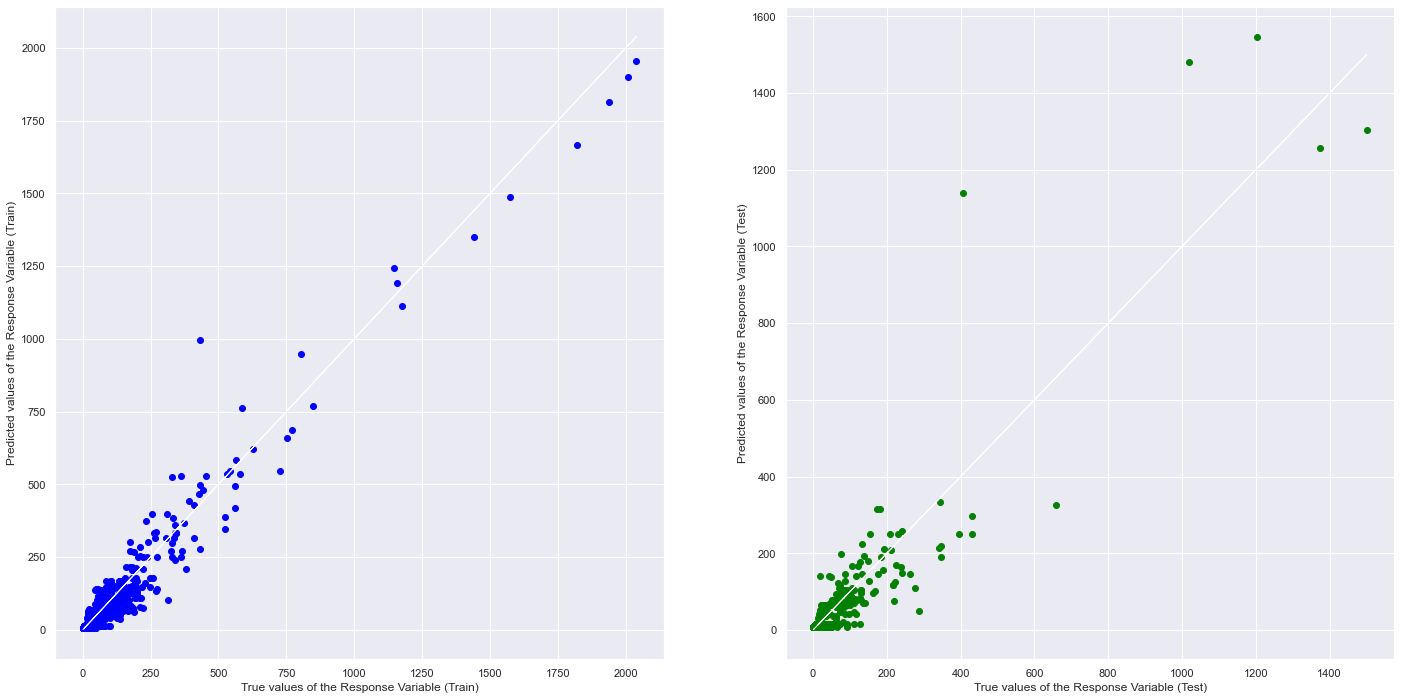

In [49]:
# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

In [50]:
# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", rforest.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.9543448685149682
Mean Squared Error (MSE) 	: 693.9970624377298



In [51]:
# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", rforest.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.8226792544808208
Mean Squared Error (MSE) 	: 1643.3481361915847



In [53]:
print(rforest.feature_importances_)
list_ohe = [x for x in seller_review_ohe]
list_importance = rforest.feature_importances_
for i in range(len(list_importance)):
    if list_importance[i] != 0.0:
        print("{} : {}".format(list_ohe[i],list_importance[i]))

[1.59181074e-02 7.89980863e-03 9.24570217e-04 ... 1.04976803e-04
 0.00000000e+00 8.91277837e-07]
average_review_score : 0.015918107389665315
average_price : 0.007899808626007837
average_freight_value : 0.0009245702166940512
product_description_length : 0.005246773694886673
average_product_photos_qty : 0.0016083730297247287
number_of_type_of_product_category : 0.0006140820642778694
number_of_type_of_product : 0.06304567195162128
seller_time : 0.0012857880891599211
order_late : 0.8965453075656331
number_of_sales_per_seller : 0.002538696953140026
seller_zip_code_prefix_134 : 1.5216626700767807e-05
seller_zip_code_prefix_150 : 4.4022872341114444e-05
seller_zip_code_prefix_256 : 0.00039563247026154545
seller_zip_code_prefix_320 : 4.097512795703924e-05
seller_zip_code_prefix_410 : 0.0007817074790383898
seller_zip_code_prefix_900 : 0.00016003495408256423
seller_zip_code_prefix_901 : 8.255084588790212e-05
seller_city_petropolis : 0.0003566422958990964
seller_city_piracicaba : 0.000326467102088

#### Random Forest Model : After filtering through our results from the Random Forest Regression model, we can see that Order_late has the highest feature importance, followed by number_of_type_of_product, seller_time, and average_review_score. 

### Hence, it can be seen that the findings of both models are highly consistent with one another which is a good indication.

## Order_late, Number_of_type_of_product, Seller_time, and Average_review_score (in this order) have the highest importance in affecting the number of sales for a seller. Thus sellers should focus on these factors. 